In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from numpy.polynomial.polynomial import polyfit
import numpy as np
from scipy import stats
import seaborn as sns
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, matthews_corrcoef
from sklearn import feature_extraction, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
import pymongo
from pymongo import MongoClient
import itertools

In [2]:
# setting up connection to local DB and collections

local_client = MongoClient()
ufc_stats_db = local_client["ufc_stats_db"]
fights = ufc_stats_db["fights"]
fighters = ufc_stats_db["fighters"]
events = ufc_stats_db["events"]
event_fights = ufc_stats_db["event_fights"]
model_results = ufc_stats_db["model_results"]
model_picks = ufc_stats_db["model_picks"]

In [3]:
# importing from local mongo DB and converting to pandas DataFrame

# Ignore if importing from csv

model_results_cur = model_results.find({})
model_results_list_cur = list(model_results_cur)
model_results_df = pd.DataFrame(model_results_list_cur)
model_results_df = model_results_df.drop(columns="_id")
model_results_df

blue_name         red_name win_pred       win_method  \
0               Ciryl Gane  Francis Ngannou     blue    blue - KO/TKO   
1      Deiveson Figueiredo   Brandon Moreno      red   red - Decision   
2        Said Nurmagomedov     Cody Stamann      red   red - Decision   
3             Victor Henry   Raoni Barcelos      red     red - KO/TKO   
4             Trevin Giles  Michael Morales     blue  blue - Decision   
...                    ...              ...      ...              ...   
12535         Jake Collier     Martin Buday      red   red - Decision   
12536      Charles Johnson      Cody Durden      red   red - Decision   
12537      Irina Alekseeva  Stephanie Egger      red   red - Decision   
12538        Marcus McGhee   Journey Newson      red   red - Decision   
12539      Jamey-Lyn Horth     Hailey Cowan      red   red - Decision   

      actual_winner      actual_method  red_total_pct  blue_total_pct  \
0               red     red - Decision           0.47            0.53   
1              blue    blue - Decision           0.60            0.40   
2              blue  blue - Submission           0.67            0.33   
3              blue    blue - Decision           0.87            0.13   
4               red       red - KO/TKO           0.47            0.53   
...             ...                ...            ...             ...   
12535           red     red - Decision           0.60            0.40   
12536           red     red - Decision           0.57            0.43   
12537          blue  blue - Submission           0.78            0.22   
12538          blue  blue - Submission           0.55            0.45   
12539          blue    blue - Decision           0.64            0.36   

       red_dec_pct  red_ko_pct  red_sub_pct  blue_dec_pct  blue_ko_pct  \
0             0.20        0.27         0.00          0.20         0.33   
1             0.27        0.27         0.07          0.13         0.13   
2             0.47        0.20         0.00          0.27         0.07   
3             0.33        0.53         0.00          0.07         0.07   
4             0.27        0.13         0.07          0.33         0.13   
...            ...         ...          ...           ...          ...   
12535         0.34        0.19         0.07          0.17         0.20   
12536         0.27        0.12         0.17          0.13         0.24   
12537         0.33        0.12         0.33          0.14         0.05   
12538         0.32        0.17         0.06          0.27         0.14   
12539         0.28        0.25         0.11          0.23         0.07   

       blue_sub_pct                            event  \
0              0.00        UFC 270: Ngannou vs. Gane   
1              0.13        UFC 270: Ngannou vs. Gane   
2              0.00        UFC 270: Ngannou vs. Gane   
3              0.00        UFC 270: Ngannou vs. Gane   
4              0.07        UFC 270: Ngannou vs. Gane   
...             ...                              ...   
12535          0.03  UFC Fight Night: Song vs. Simon   
12536          0.06  UFC Fight Night: Song vs. Simon   
12537          0.03  UFC Fight Night: Song vs. Simon   
12538          0.04  UFC Fight Night: Song vs. Simon   
12539          0.06  UFC Fight Night: Song vs. Simon   

                                                fight_id model_v  
0      Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...  knn_no  
1      Brandon Moreno vs. Deiveson Figueiredo: UFC 27...  knn_no  
2      Cody Stamann vs. Said Nurmagomedov: UFC 270: N...  knn_no  
3      Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...  knn_no  
4      Michael Morales vs. Trevin Giles: UFC 270: Nga...  knn_no  
...                                                  ...     ...  
12535  Martin Buday vs. Jake Collier: UFC Fight Night...  mix_up  
12536  Cody Durden vs. Charles Johnson: UFC Fight Nig...  mix_up  
12537  Stephanie Egger vs. Irina Alekseeva: UFC Fight...  mix_up  
12538  Journey Newson vs. Marcu

In [4]:
# exporting to csv in case needed

# model_results_df.to_csv("model_results.csv")

In [5]:
# importing from csv method

model_results_df = pd.read_csv("model_results.csv")
model_results_df = model_results_df.drop(columns="Unnamed: 0")
model_results_df

blue_name         red_name win_pred       win_method  \
0               Ciryl Gane  Francis Ngannou     blue    blue - KO/TKO   
1      Deiveson Figueiredo   Brandon Moreno      red   red - Decision   
2        Said Nurmagomedov     Cody Stamann      red   red - Decision   
3             Victor Henry   Raoni Barcelos      red     red - KO/TKO   
4             Trevin Giles  Michael Morales     blue  blue - Decision   
...                    ...              ...      ...              ...   
12535         Jake Collier     Martin Buday      red   red - Decision   
12536      Charles Johnson      Cody Durden      red   red - Decision   
12537      Irina Alekseeva  Stephanie Egger      red   red - Decision   
12538        Marcus McGhee   Journey Newson      red   red - Decision   
12539      Jamey-Lyn Horth     Hailey Cowan      red   red - Decision   

      actual_winner      actual_method  red_total_pct  blue_total_pct  \
0               red     red - Decision           0.47            0.53   
1              blue    blue - Decision           0.60            0.40   
2              blue  blue - Submission           0.67            0.33   
3              blue    blue - Decision           0.87            0.13   
4               red       red - KO/TKO           0.47            0.53   
...             ...                ...            ...             ...   
12535           red     red - Decision           0.60            0.40   
12536           red     red - Decision           0.57            0.43   
12537          blue  blue - Submission           0.78            0.22   
12538          blue  blue - Submission           0.55            0.45   
12539          blue    blue - Decision           0.64            0.36   

       red_dec_pct  red_ko_pct  red_sub_pct  blue_dec_pct  blue_ko_pct  \
0             0.20        0.27         0.00          0.20         0.33   
1             0.27        0.27         0.07          0.13         0.13   
2             0.47        0.20         0.00          0.27         0.07   
3             0.33        0.53         0.00          0.07         0.07   
4             0.27        0.13         0.07          0.33         0.13   
...            ...         ...          ...           ...          ...   
12535         0.34        0.19         0.07          0.17         0.20   
12536         0.27        0.12         0.17          0.13         0.24   
12537         0.33        0.12         0.33          0.14         0.05   
12538         0.32        0.17         0.06          0.27         0.14   
12539         0.28        0.25         0.11          0.23         0.07   

       blue_sub_pct                            event  \
0              0.00        UFC 270: Ngannou vs. Gane   
1              0.13        UFC 270: Ngannou vs. Gane   
2              0.00        UFC 270: Ngannou vs. Gane   
3              0.00        UFC 270: Ngannou vs. Gane   
4              0.07        UFC 270: Ngannou vs. Gane   
...             ...                              ...   
12535          0.03  UFC Fight Night: Song vs. Simon   
12536          0.06  UFC Fight Night: Song vs. Simon   
12537          0.03  UFC Fight Night: Song vs. Simon   
12538          0.04  UFC Fight Night: Song vs. Simon   
12539          0.06  UFC Fight Night: Song vs. Simon   

                                                fight_id model_v  
0      Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...  knn_no  
1      Brandon Moreno vs. Deiveson Figueiredo: UFC 27...  knn_no  
2      Cody Stamann vs. Said Nurmagomedov: UFC 270: N...  knn_no  
3      Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...  knn_no  
4      Michael Morales vs. Trevin Giles: UFC 270: Nga...  knn_no  
...                                                  ...     ...  
12535  Martin Buday vs. Jake Collier: UFC Fight Night...  mix_up  
12536  Cody Durden vs. Charles Johnson: UFC Fight Nig...  mix_up  
12537  Stephanie Egger vs. Irina Alekseeva: UFC Fight...  mix_up  
12538  Journey Newson vs. Marcu

In [6]:
model_results_df["correct_winner"] = np.where(model_results_df.win_pred == model_results_df.actual_winner, 1, 0)
model_results_df

blue_name         red_name win_pred       win_method  \
0               Ciryl Gane  Francis Ngannou     blue    blue - KO/TKO   
1      Deiveson Figueiredo   Brandon Moreno      red   red - Decision   
2        Said Nurmagomedov     Cody Stamann      red   red - Decision   
3             Victor Henry   Raoni Barcelos      red     red - KO/TKO   
4             Trevin Giles  Michael Morales     blue  blue - Decision   
...                    ...              ...      ...              ...   
12535         Jake Collier     Martin Buday      red   red - Decision   
12536      Charles Johnson      Cody Durden      red   red - Decision   
12537      Irina Alekseeva  Stephanie Egger      red   red - Decision   
12538        Marcus McGhee   Journey Newson      red   red - Decision   
12539      Jamey-Lyn Horth     Hailey Cowan      red   red - Decision   

      actual_winner      actual_method  red_total_pct  blue_total_pct  \
0               red     red - Decision           0.47            0.53   
1              blue    blue - Decision           0.60            0.40   
2              blue  blue - Submission           0.67            0.33   
3              blue    blue - Decision           0.87            0.13   
4               red       red - KO/TKO           0.47            0.53   
...             ...                ...            ...             ...   
12535           red     red - Decision           0.60            0.40   
12536           red     red - Decision           0.57            0.43   
12537          blue  blue - Submission           0.78            0.22   
12538          blue  blue - Submission           0.55            0.45   
12539          blue    blue - Decision           0.64            0.36   

       red_dec_pct  red_ko_pct  red_sub_pct  blue_dec_pct  blue_ko_pct  \
0             0.20        0.27         0.00          0.20         0.33   
1             0.27        0.27         0.07          0.13         0.13   
2             0.47        0.20         0.00          0.27         0.07   
3             0.33        0.53         0.00          0.07         0.07   
4             0.27        0.13         0.07          0.33         0.13   
...            ...         ...          ...           ...          ...   
12535         0.34        0.19         0.07          0.17         0.20   
12536         0.27        0.12         0.17          0.13         0.24   
12537         0.33        0.12         0.33          0.14         0.05   
12538         0.32        0.17         0.06          0.27         0.14   
12539         0.28        0.25         0.11          0.23         0.07   

       blue_sub_pct                            event  \
0              0.00        UFC 270: Ngannou vs. Gane   
1              0.13        UFC 270: Ngannou vs. Gane   
2              0.00        UFC 270: Ngannou vs. Gane   
3              0.00        UFC 270: Ngannou vs. Gane   
4              0.07        UFC 270: Ngannou vs. Gane   
...             ...                              ...   
12535          0.03  UFC Fight Night: Song vs. Simon   
12536          0.06  UFC Fight Night: Song vs. Simon   
12537          0.03  UFC Fight Night: Song vs. Simon   
12538          0.04  UFC Fight Night: Song vs. Simon   
12539          0.06  UFC Fight Night: Song vs. Simon   

                                                fight_id model_v  \
0      Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...  knn_no   
1      Brandon Moreno vs. Deiveson Figueiredo: UFC 27...  knn_no   
2      Cody Stamann vs. Said Nurmagomedov: UFC 270: N...  knn_no   
3      Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...  knn_no   
4      Michael Morales vs. Trevin Giles: UFC 270: Nga...  knn_no   
...                                                  ...     ...   
12535  Martin Buday vs. Jake Collier: UFC Fight Night...  mix_up   
12536  Cody Durden vs. Charles Johnson: UFC Fight Nig...  mix_up   
12537  Stephanie Egger vs. Irina Alekseeva: UFC Fight...  mix_up   
12538  Journey Newson

In [7]:
model_results_df = model_results_df[model_results_df["actual_winner"] != "Draw"]
model_results_df = model_results_df[model_results_df["actual_winner"] != "NC"]
model_results_df["total"] = len(model_results_df.index)
model_results_df

blue_name         red_name win_pred       win_method  \
0               Ciryl Gane  Francis Ngannou     blue    blue - KO/TKO   
1      Deiveson Figueiredo   Brandon Moreno      red   red - Decision   
2        Said Nurmagomedov     Cody Stamann      red   red - Decision   
3             Victor Henry   Raoni Barcelos      red     red - KO/TKO   
4             Trevin Giles  Michael Morales     blue  blue - Decision   
...                    ...              ...      ...              ...   
12535         Jake Collier     Martin Buday      red   red - Decision   
12536      Charles Johnson      Cody Durden      red   red - Decision   
12537      Irina Alekseeva  Stephanie Egger      red   red - Decision   
12538        Marcus McGhee   Journey Newson      red   red - Decision   
12539      Jamey-Lyn Horth     Hailey Cowan      red   red - Decision   

      actual_winner      actual_method  red_total_pct  blue_total_pct  \
0               red     red - Decision           0.47            0.53   
1              blue    blue - Decision           0.60            0.40   
2              blue  blue - Submission           0.67            0.33   
3              blue    blue - Decision           0.87            0.13   
4               red       red - KO/TKO           0.47            0.53   
...             ...                ...            ...             ...   
12535           red     red - Decision           0.60            0.40   
12536           red     red - Decision           0.57            0.43   
12537          blue  blue - Submission           0.78            0.22   
12538          blue  blue - Submission           0.55            0.45   
12539          blue    blue - Decision           0.64            0.36   

       red_dec_pct  red_ko_pct  red_sub_pct  blue_dec_pct  blue_ko_pct  \
0             0.20        0.27         0.00          0.20         0.33   
1             0.27        0.27         0.07          0.13         0.13   
2             0.47        0.20         0.00          0.27         0.07   
3             0.33        0.53         0.00          0.07         0.07   
4             0.27        0.13         0.07          0.33         0.13   
...            ...         ...          ...           ...          ...   
12535         0.34        0.19         0.07          0.17         0.20   
12536         0.27        0.12         0.17          0.13         0.24   
12537         0.33        0.12         0.33          0.14         0.05   
12538         0.32        0.17         0.06          0.27         0.14   
12539         0.28        0.25         0.11          0.23         0.07   

       blue_sub_pct                            event  \
0              0.00        UFC 270: Ngannou vs. Gane   
1              0.13        UFC 270: Ngannou vs. Gane   
2              0.00        UFC 270: Ngannou vs. Gane   
3              0.00        UFC 270: Ngannou vs. Gane   
4              0.07        UFC 270: Ngannou vs. Gane   
...             ...                              ...   
12535          0.03  UFC Fight Night: Song vs. Simon   
12536          0.06  UFC Fight Night: Song vs. Simon   
12537          0.03  UFC Fight Night: Song vs. Simon   
12538          0.04  UFC Fight Night: Song vs. Simon   
12539          0.06  UFC Fight Night: Song vs. Simon   

                                                fight_id model_v  \
0      Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...  knn_no   
1      Brandon Moreno vs. Deiveson Figueiredo: UFC 27...  knn_no   
2      Cody Stamann vs. Said Nurmagomedov: UFC 270: N...  knn_no   
3      Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...  knn_no   
4      Michael Morales vs. Trevin Giles: UFC 270: Nga...  knn_no   
...                                                  ...     ...   
12535  Martin Buday vs. Jake Collier: UFC Fight Night...  mix_up   
12536  Cody Durden vs. Charles Johnson: UFC Fight Nig...  mix_up   
12537  Stephanie Egger vs. Irina Alekseeva: UFC Fight...  mix_up   
12538  Journey Newson

In [8]:
winner_df = pd.DataFrame(model_results_df.groupby(["model_v"])["correct_winner"].sum())
winner_df["total_models"] = len(model_results_df.groupby(["model_v"])) 
winner_df["model_fights"] = model_results_df["total"][0] / winner_df["total_models"]
winner_df["incorrect_winner"] = (winner_df["model_fights"] - winner_df["correct_winner"]).astype(int)
winner_df["correct_%"] = round(((winner_df["correct_winner"] / winner_df["model_fights"]) * 100), 2)
winner_df = winner_df.drop(columns=["total_models", "model_fights"])
winner_df

correct_winner  incorrect_winner  correct_%
model_v                                              
combined             410               242      62.88
knn_no               374               278      57.36
knn_rand             348               304      53.37
knn_up               360               292      55.21
log_no               378               274      57.98
log_rand             397               255      60.89
log_up               377               275      57.82
mix_no               380               272      58.28
mix_rand             388               264      59.51
mix_up               393               259      60.28
mlp_no               386               266      59.20
mlp_rand             384               268      58.90
mlp_up               361               291      55.37
nn_no                393               259      60.28
nn_rand              406               246      62.27
nn_up                370               282      56.75
rf_no                373               279      57.21
rf_rand              319               333      48.93
rf_up                376               276      57.67

In [10]:
model_results_df["correct_method"] = np.where(model_results_df.win_method == model_results_df.actual_method, 1, 0)
model_results_df

blue_name         red_name win_pred       win_method  \
0               Ciryl Gane  Francis Ngannou     blue    blue - KO/TKO   
1      Deiveson Figueiredo   Brandon Moreno      red   red - Decision   
2        Said Nurmagomedov     Cody Stamann      red   red - Decision   
3             Victor Henry   Raoni Barcelos      red     red - KO/TKO   
4             Trevin Giles  Michael Morales     blue  blue - Decision   
...                    ...              ...      ...              ...   
12535         Jake Collier     Martin Buday      red   red - Decision   
12536      Charles Johnson      Cody Durden      red   red - Decision   
12537      Irina Alekseeva  Stephanie Egger      red   red - Decision   
12538        Marcus McGhee   Journey Newson      red   red - Decision   
12539      Jamey-Lyn Horth     Hailey Cowan      red   red - Decision   

      actual_winner      actual_method  red_total_pct  blue_total_pct  \
0               red     red - Decision           0.47            0.53   
1              blue    blue - Decision           0.60            0.40   
2              blue  blue - Submission           0.67            0.33   
3              blue    blue - Decision           0.87            0.13   
4               red       red - KO/TKO           0.47            0.53   
...             ...                ...            ...             ...   
12535           red     red - Decision           0.60            0.40   
12536           red     red - Decision           0.57            0.43   
12537          blue  blue - Submission           0.78            0.22   
12538          blue  blue - Submission           0.55            0.45   
12539          blue    blue - Decision           0.64            0.36   

       red_dec_pct  red_ko_pct  red_sub_pct  blue_dec_pct  blue_ko_pct  \
0             0.20        0.27         0.00          0.20         0.33   
1             0.27        0.27         0.07          0.13         0.13   
2             0.47        0.20         0.00          0.27         0.07   
3             0.33        0.53         0.00          0.07         0.07   
4             0.27        0.13         0.07          0.33         0.13   
...            ...         ...          ...           ...          ...   
12535         0.34        0.19         0.07          0.17         0.20   
12536         0.27        0.12         0.17          0.13         0.24   
12537         0.33        0.12         0.33          0.14         0.05   
12538         0.32        0.17         0.06          0.27         0.14   
12539         0.28        0.25         0.11          0.23         0.07   

       blue_sub_pct                            event  \
0              0.00        UFC 270: Ngannou vs. Gane   
1              0.13        UFC 270: Ngannou vs. Gane   
2              0.00        UFC 270: Ngannou vs. Gane   
3              0.00        UFC 270: Ngannou vs. Gane   
4              0.07        UFC 270: Ngannou vs. Gane   
...             ...                              ...   
12535          0.03  UFC Fight Night: Song vs. Simon   
12536          0.06  UFC Fight Night: Song vs. Simon   
12537          0.03  UFC Fight Night: Song vs. Simon   
12538          0.04  UFC Fight Night: Song vs. Simon   
12539          0.06  UFC Fight Night: Song vs. Simon   

                                                fight_id model_v  \
0      Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...  knn_no   
1      Brandon Moreno vs. Deiveson Figueiredo: UFC 27...  knn_no   
2      Cody Stamann vs. Said Nurmagomedov: UFC 270: N...  knn_no   
3      Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...  knn_no   
4      Michael Morales vs. Trevin Giles: UFC 270: Nga...  knn_no   
...                                                  ...     ...   
12535  Martin Buday vs. Jake Collier: UFC Fight Night...  mix_up   
12536  Cody Durden vs. Charles Johnson: UFC Fight Nig...  mix_up   
12537  Stephanie Egger vs. Irina Alekseeva: UFC Fight...  mix_up   
12538  Journey Newson

In [11]:
method_df = pd.DataFrame(model_results_df.groupby(["model_v"])["correct_method"].sum())
method_df["total_models"] = len(model_results_df.groupby(["model_v"])) 
method_df["model_fights"] = model_results_df["total"][0] / method_df["total_models"]
method_df["incorrect_method"] = (method_df["model_fights"] - method_df["correct_method"]).astype(int)
method_df["correct_%"] = round(((method_df["correct_method"] / method_df["model_fights"]) * 100), 2)
method_df = method_df.drop(columns=["total_models", "model_fights"])
method_df

correct_method  incorrect_method  correct_%
model_v                                              
combined             217               435      33.28
knn_no               181               471      27.76
knn_rand             156               496      23.93
knn_up               178               474      27.30
log_no               199               453      30.52
log_rand             209               443      32.06
log_up               189               463      28.99
mix_no               193               459      29.60
mix_rand             193               459      29.60
mix_up               193               459      29.60
mlp_no               181               471      27.76
mlp_rand             173               479      26.53
mlp_up               176               476      26.99
nn_no                205               447      31.44
nn_rand              209               443      32.06
nn_up                175               477      26.84
rf_no                163               489      25.00
rf_rand              130               522      19.94
rf_up                144               508      22.09

In [12]:
model_results_df.groupby(["model_v"])["correct_method"].value_counts()

model_v   correct_method
combined  0                 435
          1                 217
knn_no    0                 471
          1                 181
knn_rand  0                 496
          1                 156
knn_up    0                 474
          1                 178
log_no    0                 453
          1                 199
log_rand  0                 443
          1                 209
log_up    0                 463
          1                 189
mix_no    0                 459
          1                 193
mix_rand  0                 459
          1                 193
mix_up    0                 459
          1                 193
mlp_no    0                 471
          1                 181
mlp_rand  0                 479
          1                 173
mlp_up    0                 476
          1                 176
nn_no     0                 447
          1                 205
nn_rand   0                 443
          1                 209
nn_up     0    

In [13]:
# selecting a model version for further analysis 

# model = model_results_df[model_results_df["model_v"] == "combined"]
model = model_results_df[model_results_df["model_v"] == "nn_rand"]
model

blue_name         red_name win_pred      win_method  \
104             Ciryl Gane  Francis Ngannou      red  red - Decision   
105    Deiveson Figueiredo   Brandon Moreno      red    red - KO/TKO   
106      Said Nurmagomedov     Cody Stamann      red  red - Decision   
107           Victor Henry   Raoni Barcelos      red    red - KO/TKO   
108           Trevin Giles  Michael Morales      red  red - Decision   
...                    ...              ...      ...             ...   
12491         Jake Collier     Martin Buday     blue  red - Decision   
12492      Charles Johnson      Cody Durden      red  red - Decision   
12493      Irina Alekseeva  Stephanie Egger      red  red - Decision   
12494        Marcus McGhee   Journey Newson      red  red - Decision   
12495      Jamey-Lyn Horth     Hailey Cowan      red  red - Decision   

      actual_winner      actual_method  red_total_pct  blue_total_pct  \
104             red     red - Decision           0.52            0.48   
105            blue    blue - Decision           0.66            0.34   
106            blue  blue - Submission           0.55            0.45   
107            blue    blue - Decision           0.90            0.10   
108             red       red - KO/TKO           0.60            0.40   
...             ...                ...            ...             ...   
12491           red     red - Decision           0.47            0.53   
12492           red     red - Decision           0.60            0.40   
12493          blue  blue - Submission           0.65            0.35   
12494          blue  blue - Submission           0.56            0.44   
12495          blue    blue - Decision           0.62            0.38   

       red_dec_pct  red_ko_pct  red_sub_pct  blue_dec_pct  blue_ko_pct  \
104           0.35        0.15         0.02          0.21         0.22   
105           0.30        0.31         0.05          0.08         0.13   
106           0.35        0.18         0.02          0.27         0.15   
107           0.30        0.53         0.07          0.06         0.02   
108           0.26        0.21         0.12          0.23         0.07   
...            ...         ...          ...           ...          ...   
12491         0.29        0.15         0.03          0.29         0.22   
12492         0.41        0.06         0.14          0.25         0.13   
12493         0.27        0.11         0.26          0.19         0.06   
12494         0.30        0.19         0.06          0.23         0.13   
12495         0.46        0.08         0.08          0.28         0.05   

       blue_sub_pct                            event  \
104            0.05        UFC 270: Ngannou vs. Gane   
105            0.13        UFC 270: Ngannou vs. Gane   
106            0.03        UFC 270: Ngannou vs. Gane   
107            0.02        UFC 270: Ngannou vs. Gane   
108            0.11        UFC 270: Ngannou vs. Gane   
...             ...                              ...   
12491          0.02  UFC Fight Night: Song vs. Simon   
12492          0.02  UFC Fight Night: Song vs. Simon   
12493          0.11  UFC Fight Night: Song vs. Simon   
12494          0.08  UFC Fight Night: Song vs. Simon   
12495          0.05  UFC Fight Night: Song vs. Simon   

                                                fight_id  model_v  \
104    Francis Ngannou vs. Ciryl Gane: UFC 270: Ngann...  nn_rand   
105    Brandon Moreno vs. Deiveson Figueiredo: UFC 27...  nn_rand   
106    Cody Stamann vs. Said Nurmagomedov: UFC 270: N...  nn_rand   
107    Raoni Barcelos vs. Victor Henry: UFC 270: Ngan...  nn_rand   
108    Michael Morales vs. Trevin Giles: UFC 270: Nga...  nn_rand   
...                                                  ...      ...   
12491  Martin Buday vs. Jake Collier: UFC Fight Night...  nn_rand   
12492  Cody Durden vs. Charles Johnson: UFC Fight Nig...  nn_rand   
12493  Stephanie Egger vs. Irina Alekseeva: UFC Fight...  nn_rand   
12494  Journey Newson v

In [14]:
# different bucket ranges 
bucket = 0.05
# divider for getting midpoint of buckets. 1 if bucket size is 0.01 and 2 for any other bucket size
divider = 2
# minimum observations thresholds
min_obs = 5

In [15]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["red_total_pct"] >= x]
    point_to_point = point_up[point_up["red_total_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_winner"] == "red"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
        
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 0% of 1 observations
5% to 10%: 0% of 2 observations
10% to 15%: 28% of 7 observations
15% to 20%: 12% of 8 observations
20% to 25%: 27% of 26 observations
25% to 30%: 44% of 41 observations
30% to 35%: 43% of 54 observations
35% to 40%: 50% of 40 observations
40% to 45%: 45% of 56 observations
45% to 50%: 57% of 71 observations
50% to 55%: 64% of 75 observations
55% to 60%: 68% of 66 observations
60% to 65%: 61% of 51 observations
65% to 70%: 64% of 59 observations
70% to 75%: 78% of 37 observations
75% to 80%: 73% of 37 observations
80% to 85%: 86% of 22 observations
85% to 90%: 83% of 6 observations
90% to 95%: 50% of 4 observations
95% to 100%: 100% of 1 observations


In [16]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[7, 8, 26, 41, 54, 40, 56, 71, 75, 66, 51, 59, 37, 37, 22, 6]
[12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88]
[28, 12, 27, 44, 43, 50, 45, 57, 64, 68, 61, 64, 78, 73, 86, 83]


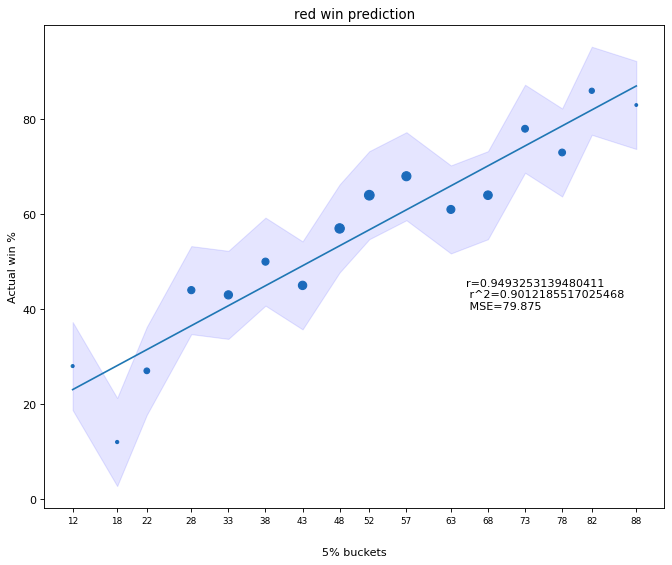

In [17]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(65, 40, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual win %")
plt.title("red win prediction")
plt.show()

In [18]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["red_dec_pct"] >= x]
    point_to_point = point_up[point_up["red_dec_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - Decision"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 5% of 20 observations
5% to 10%: 12% of 69 observations
10% to 15%: 22% of 121 observations
15% to 20%: 24% of 70 observations
20% to 25%: 27% of 92 observations
25% to 30%: 34% of 86 observations
30% to 35%: 28% of 63 observations
35% to 40%: 31% of 39 observations
40% to 45%: 46% of 28 observations
45% to 50%: 44% of 16 observations
50% to 55%: 50% of 16 observations
55% to 60%: 27% of 11 observations
60% to 65%: 33% of 6 observations
65% to 70%: 40% of 5 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations


In [19]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
print(observations)
print(half_points)
print(actual_win_pct)

[20, 69, 121, 70, 92, 86, 63, 39, 28, 16, 16, 11, 6, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68]
[5, 12, 22, 24, 27, 34, 28, 31, 46, 44, 50, 27, 33, 40]


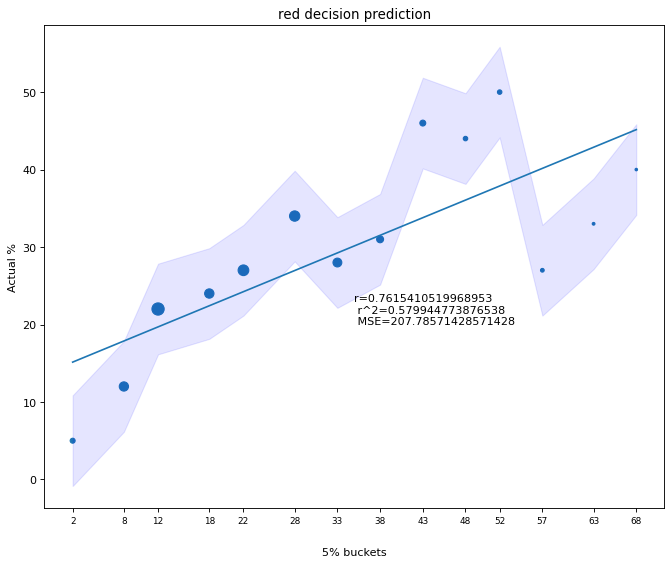

In [20]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(35, 20, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("red decision prediction")
plt.show()

In [21]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["red_ko_pct"] >= x]
    point_to_point = point_up[point_up["red_ko_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - KO/TKO"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 3% of 60 observations
5% to 10%: 14% of 156 observations
10% to 15%: 16% of 149 observations
15% to 20%: 23% of 75 observations
20% to 25%: 22% of 63 observations
25% to 30%: 24% of 54 observations
30% to 35%: 17% of 30 observations
35% to 40%: 0% of 15 observations
40% to 45%: 55% of 11 observations
45% to 50%: 33% of 9 observations
50% to 55%: 20% of 5 observations
55% to 60%: 50% of 10 observations
60% to 65%: 50% of 2 observations
65% to 70%: 0% of 0 observations
70% to 75%: 100% of 1 observations
75% to 80%: 0% of 0 observations
80% to 85%: 100% of 2 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations


In [22]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]

print(observations)
print(half_points)
print(actual_win_pct)

[60, 156, 149, 75, 63, 54, 30, 15, 11, 9, 5, 10]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57]
[3, 14, 16, 23, 22, 24, 17, 0, 55, 33, 20, 50]


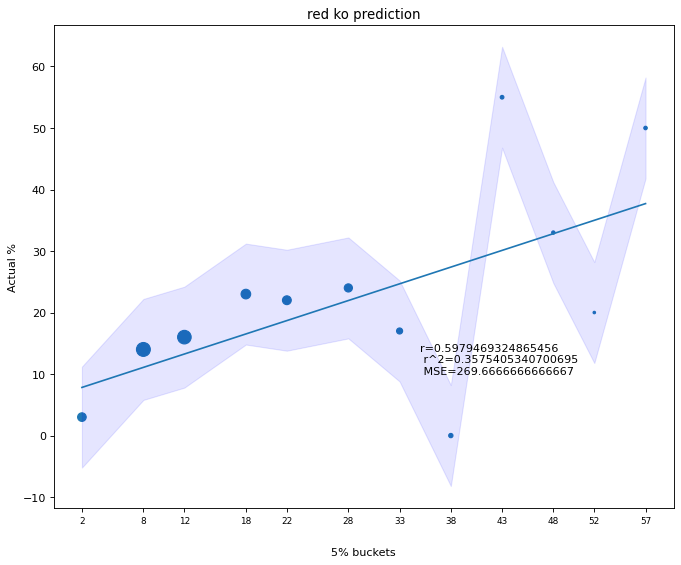

In [23]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(35, 10, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("red ko prediction")
plt.show()

In [24]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["red_sub_pct"] >= x]
    point_to_point = point_up[point_up["red_sub_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - Submission"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
        
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 5% of 202 observations
5% to 10%: 11% of 211 observations
10% to 15%: 14% of 123 observations
15% to 20%: 13% of 38 observations
20% to 25%: 24% of 25 observations
25% to 30%: 38% of 26 observations
30% to 35%: 20% of 10 observations
35% to 40%: 20% of 5 observations
40% to 45%: 25% of 4 observations
45% to 50%: 33% of 3 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 1 observations
70% to 75%: 0% of 0 observations
75% to 80%: 33% of 3 observations
80% to 85%: 0% of 0 observations
85% to 90%: 100% of 1 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations


In [25]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i] 

print(observations)
print(half_points)
print(actual_win_pct)

[202, 211, 123, 38, 25, 26, 10, 5]
[2, 8, 12, 18, 22, 28, 33, 38]
[5, 11, 14, 13, 24, 38, 20, 20]


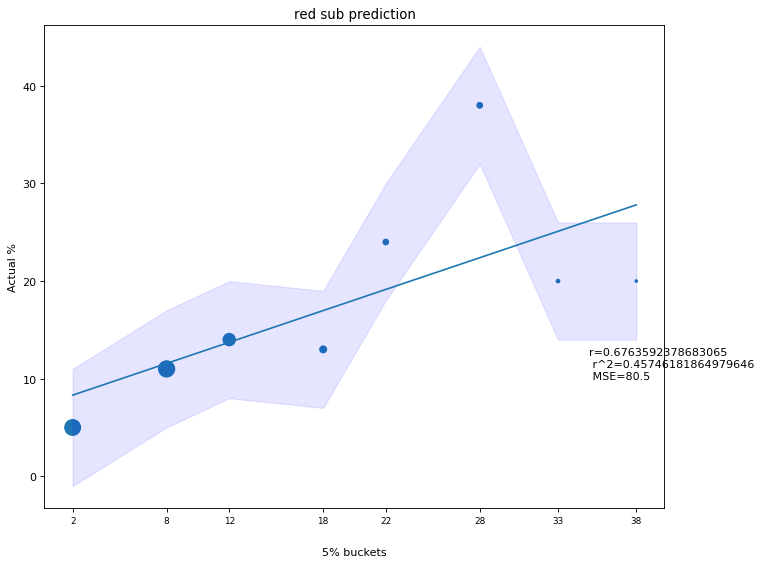

In [26]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(35, 10, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("red sub prediction")
plt.show()

In [27]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["blue_total_pct"] >= x]
    point_to_point = point_up[point_up["blue_total_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_winner"] == "blue"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 0% of 1 observations
5% to 10%: 33% of 3 observations
10% to 15%: 17% of 12 observations
15% to 20%: 14% of 14 observations
20% to 25%: 26% of 34 observations
25% to 30%: 22% of 37 observations
30% to 35%: 40% of 50 observations
35% to 40%: 40% of 40 observations
40% to 45%: 32% of 53 observations
45% to 50%: 35% of 75 observations
50% to 55%: 41% of 71 observations
55% to 60%: 54% of 69 observations
60% to 65%: 50% of 48 observations
65% to 70%: 57% of 59 observations
70% to 75%: 56% of 41 observations
75% to 80%: 68% of 28 observations
80% to 85%: 91% of 11 observations
85% to 90%: 71% of 7 observations
90% to 95%: 100% of 2 observations
95% to 100%: 100% of 1 observations


In [28]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[12, 14, 34, 37, 50, 40, 53, 75, 71, 69, 48, 59, 41, 28, 11, 7]
[12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88]
[17, 14, 26, 22, 40, 40, 32, 35, 41, 54, 50, 57, 56, 68, 91, 71]


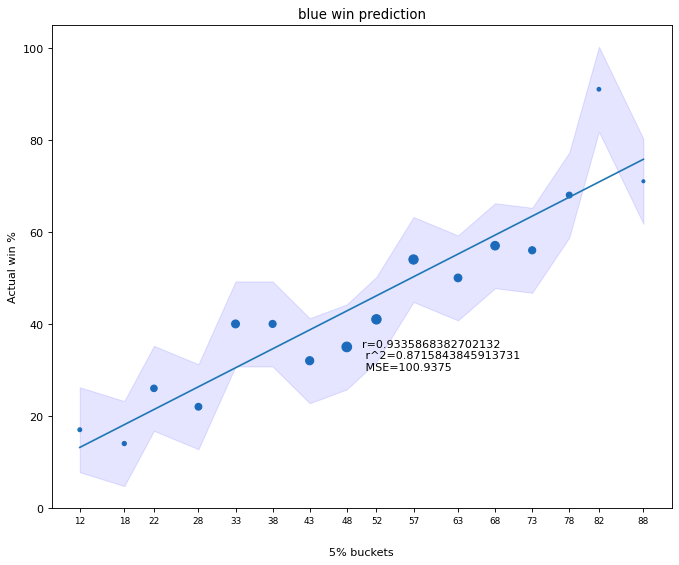

In [29]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(50, 30, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual win %")
plt.title("blue win prediction")
plt.show()

In [30]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["blue_dec_pct"] >= x]
    point_to_point = point_up[point_up["blue_dec_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - Decision"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 12% of 16 observations
5% to 10%: 15% of 68 observations
10% to 15%: 12% of 119 observations
15% to 20%: 19% of 99 observations
20% to 25%: 19% of 102 observations
25% to 30%: 19% of 83 observations
30% to 35%: 16% of 55 observations
35% to 40%: 35% of 31 observations
40% to 45%: 31% of 32 observations
45% to 50%: 56% of 14 observations
50% to 55%: 62% of 8 observations
55% to 60%: 25% of 4 observations
60% to 65%: 0% of 1 observations
65% to 70%: 50% of 2 observations
70% to 75%: 0% of 0 observations
75% to 80%: 100% of 1 observations
80% to 85%: 100% of 1 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations


In [31]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[16, 68, 119, 99, 102, 83, 55, 31, 32, 14, 8]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52]
[12, 15, 12, 19, 19, 19, 16, 35, 31, 56, 62]


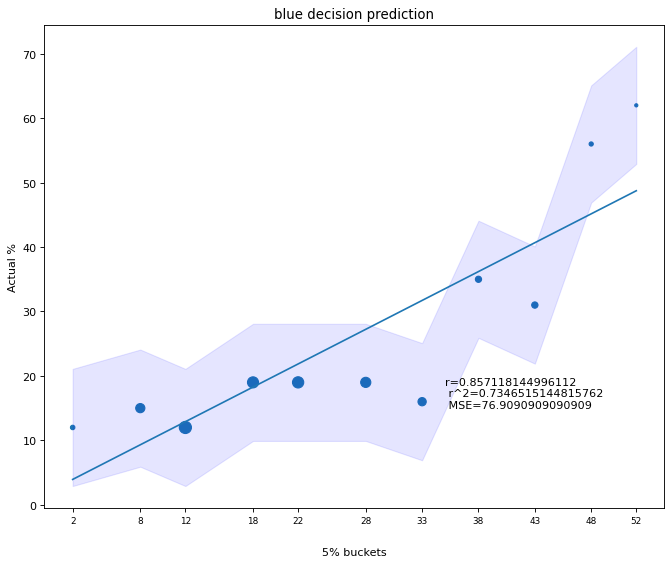

In [32]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(35, 15, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("blue decision prediction")
plt.show()

In [33]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["blue_ko_pct"] >= x]
    point_to_point = point_up[point_up["blue_ko_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - KO/TKO"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 5% of 64 observations
5% to 10%: 6% of 154 observations
10% to 15%: 6% of 145 observations
15% to 20%: 22% of 65 observations
20% to 25%: 21% of 66 observations
25% to 30%: 23% of 60 observations
30% to 35%: 17% of 29 observations
35% to 40%: 31% of 16 observations
40% to 45%: 43% of 21 observations
45% to 50%: 25% of 8 observations
50% to 55%: 44% of 9 observations
55% to 60%: 25% of 4 observations
60% to 65%: 100% of 2 observations
65% to 70%: 100% of 1 observations
70% to 75%: 0% of 1 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations


In [34]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[64, 154, 145, 65, 66, 60, 29, 16, 21, 8, 9]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52]
[5, 6, 6, 22, 21, 23, 17, 31, 43, 25, 44]


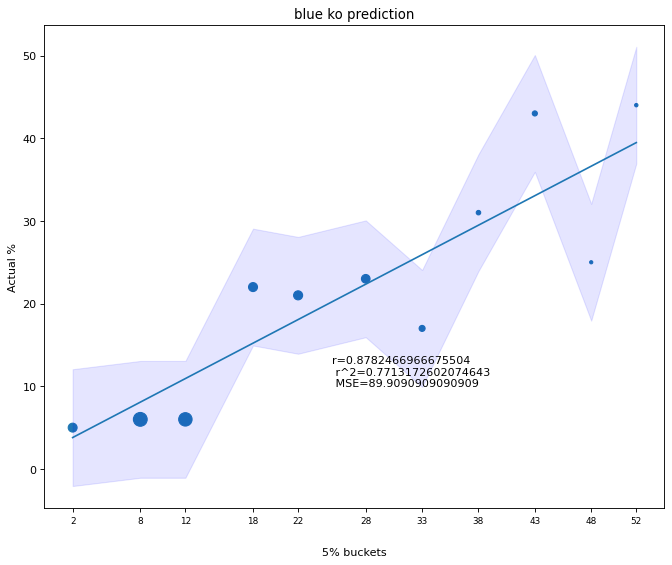

In [35]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(25, 10, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("blue ko prediction")
plt.show()

In [36]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = model[model["blue_sub_pct"] >= x]
    point_to_point = point_up[point_up["blue_sub_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - Submission"]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
    
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 6% of 220 observations
5% to 10%: 8% of 213 observations
10% to 15%: 11% of 99 observations
15% to 20%: 4% of 48 observations
20% to 25%: 15% of 33 observations
25% to 30%: 17% of 18 observations
30% to 35%: 25% of 8 observations
35% to 40%: 20% of 5 observations
40% to 45%: 0% of 2 observations
45% to 50%: 33% of 3 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 1 observations
75% to 80%: 0% of 1 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations


In [37]:
empties = [i for i, j in enumerate(observations) if j < min_obs]
for i in sorted(empties, reverse=True):
    del observations[i]
    del half_points[i]
    del actual_win_pct[i]
    
print(observations)
print(half_points)
print(actual_win_pct)

[220, 213, 99, 48, 33, 18, 8, 5]
[2, 8, 12, 18, 22, 28, 33, 38]
[6, 8, 11, 4, 15, 17, 25, 20]


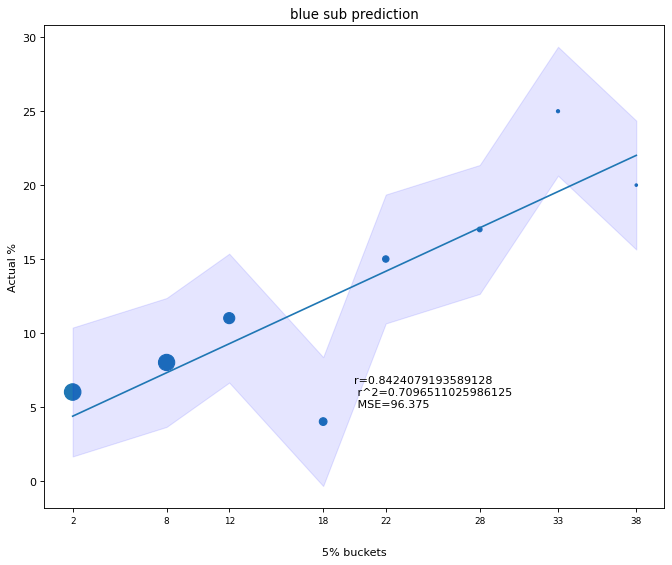

In [38]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(20, 5, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("Actual %")
plt.title("blue sub prediction")
plt.show()

In [39]:
probas = model[["red_dec_pct", "red_ko_pct", "red_sub_pct", "blue_dec_pct", "blue_ko_pct", "blue_sub_pct"]]
probas

red_dec_pct  red_ko_pct  red_sub_pct  blue_dec_pct  blue_ko_pct  \
104           0.35        0.15         0.02          0.21         0.22   
105           0.30        0.31         0.05          0.08         0.13   
106           0.35        0.18         0.02          0.27         0.15   
107           0.30        0.53         0.07          0.06         0.02   
108           0.26        0.21         0.12          0.23         0.07   
...            ...         ...          ...           ...          ...   
12491         0.29        0.15         0.03          0.29         0.22   
12492         0.41        0.06         0.14          0.25         0.13   
12493         0.27        0.11         0.26          0.19         0.06   
12494         0.30        0.19         0.06          0.23         0.13   
12495         0.46        0.08         0.08          0.28         0.05   

       blue_sub_pct  
104            0.05  
105            0.13  
106            0.03  
107            0.02  
108            0.11  
...             ...  
12491          0.02  
12492          0.02  
12493          0.11  
12494          0.08  
12495          0.05  

[652 rows x 6 columns]

In [40]:
# probas = model[["red_total_pct", "blue_total_pct"]]
# probas

In [41]:
predicted_prob =  probas.values
predicted_prob

array([[0.35, 0.15, 0.02, 0.21, 0.22, 0.05],
       [0.3 , 0.31, 0.05, 0.08, 0.13, 0.13],
       [0.35, 0.18, 0.02, 0.27, 0.15, 0.03],
       ...,
       [0.27, 0.11, 0.26, 0.19, 0.06, 0.11],
       [0.3 , 0.19, 0.06, 0.23, 0.13, 0.08],
       [0.46, 0.08, 0.08, 0.28, 0.05, 0.05]])

In [42]:
# prediction_labels = combined["win_pred"]

In [43]:
prediction_labels = model["win_method"]

In [44]:
# actual_result = combined["actual_winner"]

In [45]:
actual_result = model["actual_method"]

In [46]:
classes = np.unique(actual_result)
y_array = pd.get_dummies(actual_result, drop_first=False).values
y_array

array([[0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       ...,
       [0, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 0, 0],
       [1, 0, 0, 0, 0, 0]], dtype=uint8)

In [47]:
accuracy = metrics.accuracy_score(actual_result, prediction_labels)
auc = metrics.roc_auc_score(y_array, predicted_prob, 
                            multi_class="one_vs_rest")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(actual_result, prediction_labels))

Accuracy: 0.32
Auc: 0.47
Detail:
                   precision    recall  f1-score   support

  blue - Decision       0.29      0.39      0.33       130
    blue - KO/TKO       0.33      0.39      0.36        93
blue - Submission       0.18      0.09      0.12        56
   red - Decision       0.36      0.42      0.39       174
     red - KO/TKO       0.33      0.28      0.31       120
 red - Submission       0.30      0.13      0.18        79

         accuracy                           0.32       652
        macro avg       0.30      0.28      0.28       652
     weighted avg       0.31      0.32      0.31       652



(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5]),
 [Text(0, 0.5, 'blue - Decision'),
  Text(0, 1.5, 'blue - KO/TKO'),
  Text(0, 2.5, 'blue - Submission'),
  Text(0, 3.5, 'red - Decision'),
  Text(0, 4.5, 'red - KO/TKO'),
  Text(0, 5.5, 'red - Submission')])

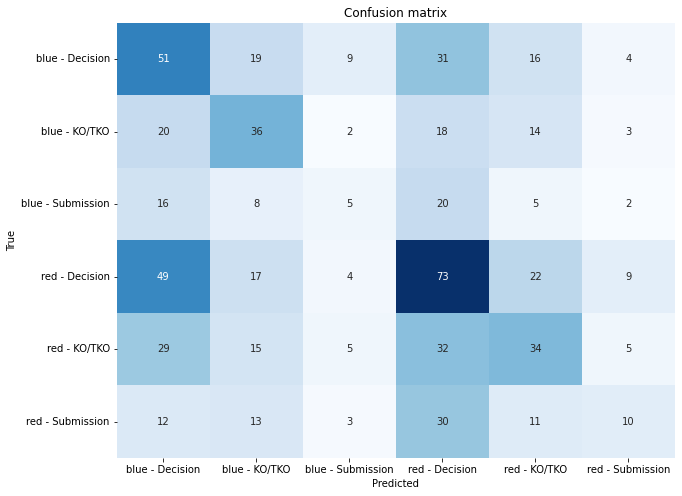

In [48]:
cm = metrics.confusion_matrix(actual_result, prediction_labels)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

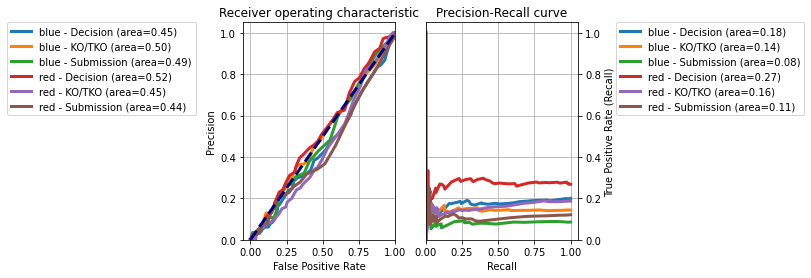

In [49]:
fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="Precision", 
          title="Receiver operating characteristic")
ax[0].legend(bbox_to_anchor=(-1.55, 1), loc=2, borderaxespad=0.)
ax[0].grid(True)

for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="True Positive Rate (Recall)", title="Precision-Recall curve")
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)
ax[1].grid(True)
plt.show()

In [50]:
matthews_corrcoef(actual_result, prediction_labels)

0.15234783309846475

In [51]:
probas = model[["red_total_pct", "blue_total_pct"]]
probas

red_total_pct  blue_total_pct
104             0.52            0.48
105             0.66            0.34
106             0.55            0.45
107             0.90            0.10
108             0.60            0.40
...              ...             ...
12491           0.47            0.53
12492           0.60            0.40
12493           0.65            0.35
12494           0.56            0.44
12495           0.62            0.38

[652 rows x 2 columns]

In [52]:
predicted_prob =  probas.values
predicted_prob

array([[0.52, 0.48],
       [0.66, 0.34],
       [0.55, 0.45],
       ...,
       [0.65, 0.35],
       [0.56, 0.44],
       [0.62, 0.38]])

In [53]:
prediction_labels = model["win_pred"]

In [54]:
actual_result = model["actual_winner"]

In [55]:
classes = np.unique(actual_result)
y_array = pd.get_dummies(actual_result, drop_first=False).values
y_array

array([[0, 1],
       [1, 0],
       [1, 0],
       ...,
       [1, 0],
       [1, 0],
       [1, 0]], dtype=uint8)

In [56]:
accuracy = metrics.accuracy_score(actual_result, prediction_labels)
auc = metrics.roc_auc_score(y_array, predicted_prob, 
                            multi_class="one_vs_one")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(actual_result, prediction_labels))

Accuracy: 0.62
Auc: 0.34
Detail:
              precision    recall  f1-score   support

        blue       0.55      0.62      0.59       279
         red       0.69      0.62      0.65       373

    accuracy                           0.62       652
   macro avg       0.62      0.62      0.62       652
weighted avg       0.63      0.62      0.62       652



(array([0.5, 1.5]), [Text(0, 0.5, 'blue'), Text(0, 1.5, 'red')])

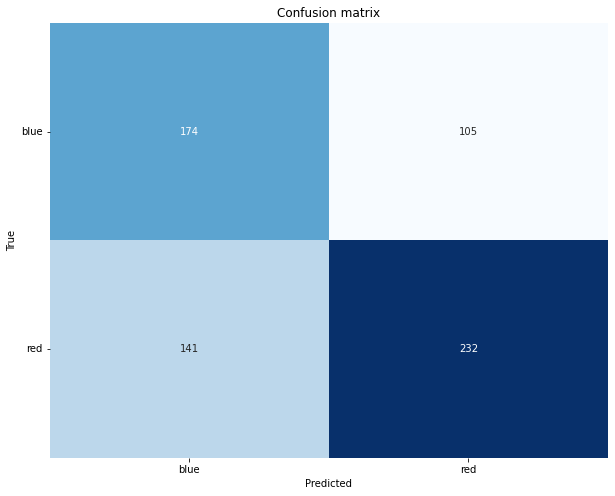

In [57]:
cm = metrics.confusion_matrix(actual_result, prediction_labels)
fig, ax = plt.subplots(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Predicted", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

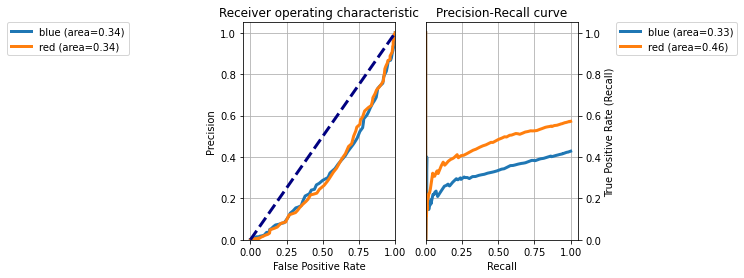

In [58]:
fig, ax = plt.subplots(nrows=1, ncols=2)
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_array[:,i],  
                           predicted_prob[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="Precision", 
          title="Receiver operating characteristic")
ax[0].legend(bbox_to_anchor=(-1.55, 1), loc=2, borderaxespad=0.)
ax[0].grid(True)

for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_array[:,i], predicted_prob[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="True Positive Rate (Recall)", title="Precision-Recall curve")
ax[1].yaxis.set_label_position("right")
ax[1].yaxis.tick_right()
ax[1].legend(bbox_to_anchor=(1.25, 1), loc=2, borderaxespad=0.)
ax[1].grid(True)
plt.show()

In [59]:
matthews_corrcoef(actual_result, prediction_labels)

0.24321204260506013

In [60]:
exact_pcts = list(np.random.randint(low=5, high=95, size=605)/100)
exact_pcts

[0.36,
 0.26,
 0.83,
 0.82,
 0.33,
 0.3,
 0.26,
 0.42,
 0.3,
 0.2,
 0.87,
 0.72,
 0.93,
 0.23,
 0.82,
 0.83,
 0.53,
 0.3,
 0.86,
 0.42,
 0.87,
 0.63,
 0.62,
 0.64,
 0.71,
 0.48,
 0.57,
 0.25,
 0.7,
 0.12,
 0.23,
 0.31,
 0.47,
 0.38,
 0.84,
 0.48,
 0.35,
 0.44,
 0.27,
 0.19,
 0.1,
 0.08,
 0.53,
 0.42,
 0.77,
 0.59,
 0.59,
 0.31,
 0.42,
 0.2,
 0.7,
 0.44,
 0.45,
 0.92,
 0.93,
 0.92,
 0.73,
 0.46,
 0.76,
 0.76,
 0.3,
 0.44,
 0.63,
 0.81,
 0.21,
 0.43,
 0.55,
 0.63,
 0.22,
 0.36,
 0.4,
 0.19,
 0.74,
 0.78,
 0.23,
 0.89,
 0.92,
 0.49,
 0.92,
 0.26,
 0.89,
 0.14,
 0.05,
 0.28,
 0.86,
 0.54,
 0.75,
 0.36,
 0.75,
 0.94,
 0.53,
 0.43,
 0.73,
 0.18,
 0.68,
 0.78,
 0.33,
 0.3,
 0.14,
 0.06,
 0.23,
 0.37,
 0.93,
 0.05,
 0.81,
 0.48,
 0.15,
 0.19,
 0.27,
 0.81,
 0.78,
 0.63,
 0.91,
 0.69,
 0.82,
 0.69,
 0.92,
 0.37,
 0.88,
 0.43,
 0.21,
 0.25,
 0.38,
 0.21,
 0.27,
 0.67,
 0.45,
 0.48,
 0.31,
 0.83,
 0.05,
 0.54,
 0.49,
 0.68,
 0.05,
 0.16,
 0.89,
 0.29,
 0.13,
 0.74,
 0.68,
 0.1,
 0.93,
 0.27,
 0.5

In [61]:
exact_true = []
for n in exact_pcts:
    print(n)
    test = list(np.random.randint(low=0,high=100, size=1) /100)
    print(test[0])
    if test[0] <= n:
        print("true")
        exact_true.append(1)
    else:
        print("false")
        exact_true.append(0)

0.36
0.72
false
0.26
0.68
false
0.83
0.19
true
0.82
0.19
true
0.33
0.75
false
0.3
0.46
false
0.26
0.08
true
0.42
0.56
false
0.3
0.31
false
0.2
0.83
false
0.87
0.87
true
0.72
0.85
false
0.93
0.26
true
0.23
0.77
false
0.82
0.31
true
0.83
0.16
true
0.53
0.31
true
0.3
0.5
false
0.86
0.92
false
0.42
0.67
false
0.87
0.09
true
0.63
0.8
false
0.62
0.99
false
0.64
0.56
true
0.71
0.7
true
0.48
0.68
false
0.57
0.87
false
0.25
0.03
true
0.7
0.73
false
0.12
0.59
false
0.23
0.6
false
0.31
0.86
false
0.47
0.33
true
0.38
0.41
false
0.84
0.38
true
0.48
0.1
true
0.35
0.63
false
0.44
0.19
true
0.27
0.18
true
0.19
0.47
false
0.1
0.63
false
0.08
0.53
false
0.53
0.3
true
0.42
0.08
true
0.77
0.37
true
0.59
0.98
false
0.59
0.15
true
0.31
0.35
false
0.42
0.51
false
0.2
0.06
true
0.7
0.39
true
0.44
0.07
true
0.45
0.49
false
0.92
0.62
true
0.93
0.27
true
0.92
0.96
false
0.73
0.61
true
0.46
0.38
true
0.76
0.7
true
0.76
0.34
true
0.3
0.31
false
0.44
0.38
true
0.63
0.26
true
0.81
0.36
true
0.21
0.66
false
0.43
0.15

In [62]:
sum(exact_true) 

324

In [63]:
exact_dict = {"exact_pct" : exact_pcts,
             "true" : exact_true}
exact_df = pd.DataFrame(exact_dict)
exact_df

exact_pct  true
0         0.36     0
1         0.26     0
2         0.83     1
3         0.82     1
4         0.33     0
..         ...   ...
600       0.73     1
601       0.55     0
602       0.13     0
603       0.05     0
604       0.47     0

[605 rows x 2 columns]

In [64]:
# different bucket ranges 
bucket = 0.05
# divider for getting midpoint of buckets. 1 if bucket size is 0.01 and 2 for any other bucket size
divider = 2
# minimum observations thresholds
min_obs = 5

In [65]:
win_range_pred = []
actual_win_pct = []
observations = []
half_points = []
for x in np.arange(0, 1, bucket):
    win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
    point_up = exact_df[exact_df["exact_pct"] >= x]
    point_to_point = point_up[point_up["exact_pct"] < x+bucket]
    half_point = int(round(x+(bucket/divider),2) * 100)
    
    if len(point_to_point) > 0:
        win_pct = int(round(len(point_to_point[point_to_point["true"] == 1]) / len(point_to_point), 2) * 100)
    else:
        win_pct = 0
        
    win_range_pred.append(win_range)
    actual_win_pct.append(win_pct)
    observations.append(len(point_to_point))
    half_points.append(half_point)
    
    
    print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")

0% to 5%: 0% of 0 observations
5% to 10%: 4% of 28 observations
10% to 15%: 6% of 35 observations
15% to 20%: 16% of 19 observations
20% to 25%: 35% of 37 observations
25% to 30%: 31% of 45 observations
30% to 35%: 27% of 30 observations
35% to 40%: 48% of 23 observations
40% to 45%: 52% of 33 observations
45% to 50%: 56% of 28 observations
50% to 55%: 61% of 33 observations
55% to 60%: 53% of 45 observations
60% to 65%: 68% of 34 observations
65% to 70%: 59% of 32 observations
70% to 75%: 75% of 32 observations
75% to 80%: 89% of 27 observations
80% to 85%: 86% of 43 observations
85% to 90%: 91% of 44 observations
90% to 95%: 95% of 40 observations
95% to 100%: 0% of 0 observations


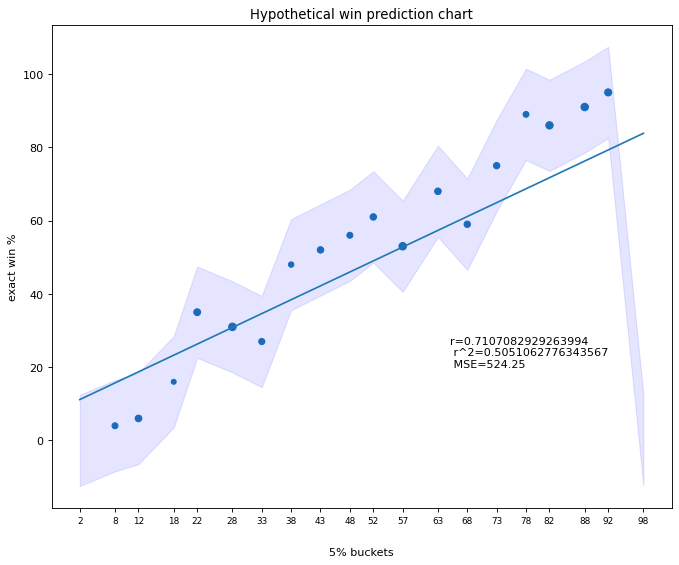

In [66]:
x = half_points
# print(x)
y = actual_win_pct
# print(y)
s = observations
figure(figsize=(10, 8), dpi=80)
plt.scatter(x, y, s=s)
b, m = polyfit(x, y, 1)
# print(b)
# print(m)
line = m*np.array(x)+b
plt.plot(x, line, label=f"y={m}x+{b}")

ci = 1.81 * np.std(y)/np.sqrt(len(x))
plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)


mse = mean_squared_error(y,x)
pearsons_coefficient = np.corrcoef(x, y)
r_score = pearsons_coefficient[0][1]
plt.text(65, 20, f"r={r_score} \n r^2={r_score*r_score} \n MSE={mse}", fontsize=10)
plt.xticks(x, fontsize=8)
plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
plt.ylabel("exact win %")
plt.title("Hypothetical win prediction chart")
plt.show()

In [67]:
models = list(model_results_df["model_v"].unique())
models

['knn_no',
 'knn_rand',
 'knn_up',
 'log_no',
 'log_rand',
 'log_up',
 'rf_no',
 'rf_rand',
 'rf_up',
 'mlp_no',
 'mlp_rand',
 'mlp_up',
 'nn_no',
 'nn_rand',
 'nn_up',
 'mix_no',
 'mix_rand',
 'mix_up',
 'combined']

In [68]:
raw_perms = list(itertools.permutations(models, r=1))
raw_perm_list = list(raw_perms)
# print(raw_perm_list)
clean_perm_list = []
for i in raw_perm_list:
    i_list = list(i)
    
    in_list = False
    if clean_perm_list:
        for x in clean_perm_list:
            print(x)
            if set(x) == set(i_list):
                in_list = True
    print(in_list)
    if in_list == False:
        clean_perm_list.append(i_list)
        
#     print(i_list)
# raw_perms

False
['knn_no']
False
['knn_no']
['knn_rand']
False
['knn_no']
['knn_rand']
['knn_up']
False
['knn_no']
['knn_rand']
['knn_up']
['log_no']
False
['knn_no']
['knn_rand']
['knn_up']
['log_no']
['log_rand']
False
['knn_no']
['knn_rand']
['knn_up']
['log_no']
['log_rand']
['log_up']
False
['knn_no']
['knn_rand']
['knn_up']
['log_no']
['log_rand']
['log_up']
['rf_no']
False
['knn_no']
['knn_rand']
['knn_up']
['log_no']
['log_rand']
['log_up']
['rf_no']
['rf_rand']
False
['knn_no']
['knn_rand']
['knn_up']
['log_no']
['log_rand']
['log_up']
['rf_no']
['rf_rand']
['rf_up']
False
['knn_no']
['knn_rand']
['knn_up']
['log_no']
['log_rand']
['log_up']
['rf_no']
['rf_rand']
['rf_up']
['mlp_no']
False
['knn_no']
['knn_rand']
['knn_up']
['log_no']
['log_rand']
['log_up']
['rf_no']
['rf_rand']
['rf_up']
['mlp_no']
['mlp_rand']
False
['knn_no']
['knn_rand']
['knn_up']
['log_no']
['log_rand']
['log_up']
['rf_no']
['rf_rand']
['rf_up']
['mlp_no']
['mlp_rand']
['mlp_up']
False
['knn_no']
['knn_rand']
['k

In [69]:
clean_perm_list

[['knn_no'],
 ['knn_rand'],
 ['knn_up'],
 ['log_no'],
 ['log_rand'],
 ['log_up'],
 ['rf_no'],
 ['rf_rand'],
 ['rf_up'],
 ['mlp_no'],
 ['mlp_rand'],
 ['mlp_up'],
 ['nn_no'],
 ['nn_rand'],
 ['nn_up'],
 ['mix_no'],
 ['mix_rand'],
 ['mix_up'],
 ['combined']]

['knn_no']
knn_no
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 0 observations
15% to 20%: 0% of 0 observations
20% to 25%: 0% of 1 observations
25% to 30%: 25% of 4 observations
30% to 35%: 64% of 11 observations
35% to 40%: 46% of 28 observations
40% to 45%: 43% of 37 observations
45% to 50%: 56% of 52 observations
50% to 55%: 46% of 78 observations
55% to 60%: 60% of 93 observations
60% to 65%: 57% of 88 observations
65% to 70%: 66% of 110 observations
70% to 75%: 62% of 63 observations
75% to 80%: 52% of 33 observations
80% to 85%: 64% of 28 observations
85% to 90%: 70% of 20 observations
90% to 95%: 71% of 7 observations
95% to 100%: 0% of 0 observations
[11, 28, 37, 52, 78, 93, 88, 110, 63, 33, 28, 20, 7]
[33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88, 92]
[64, 46, 43, 56, 46, 60, 57, 66, 62, 52, 64, 70, 71]


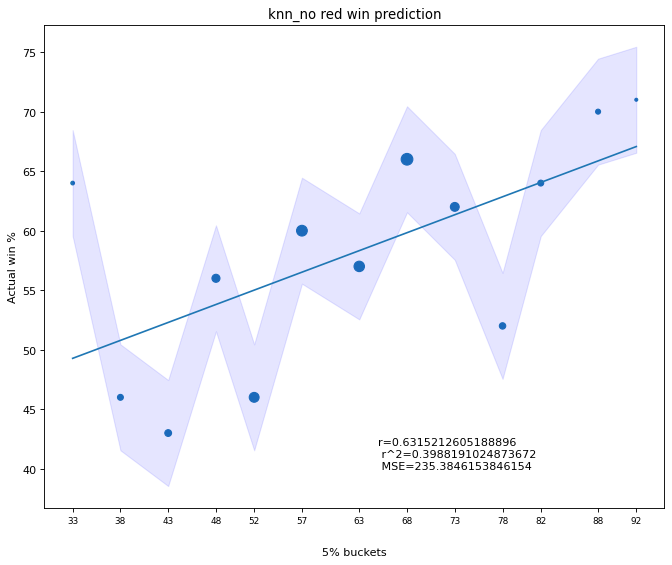

['knn_rand']
knn_rand
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 2 observations
15% to 20%: 50% of 4 observations
20% to 25%: 56% of 7 observations
25% to 30%: 40% of 25 observations
30% to 35%: 41% of 46 observations
35% to 40%: 56% of 78 observations
40% to 45%: 57% of 90 observations
45% to 50%: 57% of 89 observations
50% to 55%: 55% of 80 observations
55% to 60%: 70% of 73 observations
60% to 65%: 57% of 60 observations
65% to 70%: 65% of 48 observations
70% to 75%: 61% of 31 observations
75% to 80%: 53% of 15 observations
80% to 85%: 50% of 4 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[7, 25, 46, 78, 90, 89, 80, 73, 60, 48, 31, 15]
[22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78]
[56, 40, 41, 56, 57, 57, 55, 70, 57, 65, 61, 53]


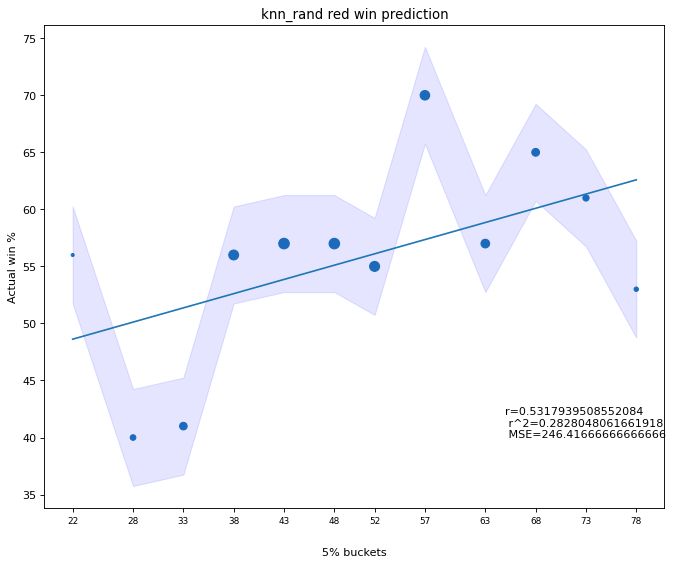

['knn_up']
knn_up
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 2 observations
10% to 15%: 62% of 8 observations
15% to 20%: 50% of 18 observations
20% to 25%: 38% of 29 observations
25% to 30%: 49% of 47 observations
30% to 35%: 53% of 51 observations
35% to 40%: 48% of 79 observations
40% to 45%: 56% of 78 observations
45% to 50%: 56% of 83 observations
50% to 55%: 66% of 65 observations
55% to 60%: 68% of 66 observations
60% to 65%: 57% of 48 observations
65% to 70%: 83% of 24 observations
70% to 75%: 61% of 23 observations
75% to 80%: 59% of 17 observations
80% to 85%: 67% of 3 observations
85% to 90%: 80% of 5 observations
90% to 95%: 100% of 1 observations
95% to 100%: 0% of 0 observations
[8, 18, 29, 47, 51, 79, 78, 83, 65, 66, 48, 24, 23, 17, 5]
[12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 88]
[62, 50, 38, 49, 53, 48, 56, 56, 66, 68, 57, 83, 61, 59, 80]


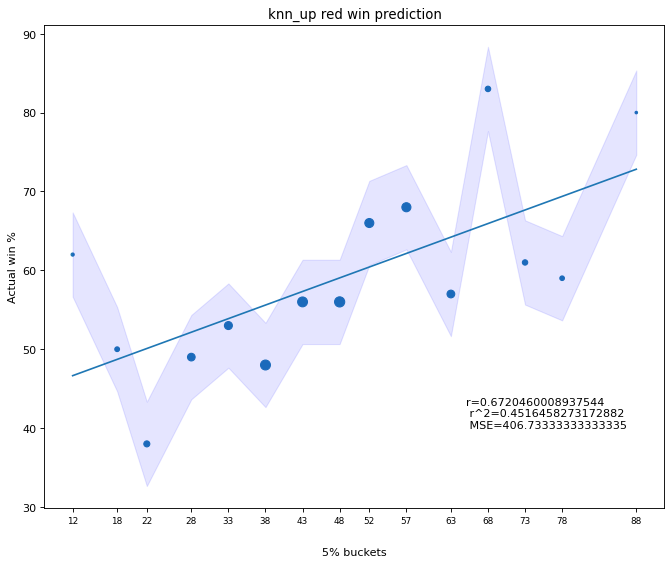

['log_no']
log_no
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 1 observations
15% to 20%: 67% of 3 observations
20% to 25%: 33% of 3 observations
25% to 30%: 14% of 7 observations
30% to 35%: 53% of 17 observations
35% to 40%: 60% of 15 observations
40% to 45%: 50% of 30 observations
45% to 50%: 46% of 35 observations
50% to 55%: 40% of 53 observations
55% to 60%: 52% of 90 observations
60% to 65%: 55% of 58 observations
65% to 70%: 54% of 95 observations
70% to 75%: 61% of 77 observations
75% to 80%: 67% of 63 observations
80% to 85%: 66% of 67 observations
85% to 90%: 84% of 32 observations
90% to 95%: 85% of 20 observations
95% to 100%: 75% of 4 observations
[7, 17, 15, 30, 35, 53, 90, 58, 95, 77, 63, 67, 32, 20]
[28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88, 92]
[14, 53, 60, 50, 46, 40, 52, 55, 54, 61, 67, 66, 84, 85]


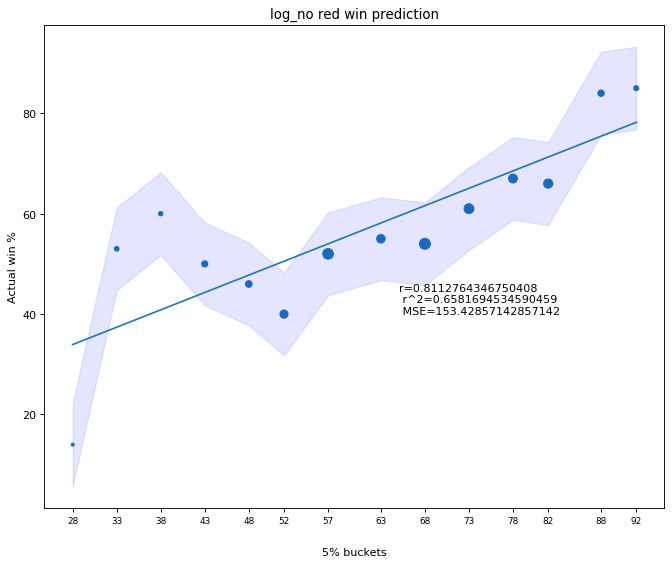

['log_rand']
log_rand
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 2 observations
10% to 15%: 50% of 4 observations
15% to 20%: 33% of 6 observations
20% to 25%: 27% of 15 observations
25% to 30%: 44% of 32 observations
30% to 35%: 38% of 50 observations
35% to 40%: 40% of 57 observations
40% to 45%: 50% of 74 observations
45% to 50%: 57% of 77 observations
50% to 55%: 59% of 71 observations
55% to 60%: 71% of 82 observations
60% to 65%: 65% of 60 observations
65% to 70%: 73% of 62 observations
70% to 75%: 74% of 38 observations
75% to 80%: 80% of 15 observations
80% to 85%: 79% of 14 observations
85% to 90%: 71% of 7 observations
90% to 95%: 67% of 3 observations
95% to 100%: 0% of 0 observations
[6, 15, 32, 50, 57, 74, 77, 71, 82, 60, 62, 38, 15, 14, 7]
[18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88]
[33, 27, 44, 38, 40, 50, 57, 59, 71, 65, 73, 74, 80, 79, 71]


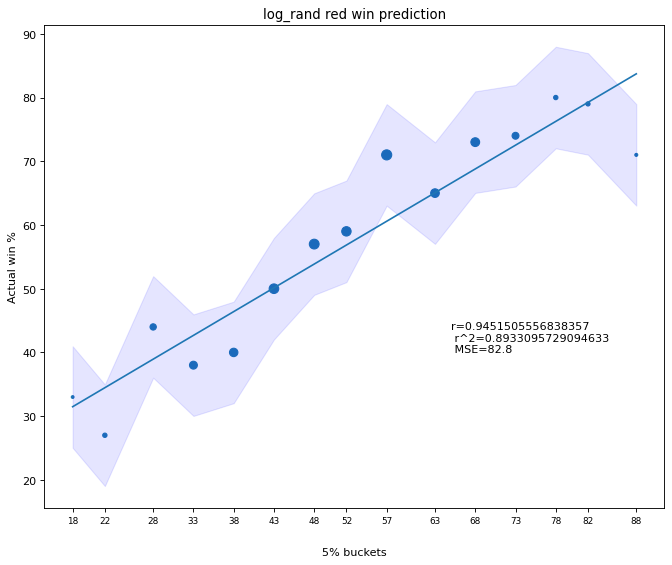

['log_up']
log_up
0% to 5%: 0% of 0 observations
5% to 10%: 33% of 3 observations
10% to 15%: 40% of 10 observations
15% to 20%: 53% of 17 observations
20% to 25%: 40% of 25 observations
25% to 30%: 50% of 36 observations
30% to 35%: 44% of 57 observations
35% to 40%: 50% of 50 observations
40% to 45%: 52% of 60 observations
45% to 50%: 53% of 68 observations
50% to 55%: 54% of 56 observations
55% to 60%: 68% of 82 observations
60% to 65%: 55% of 47 observations
65% to 70%: 57% of 57 observations
70% to 75%: 77% of 31 observations
75% to 80%: 86% of 29 observations
80% to 85%: 70% of 20 observations
85% to 90%: 88% of 8 observations
90% to 95%: 86% of 7 observations
95% to 100%: 100% of 1 observations
[10, 17, 25, 36, 57, 50, 60, 68, 56, 82, 47, 57, 31, 29, 20, 8, 7]
[12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88, 92]
[40, 53, 40, 50, 44, 50, 52, 53, 54, 68, 55, 57, 77, 86, 70, 88, 86]


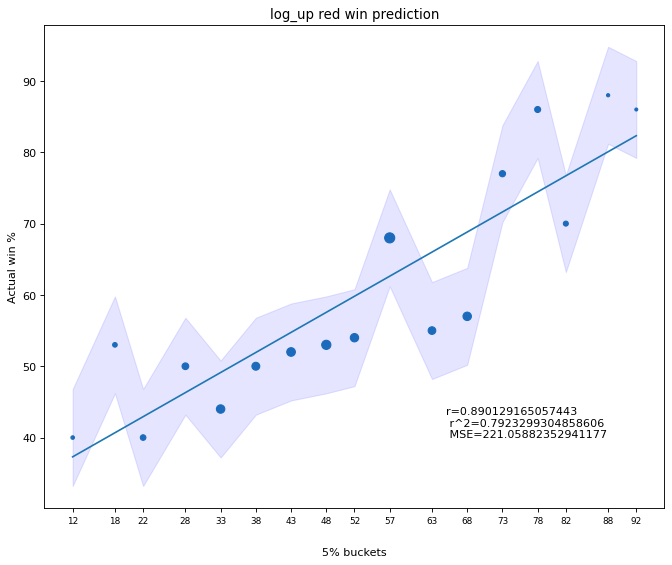

['rf_no']
rf_no
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 0 observations
15% to 20%: 0% of 0 observations
20% to 25%: 0% of 0 observations
25% to 30%: 0% of 0 observations
30% to 35%: 0% of 0 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 55% of 11 observations
50% to 55%: 61% of 59 observations
55% to 60%: 54% of 171 observations
60% to 65%: 59% of 199 observations
65% to 70%: 60% of 187 observations
70% to 75%: 51% of 43 observations
75% to 80%: 33% of 12 observations
80% to 85%: 33% of 3 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[11, 59, 171, 199, 187, 43, 12]
[48, 52, 57, 63, 68, 73, 78]
[55, 61, 54, 59, 60, 51, 33]


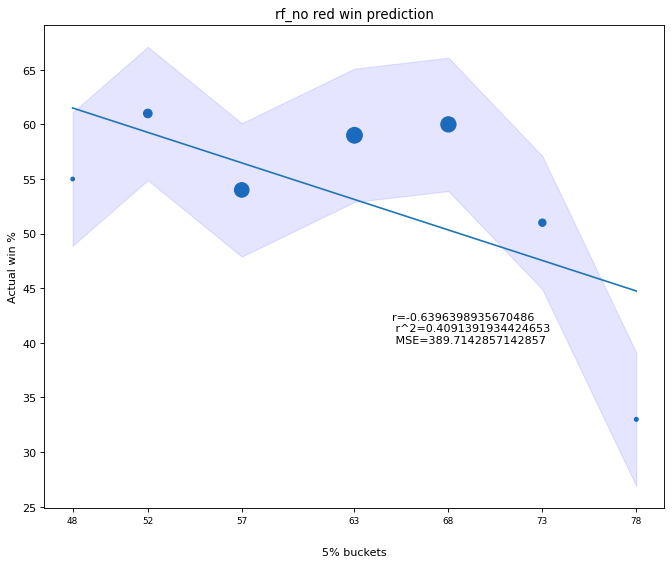

['rf_rand']
rf_rand
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 0 observations
15% to 20%: 0% of 0 observations
20% to 25%: 0% of 0 observations
25% to 30%: 0% of 0 observations
30% to 35%: 36% of 11 observations
35% to 40%: 50% of 36 observations
40% to 45%: 62% of 90 observations
45% to 50%: 60% of 144 observations
50% to 55%: 56% of 182 observations
55% to 60%: 52% of 139 observations
60% to 65%: 63% of 35 observations
65% to 70%: 86% of 14 observations
70% to 75%: 0% of 1 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 1 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[11, 36, 90, 144, 182, 139, 35, 14]
[33, 38, 43, 48, 52, 57, 63, 68]
[36, 50, 62, 60, 56, 52, 63, 86]


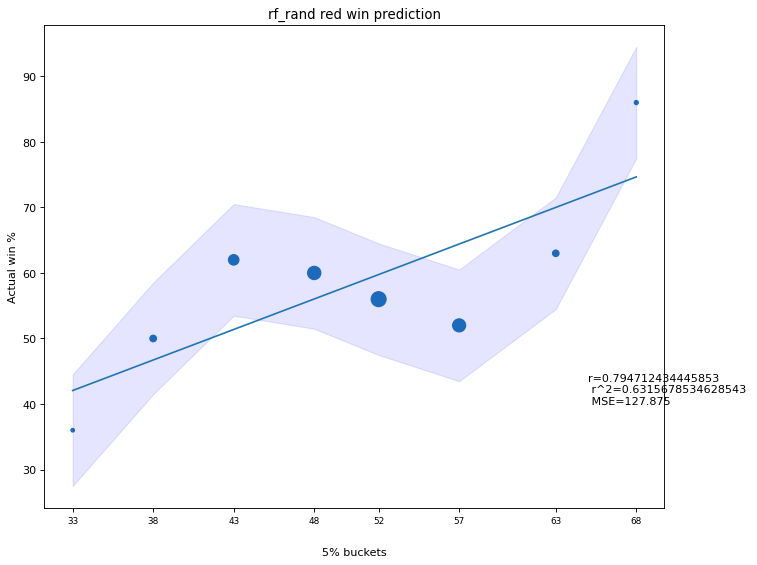

['rf_up']
rf_up
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 0 observations
15% to 20%: 0% of 0 observations
20% to 25%: 0% of 0 observations
25% to 30%: 0% of 0 observations
30% to 35%: 0% of 0 observations
35% to 40%: 0% of 0 observations
40% to 45%: 33% of 3 observations
45% to 50%: 51% of 35 observations
50% to 55%: 55% of 139 observations
55% to 60%: 62% of 231 observations
60% to 65%: 60% of 156 observations
65% to 70%: 49% of 93 observations
70% to 75%: 33% of 15 observations
75% to 80%: 0% of 1 observations
80% to 85%: 100% of 1 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[35, 139, 231, 156, 93, 15]
[48, 52, 57, 63, 68, 73]
[51, 55, 62, 60, 49, 33]


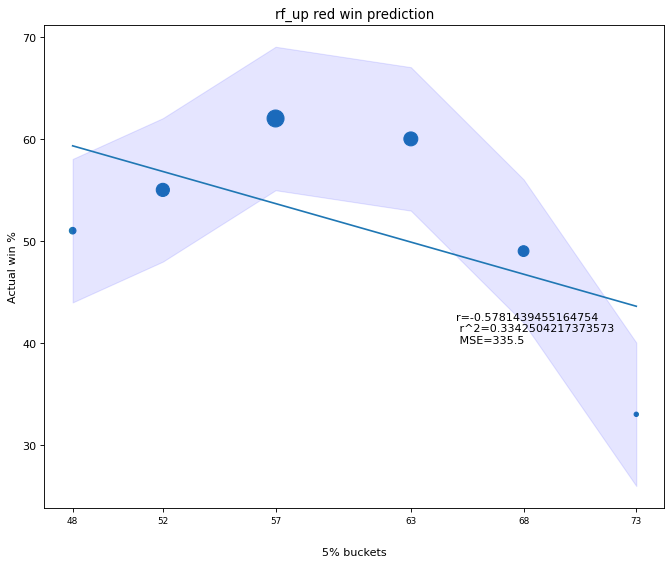

['mlp_no']
mlp_no
0% to 5%: 0% of 0 observations
5% to 10%: 50% of 4 observations
10% to 15%: 36% of 14 observations
15% to 20%: 0% of 7 observations
20% to 25%: 40% of 10 observations
25% to 30%: 45% of 33 observations
30% to 35%: 44% of 25 observations
35% to 40%: 42% of 12 observations
40% to 45%: 46% of 28 observations
45% to 50%: 61% of 31 observations
50% to 55%: 61% of 41 observations
55% to 60%: 60% of 43 observations
60% to 65%: 54% of 48 observations
65% to 70%: 48% of 71 observations
70% to 75%: 48% of 46 observations
75% to 80%: 65% of 55 observations
80% to 85%: 67% of 69 observations
85% to 90%: 76% of 59 observations
90% to 95%: 68% of 59 observations
95% to 100%: 75% of 28 observations
[14, 7, 10, 33, 25, 12, 28, 31, 41, 43, 48, 71, 46, 55, 69, 59, 59, 28]
[12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88, 92, 98]
[36, 0, 40, 45, 44, 42, 46, 61, 61, 60, 54, 48, 48, 65, 67, 76, 68, 75]


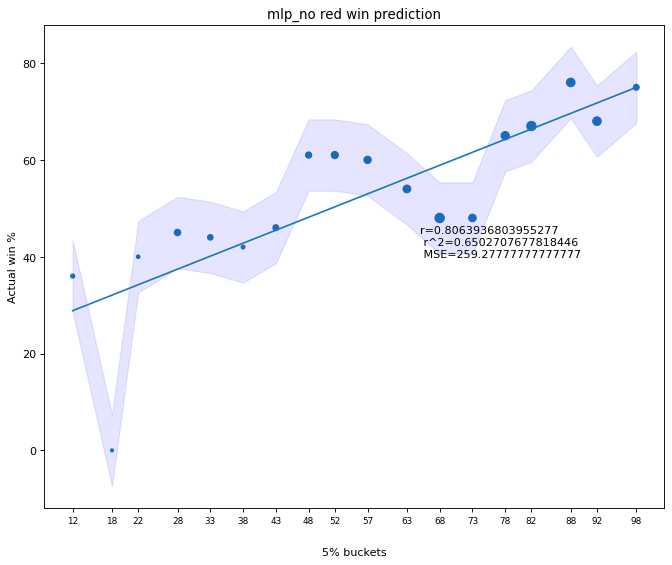

['mlp_rand']
mlp_rand
0% to 5%: 20% of 5 observations
5% to 10%: 20% of 15 observations
10% to 15%: 50% of 28 observations
15% to 20%: 45% of 31 observations
20% to 25%: 53% of 36 observations
25% to 30%: 43% of 44 observations
30% to 35%: 44% of 45 observations
35% to 40%: 56% of 35 observations
40% to 45%: 56% of 39 observations
45% to 50%: 55% of 44 observations
50% to 55%: 51% of 41 observations
55% to 60%: 72% of 46 observations
60% to 65%: 59% of 39 observations
65% to 70%: 56% of 43 observations
70% to 75%: 67% of 33 observations
75% to 80%: 55% of 31 observations
80% to 85%: 79% of 38 observations
85% to 90%: 59% of 22 observations
90% to 95%: 85% of 33 observations
95% to 100%: 82% of 11 observations
[5, 15, 28, 31, 36, 44, 45, 35, 39, 44, 41, 46, 39, 43, 33, 31, 38, 22, 33, 11]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88, 92, 98]
[20, 20, 50, 45, 53, 43, 44, 56, 56, 55, 51, 72, 59, 56, 67, 55, 79, 59, 85, 82]


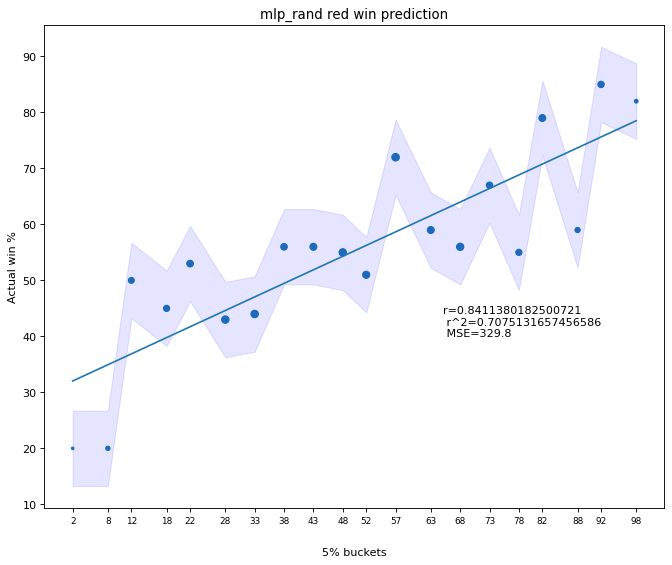

['mlp_up']
mlp_up
0% to 5%: 56% of 7 observations
5% to 10%: 50% of 36 observations
10% to 15%: 53% of 30 observations
15% to 20%: 38% of 16 observations
20% to 25%: 56% of 21 observations
25% to 30%: 42% of 24 observations
30% to 35%: 41% of 27 observations
35% to 40%: 44% of 16 observations
40% to 45%: 59% of 17 observations
45% to 50%: 70% of 37 observations
50% to 55%: 40% of 30 observations
55% to 60%: 60% of 50 observations
60% to 65%: 46% of 26 observations
65% to 70%: 42% of 40 observations
70% to 75%: 74% of 39 observations
75% to 80%: 61% of 38 observations
80% to 85%: 63% of 46 observations
85% to 90%: 60% of 53 observations
90% to 95%: 65% of 54 observations
95% to 100%: 71% of 55 observations
[7, 36, 30, 16, 21, 24, 27, 16, 17, 37, 30, 50, 26, 40, 39, 38, 46, 53, 54, 55]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88, 92, 98]
[56, 50, 53, 38, 56, 42, 41, 44, 59, 70, 40, 60, 46, 42, 74, 61, 63, 60, 65, 71]


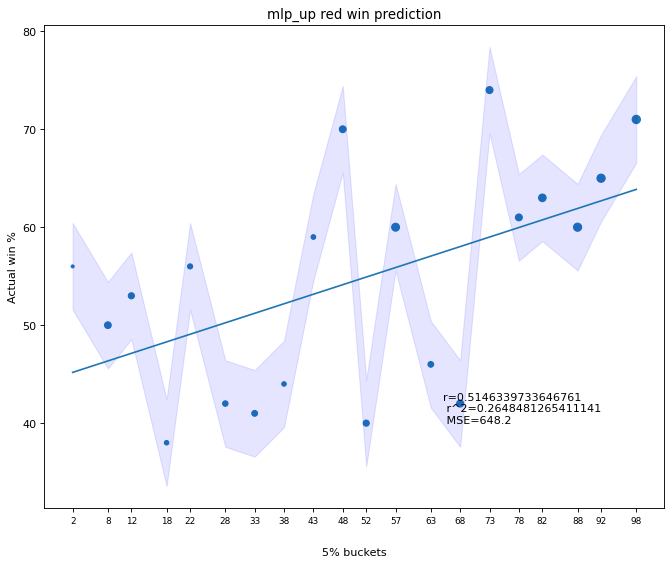

['nn_no']
nn_no
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 33% of 3 observations
15% to 20%: 75% of 4 observations
20% to 25%: 33% of 3 observations
25% to 30%: 17% of 6 observations
30% to 35%: 38% of 16 observations
35% to 40%: 30% of 30 observations
40% to 45%: 38% of 26 observations
45% to 50%: 63% of 38 observations
50% to 55%: 52% of 56 observations
55% to 60%: 46% of 68 observations
60% to 65%: 52% of 61 observations
65% to 70%: 57% of 85 observations
70% to 75%: 57% of 72 observations
75% to 80%: 62% of 60 observations
80% to 85%: 69% of 61 observations
85% to 90%: 72% of 47 observations
90% to 95%: 83% of 35 observations
95% to 100%: 82% of 11 observations
[6, 16, 30, 26, 38, 56, 68, 61, 85, 72, 60, 61, 47, 35, 11]
[28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88, 92, 98]
[17, 38, 30, 38, 63, 52, 46, 52, 57, 57, 62, 69, 72, 83, 82]


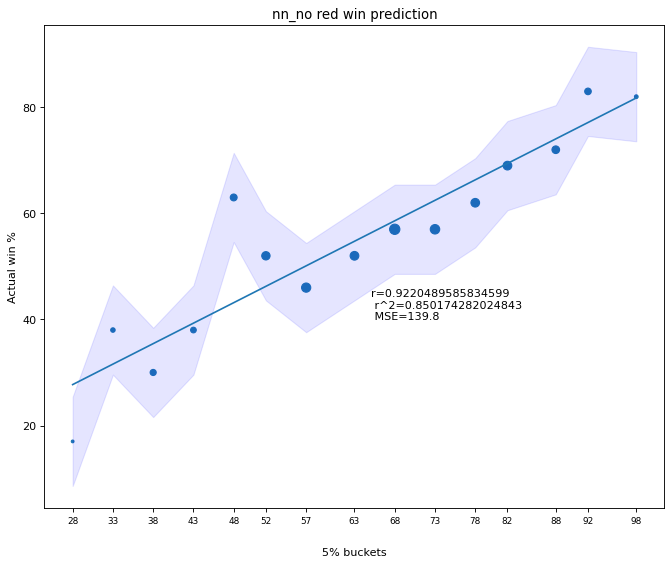

['nn_rand']
nn_rand
0% to 5%: 0% of 1 observations
5% to 10%: 0% of 2 observations
10% to 15%: 28% of 7 observations
15% to 20%: 12% of 8 observations
20% to 25%: 27% of 26 observations
25% to 30%: 44% of 41 observations
30% to 35%: 43% of 54 observations
35% to 40%: 50% of 40 observations
40% to 45%: 45% of 56 observations
45% to 50%: 57% of 71 observations
50% to 55%: 64% of 75 observations
55% to 60%: 68% of 66 observations
60% to 65%: 61% of 51 observations
65% to 70%: 64% of 59 observations
70% to 75%: 78% of 37 observations
75% to 80%: 73% of 37 observations
80% to 85%: 86% of 22 observations
85% to 90%: 83% of 6 observations
90% to 95%: 50% of 4 observations
95% to 100%: 100% of 1 observations
[7, 8, 26, 41, 54, 40, 56, 71, 75, 66, 51, 59, 37, 37, 22, 6]
[12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88]
[28, 12, 27, 44, 43, 50, 45, 57, 64, 68, 61, 64, 78, 73, 86, 83]


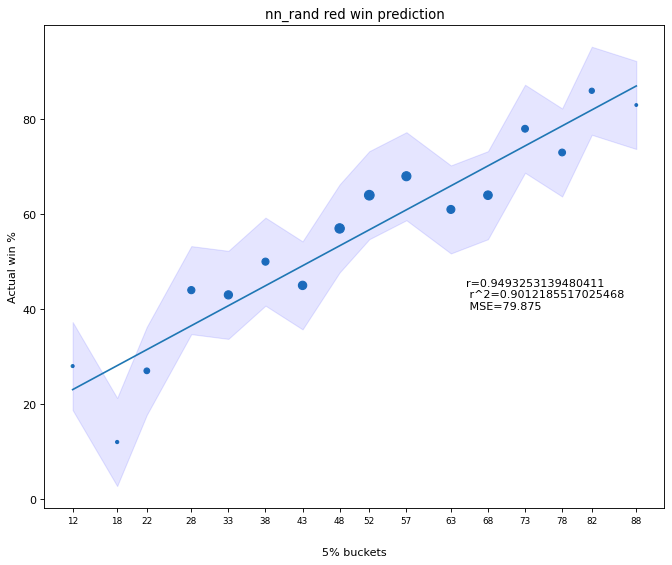

['nn_up']
nn_up
0% to 5%: 25% of 4 observations
5% to 10%: 0% of 4 observations
10% to 15%: 56% of 16 observations
15% to 20%: 55% of 11 observations
20% to 25%: 44% of 25 observations
25% to 30%: 36% of 36 observations
30% to 35%: 59% of 49 observations
35% to 40%: 45% of 33 observations
40% to 45%: 54% of 39 observations
45% to 50%: 56% of 48 observations
50% to 55%: 56% of 42 observations
55% to 60%: 62% of 48 observations
60% to 65%: 51% of 51 observations
65% to 70%: 51% of 61 observations
70% to 75%: 63% of 38 observations
75% to 80%: 69% of 35 observations
80% to 85%: 75% of 48 observations
85% to 90%: 68% of 28 observations
90% to 95%: 66% of 32 observations
95% to 100%: 91% of 11 observations
[16, 11, 25, 36, 49, 33, 39, 48, 42, 48, 51, 61, 38, 35, 48, 28, 32, 11]
[12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88, 92, 98]
[56, 55, 44, 36, 59, 45, 54, 56, 56, 62, 51, 51, 63, 69, 75, 68, 66, 91]


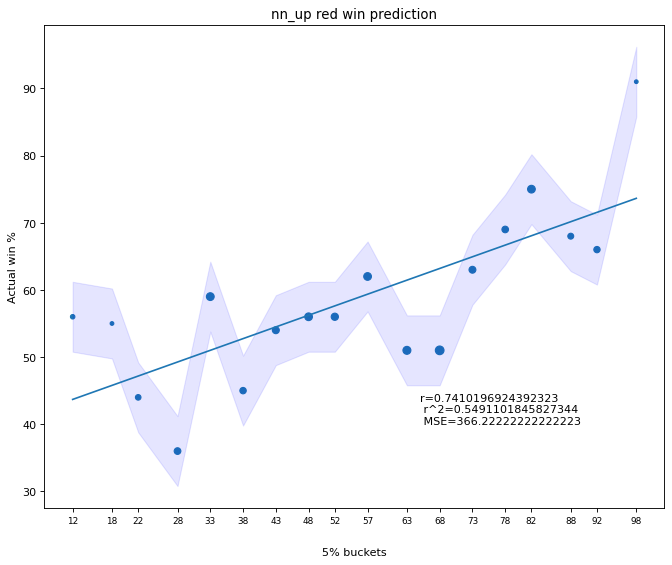

['mix_no']
mix_no
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 0 observations
15% to 20%: 0% of 0 observations
20% to 25%: 0% of 0 observations
25% to 30%: 0% of 0 observations
30% to 35%: 60% of 5 observations
35% to 40%: 33% of 9 observations
40% to 45%: 42% of 33 observations
45% to 50%: 53% of 40 observations
50% to 55%: 45% of 64 observations
55% to 60%: 50% of 107 observations
60% to 65%: 52% of 104 observations
65% to 70%: 54% of 128 observations
70% to 75%: 72% of 95 observations
75% to 80%: 70% of 60 observations
80% to 85%: 88% of 34 observations
85% to 90%: 69% of 13 observations
90% to 95%: 75% of 4 observations
95% to 100%: 0% of 0 observations
[5, 9, 33, 40, 64, 107, 104, 128, 95, 60, 34, 13]
[33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88]
[60, 33, 42, 53, 45, 50, 52, 54, 72, 70, 88, 69]


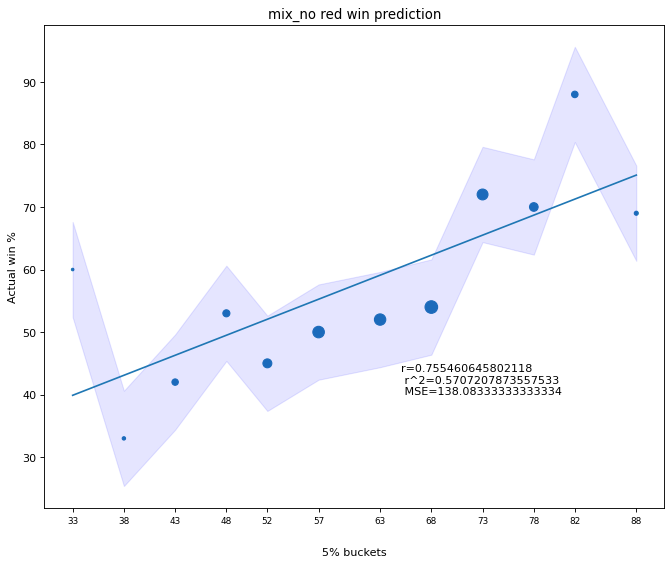

['mix_rand']
mix_rand
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 0 observations
15% to 20%: 0% of 2 observations
20% to 25%: 33% of 6 observations
25% to 30%: 28% of 14 observations
30% to 35%: 38% of 45 observations
35% to 40%: 36% of 61 observations
40% to 45%: 49% of 101 observations
45% to 50%: 61% of 96 observations
50% to 55%: 64% of 86 observations
55% to 60%: 66% of 95 observations
60% to 65%: 64% of 56 observations
65% to 70%: 84% of 50 observations
70% to 75%: 60% of 20 observations
75% to 80%: 80% of 15 observations
80% to 85%: 75% of 4 observations
85% to 90%: 100% of 2 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[6, 14, 45, 61, 101, 96, 86, 95, 56, 50, 20, 15]
[22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78]
[33, 28, 38, 36, 49, 61, 64, 66, 64, 84, 60, 80]


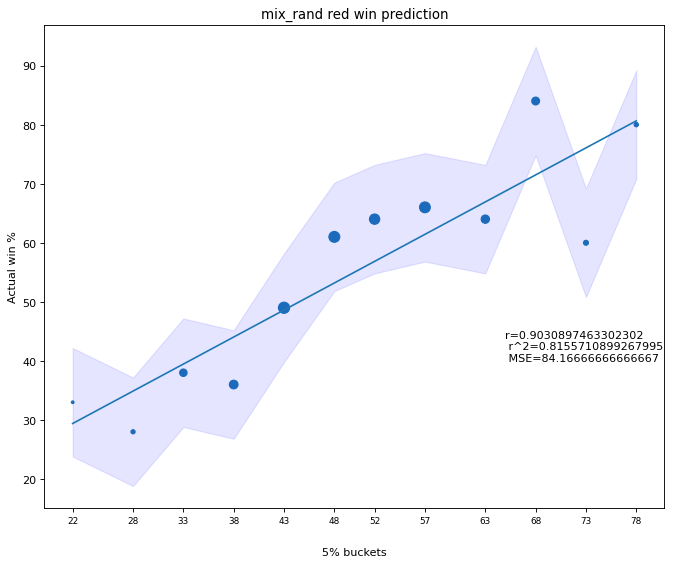

['mix_up']
mix_up
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 0 observations
15% to 20%: 0% of 0 observations
20% to 25%: 0% of 0 observations
25% to 30%: 0% of 1 observations
30% to 35%: 38% of 16 observations
35% to 40%: 42% of 19 observations
40% to 45%: 46% of 48 observations
45% to 50%: 48% of 97 observations
50% to 55%: 55% of 102 observations
55% to 60%: 56% of 137 observations
60% to 65%: 55% of 89 observations
65% to 70%: 69% of 71 observations
70% to 75%: 86% of 50 observations
75% to 80%: 65% of 26 observations
80% to 85%: 75% of 8 observations
85% to 90%: 50% of 4 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[16, 19, 48, 97, 102, 137, 89, 71, 50, 26, 8]
[33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82]
[38, 42, 46, 48, 55, 56, 55, 69, 86, 65, 75]


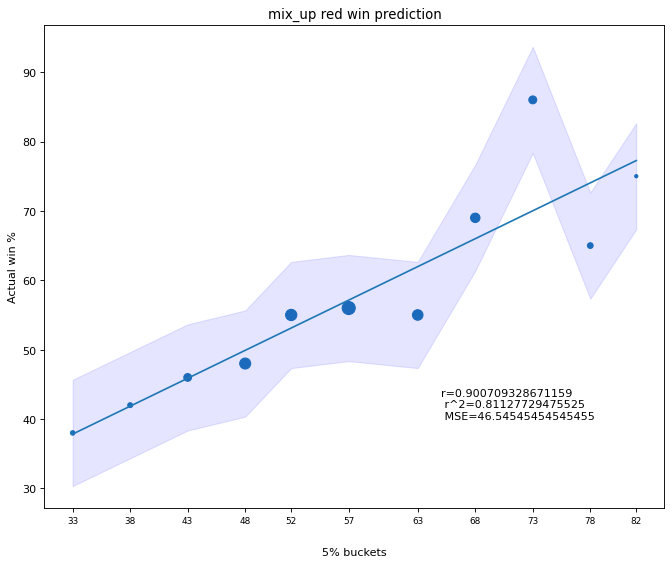

['combined']
combined
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 0 observations
15% to 20%: 0% of 0 observations
20% to 25%: 0% of 2 observations
25% to 30%: 50% of 2 observations
30% to 35%: 22% of 9 observations
35% to 40%: 40% of 25 observations
40% to 45%: 46% of 59 observations
45% to 50%: 42% of 103 observations
50% to 55%: 56% of 91 observations
55% to 60%: 57% of 131 observations
60% to 65%: 60% of 90 observations
65% to 70%: 74% of 97 observations
70% to 75%: 86% of 37 observations
75% to 80%: 71% of 17 observations
80% to 85%: 56% of 7 observations
85% to 90%: 100% of 2 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[9, 25, 59, 103, 91, 131, 90, 97, 37, 17, 7]
[33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82]
[22, 40, 46, 42, 56, 57, 60, 74, 86, 71, 56]


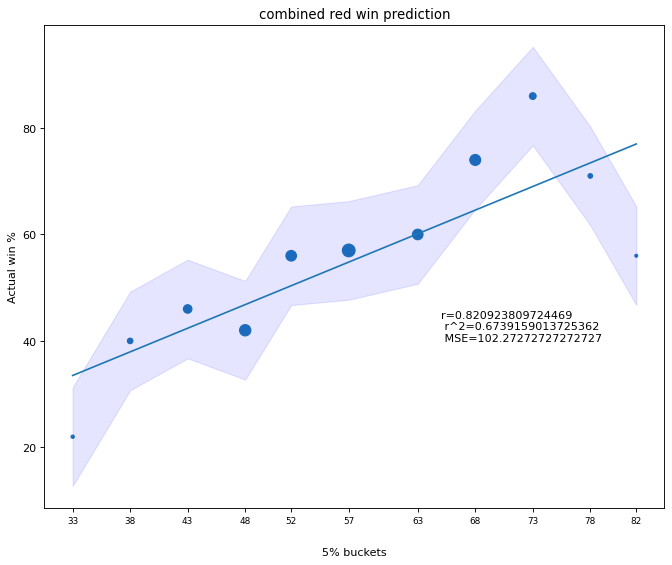

In [70]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
    print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["red_total_pct"] >= x]
        point_to_point = point_up[point_up["red_total_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_winner"] == "red"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

    print(observations)
    print(half_points)
    print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
    plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual win %")
    plt.title(f"{perm_str} red win prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)
    
    

    
    
        


In [71]:
print(model_combo)

['knn_no', 'knn_rand', 'knn_up', 'log_no', 'log_rand', 'log_up', 'rf_no', 'rf_rand', 'rf_up', 'mlp_no', 'mlp_rand', 'mlp_up', 'nn_no', 'nn_rand', 'nn_up', 'mix_no', 'mix_rand', 'mix_up', 'combined']


In [72]:
# print(len(clean_perm_list))
# print(len(model_combo))
# print(len(r))
# print(len(r_squared))
# print(len(m_squared))
red_win_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

red_win_df = pd.DataFrame(red_win_dict)
red_win_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.631521   0.398819    235.384615
1     knn_rand  0.531794   0.282805    246.416667
2       knn_up  0.672046   0.451646    406.733333
3       log_no  0.811276   0.658169    153.428571
4     log_rand  0.945151   0.893310     82.800000
5       log_up  0.890129   0.792330    221.058824
6        rf_no -0.639640   0.409139    389.714286
7      rf_rand  0.794712   0.631568    127.875000
8        rf_up -0.578144   0.334250    335.500000
9       mlp_no  0.806394   0.650271    259.277778
10    mlp_rand  0.841138   0.707513    329.800000
11      mlp_up  0.514634   0.264848    648.200000
12       nn_no  0.922049   0.850174    139.800000
13     nn_rand  0.949325   0.901219     79.875000
14       nn_up  0.741020   0.549110    366.222222
15      mix_no  0.755461   0.570721    138.083333
16    mix_rand  0.903090   0.815571     84.166667
17      mix_up  0.900709   0.811277     46.545455
18    combined  0.820924   0.673916    102.272727

['knn_no']
knn_no
0% to 5%: 50% of 4 observations
5% to 10%: 50% of 2 observations
10% to 15%: 30% of 20 observations
15% to 20%: 36% of 28 observations
20% to 25%: 48% of 33 observations
25% to 30%: 38% of 63 observations
30% to 35%: 34% of 110 observations
35% to 40%: 42% of 88 observations
40% to 45%: 40% of 93 observations
45% to 50%: 54% of 78 observations
50% to 55%: 44% of 52 observations
55% to 60%: 56% of 37 observations
60% to 65%: 54% of 28 observations
65% to 70%: 36% of 11 observations
70% to 75%: 75% of 4 observations
75% to 80%: 100% of 1 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[20, 28, 33, 63, 110, 88, 93, 78, 52, 37, 28, 11]
[12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68]
[30, 36, 48, 38, 34, 42, 40, 54, 44, 56, 54, 36]


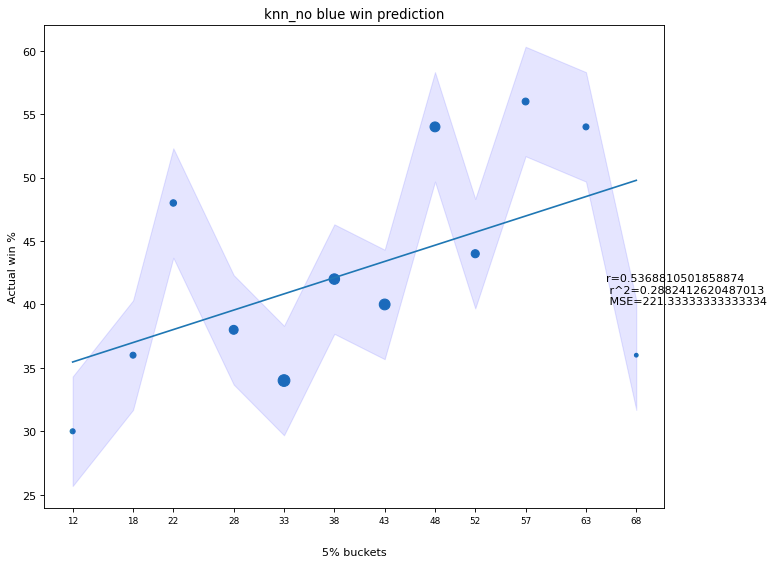

['knn_rand']
knn_rand
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 0 observations
15% to 20%: 50% of 4 observations
20% to 25%: 47% of 15 observations
25% to 30%: 39% of 31 observations
30% to 35%: 35% of 48 observations
35% to 40%: 42% of 60 observations
40% to 45%: 30% of 73 observations
45% to 50%: 45% of 80 observations
50% to 55%: 42% of 89 observations
55% to 60%: 42% of 90 observations
60% to 65%: 44% of 78 observations
65% to 70%: 59% of 46 observations
70% to 75%: 60% of 25 observations
75% to 80%: 43% of 7 observations
80% to 85%: 50% of 4 observations
85% to 90%: 100% of 2 observations
90% to 95%: 100% of 1 observations
95% to 100%: 0% of 0 observations
[15, 31, 48, 60, 73, 80, 89, 90, 78, 46, 25, 7]
[22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78]
[47, 39, 35, 42, 30, 45, 42, 42, 44, 59, 60, 43]


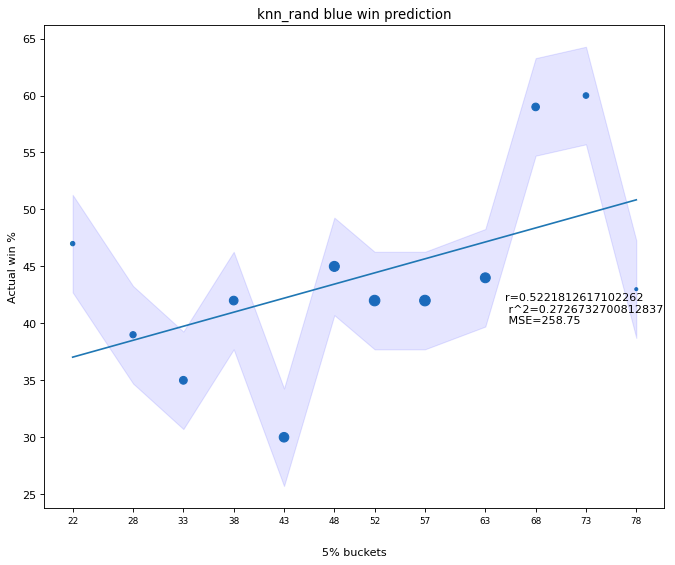

['knn_up']
knn_up
0% to 5%: 60% of 5 observations
5% to 10%: 0% of 1 observations
10% to 15%: 20% of 5 observations
15% to 20%: 33% of 3 observations
20% to 25%: 41% of 17 observations
25% to 30%: 39% of 23 observations
30% to 35%: 17% of 24 observations
35% to 40%: 42% of 48 observations
40% to 45%: 32% of 66 observations
45% to 50%: 34% of 65 observations
50% to 55%: 43% of 83 observations
55% to 60%: 44% of 78 observations
60% to 65%: 52% of 79 observations
65% to 70%: 47% of 51 observations
70% to 75%: 51% of 47 observations
75% to 80%: 62% of 29 observations
80% to 85%: 50% of 18 observations
85% to 90%: 38% of 8 observations
90% to 95%: 100% of 2 observations
95% to 100%: 0% of 0 observations
[5, 5, 17, 23, 24, 48, 66, 65, 83, 78, 79, 51, 47, 29, 18, 8]
[2, 12, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88]
[60, 20, 41, 39, 17, 42, 32, 34, 43, 44, 52, 47, 51, 62, 50, 38]


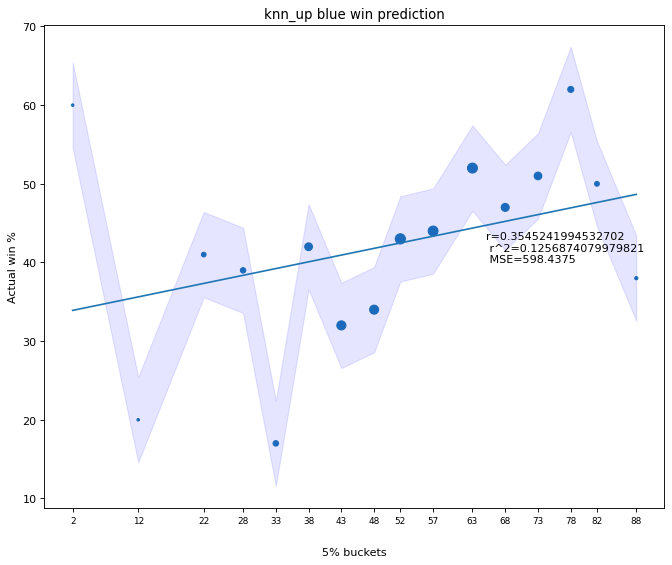

['log_no']
log_no
0% to 5%: 25% of 4 observations
5% to 10%: 18% of 17 observations
10% to 15%: 18% of 45 observations
15% to 20%: 35% of 43 observations
20% to 25%: 34% of 65 observations
25% to 30%: 39% of 77 observations
30% to 35%: 44% of 70 observations
35% to 40%: 44% of 50 observations
40% to 45%: 45% of 73 observations
45% to 50%: 63% of 60 observations
50% to 55%: 50% of 40 observations
55% to 60%: 51% of 35 observations
60% to 65%: 43% of 21 observations
65% to 70%: 47% of 19 observations
70% to 75%: 86% of 7 observations
75% to 80%: 67% of 3 observations
80% to 85%: 33% of 3 observations
85% to 90%: 100% of 1 observations
90% to 95%: 100% of 1 observations
95% to 100%: 0% of 0 observations
[17, 45, 43, 65, 77, 70, 50, 73, 60, 40, 35, 21, 19, 7]
[8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73]
[18, 18, 35, 34, 39, 44, 44, 45, 63, 50, 51, 43, 47, 86]


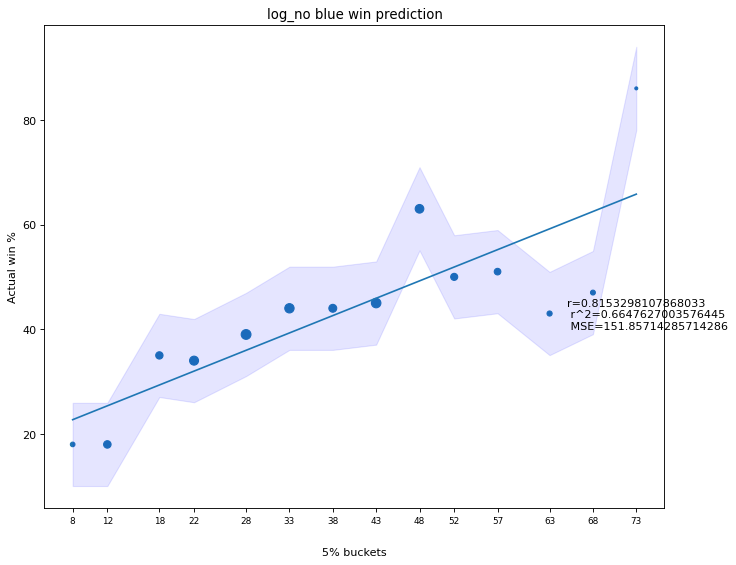

['log_rand']
log_rand
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 2 observations
10% to 15%: 28% of 7 observations
15% to 20%: 20% of 10 observations
20% to 25%: 20% of 15 observations
25% to 30%: 26% of 38 observations
30% to 35%: 27% of 55 observations
35% to 40%: 38% of 42 observations
40% to 45%: 33% of 72 observations
45% to 50%: 35% of 62 observations
50% to 55%: 42% of 90 observations
55% to 60%: 47% of 80 observations
60% to 65%: 56% of 68 observations
65% to 70%: 64% of 56 observations
70% to 75%: 56% of 32 observations
75% to 80%: 67% of 18 observations
80% to 85%: 67% of 9 observations
85% to 90%: 50% of 2 observations
90% to 95%: 100% of 2 observations
95% to 100%: 0% of 0 observations
[7, 10, 15, 38, 55, 42, 72, 62, 90, 80, 68, 56, 32, 18, 9]
[12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82]
[28, 20, 20, 26, 27, 38, 33, 35, 42, 47, 56, 64, 56, 67, 67]


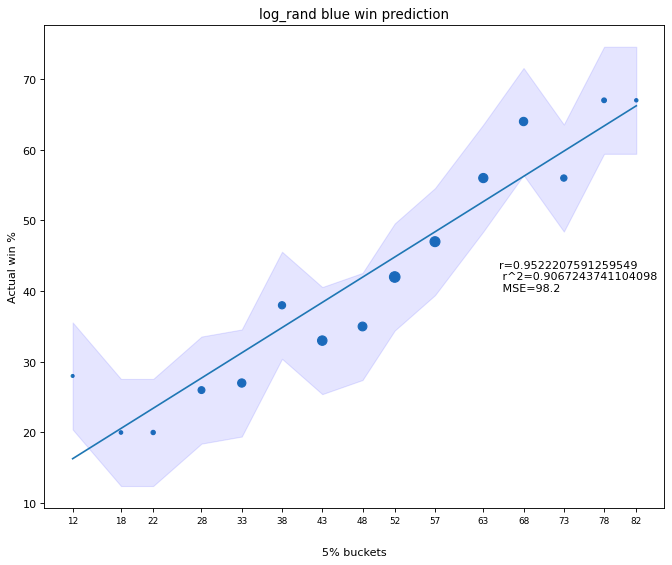

['log_up']
log_up
0% to 5%: 0% of 1 observations
5% to 10%: 17% of 6 observations
10% to 15%: 10% of 10 observations
15% to 20%: 33% of 15 observations
20% to 25%: 11% of 28 observations
25% to 30%: 23% of 31 observations
30% to 35%: 40% of 48 observations
35% to 40%: 51% of 35 observations
40% to 45%: 34% of 71 observations
45% to 50%: 41% of 56 observations
50% to 55%: 49% of 65 observations
55% to 60%: 46% of 74 observations
60% to 65%: 52% of 67 observations
65% to 70%: 53% of 62 observations
70% to 75%: 50% of 36 observations
75% to 80%: 52% of 29 observations
80% to 85%: 56% of 25 observations
85% to 90%: 50% of 6 observations
90% to 95%: 50% of 4 observations
95% to 100%: 0% of 0 observations
[6, 10, 15, 28, 31, 48, 35, 71, 56, 65, 74, 67, 62, 36, 29, 25, 6]
[8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88]
[17, 10, 33, 11, 23, 40, 51, 34, 41, 49, 46, 52, 53, 50, 52, 56, 50]


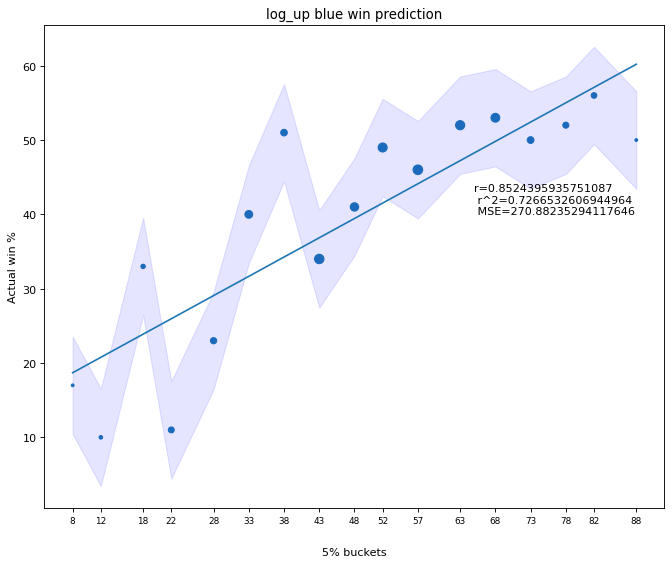

['rf_no']
rf_no
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 0 observations
15% to 20%: 50% of 2 observations
20% to 25%: 67% of 12 observations
25% to 30%: 49% of 43 observations
30% to 35%: 41% of 169 observations
35% to 40%: 40% of 167 observations
40% to 45%: 49% of 151 observations
45% to 50%: 33% of 72 observations
50% to 55%: 50% of 18 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[12, 43, 169, 167, 151, 72, 18]
[22, 28, 33, 38, 43, 48, 52]
[67, 49, 41, 40, 49, 33, 50]


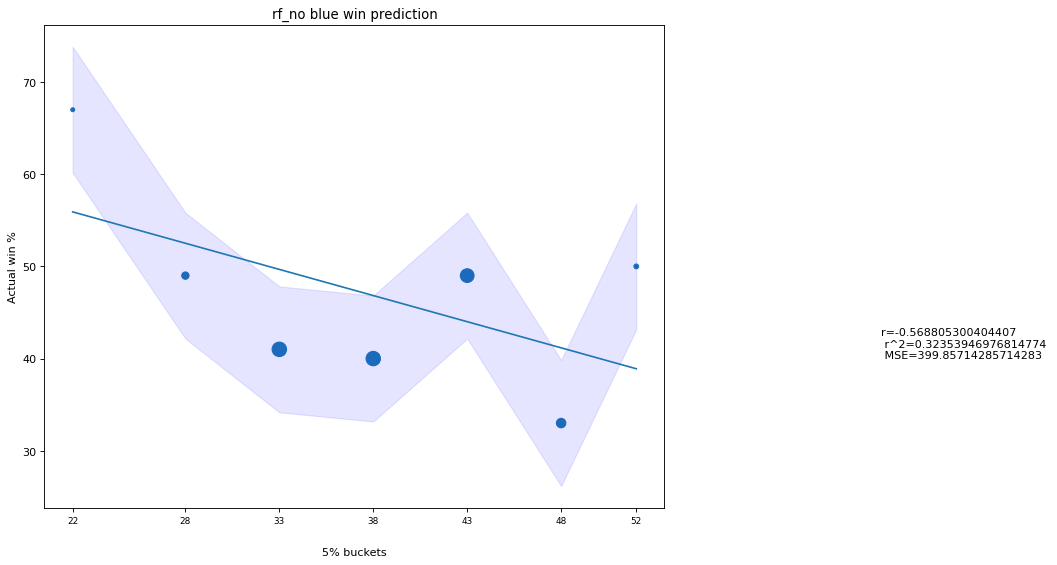

['rf_rand']
rf_rand
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 0 observations
15% to 20%: 0% of 0 observations
20% to 25%: 100% of 1 observations
25% to 30%: 100% of 1 observations
30% to 35%: 8% of 13 observations
35% to 40%: 39% of 33 observations
40% to 45%: 48% of 114 observations
45% to 50%: 44% of 169 observations
50% to 55%: 43% of 150 observations
55% to 60%: 35% of 122 observations
60% to 65%: 50% of 38 observations
65% to 70%: 57% of 12 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[13, 33, 114, 169, 150, 122, 38, 12]
[33, 38, 43, 48, 52, 57, 63, 68]
[8, 39, 48, 44, 43, 35, 50, 57]


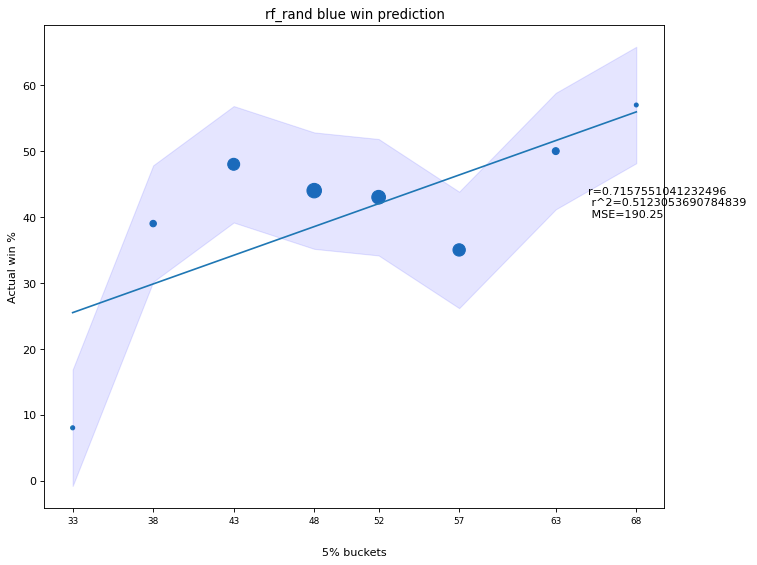

['rf_up']
rf_up
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 0 observations
15% to 20%: 0% of 0 observations
20% to 25%: 50% of 2 observations
25% to 30%: 67% of 15 observations
30% to 35%: 50% of 84 observations
35% to 40%: 40% of 134 observations
40% to 45%: 36% of 191 observations
45% to 50%: 43% of 160 observations
50% to 55%: 55% of 51 observations
55% to 60%: 33% of 6 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[15, 84, 134, 191, 160, 51, 6]
[28, 33, 38, 43, 48, 52, 57]
[67, 50, 40, 36, 43, 55, 33]


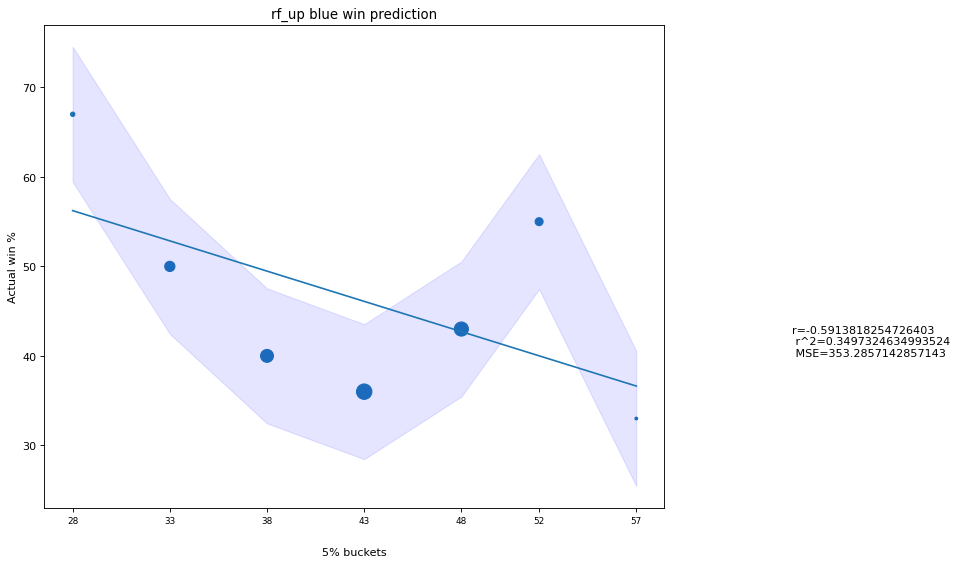

['mlp_no']
mlp_no
0% to 5%: 23% of 30 observations
5% to 10%: 39% of 46 observations
10% to 15%: 27% of 71 observations
15% to 20%: 25% of 40 observations
20% to 25%: 39% of 59 observations
25% to 30%: 52% of 46 observations
30% to 35%: 47% of 62 observations
35% to 40%: 47% of 38 observations
40% to 45%: 36% of 36 observations
45% to 50%: 41% of 39 observations
50% to 55%: 35% of 34 observations
55% to 60%: 56% of 34 observations
60% to 65%: 52% of 23 observations
65% to 70%: 50% of 28 observations
70% to 75%: 55% of 33 observations
75% to 80%: 64% of 14 observations
80% to 85%: 91% of 11 observations
85% to 90%: 64% of 11 observations
90% to 95%: 50% of 4 observations
95% to 100%: 0% of 0 observations
[30, 46, 71, 40, 59, 46, 62, 38, 36, 39, 34, 34, 23, 28, 33, 14, 11, 11]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88]
[23, 39, 27, 25, 39, 52, 47, 47, 36, 41, 35, 56, 52, 50, 55, 64, 91, 64]


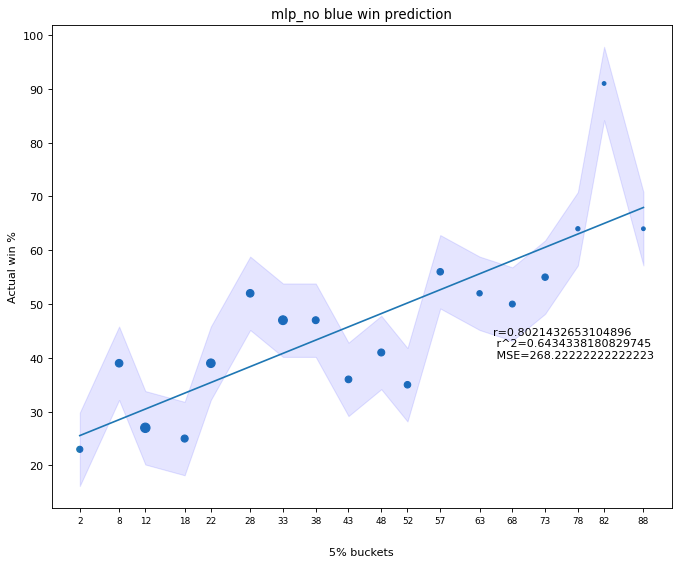

['mlp_rand']
mlp_rand
0% to 5%: 18% of 11 observations
5% to 10%: 13% of 30 observations
10% to 15%: 43% of 28 observations
15% to 20%: 15% of 26 observations
20% to 25%: 38% of 32 observations
25% to 30%: 33% of 33 observations
30% to 35%: 41% of 34 observations
35% to 40%: 41% of 34 observations
40% to 45%: 26% of 35 observations
45% to 50%: 41% of 41 observations
50% to 55%: 51% of 43 observations
55% to 60%: 43% of 51 observations
60% to 65%: 44% of 41 observations
65% to 70%: 53% of 51 observations
70% to 75%: 56% of 44 observations
75% to 80%: 49% of 39 observations
80% to 85%: 54% of 41 observations
85% to 90%: 48% of 23 observations
90% to 95%: 67% of 21 observations
95% to 100%: 75% of 4 observations
[11, 30, 28, 26, 32, 33, 34, 34, 35, 41, 43, 51, 41, 51, 44, 39, 41, 23, 21]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88, 92]
[18, 13, 43, 15, 38, 33, 41, 41, 26, 41, 51, 43, 44, 53, 56, 49, 54, 48, 67]


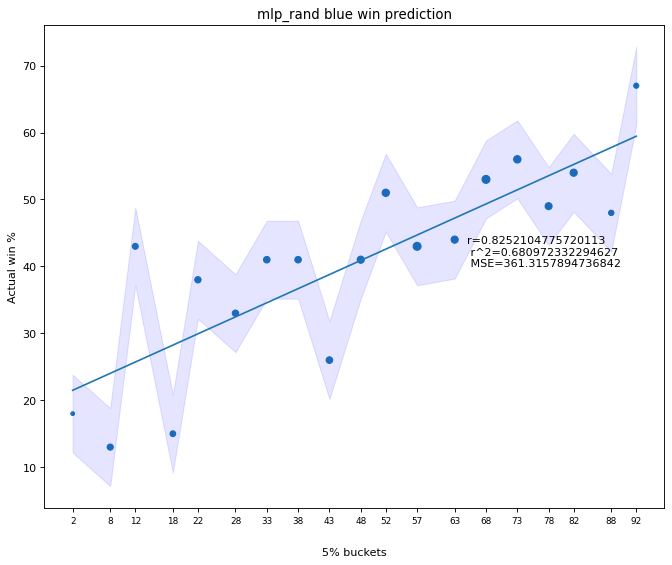

['mlp_up']
mlp_up
0% to 5%: 27% of 62 observations
5% to 10%: 35% of 43 observations
10% to 15%: 41% of 64 observations
15% to 20%: 34% of 29 observations
20% to 25%: 43% of 35 observations
25% to 30%: 26% of 39 observations
30% to 35%: 56% of 34 observations
35% to 40%: 54% of 24 observations
40% to 45%: 42% of 43 observations
45% to 50%: 55% of 33 observations
50% to 55%: 33% of 33 observations
55% to 60%: 36% of 25 observations
60% to 65%: 60% of 20 observations
65% to 70%: 53% of 32 observations
70% to 75%: 57% of 24 observations
75% to 80%: 46% of 26 observations
80% to 85%: 50% of 24 observations
85% to 90%: 55% of 22 observations
90% to 95%: 53% of 40 observations
95% to 100%: 43% of 7 observations
[62, 43, 64, 29, 35, 39, 34, 24, 43, 33, 33, 25, 20, 32, 24, 26, 24, 22, 40, 7]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88, 92, 98]
[27, 35, 41, 34, 43, 26, 56, 54, 42, 55, 33, 36, 60, 53, 57, 46, 50, 55, 53, 43]


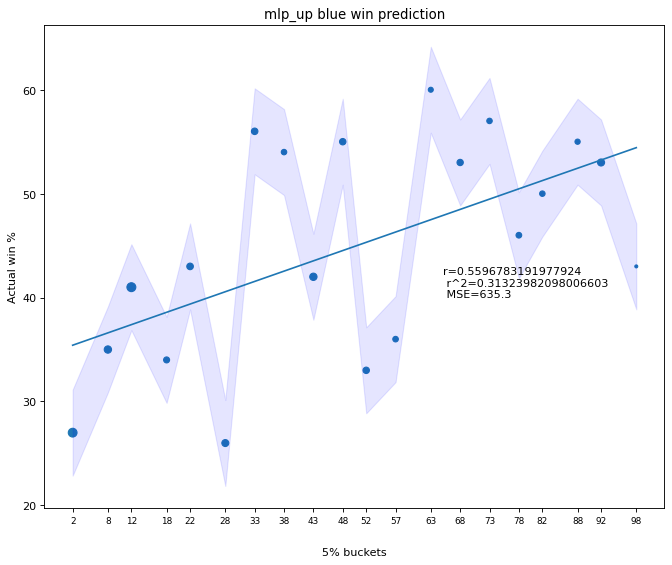

['nn_no']
nn_no
0% to 5%: 17% of 12 observations
5% to 10%: 19% of 26 observations
10% to 15%: 27% of 56 observations
15% to 20%: 35% of 43 observations
20% to 25%: 31% of 58 observations
25% to 30%: 42% of 72 observations
30% to 35%: 46% of 69 observations
35% to 40%: 45% of 49 observations
40% to 45%: 56% of 60 observations
45% to 50%: 46% of 50 observations
50% to 55%: 43% of 46 observations
55% to 60%: 53% of 32 observations
60% to 65%: 70% of 30 observations
65% to 70%: 65% of 17 observations
70% to 75%: 83% of 6 observations
75% to 80%: 33% of 3 observations
80% to 85%: 50% of 6 observations
85% to 90%: 67% of 3 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[12, 26, 56, 43, 58, 72, 69, 49, 60, 50, 46, 32, 30, 17, 6, 6]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 82]
[17, 19, 27, 35, 31, 42, 46, 45, 56, 46, 43, 53, 70, 65, 83, 50]


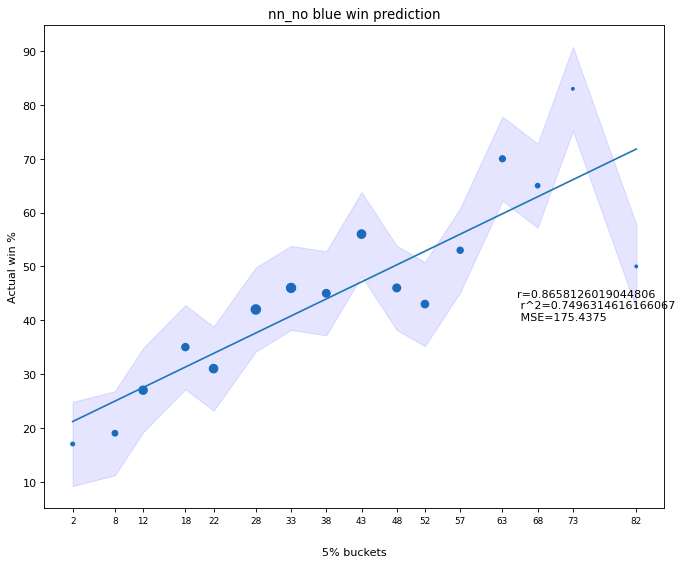

['nn_rand']
nn_rand
0% to 5%: 0% of 1 observations
5% to 10%: 33% of 3 observations
10% to 15%: 17% of 12 observations
15% to 20%: 14% of 14 observations
20% to 25%: 26% of 34 observations
25% to 30%: 22% of 37 observations
30% to 35%: 40% of 50 observations
35% to 40%: 40% of 40 observations
40% to 45%: 32% of 53 observations
45% to 50%: 35% of 75 observations
50% to 55%: 41% of 71 observations
55% to 60%: 54% of 69 observations
60% to 65%: 50% of 48 observations
65% to 70%: 57% of 59 observations
70% to 75%: 56% of 41 observations
75% to 80%: 68% of 28 observations
80% to 85%: 91% of 11 observations
85% to 90%: 71% of 7 observations
90% to 95%: 100% of 2 observations
95% to 100%: 100% of 1 observations
[12, 14, 34, 37, 50, 40, 53, 75, 71, 69, 48, 59, 41, 28, 11, 7]
[12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88]
[17, 14, 26, 22, 40, 40, 32, 35, 41, 54, 50, 57, 56, 68, 91, 71]


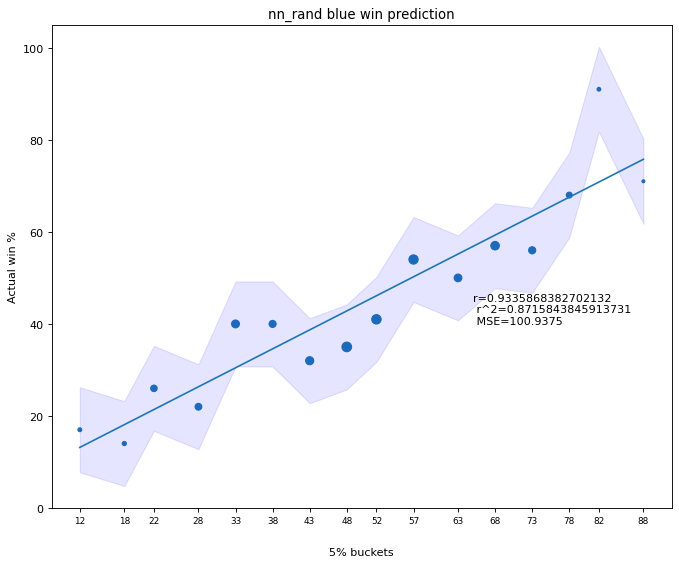

['nn_up']
nn_up
0% to 5%: 9% of 11 observations
5% to 10%: 33% of 30 observations
10% to 15%: 31% of 35 observations
15% to 20%: 33% of 27 observations
20% to 25%: 26% of 42 observations
25% to 30%: 37% of 38 observations
30% to 35%: 48% of 52 observations
35% to 40%: 48% of 42 observations
40% to 45%: 36% of 39 observations
45% to 50%: 44% of 39 observations
50% to 55%: 44% of 50 observations
55% to 60%: 45% of 49 observations
60% to 65%: 50% of 42 observations
65% to 70%: 40% of 60 observations
70% to 75%: 64% of 36 observations
75% to 80%: 62% of 29 observations
80% to 85%: 47% of 17 observations
85% to 90%: 43% of 14 observations
90% to 95%: 67% of 6 observations
95% to 100%: 75% of 4 observations
[11, 30, 35, 27, 42, 38, 52, 42, 39, 39, 50, 49, 42, 60, 36, 29, 17, 14, 6]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88, 92]
[9, 33, 31, 33, 26, 37, 48, 48, 36, 44, 44, 45, 50, 40, 64, 62, 47, 43, 67]


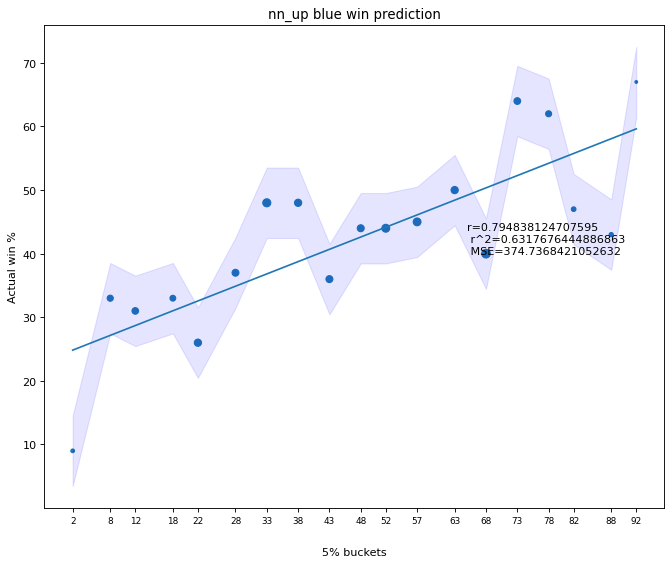

['mix_no']
mix_no
0% to 5%: 0% of 0 observations
5% to 10%: 25% of 4 observations
10% to 15%: 28% of 18 observations
15% to 20%: 15% of 20 observations
20% to 25%: 28% of 51 observations
25% to 30%: 28% of 95 observations
30% to 35%: 46% of 104 observations
35% to 40%: 44% of 77 observations
40% to 45%: 46% of 93 observations
45% to 50%: 56% of 65 observations
50% to 55%: 54% of 50 observations
55% to 60%: 53% of 36 observations
60% to 65%: 67% of 9 observations
65% to 70%: 50% of 6 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[18, 20, 51, 95, 104, 77, 93, 65, 50, 36, 9, 6]
[12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68]
[28, 15, 28, 28, 46, 44, 46, 56, 54, 53, 67, 50]


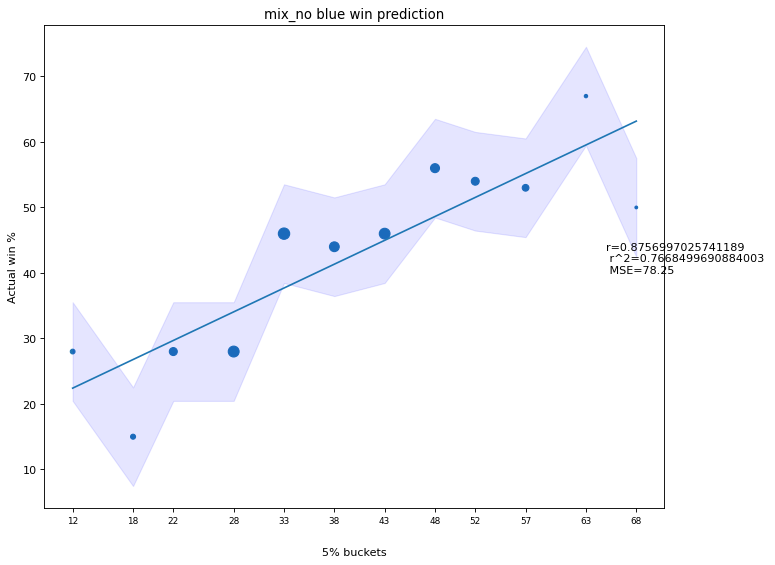

['mix_rand']
mix_rand
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 2 observations
15% to 20%: 0% of 2 observations
20% to 25%: 21% of 14 observations
25% to 30%: 40% of 20 observations
30% to 35%: 14% of 42 observations
35% to 40%: 43% of 47 observations
40% to 45%: 39% of 74 observations
45% to 50%: 34% of 92 observations
50% to 55%: 36% of 94 observations
55% to 60%: 49% of 118 observations
60% to 65%: 62% of 69 observations
65% to 70%: 59% of 56 observations
70% to 75%: 71% of 14 observations
75% to 80%: 56% of 9 observations
80% to 85%: 100% of 3 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[14, 20, 42, 47, 74, 92, 94, 118, 69, 56, 14, 9]
[22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78]
[21, 40, 14, 43, 39, 34, 36, 49, 62, 59, 71, 56]


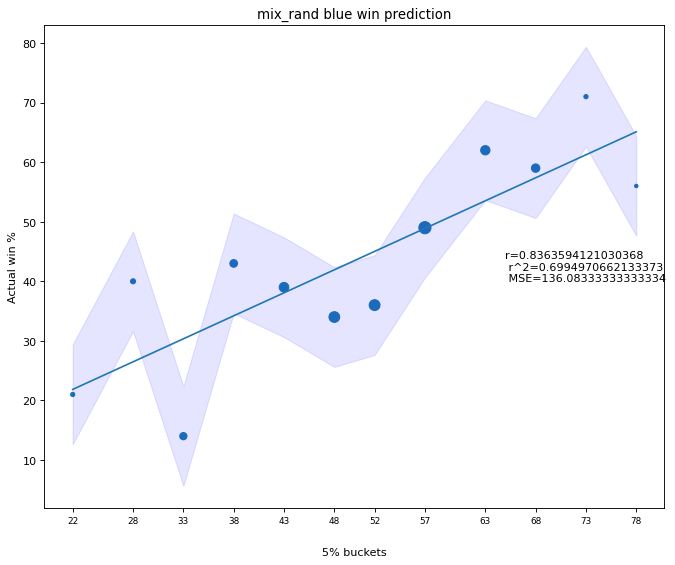

['mix_up']
mix_up
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 60% of 5 observations
15% to 20%: 17% of 6 observations
20% to 25%: 32% of 22 observations
25% to 30%: 14% of 50 observations
30% to 35%: 28% of 63 observations
35% to 40%: 45% of 78 observations
40% to 45%: 43% of 116 observations
45% to 50%: 45% of 110 observations
50% to 55%: 52% of 94 observations
55% to 60%: 53% of 64 observations
60% to 65%: 52% of 23 observations
65% to 70%: 62% of 16 observations
70% to 75%: 100% of 1 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[5, 6, 22, 50, 63, 78, 116, 110, 94, 64, 23, 16]
[12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68]
[60, 17, 32, 14, 28, 45, 43, 45, 52, 53, 52, 62]


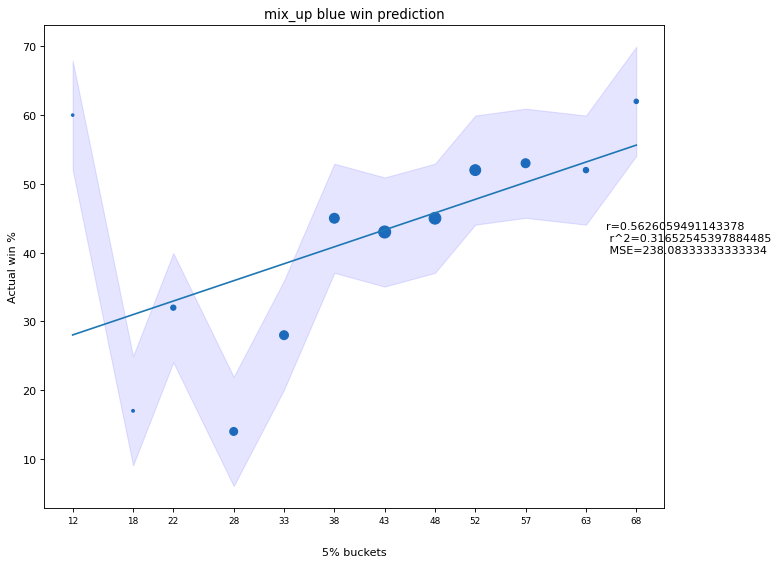

['combined']
combined
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 2 observations
15% to 20%: 50% of 4 observations
20% to 25%: 28% of 14 observations
25% to 30%: 17% of 36 observations
30% to 35%: 28% of 86 observations
35% to 40%: 41% of 74 observations
40% to 45%: 45% of 107 observations
45% to 50%: 39% of 97 observations
50% to 55%: 57% of 102 observations
55% to 60%: 54% of 78 observations
60% to 65%: 61% of 28 observations
65% to 70%: 80% of 10 observations
70% to 75%: 67% of 3 observations
75% to 80%: 100% of 2 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[14, 36, 86, 74, 107, 97, 102, 78, 28, 10]
[22, 28, 33, 38, 43, 48, 52, 57, 63, 68]
[28, 17, 28, 41, 45, 39, 57, 54, 61, 80]


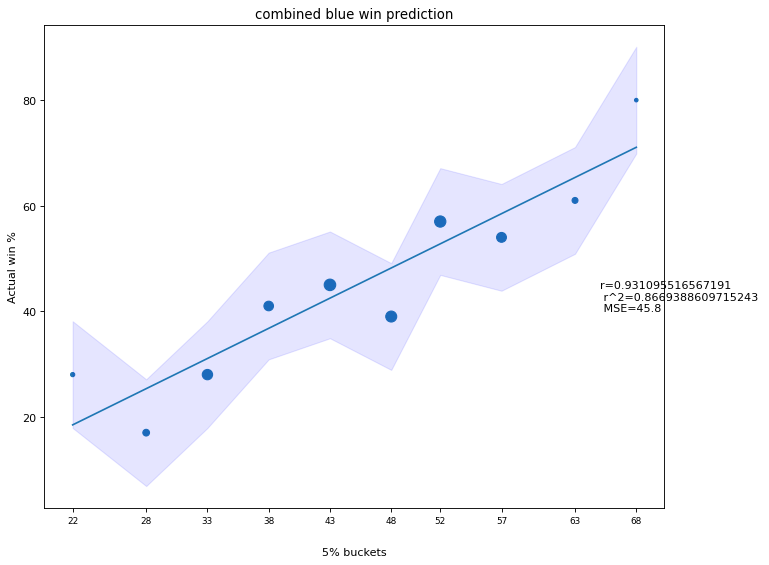

In [73]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
    print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["blue_total_pct"] >= x]
        point_to_point = point_up[point_up["blue_total_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_winner"] == "blue"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

    print(observations)
    print(half_points)
    print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
    plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual win %")
    plt.title(f"{perm_str} blue win prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [74]:
blue_win_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

blue_win_df = pd.DataFrame(blue_win_dict)
blue_win_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.536881   0.288241    221.333333
1     knn_rand  0.522181   0.272673    258.750000
2       knn_up  0.354524   0.125687    598.437500
3       log_no  0.815330   0.664763    151.857143
4     log_rand  0.952221   0.906724     98.200000
5       log_up  0.852440   0.726653    270.882353
6        rf_no -0.568805   0.323539    399.857143
7      rf_rand  0.715755   0.512305    190.250000
8        rf_up -0.591382   0.349732    353.285714
9       mlp_no  0.802143   0.643434    268.222222
10    mlp_rand  0.825210   0.680972    361.315789
11      mlp_up  0.559678   0.313240    635.300000
12       nn_no  0.865813   0.749631    175.437500
13     nn_rand  0.933587   0.871584    100.937500
14       nn_up  0.794838   0.631768    374.736842
15      mix_no  0.875700   0.766850     78.250000
16    mix_rand  0.836359   0.699497    136.083333
17      mix_up  0.562606   0.316525    238.083333
18    combined  0.931096   0.866939     45.800000

['knn_no']
knn_no
0% to 5%: 0% of 1 observations
5% to 10%: 0% of 6 observations
10% to 15%: 25% of 60 observations
15% to 20%: 28% of 68 observations
20% to 25%: 20% of 90 observations
25% to 30%: 25% of 95 observations
30% to 35%: 32% of 88 observations
35% to 40%: 24% of 95 observations
40% to 45%: 30% of 54 observations
45% to 50%: 34% of 50 observations
50% to 55%: 32% of 25 observations
55% to 60%: 20% of 10 observations
60% to 65%: 33% of 9 observations
65% to 70%: 100% of 1 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[6, 60, 68, 90, 95, 88, 95, 54, 50, 25, 10, 9]
[8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63]
[0, 25, 28, 20, 25, 32, 24, 30, 34, 32, 20, 33]


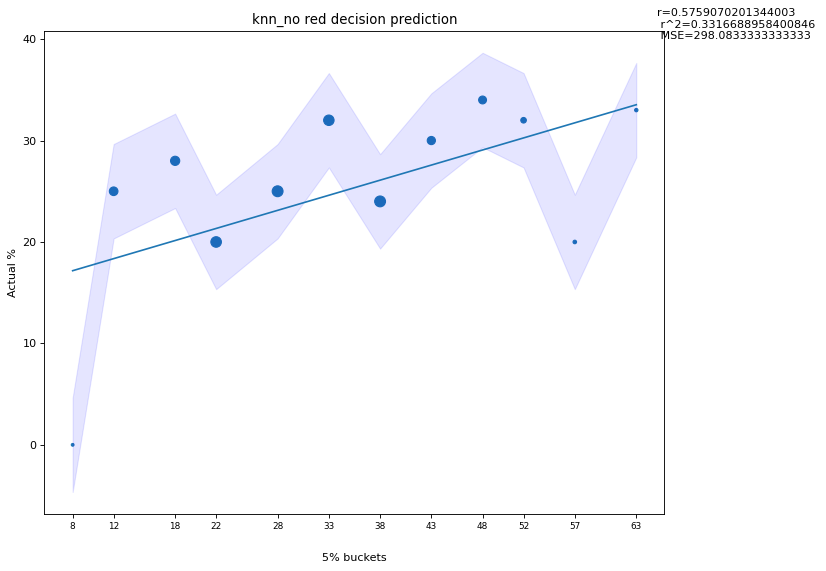

['knn_rand']
knn_rand
0% to 5%: 0% of 2 observations
5% to 10%: 11% of 19 observations
10% to 15%: 24% of 117 observations
15% to 20%: 28% of 95 observations
20% to 25%: 22% of 127 observations
25% to 30%: 22% of 105 observations
30% to 35%: 33% of 81 observations
35% to 40%: 37% of 43 observations
40% to 45%: 43% of 28 observations
45% to 50%: 26% of 19 observations
50% to 55%: 44% of 9 observations
55% to 60%: 40% of 5 observations
60% to 65%: 0% of 2 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[19, 117, 95, 127, 105, 81, 43, 28, 19, 9, 5]
[8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57]
[11, 24, 28, 22, 22, 33, 37, 43, 26, 44, 40]


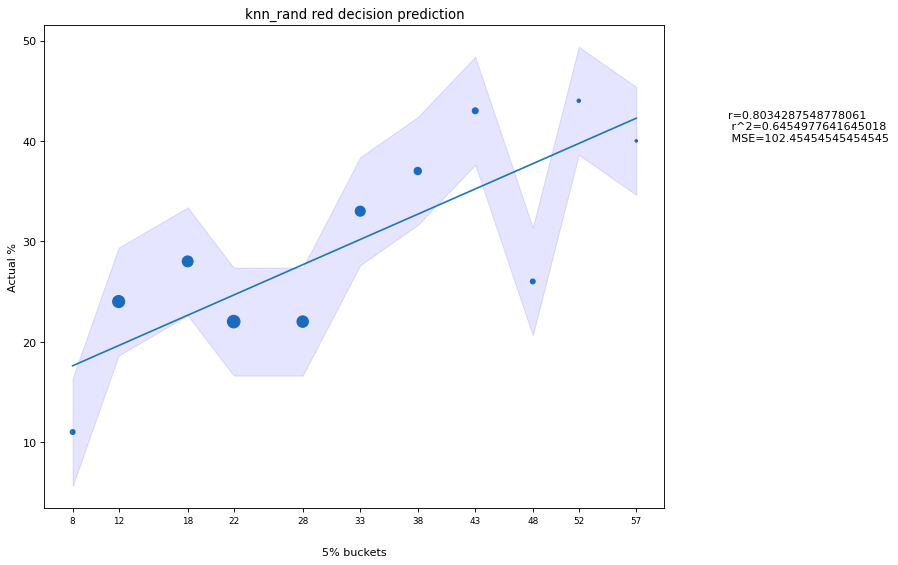

['knn_up']
knn_up
0% to 5%: 17% of 12 observations
5% to 10%: 15% of 33 observations
10% to 15%: 35% of 79 observations
15% to 20%: 24% of 101 observations
20% to 25%: 21% of 117 observations
25% to 30%: 23% of 91 observations
30% to 35%: 28% of 89 observations
35% to 40%: 43% of 56 observations
40% to 45%: 19% of 36 observations
45% to 50%: 44% of 16 observations
50% to 55%: 42% of 12 observations
55% to 60%: 25% of 4 observations
60% to 65%: 20% of 5 observations
65% to 70%: 0% of 1 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[12, 33, 79, 101, 117, 91, 89, 56, 36, 16, 12, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 63]
[17, 15, 35, 24, 21, 23, 28, 43, 19, 44, 42, 20]


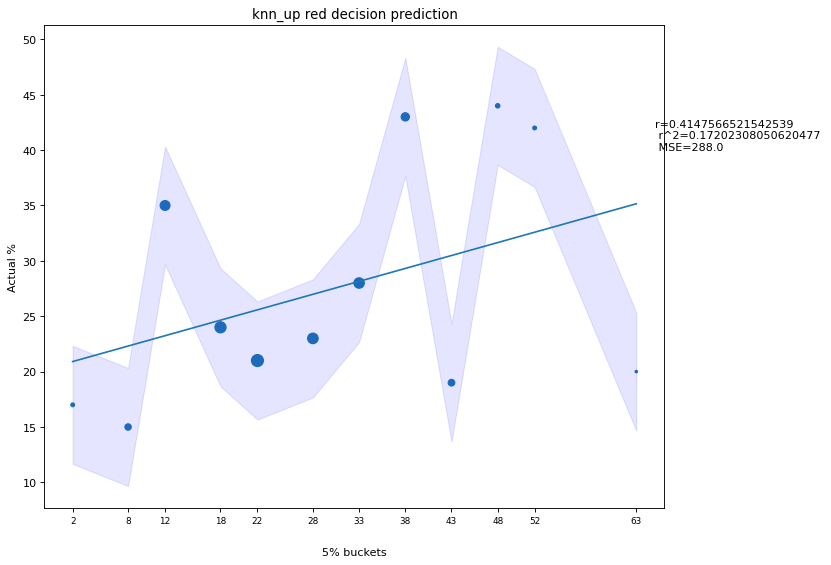

['log_no']
log_no
0% to 5%: 0% of 0 observations
5% to 10%: 17% of 12 observations
10% to 15%: 33% of 51 observations
15% to 20%: 20% of 61 observations
20% to 25%: 21% of 102 observations
25% to 30%: 21% of 118 observations
30% to 35%: 28% of 102 observations
35% to 40%: 39% of 75 observations
40% to 45%: 27% of 56 observations
45% to 50%: 41% of 29 observations
50% to 55%: 33% of 15 observations
55% to 60%: 28% of 7 observations
60% to 65%: 0% of 3 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 1 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[12, 51, 61, 102, 118, 102, 75, 56, 29, 15, 7]
[8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57]
[17, 33, 20, 21, 21, 28, 39, 27, 41, 33, 28]


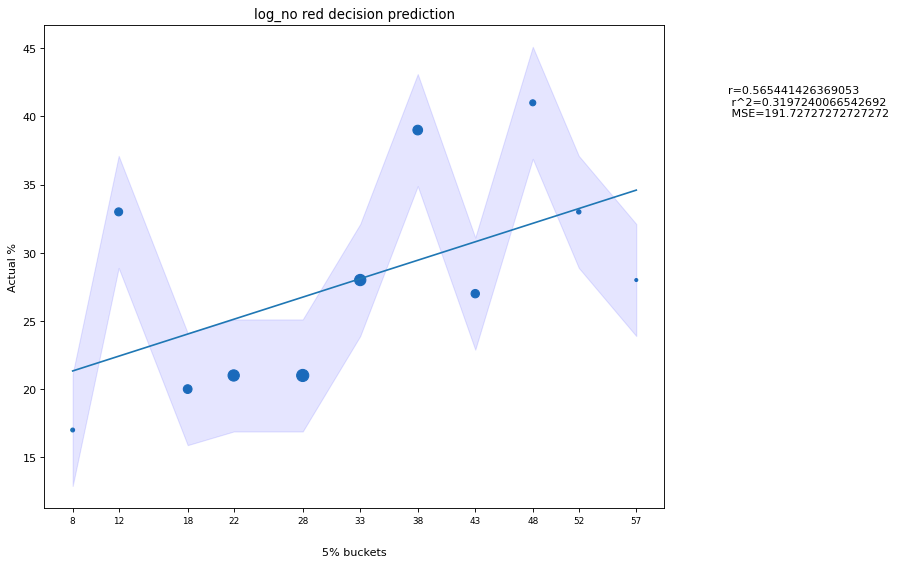

['log_rand']
log_rand
0% to 5%: 15% of 13 observations
5% to 10%: 20% of 55 observations
10% to 15%: 18% of 114 observations
15% to 20%: 24% of 76 observations
20% to 25%: 26% of 109 observations
25% to 30%: 30% of 102 observations
30% to 35%: 28% of 69 observations
35% to 40%: 45% of 42 observations
40% to 45%: 33% of 27 observations
45% to 50%: 40% of 15 observations
50% to 55%: 17% of 6 observations
55% to 60%: 33% of 3 observations
60% to 65%: 33% of 3 observations
65% to 70%: 100% of 2 observations
70% to 75%: 0% of 2 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[13, 55, 114, 76, 109, 102, 69, 42, 27, 15, 6]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52]
[15, 20, 18, 24, 26, 30, 28, 45, 33, 40, 17]


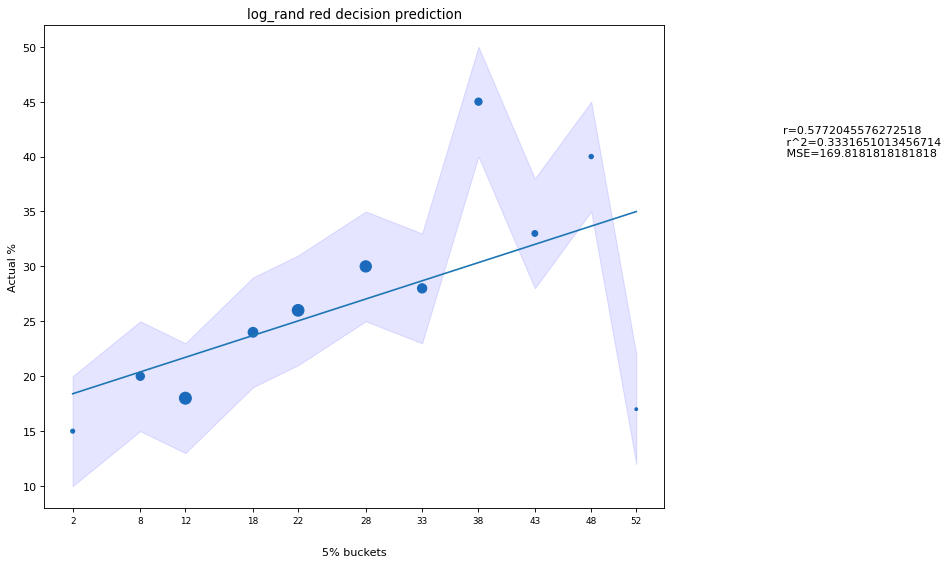

['log_up']
log_up
0% to 5%: 40% of 5 observations
5% to 10%: 22% of 37 observations
10% to 15%: 27% of 128 observations
15% to 20%: 22% of 87 observations
20% to 25%: 24% of 141 observations
25% to 30%: 28% of 106 observations
30% to 35%: 30% of 60 observations
35% to 40%: 47% of 30 observations
40% to 45%: 28% of 21 observations
45% to 50%: 43% of 7 observations
50% to 55%: 0% of 3 observations
55% to 60%: 0% of 2 observations
60% to 65%: 0% of 1 observations
65% to 70%: 0% of 1 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[5, 37, 128, 87, 141, 106, 60, 30, 21, 7]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48]
[40, 22, 27, 22, 24, 28, 30, 47, 28, 43]


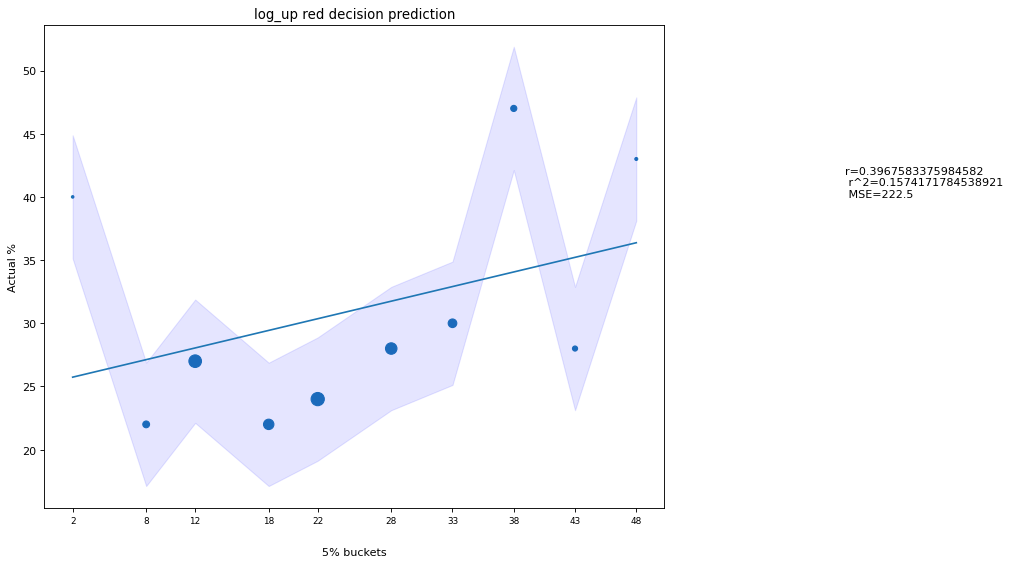

['rf_no']
rf_no
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 17% of 6 observations
15% to 20%: 33% of 21 observations
20% to 25%: 25% of 144 observations
25% to 30%: 27% of 259 observations
30% to 35%: 30% of 125 observations
35% to 40%: 19% of 36 observations
40% to 45%: 14% of 14 observations
45% to 50%: 25% of 4 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[6, 21, 144, 259, 125, 36, 14]
[12, 18, 22, 28, 33, 38, 43]
[17, 33, 25, 27, 30, 19, 14]


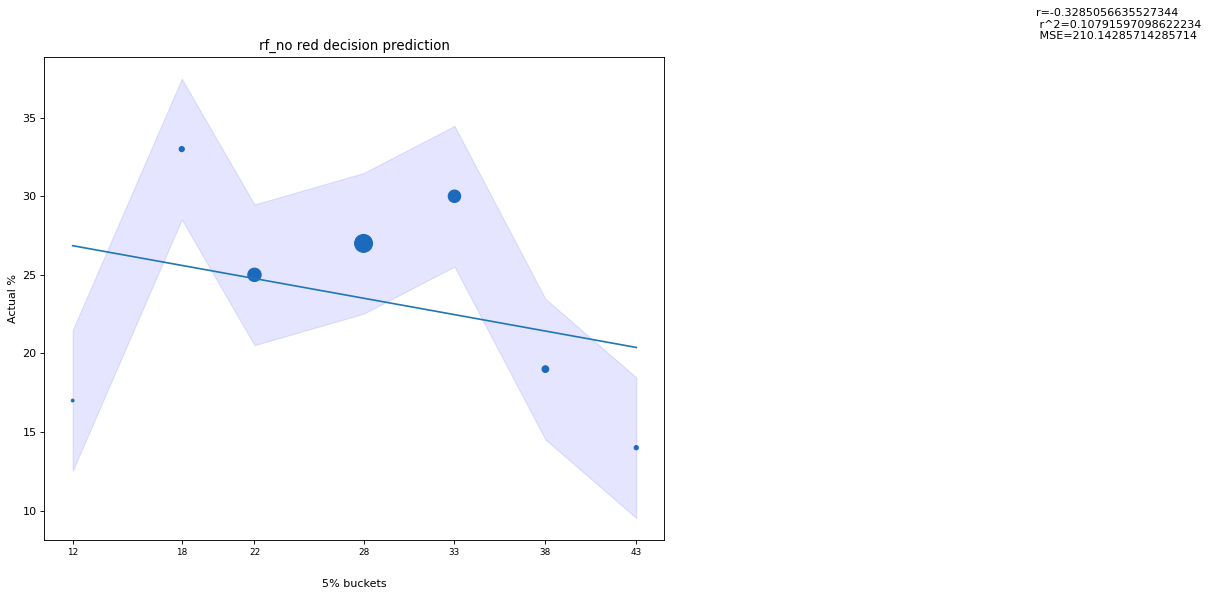

['rf_rand']
rf_rand
0% to 5%: 0% of 0 observations
5% to 10%: 25% of 4 observations
10% to 15%: 19% of 53 observations
15% to 20%: 30% of 132 observations
20% to 25%: 30% of 224 observations
25% to 30%: 25% of 159 observations
30% to 35%: 11% of 44 observations
35% to 40%: 33% of 12 observations
40% to 45%: 75% of 4 observations
45% to 50%: 100% of 1 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[53, 132, 224, 159, 44, 12]
[12, 18, 22, 28, 33, 38]
[19, 30, 30, 25, 11, 33]


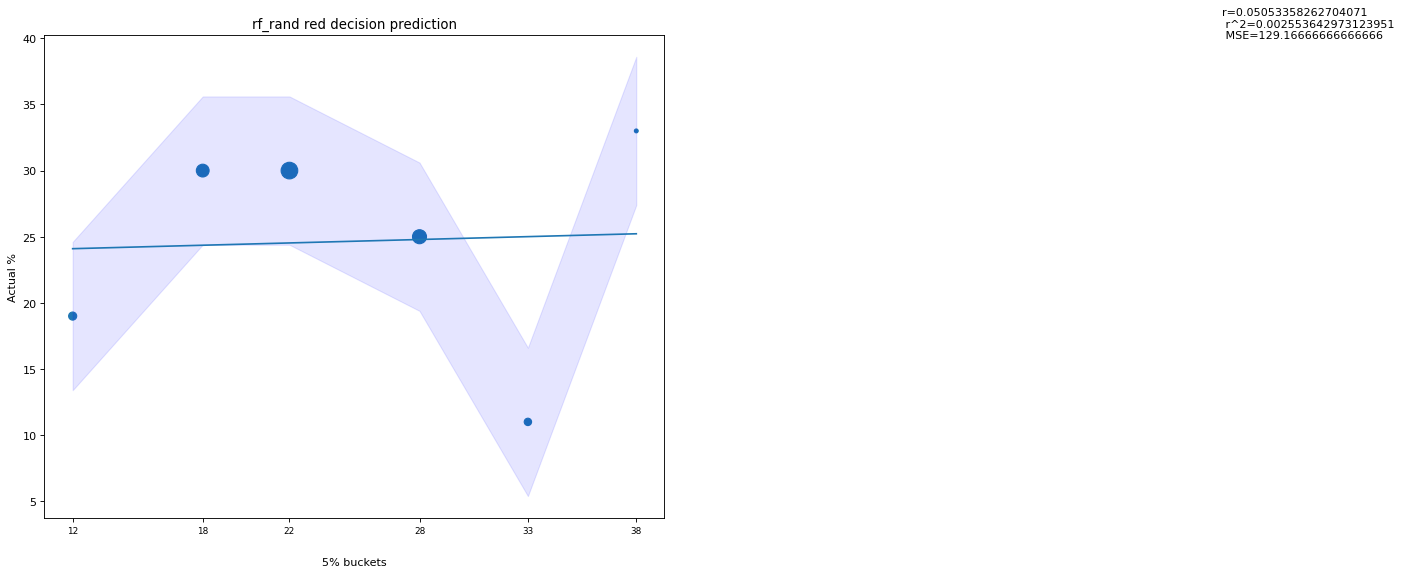

['rf_up']
rf_up
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 0 observations
10% to 15%: 0% of 6 observations
15% to 20%: 32% of 38 observations
20% to 25%: 28% of 167 observations
25% to 30%: 27% of 243 observations
30% to 35%: 24% of 118 observations
35% to 40%: 42% of 26 observations
40% to 45%: 0% of 7 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[6, 38, 167, 243, 118, 26, 7]
[12, 18, 22, 28, 33, 38, 43]
[0, 32, 28, 27, 24, 42, 0]


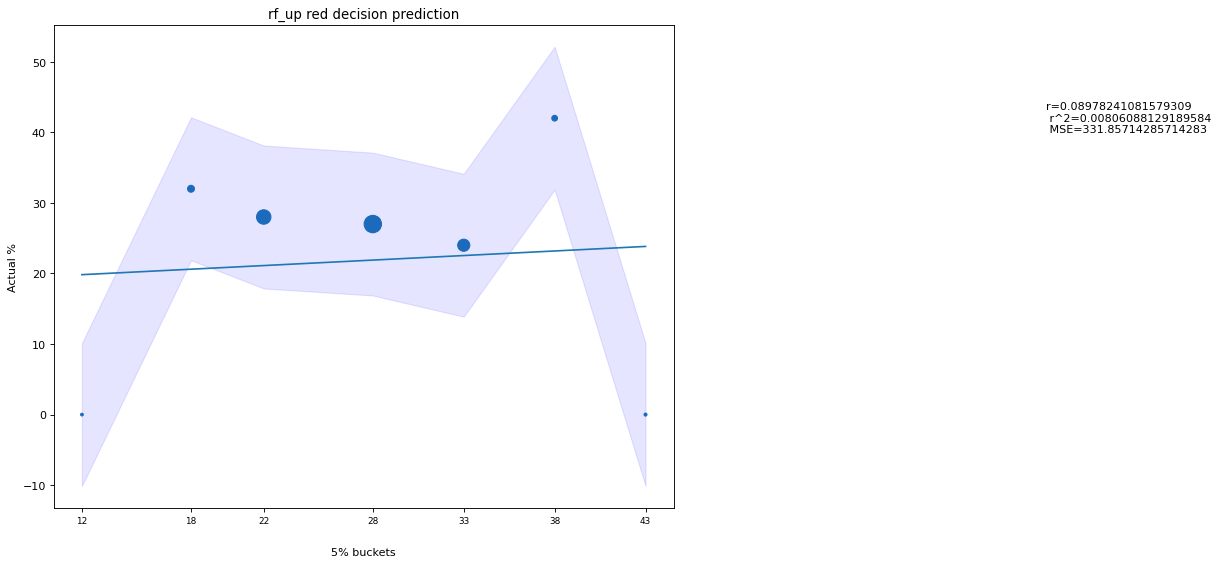

['mlp_no']
mlp_no
0% to 5%: 20% of 55 observations
5% to 10%: 20% of 71 observations
10% to 15%: 24% of 78 observations
15% to 20%: 28% of 49 observations
20% to 25%: 31% of 71 observations
25% to 30%: 15% of 52 observations
30% to 35%: 40% of 48 observations
35% to 40%: 33% of 42 observations
40% to 45%: 28% of 45 observations
45% to 50%: 23% of 39 observations
50% to 55%: 36% of 28 observations
55% to 60%: 28% of 28 observations
60% to 65%: 14% of 14 observations
65% to 70%: 11% of 9 observations
70% to 75%: 67% of 6 observations
75% to 80%: 56% of 9 observations
80% to 85%: 0% of 2 observations
85% to 90%: 50% of 2 observations
90% to 95%: 33% of 3 observations
95% to 100%: 0% of 0 observations
[55, 71, 78, 49, 71, 52, 48, 42, 45, 39, 28, 28, 14, 9, 6, 9]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78]
[20, 20, 24, 28, 31, 15, 40, 33, 28, 23, 36, 28, 14, 11, 67, 56]


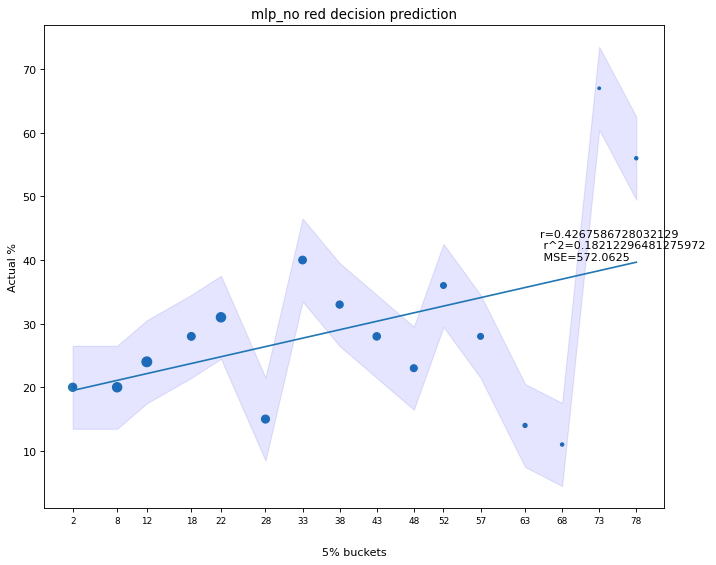

['mlp_rand']
mlp_rand
0% to 5%: 13% of 94 observations
5% to 10%: 28% of 95 observations
10% to 15%: 26% of 96 observations
15% to 20%: 18% of 57 observations
20% to 25%: 28% of 68 observations
25% to 30%: 37% of 49 observations
30% to 35%: 28% of 29 observations
35% to 40%: 26% of 23 observations
40% to 45%: 30% of 20 observations
45% to 50%: 20% of 15 observations
50% to 55%: 42% of 24 observations
55% to 60%: 32% of 22 observations
60% to 65%: 30% of 10 observations
65% to 70%: 30% of 10 observations
70% to 75%: 33% of 9 observations
75% to 80%: 33% of 9 observations
80% to 85%: 36% of 11 observations
85% to 90%: 60% of 5 observations
90% to 95%: 0% of 2 observations
95% to 100%: 0% of 1 observations
[94, 95, 96, 57, 68, 49, 29, 23, 20, 15, 24, 22, 10, 10, 9, 9, 11, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88]
[13, 28, 26, 18, 28, 37, 28, 26, 30, 20, 42, 32, 30, 30, 33, 33, 36, 60]


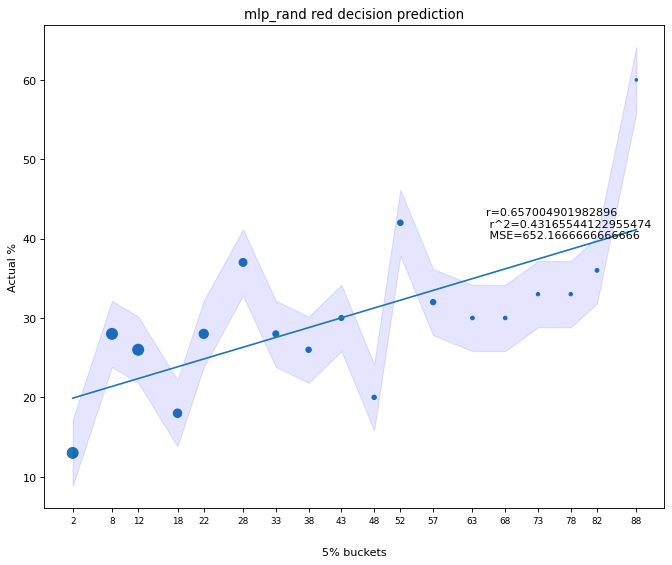

['mlp_up']
mlp_up
0% to 5%: 22% of 78 observations
5% to 10%: 31% of 93 observations
10% to 15%: 20% of 91 observations
15% to 20%: 32% of 37 observations
20% to 25%: 19% of 63 observations
25% to 30%: 24% of 41 observations
30% to 35%: 32% of 41 observations
35% to 40%: 28% of 36 observations
40% to 45%: 32% of 25 observations
45% to 50%: 23% of 22 observations
50% to 55%: 22% of 23 observations
55% to 60%: 33% of 24 observations
60% to 65%: 33% of 12 observations
65% to 70%: 35% of 23 observations
70% to 75%: 23% of 13 observations
75% to 80%: 33% of 9 observations
80% to 85%: 25% of 8 observations
85% to 90%: 40% of 5 observations
90% to 95%: 50% of 4 observations
95% to 100%: 0% of 1 observations
[78, 93, 91, 37, 63, 41, 41, 36, 25, 22, 23, 24, 12, 23, 13, 9, 8, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88]
[22, 31, 20, 32, 19, 24, 32, 28, 32, 23, 22, 33, 33, 35, 23, 33, 25, 40]


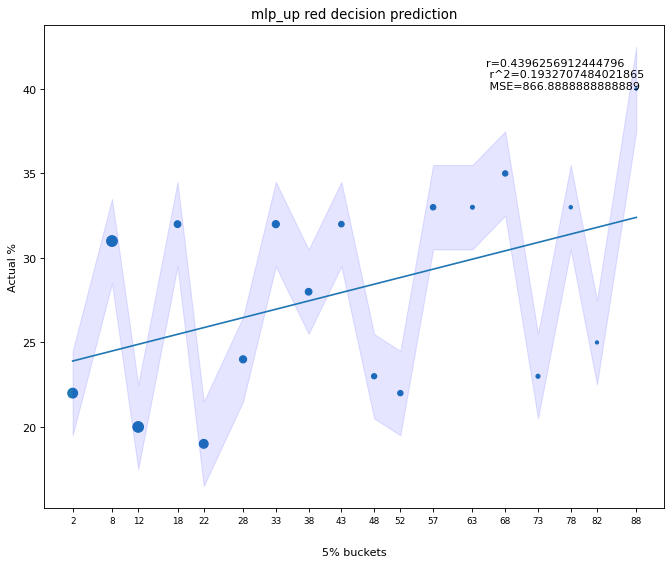

['nn_no']
nn_no
0% to 5%: 33% of 6 observations
5% to 10%: 25% of 24 observations
10% to 15%: 22% of 60 observations
15% to 20%: 15% of 60 observations
20% to 25%: 20% of 96 observations
25% to 30%: 31% of 95 observations
30% to 35%: 20% of 74 observations
35% to 40%: 37% of 63 observations
40% to 45%: 34% of 59 observations
45% to 50%: 26% of 35 observations
50% to 55%: 36% of 22 observations
55% to 60%: 50% of 14 observations
60% to 65%: 17% of 6 observations
65% to 70%: 56% of 7 observations
70% to 75%: 0% of 2 observations
75% to 80%: 0% of 3 observations
80% to 85%: 50% of 2 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[6, 24, 60, 60, 96, 95, 74, 63, 59, 35, 22, 14, 6, 7]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68]
[33, 25, 22, 15, 20, 31, 20, 37, 34, 26, 36, 50, 17, 56]


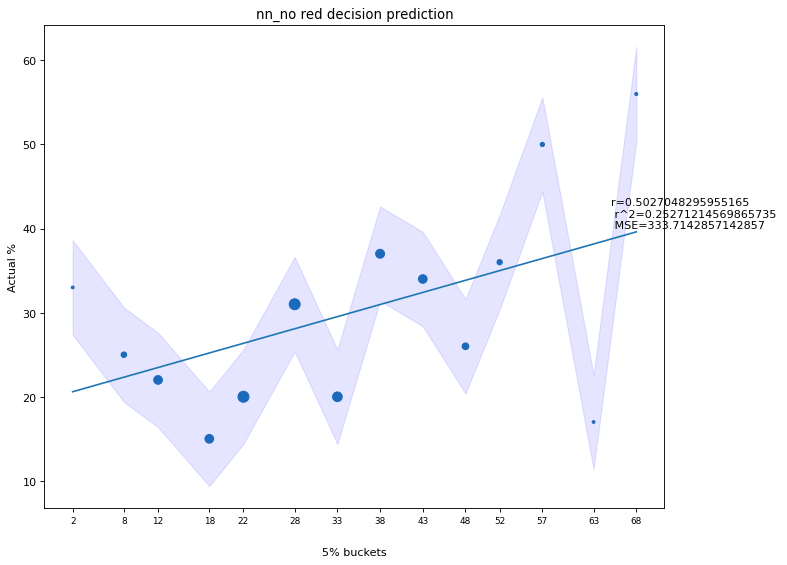

['nn_rand']
nn_rand
0% to 5%: 5% of 20 observations
5% to 10%: 12% of 69 observations
10% to 15%: 22% of 121 observations
15% to 20%: 24% of 70 observations
20% to 25%: 27% of 92 observations
25% to 30%: 34% of 86 observations
30% to 35%: 28% of 63 observations
35% to 40%: 31% of 39 observations
40% to 45%: 46% of 28 observations
45% to 50%: 44% of 16 observations
50% to 55%: 50% of 16 observations
55% to 60%: 27% of 11 observations
60% to 65%: 33% of 6 observations
65% to 70%: 40% of 5 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[20, 69, 121, 70, 92, 86, 63, 39, 28, 16, 16, 11, 6, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68]
[5, 12, 22, 24, 27, 34, 28, 31, 46, 44, 50, 27, 33, 40]


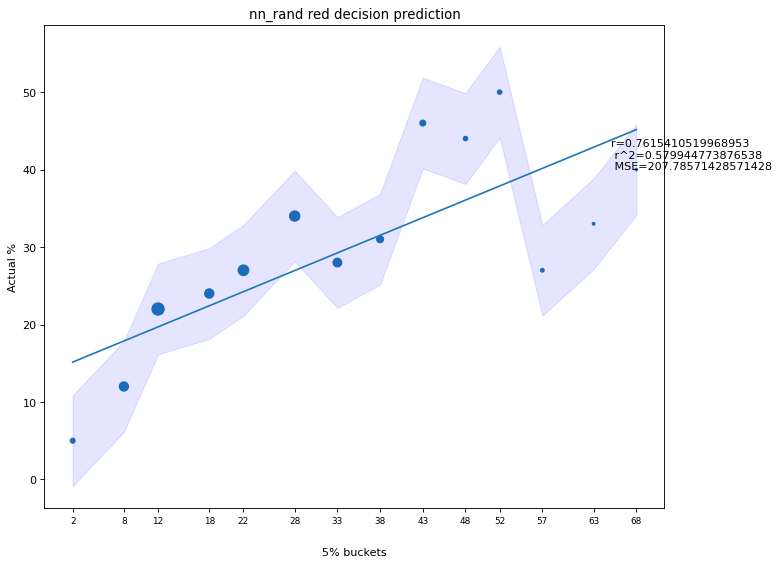

['nn_up']
nn_up
0% to 5%: 18% of 17 observations
5% to 10%: 19% of 68 observations
10% to 15%: 23% of 106 observations
15% to 20%: 23% of 94 observations
20% to 25%: 21% of 80 observations
25% to 30%: 37% of 67 observations
30% to 35%: 35% of 72 observations
35% to 40%: 48% of 29 observations
40% to 45%: 28% of 40 observations
45% to 50%: 30% of 23 observations
50% to 55%: 26% of 23 observations
55% to 60%: 8% of 13 observations
60% to 65%: 0% of 2 observations
65% to 70%: 0% of 4 observations
70% to 75%: 100% of 1 observations
75% to 80%: 50% of 2 observations
80% to 85%: 100% of 1 observations
85% to 90%: 0% of 1 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[17, 68, 106, 94, 80, 67, 72, 29, 40, 23, 23, 13]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57]
[18, 19, 23, 23, 21, 37, 35, 48, 28, 30, 26, 8]


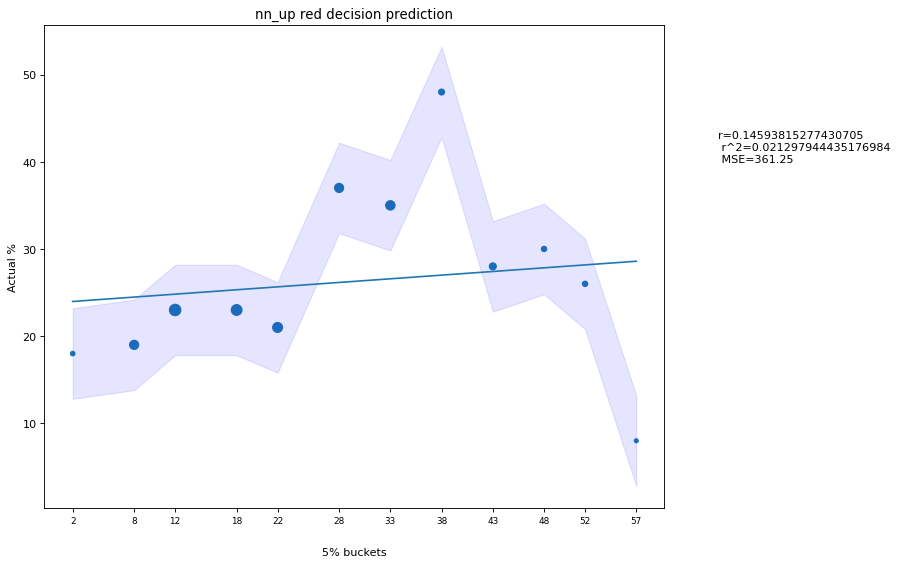

['mix_no']
mix_no
0% to 5%: 0% of 0 observations
5% to 10%: 50% of 2 observations
10% to 15%: 14% of 35 observations
15% to 20%: 18% of 66 observations
20% to 25%: 27% of 121 observations
25% to 30%: 23% of 140 observations
30% to 35%: 28% of 125 observations
35% to 40%: 39% of 67 observations
40% to 45%: 28% of 49 observations
45% to 50%: 19% of 16 observations
50% to 55%: 0% of 3 observations
55% to 60%: 67% of 3 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[35, 66, 121, 140, 125, 67, 49, 16]
[12, 18, 22, 28, 33, 38, 43, 48]
[14, 18, 27, 23, 28, 39, 28, 19]


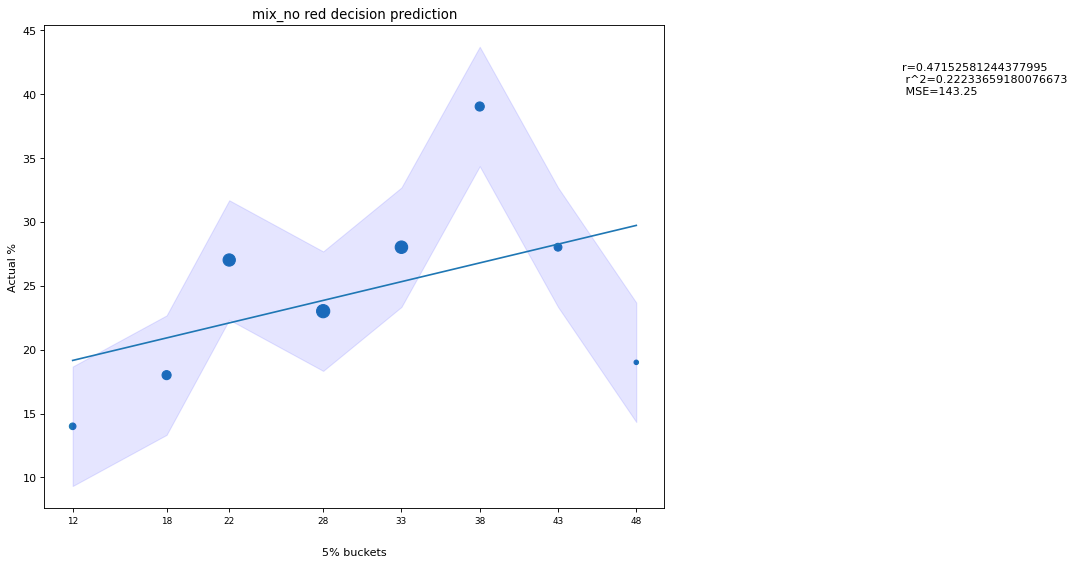

['mix_rand']
mix_rand
0% to 5%: 100% of 1 observations
5% to 10%: 12% of 24 observations
10% to 15%: 18% of 122 observations
15% to 20%: 17% of 99 observations
20% to 25%: 28% of 146 observations
25% to 30%: 31% of 114 observations
30% to 35%: 37% of 70 observations
35% to 40%: 38% of 26 observations
40% to 45%: 26% of 19 observations
45% to 50%: 50% of 10 observations
50% to 55%: 67% of 3 observations
55% to 60%: 0% of 2 observations
60% to 65%: 0% of 1 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[24, 122, 99, 146, 114, 70, 26, 19, 10]
[8, 12, 18, 22, 28, 33, 38, 43, 48]
[12, 18, 17, 28, 31, 37, 38, 26, 50]


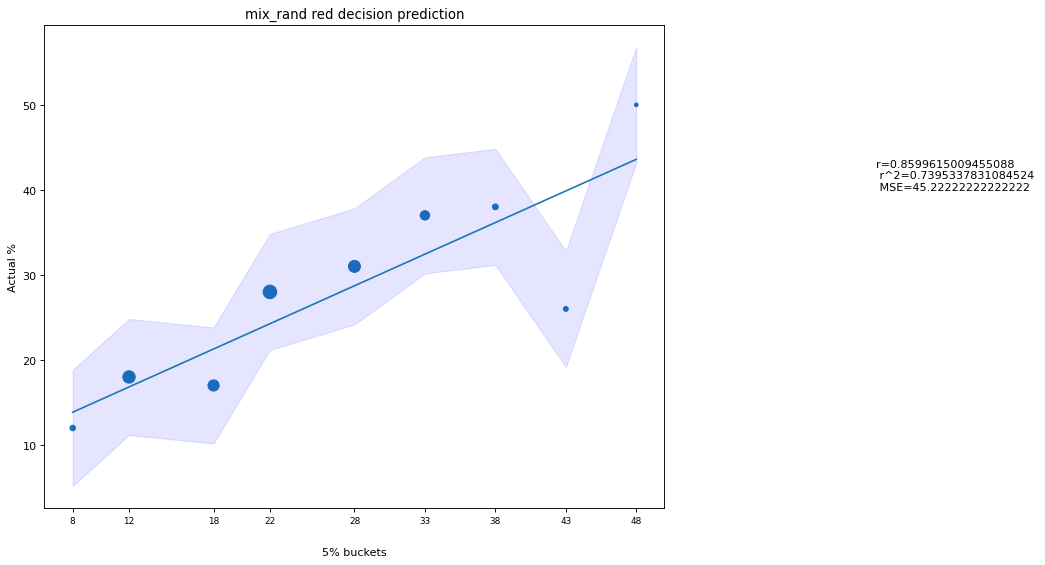

['mix_up']
mix_up
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 1 observations
10% to 15%: 19% of 42 observations
15% to 20%: 15% of 95 observations
20% to 25%: 23% of 168 observations
25% to 30%: 31% of 163 observations
30% to 35%: 36% of 101 observations
35% to 40%: 37% of 38 observations
40% to 45%: 28% of 14 observations
45% to 50%: 80% of 5 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[42, 95, 168, 163, 101, 38, 14, 5]
[12, 18, 22, 28, 33, 38, 43, 48]
[19, 15, 23, 31, 36, 37, 28, 80]


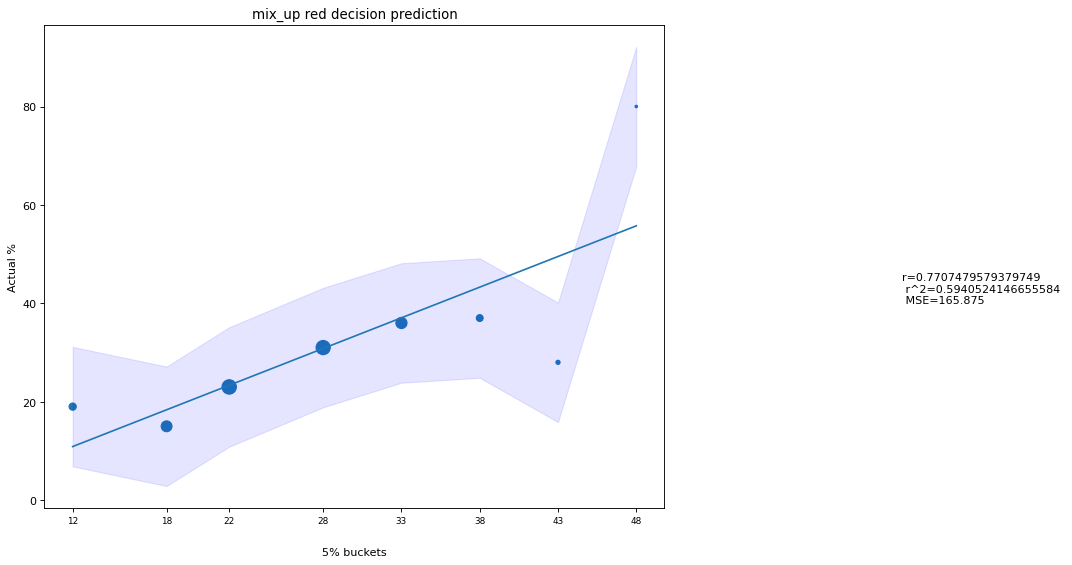

['combined']
combined
0% to 5%: 0% of 0 observations
5% to 10%: 0% of 1 observations
10% to 15%: 16% of 49 observations
15% to 20%: 19% of 83 observations
20% to 25%: 19% of 150 observations
25% to 30%: 28% of 165 observations
30% to 35%: 40% of 94 observations
35% to 40%: 28% of 45 observations
40% to 45%: 43% of 21 observations
45% to 50%: 17% of 6 observations
50% to 55%: 0% of 4 observations
55% to 60%: 100% of 1 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[49, 83, 150, 165, 94, 45, 21, 6]
[12, 18, 22, 28, 33, 38, 43, 48]
[16, 19, 19, 28, 40, 28, 43, 17]


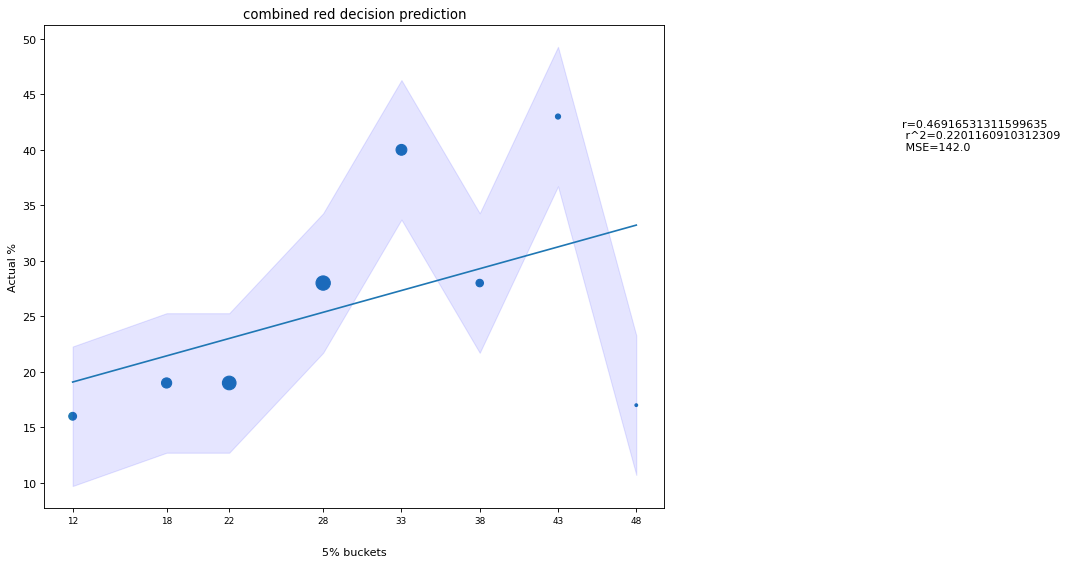

In [75]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
    print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["red_dec_pct"] >= x]
        point_to_point = point_up[point_up["red_dec_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - Decision"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

    print(observations)
    print(half_points)
    print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
    plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} red decision prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [76]:
red_dec_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

red_dec_df = pd.DataFrame(red_dec_dict)
red_dec_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.575907   0.331669    298.083333
1     knn_rand  0.803429   0.645498    102.454545
2       knn_up  0.414757   0.172023    288.000000
3       log_no  0.565441   0.319724    191.727273
4     log_rand  0.577205   0.333165    169.818182
5       log_up  0.396758   0.157417    222.500000
6        rf_no -0.328506   0.107916    210.142857
7      rf_rand  0.050534   0.002554    129.166667
8        rf_up  0.089782   0.008061    331.857143
9       mlp_no  0.426759   0.182123    572.062500
10    mlp_rand  0.657005   0.431655    652.166667
11      mlp_up  0.439626   0.193271    866.888889
12       nn_no  0.502705   0.252712    333.714286
13     nn_rand  0.761541   0.579945    207.785714
14       nn_up  0.145938   0.021298    361.250000
15      mix_no  0.471526   0.222337    143.250000
16    mix_rand  0.859962   0.739534     45.222222
17      mix_up  0.770748   0.594052    165.875000
18    combined  0.469165   0.220116    142.000000

['knn_no']
knn_no
0% to 5%: 8% of 24 observations
5% to 10%: 10% of 60 observations
10% to 15%: 16% of 222 observations
15% to 20%: 15% of 119 observations
20% to 25%: 15% of 80 observations
25% to 30%: 40% of 63 observations
30% to 35%: 28% of 43 observations
35% to 40%: 27% of 22 observations
40% to 45%: 20% of 10 observations
45% to 50%: 0% of 3 observations
50% to 55%: 20% of 5 observations
55% to 60%: 0% of 1 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[24, 60, 222, 119, 80, 63, 43, 22, 10, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 52]
[8, 10, 16, 15, 15, 40, 28, 27, 20, 20]


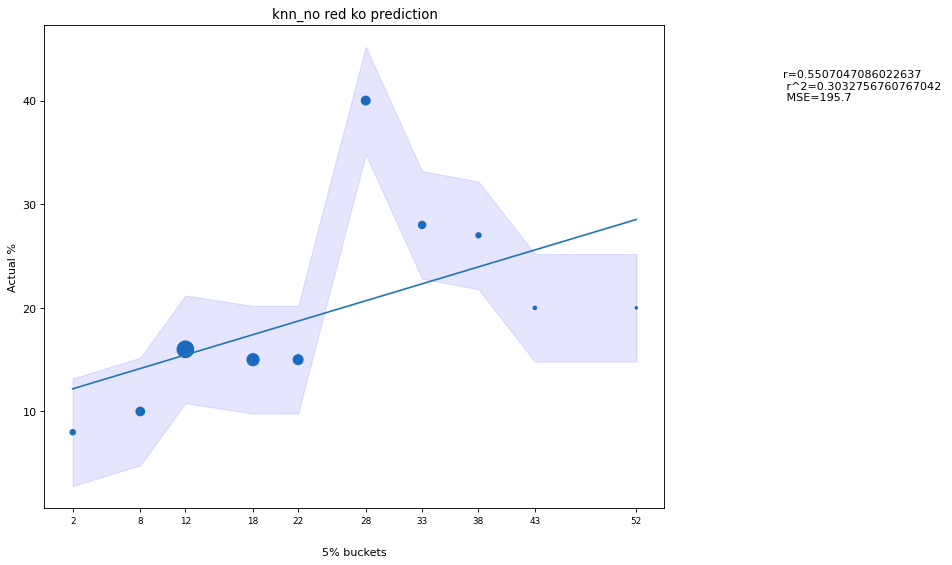

['knn_rand']
knn_rand
0% to 5%: 28% of 25 observations
5% to 10%: 14% of 81 observations
10% to 15%: 16% of 272 observations
15% to 20%: 19% of 100 observations
20% to 25%: 25% of 80 observations
25% to 30%: 21% of 47 observations
30% to 35%: 30% of 27 observations
35% to 40%: 9% of 11 observations
40% to 45%: 20% of 5 observations
45% to 50%: 0% of 2 observations
50% to 55%: 0% of 1 observations
55% to 60%: 0% of 1 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[25, 81, 272, 100, 80, 47, 27, 11, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43]
[28, 14, 16, 19, 25, 21, 30, 9, 20]


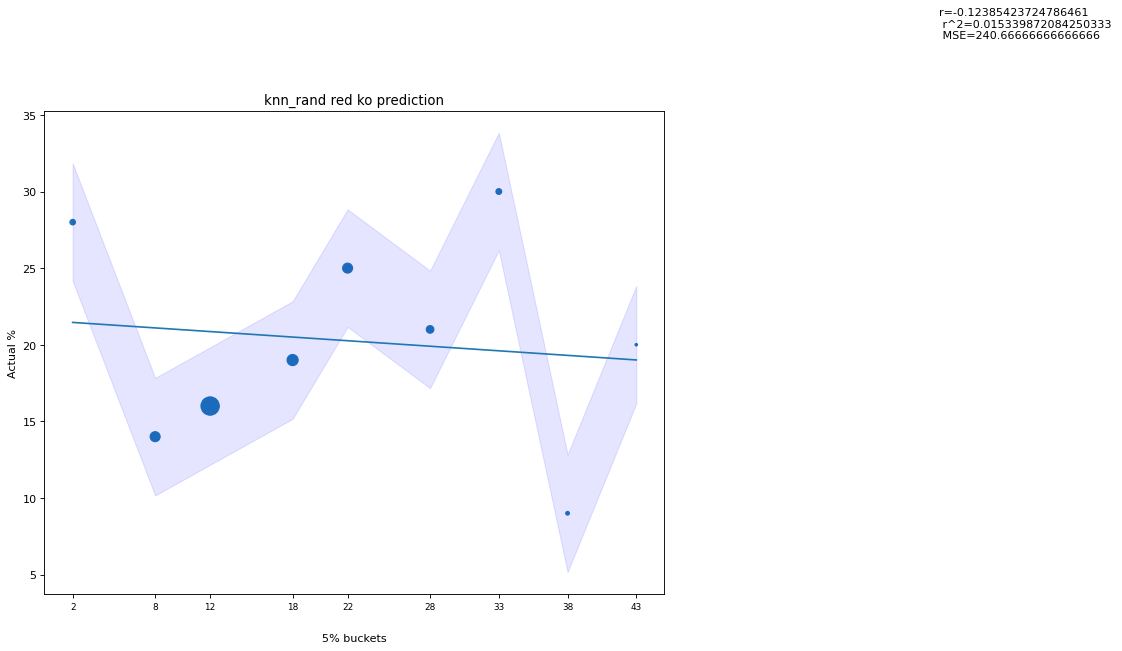

['knn_up']
knn_up
0% to 5%: 13% of 67 observations
5% to 10%: 6% of 115 observations
10% to 15%: 15% of 146 observations
15% to 20%: 27% of 132 observations
20% to 25%: 14% of 87 observations
25% to 30%: 41% of 44 observations
30% to 35%: 24% of 34 observations
35% to 40%: 39% of 18 observations
40% to 45%: 14% of 7 observations
45% to 50%: 0% of 2 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[67, 115, 146, 132, 87, 44, 34, 18, 7]
[2, 8, 12, 18, 22, 28, 33, 38, 43]
[13, 6, 15, 27, 14, 41, 24, 39, 14]


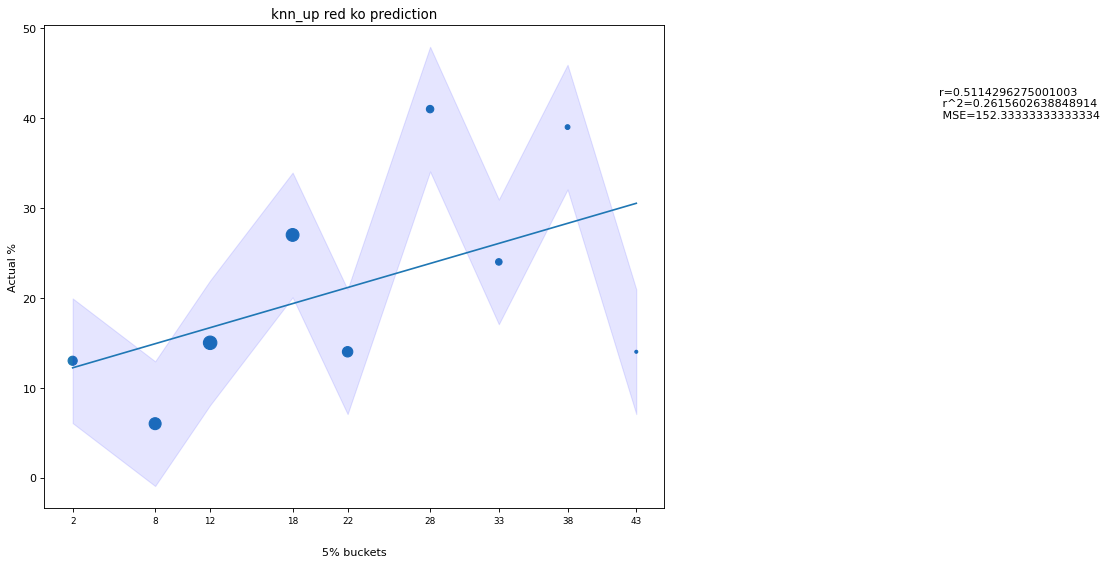

['log_no']
log_no
0% to 5%: 9% of 22 observations
5% to 10%: 8% of 100 observations
10% to 15%: 9% of 139 observations
15% to 20%: 19% of 67 observations
20% to 25%: 19% of 93 observations
25% to 30%: 21% of 72 observations
30% to 35%: 14% of 44 observations
35% to 40%: 31% of 32 observations
40% to 45%: 60% of 30 observations
45% to 50%: 20% of 20 observations
50% to 55%: 64% of 11 observations
55% to 60%: 38% of 8 observations
60% to 65%: 25% of 4 observations
65% to 70%: 50% of 2 observations
70% to 75%: 0% of 2 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 1 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[22, 100, 139, 67, 93, 72, 44, 32, 30, 20, 11, 8]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57]
[9, 8, 9, 19, 19, 21, 14, 31, 60, 20, 64, 38]


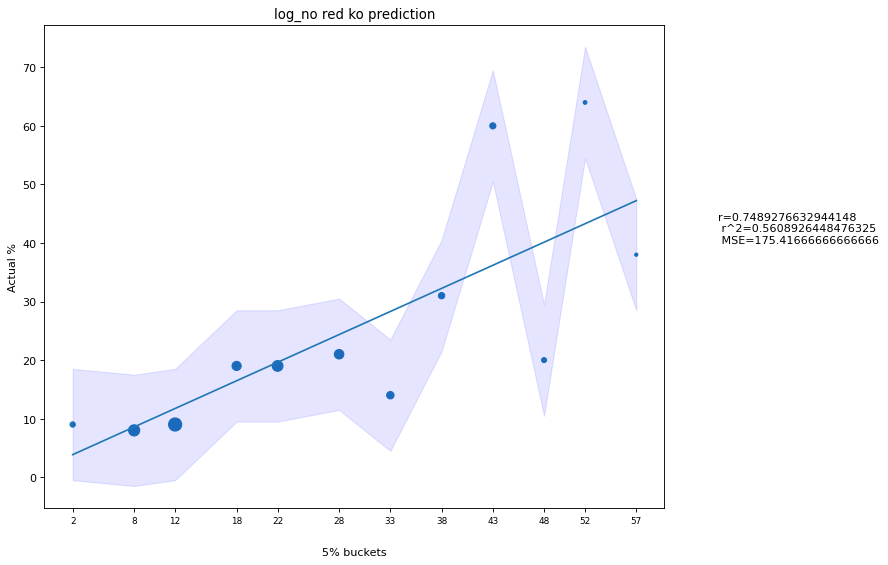

['log_rand']
log_rand
0% to 5%: 3% of 37 observations
5% to 10%: 10% of 139 observations
10% to 15%: 16% of 178 observations
15% to 20%: 18% of 93 observations
20% to 25%: 18% of 73 observations
25% to 30%: 21% of 48 observations
30% to 35%: 39% of 33 observations
35% to 40%: 50% of 24 observations
40% to 45%: 45% of 11 observations
45% to 50%: 56% of 7 observations
50% to 55%: 25% of 4 observations
55% to 60%: 0% of 1 observations
60% to 65%: 50% of 2 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[37, 139, 178, 93, 73, 48, 33, 24, 11, 7]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48]
[3, 10, 16, 18, 18, 21, 39, 50, 45, 56]


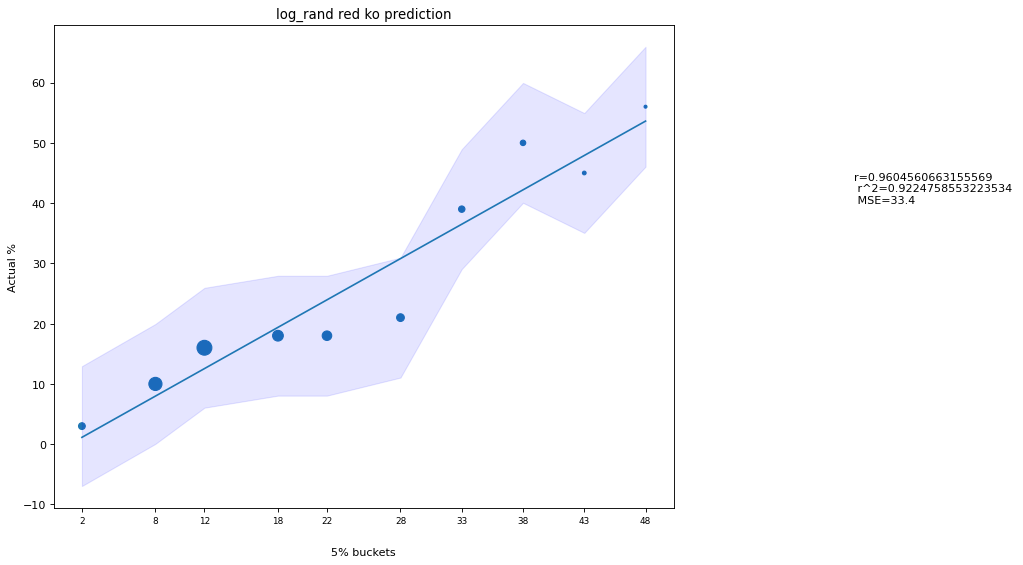

['log_up']
log_up
0% to 5%: 10% of 79 observations
5% to 10%: 10% of 145 observations
10% to 15%: 14% of 133 observations
15% to 20%: 17% of 75 observations
20% to 25%: 27% of 70 observations
25% to 30%: 17% of 48 observations
30% to 35%: 39% of 38 observations
35% to 40%: 35% of 20 observations
40% to 45%: 47% of 19 observations
45% to 50%: 67% of 6 observations
50% to 55%: 67% of 3 observations
55% to 60%: 25% of 4 observations
60% to 65%: 0% of 4 observations
65% to 70%: 0% of 1 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[79, 145, 133, 75, 70, 48, 38, 20, 19, 6]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48]
[10, 10, 14, 17, 27, 17, 39, 35, 47, 67]


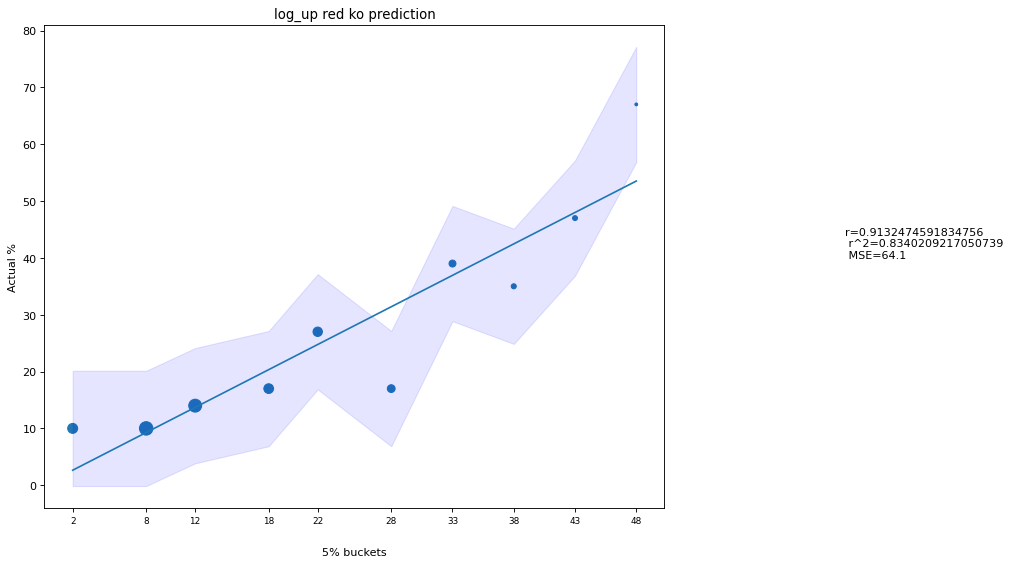

['rf_no']
rf_no
0% to 5%: 0% of 1 observations
5% to 10%: 17% of 30 observations
10% to 15%: 18% of 296 observations
15% to 20%: 18% of 205 observations
20% to 25%: 23% of 102 observations
25% to 30%: 6% of 16 observations
30% to 35%: 0% of 1 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[30, 296, 205, 102, 16]
[8, 12, 18, 22, 28]
[17, 18, 18, 23, 6]


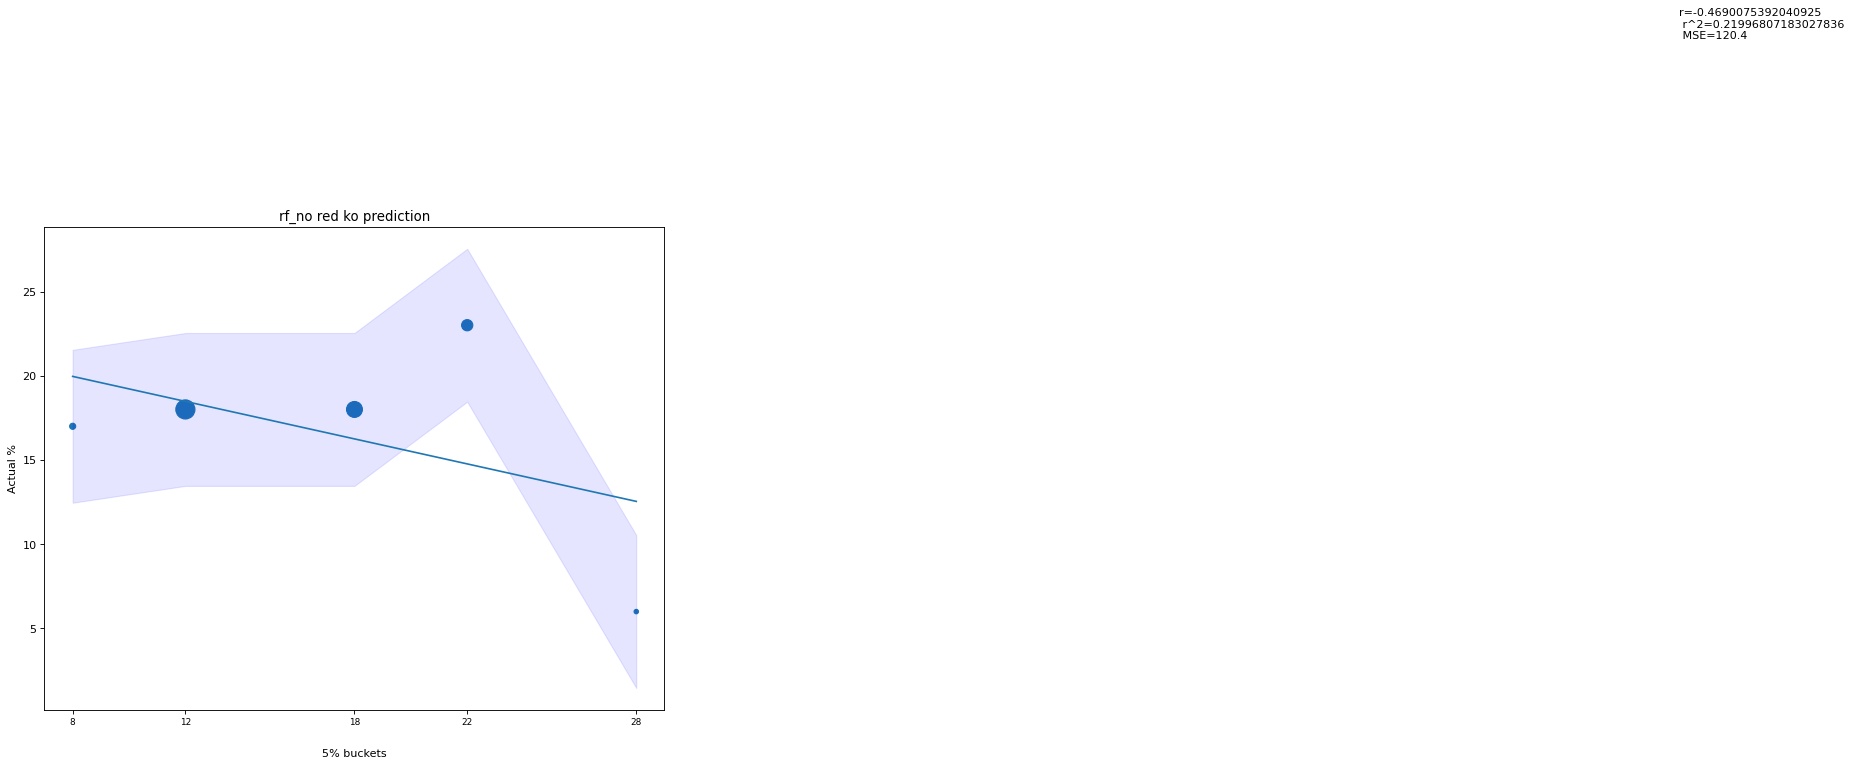

['rf_rand']
rf_rand
0% to 5%: 50% of 2 observations
5% to 10%: 20% of 145 observations
10% to 15%: 17% of 331 observations
15% to 20%: 15% of 124 observations
20% to 25%: 30% of 43 observations
25% to 30%: 20% of 5 observations
30% to 35%: 0% of 1 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 1 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[145, 331, 124, 43, 5]
[8, 12, 18, 22, 28]
[20, 17, 15, 30, 20]


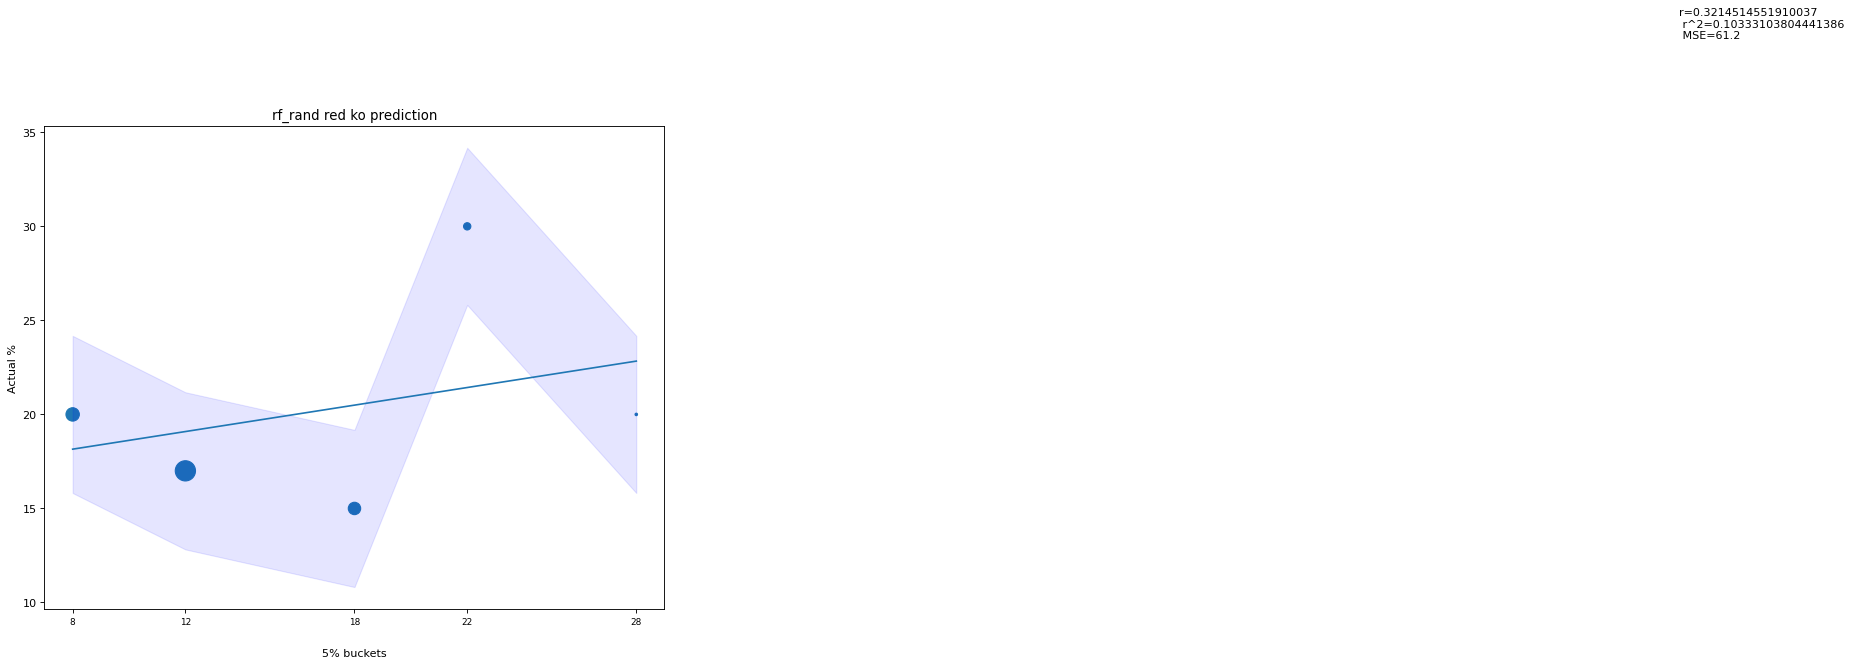

['rf_up']
rf_up
0% to 5%: 100% of 1 observations
5% to 10%: 20% of 70 observations
10% to 15%: 16% of 334 observations
15% to 20%: 24% of 167 observations
20% to 25%: 16% of 75 observations
25% to 30%: 0% of 4 observations
30% to 35%: 0% of 1 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[70, 334, 167, 75]
[8, 12, 18, 22]
[20, 16, 24, 16]


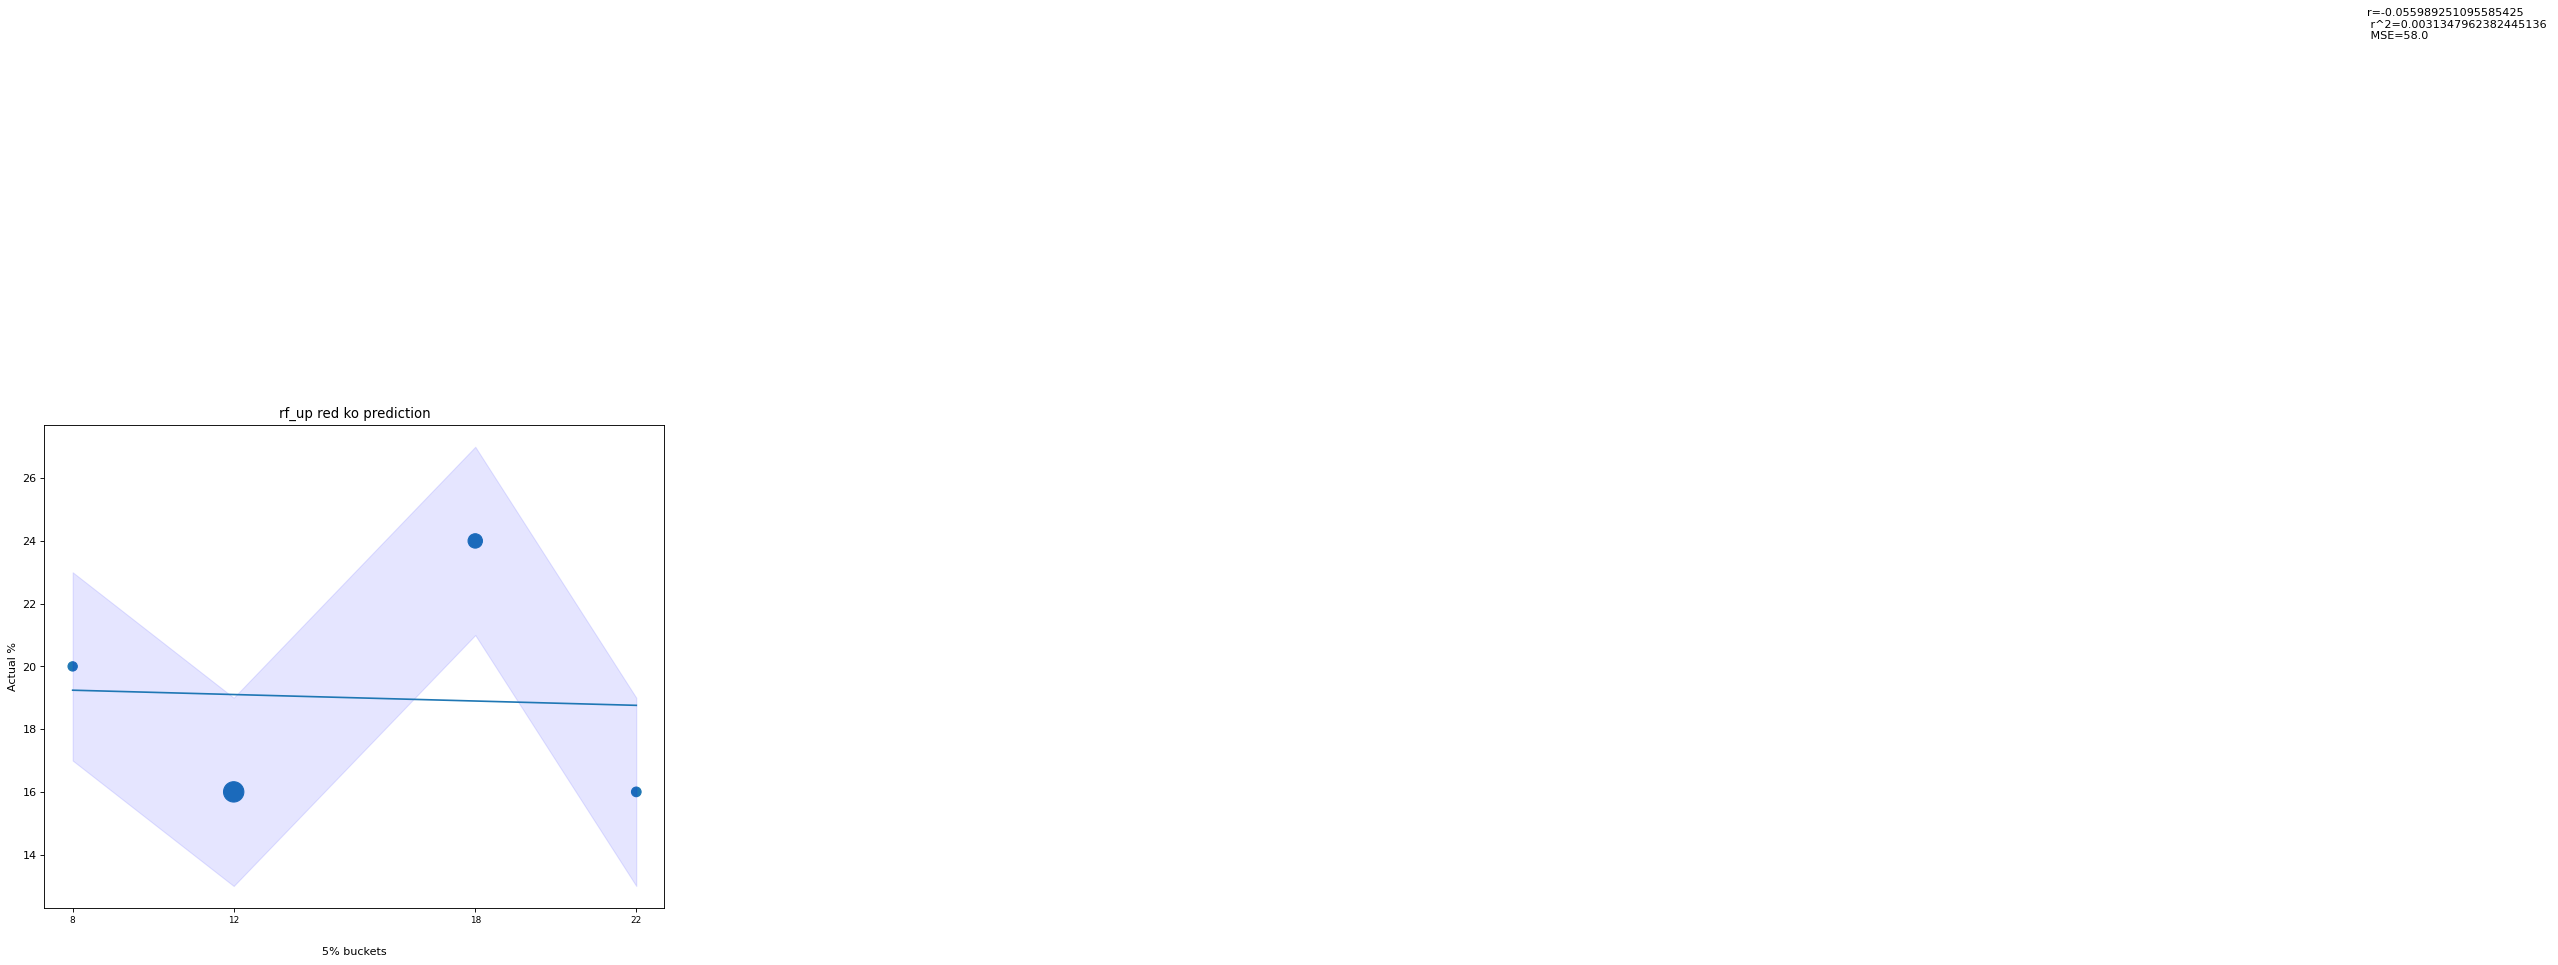

['mlp_no']
mlp_no
0% to 5%: 10% of 135 observations
5% to 10%: 13% of 112 observations
10% to 15%: 15% of 96 observations
15% to 20%: 20% of 46 observations
20% to 25%: 30% of 43 observations
25% to 30%: 25% of 32 observations
30% to 35%: 22% of 37 observations
35% to 40%: 10% of 21 observations
40% to 45%: 19% of 26 observations
45% to 50%: 47% of 19 observations
50% to 55%: 19% of 16 observations
55% to 60%: 33% of 12 observations
60% to 65%: 0% of 7 observations
65% to 70%: 25% of 12 observations
70% to 75%: 33% of 12 observations
75% to 80%: 22% of 9 observations
80% to 85%: 50% of 8 observations
85% to 90%: 0% of 2 observations
90% to 95%: 40% of 5 observations
95% to 100%: 100% of 1 observations
[135, 112, 96, 46, 43, 32, 37, 21, 26, 19, 16, 12, 7, 12, 12, 9, 8, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 92]
[10, 13, 15, 20, 30, 25, 22, 10, 19, 47, 19, 33, 0, 25, 33, 22, 50, 40]


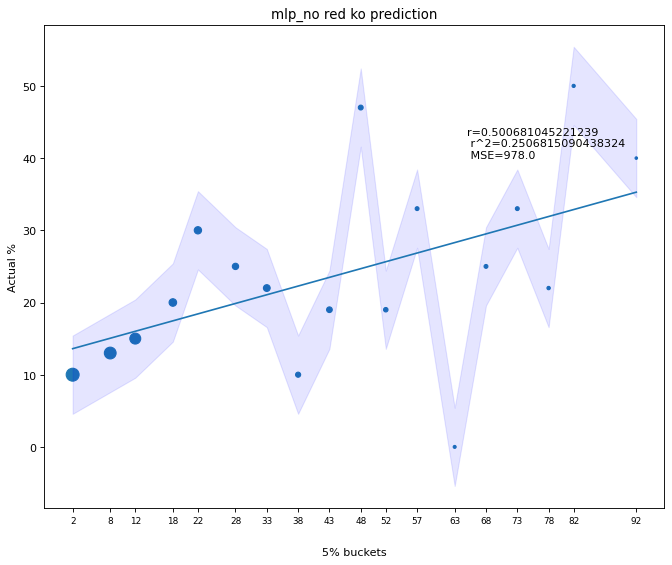

['mlp_rand']
mlp_rand
0% to 5%: 10% of 183 observations
5% to 10%: 19% of 138 observations
10% to 15%: 24% of 102 observations
15% to 20%: 12% of 40 observations
20% to 25%: 18% of 45 observations
25% to 30%: 21% of 33 observations
30% to 35%: 17% of 24 observations
35% to 40%: 17% of 12 observations
40% to 45%: 27% of 15 observations
45% to 50%: 56% of 9 observations
50% to 55%: 27% of 11 observations
55% to 60%: 44% of 9 observations
60% to 65%: 36% of 11 observations
65% to 70%: 14% of 7 observations
70% to 75%: 67% of 3 observations
75% to 80%: 33% of 3 observations
80% to 85%: 0% of 4 observations
85% to 90%: 50% of 2 observations
90% to 95%: 100% of 1 observations
95% to 100%: 0% of 0 observations
[183, 138, 102, 40, 45, 33, 24, 12, 15, 9, 11, 9, 11, 7]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68]
[10, 19, 24, 12, 18, 21, 17, 17, 27, 56, 27, 44, 36, 14]


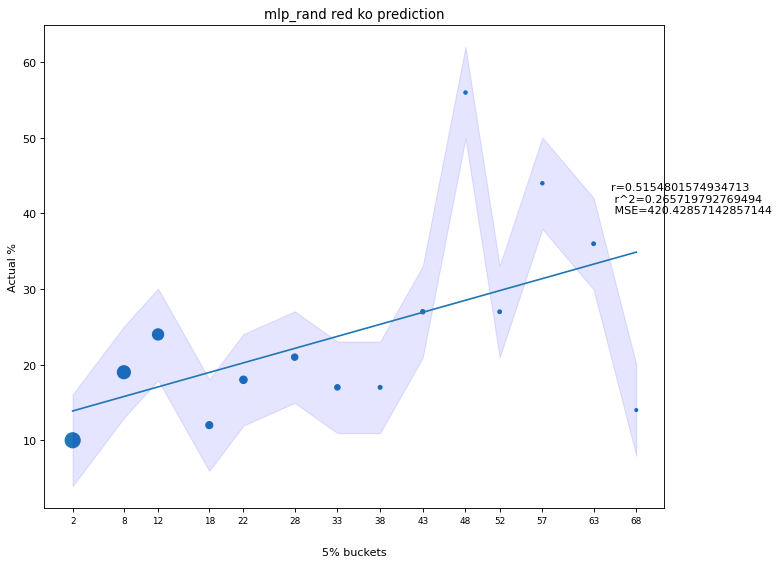

['mlp_up']
mlp_up
0% to 5%: 10% of 182 observations
5% to 10%: 13% of 104 observations
10% to 15%: 17% of 100 observations
15% to 20%: 13% of 38 observations
20% to 25%: 24% of 42 observations
25% to 30%: 37% of 27 observations
30% to 35%: 24% of 25 observations
35% to 40%: 7% of 14 observations
40% to 45%: 11% of 18 observations
45% to 50%: 33% of 24 observations
50% to 55%: 13% of 15 observations
55% to 60%: 28% of 18 observations
60% to 65%: 50% of 8 observations
65% to 70%: 44% of 9 observations
70% to 75%: 50% of 4 observations
75% to 80%: 56% of 7 observations
80% to 85%: 33% of 9 observations
85% to 90%: 33% of 3 observations
90% to 95%: 67% of 3 observations
95% to 100%: 100% of 1 observations
[182, 104, 100, 38, 42, 27, 25, 14, 18, 24, 15, 18, 8, 9, 7, 9]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 78, 82]
[10, 13, 17, 13, 24, 37, 24, 7, 11, 33, 13, 28, 50, 44, 56, 33]


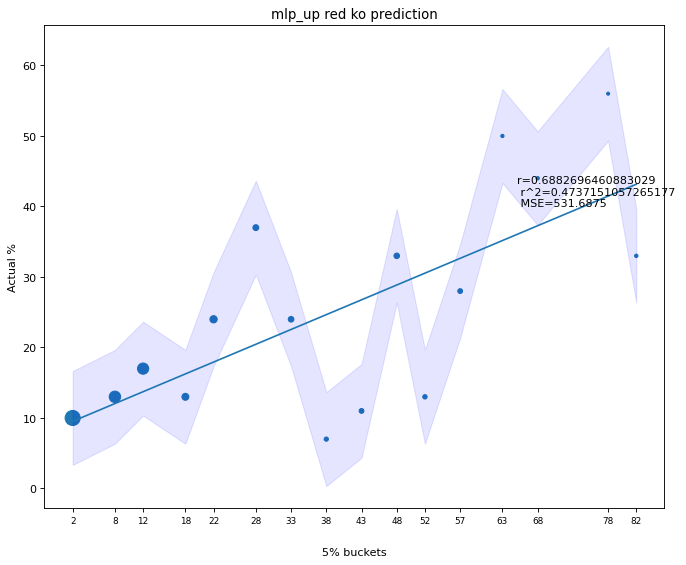

['nn_no']
nn_no
0% to 5%: 9% of 33 observations
5% to 10%: 9% of 105 observations
10% to 15%: 12% of 126 observations
15% to 20%: 14% of 77 observations
20% to 25%: 20% of 89 observations
25% to 30%: 17% of 58 observations
30% to 35%: 19% of 37 observations
35% to 40%: 21% of 34 observations
40% to 45%: 46% of 28 observations
45% to 50%: 50% of 14 observations
50% to 55%: 39% of 18 observations
55% to 60%: 22% of 9 observations
60% to 65%: 40% of 5 observations
65% to 70%: 25% of 8 observations
70% to 75%: 100% of 2 observations
75% to 80%: 67% of 3 observations
80% to 85%: 0% of 1 observations
85% to 90%: 0% of 0 observations
90% to 95%: 100% of 1 observations
95% to 100%: 0% of 0 observations
[33, 105, 126, 77, 89, 58, 37, 34, 28, 14, 18, 9, 5, 8]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68]
[9, 9, 12, 14, 20, 17, 19, 21, 46, 50, 39, 22, 40, 25]


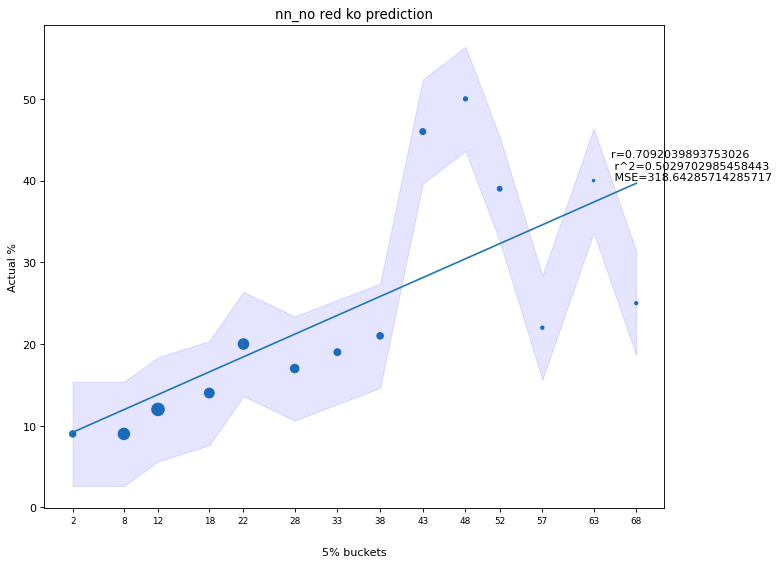

['nn_rand']
nn_rand
0% to 5%: 3% of 60 observations
5% to 10%: 14% of 156 observations
10% to 15%: 16% of 149 observations
15% to 20%: 23% of 75 observations
20% to 25%: 22% of 63 observations
25% to 30%: 24% of 54 observations
30% to 35%: 17% of 30 observations
35% to 40%: 0% of 15 observations
40% to 45%: 55% of 11 observations
45% to 50%: 33% of 9 observations
50% to 55%: 20% of 5 observations
55% to 60%: 50% of 10 observations
60% to 65%: 50% of 2 observations
65% to 70%: 0% of 0 observations
70% to 75%: 100% of 1 observations
75% to 80%: 0% of 0 observations
80% to 85%: 100% of 2 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[60, 156, 149, 75, 63, 54, 30, 15, 11, 9, 5, 10]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57]
[3, 14, 16, 23, 22, 24, 17, 0, 55, 33, 20, 50]


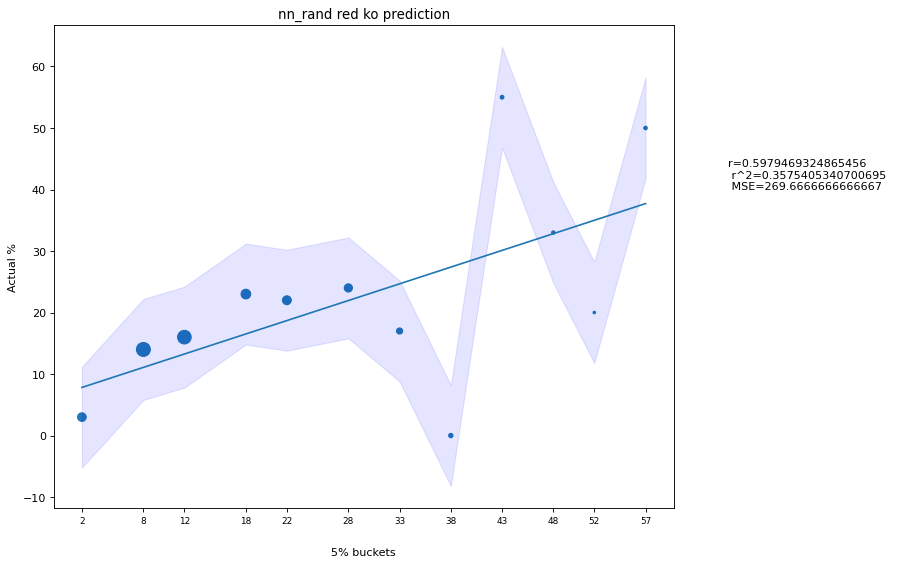

['nn_up']
nn_up
0% to 5%: 7% of 87 observations
5% to 10%: 16% of 128 observations
10% to 15%: 13% of 121 observations
15% to 20%: 17% of 64 observations
20% to 25%: 24% of 68 observations
25% to 30%: 30% of 50 observations
30% to 35%: 26% of 35 observations
35% to 40%: 5% of 22 observations
40% to 45%: 20% of 15 observations
45% to 50%: 23% of 13 observations
50% to 55%: 38% of 16 observations
55% to 60%: 56% of 7 observations
60% to 65%: 50% of 4 observations
65% to 70%: 50% of 4 observations
70% to 75%: 60% of 5 observations
75% to 80%: 0% of 1 observations
80% to 85%: 100% of 1 observations
85% to 90%: 0% of 1 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[87, 128, 121, 64, 68, 50, 35, 22, 15, 13, 16, 7, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 73]
[7, 16, 13, 17, 24, 30, 26, 5, 20, 23, 38, 56, 60]


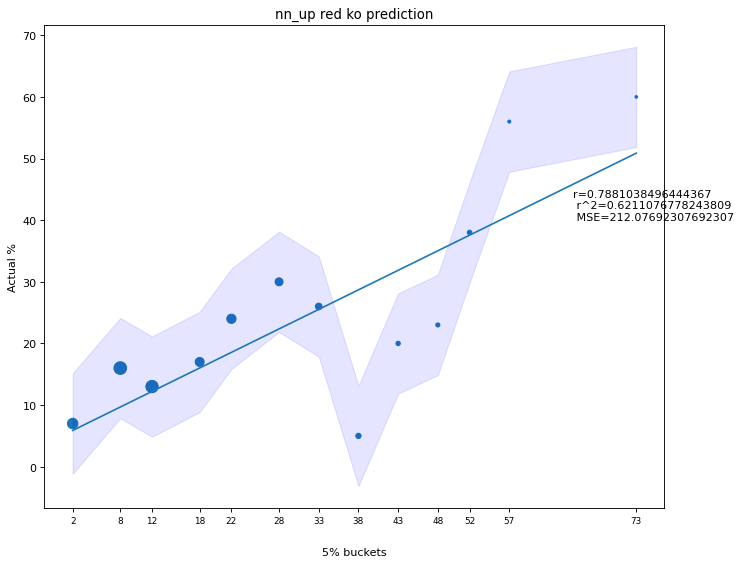

['mix_no']
mix_no
0% to 5%: 0% of 0 observations
5% to 10%: 5% of 55 observations
10% to 15%: 10% of 165 observations
15% to 20%: 22% of 103 observations
20% to 25%: 17% of 113 observations
25% to 30%: 16% of 80 observations
30% to 35%: 32% of 57 observations
35% to 40%: 35% of 31 observations
40% to 45%: 38% of 13 observations
45% to 50%: 40% of 10 observations
50% to 55%: 40% of 5 observations
55% to 60%: 33% of 3 observations
60% to 65%: 100% of 1 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[55, 165, 103, 113, 80, 57, 31, 13, 10, 5]
[8, 12, 18, 22, 28, 33, 38, 43, 48, 52]
[5, 10, 22, 17, 16, 32, 35, 38, 40, 40]


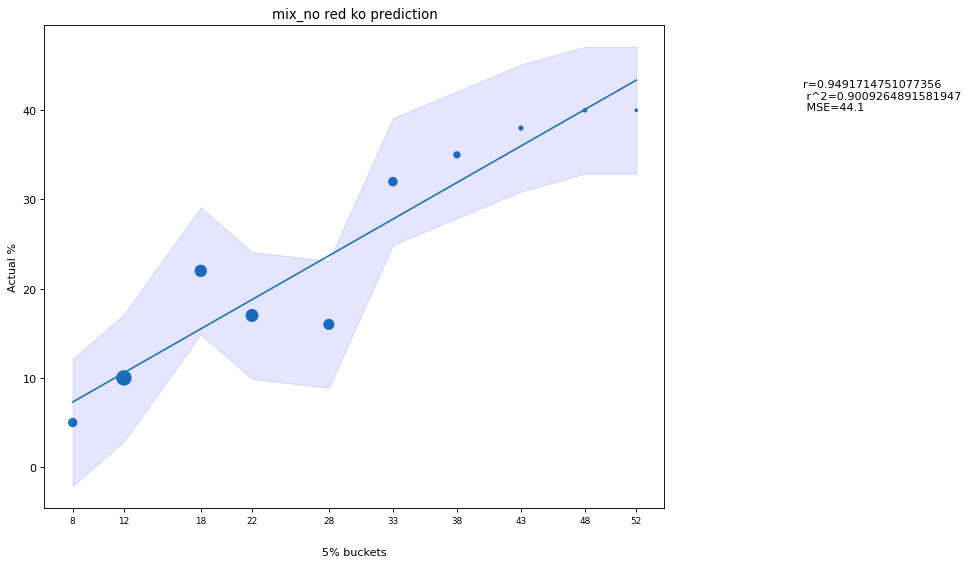

['mix_rand']
mix_rand
0% to 5%: 0% of 5 observations
5% to 10%: 9% of 129 observations
10% to 15%: 13% of 209 observations
15% to 20%: 21% of 99 observations
20% to 25%: 19% of 98 observations
25% to 30%: 33% of 54 observations
30% to 35%: 36% of 22 observations
35% to 40%: 67% of 9 observations
40% to 45%: 27% of 11 observations
45% to 50%: 75% of 4 observations
50% to 55%: 0% of 0 observations
55% to 60%: 100% of 1 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[5, 129, 209, 99, 98, 54, 22, 9, 11]
[2, 8, 12, 18, 22, 28, 33, 38, 43]
[0, 9, 13, 21, 19, 33, 36, 67, 27]


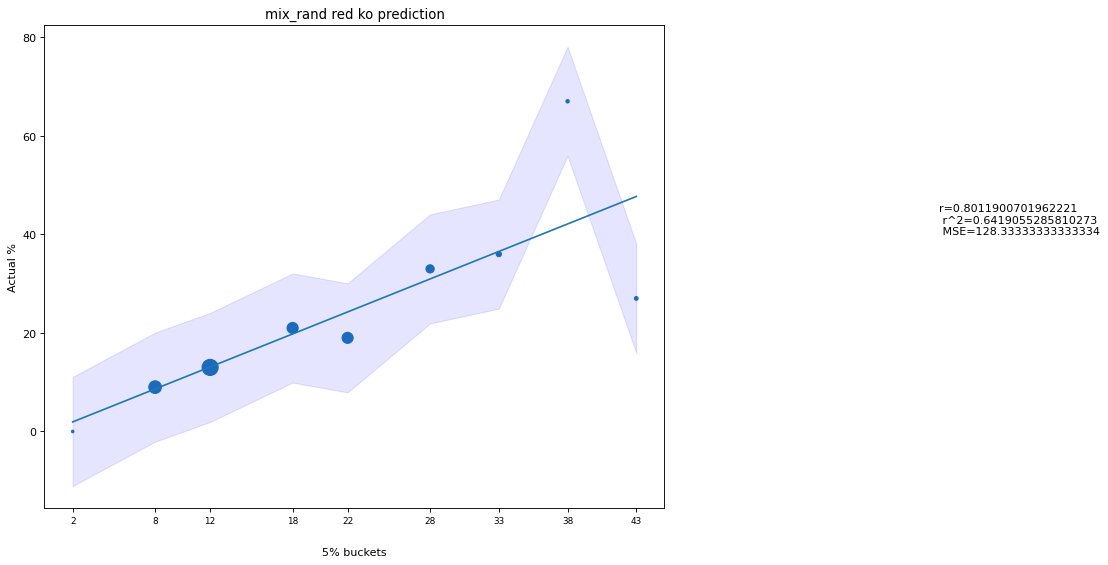

['mix_up']
mix_up
0% to 5%: 0% of 0 observations
5% to 10%: 7% of 56 observations
10% to 15%: 12% of 194 observations
15% to 20%: 15% of 132 observations
20% to 25%: 21% of 118 observations
25% to 30%: 28% of 78 observations
30% to 35%: 26% of 34 observations
35% to 40%: 41% of 17 observations
40% to 45%: 67% of 12 observations
45% to 50%: 0% of 1 observations
50% to 55%: 0% of 1 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[56, 194, 132, 118, 78, 34, 17, 12]
[8, 12, 18, 22, 28, 33, 38, 43]
[7, 12, 15, 21, 28, 26, 41, 67]


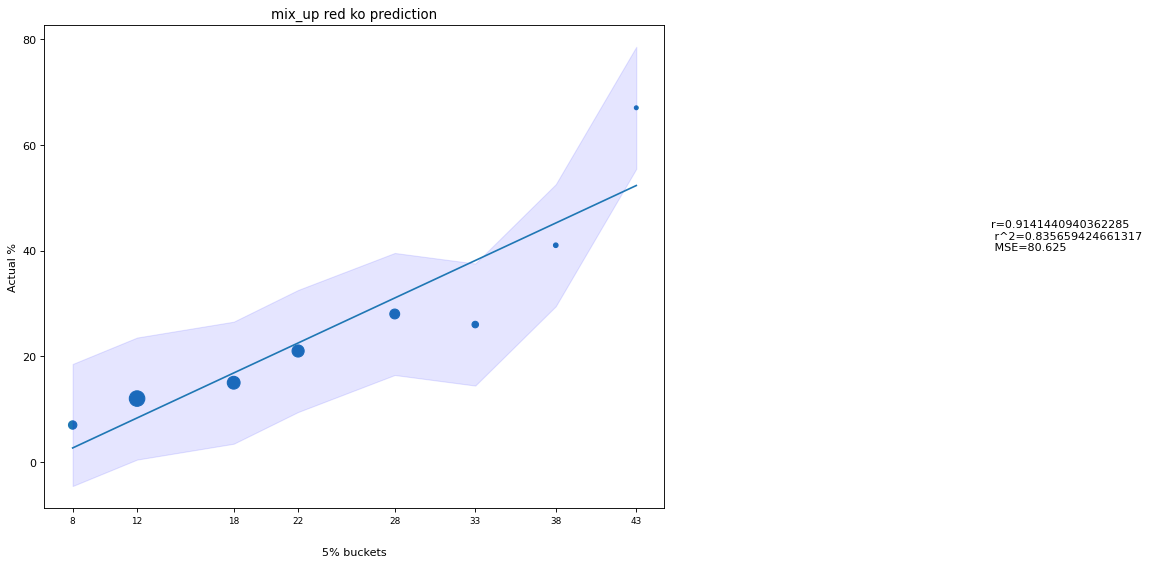

['combined']
combined
0% to 5%: 0% of 1 observations
5% to 10%: 4% of 96 observations
10% to 15%: 15% of 197 observations
15% to 20%: 18% of 125 observations
20% to 25%: 17% of 112 observations
25% to 30%: 31% of 58 observations
30% to 35%: 35% of 31 observations
35% to 40%: 47% of 19 observations
40% to 45%: 67% of 3 observations
45% to 50%: 33% of 3 observations
50% to 55%: 67% of 3 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[96, 197, 125, 112, 58, 31, 19]
[8, 12, 18, 22, 28, 33, 38]
[4, 15, 18, 17, 31, 35, 47]


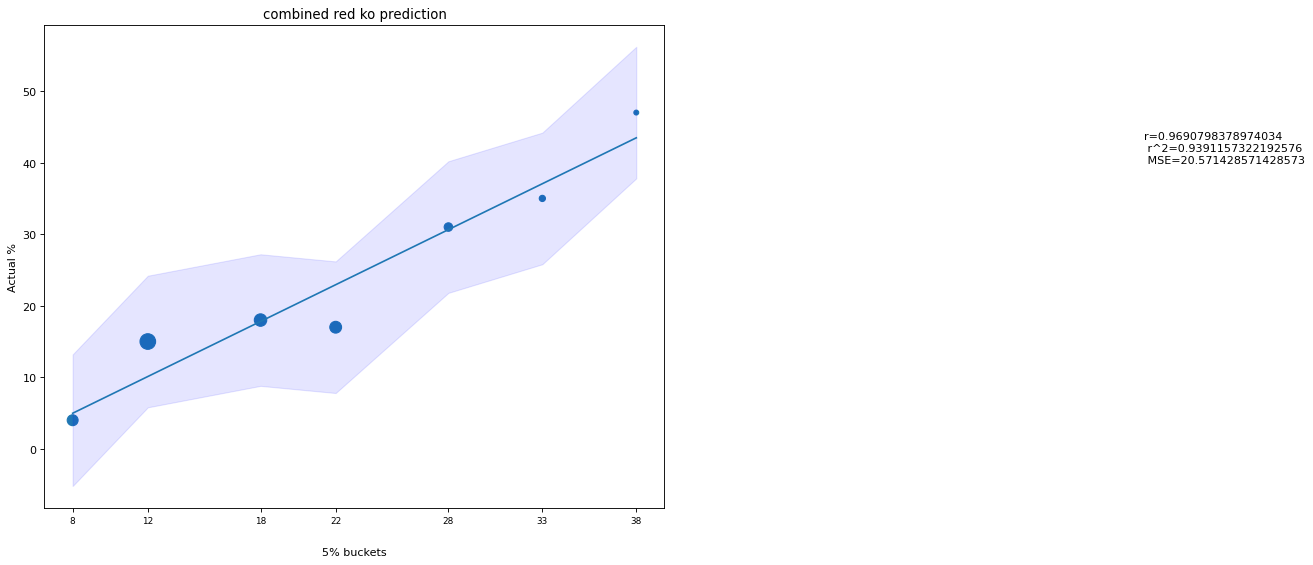

In [77]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
    print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["red_ko_pct"] >= x]
        point_to_point = point_up[point_up["red_ko_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - KO/TKO"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

    print(observations)
    print(half_points)
    print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
    plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} red ko prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [78]:
red_ko_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

red_ko_df = pd.DataFrame(red_ko_dict)
red_ko_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.550705   0.303276    195.700000
1     knn_rand -0.123854   0.015340    240.666667
2       knn_up  0.511430   0.261560    152.333333
3       log_no  0.748928   0.560893    175.416667
4     log_rand  0.960456   0.922476     33.400000
5       log_up  0.913247   0.834021     64.100000
6        rf_no -0.469008   0.219968    120.400000
7      rf_rand  0.321451   0.103331     61.200000
8        rf_up -0.055989   0.003135     58.000000
9       mlp_no  0.500681   0.250682    978.000000
10    mlp_rand  0.515480   0.265720    420.428571
11      mlp_up  0.688270   0.473715    531.687500
12       nn_no  0.709204   0.502970    318.642857
13     nn_rand  0.597947   0.357541    269.666667
14       nn_up  0.788104   0.621108    212.076923
15      mix_no  0.949171   0.900926     44.100000
16    mix_rand  0.801190   0.641906    128.333333
17      mix_up  0.914144   0.835659     80.625000
18    combined  0.969080   0.939116     20.571429

['knn_no']
knn_no
0% to 5%: 8% of 106 observations
5% to 10%: 12% of 165 observations
10% to 15%: 13% of 260 observations
15% to 20%: 8% of 59 observations
20% to 25%: 17% of 40 observations
25% to 30%: 18% of 11 observations
30% to 35%: 38% of 8 observations
35% to 40%: 0% of 3 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[106, 165, 260, 59, 40, 11, 8]
[2, 8, 12, 18, 22, 28, 33]
[8, 12, 13, 8, 17, 18, 38]


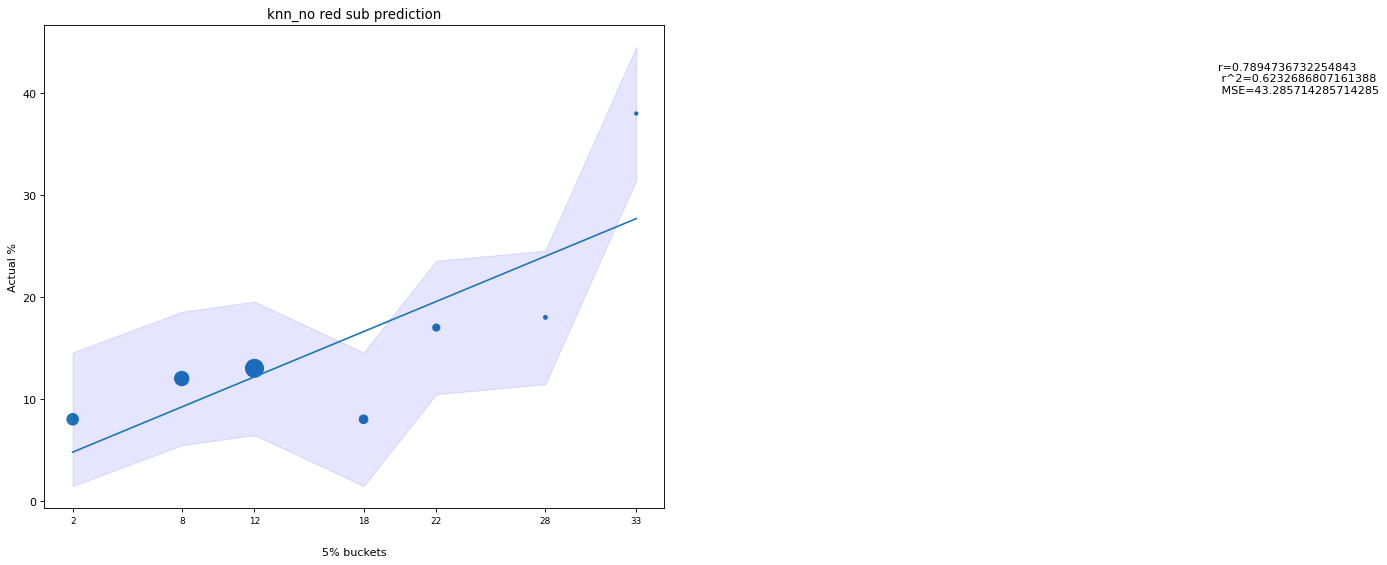

['knn_rand']
knn_rand
0% to 5%: 9% of 154 observations
5% to 10%: 8% of 186 observations
10% to 15%: 13% of 236 observations
15% to 20%: 24% of 46 observations
20% to 25%: 33% of 12 observations
25% to 30%: 27% of 11 observations
30% to 35%: 0% of 4 observations
35% to 40%: 33% of 3 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[154, 186, 236, 46, 12, 11]
[2, 8, 12, 18, 22, 28]
[9, 8, 13, 24, 33, 27]


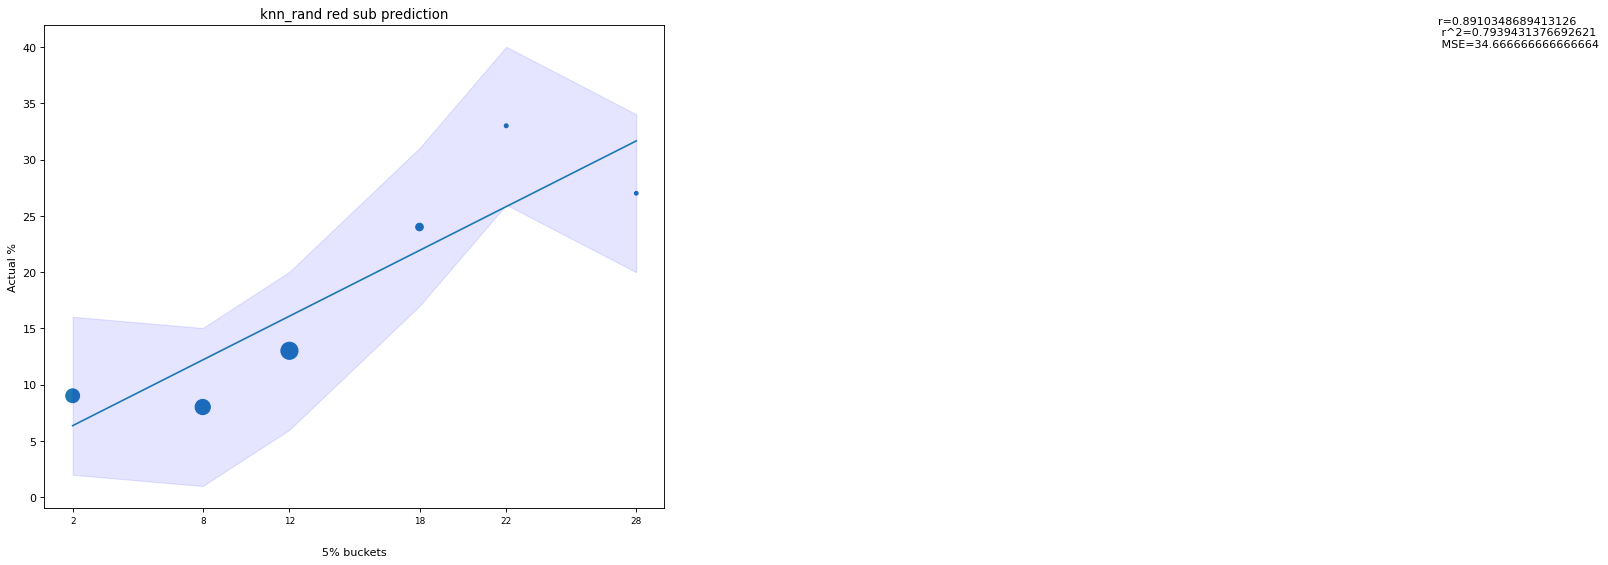

['knn_up']
knn_up
0% to 5%: 9% of 188 observations
5% to 10%: 10% of 189 observations
10% to 15%: 14% of 155 observations
15% to 20%: 18% of 68 observations
20% to 25%: 11% of 28 observations
25% to 30%: 25% of 16 observations
30% to 35%: 40% of 5 observations
35% to 40%: 0% of 2 observations
40% to 45%: 0% of 1 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[188, 189, 155, 68, 28, 16, 5]
[2, 8, 12, 18, 22, 28, 33]
[9, 10, 14, 18, 11, 25, 40]


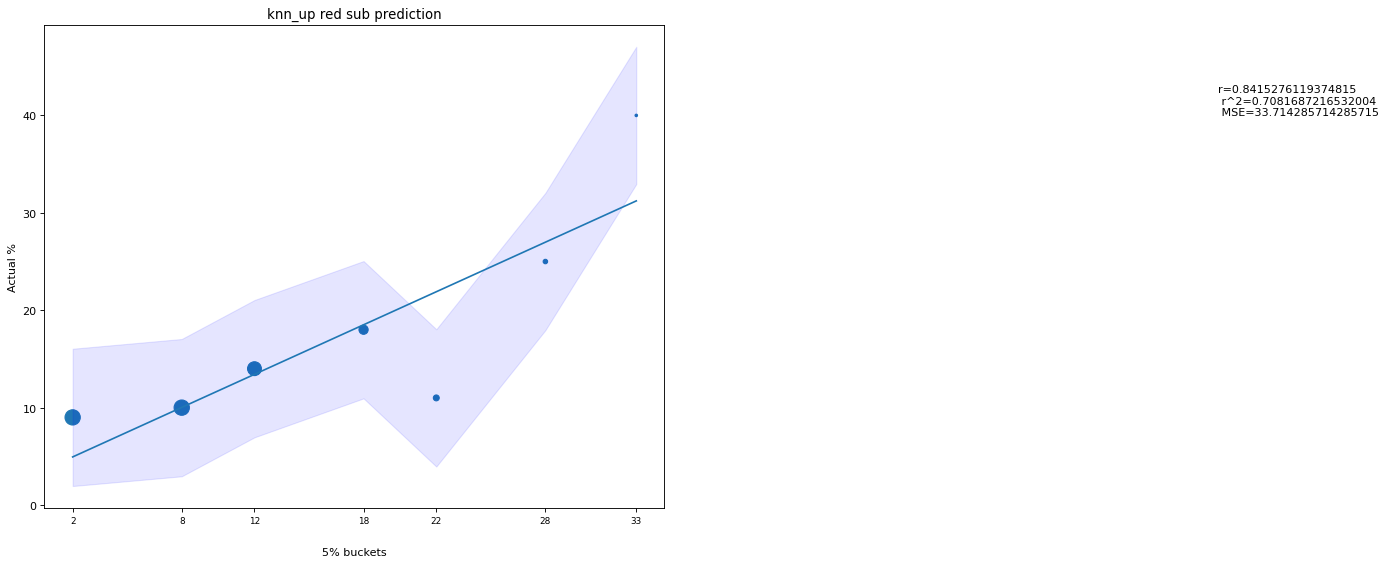

['log_no']
log_no
0% to 5%: 4% of 74 observations
5% to 10%: 7% of 243 observations
10% to 15%: 13% of 149 observations
15% to 20%: 19% of 58 observations
20% to 25%: 12% of 50 observations
25% to 30%: 18% of 28 observations
30% to 35%: 25% of 16 observations
35% to 40%: 50% of 12 observations
40% to 45%: 0% of 2 observations
45% to 50%: 28% of 7 observations
50% to 55%: 33% of 3 observations
55% to 60%: 50% of 2 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 1 observations
70% to 75%: 0% of 1 observations
75% to 80%: 0% of 1 observations
80% to 85%: 100% of 1 observations
85% to 90%: 0% of 1 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[74, 243, 149, 58, 50, 28, 16, 12, 7]
[2, 8, 12, 18, 22, 28, 33, 38, 48]
[4, 7, 13, 19, 12, 18, 25, 50, 28]


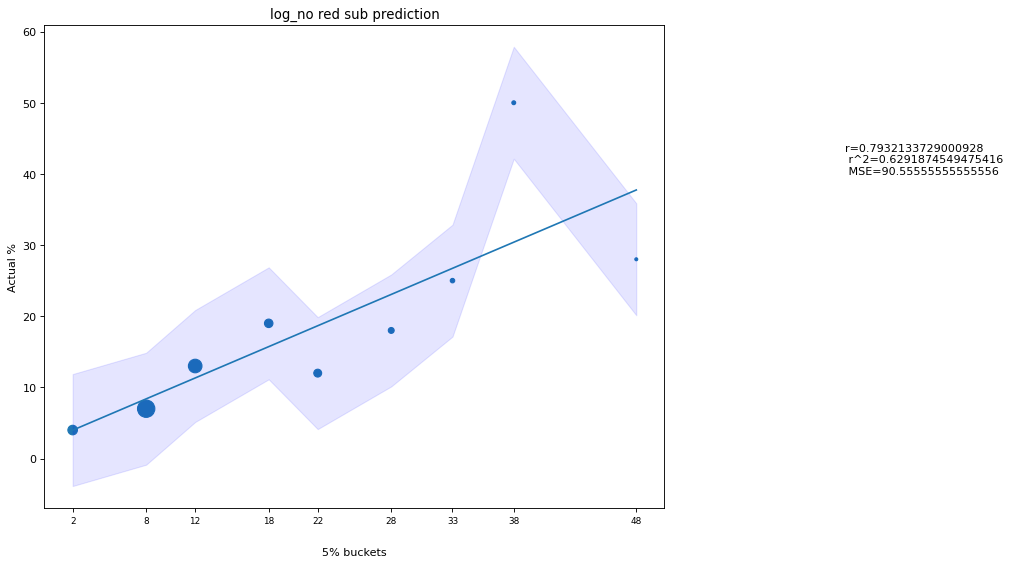

['log_rand']
log_rand
0% to 5%: 6% of 182 observations
5% to 10%: 9% of 247 observations
10% to 15%: 16% of 118 observations
15% to 20%: 21% of 34 observations
20% to 25%: 16% of 25 observations
25% to 30%: 28% of 17 observations
30% to 35%: 27% of 11 observations
35% to 40%: 33% of 3 observations
40% to 45%: 67% of 3 observations
45% to 50%: 25% of 4 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 2 observations
60% to 65%: 100% of 1 observations
65% to 70%: 100% of 1 observations
70% to 75%: 0% of 2 observations
75% to 80%: 100% of 1 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[182, 247, 118, 34, 25, 17, 11]
[2, 8, 12, 18, 22, 28, 33]
[6, 9, 16, 21, 16, 28, 27]


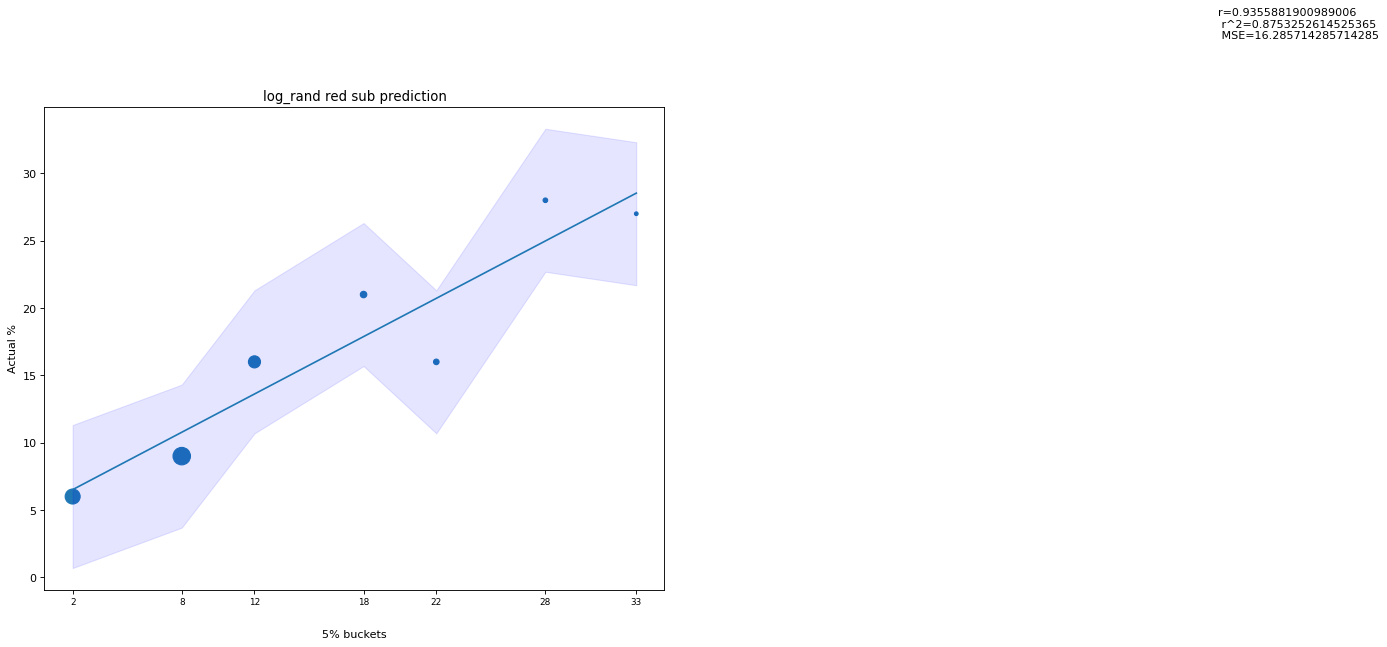

['log_up']
log_up
0% to 5%: 4% of 166 observations
5% to 10%: 10% of 243 observations
10% to 15%: 16% of 127 observations
15% to 20%: 14% of 36 observations
20% to 25%: 16% of 32 observations
25% to 30%: 37% of 19 observations
30% to 35%: 33% of 12 observations
35% to 40%: 67% of 3 observations
40% to 45%: 0% of 3 observations
45% to 50%: 40% of 5 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 1 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 1 observations
75% to 80%: 0% of 0 observations
80% to 85%: 50% of 2 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[166, 243, 127, 36, 32, 19, 12, 5]
[2, 8, 12, 18, 22, 28, 33, 48]
[4, 10, 16, 14, 16, 37, 33, 40]


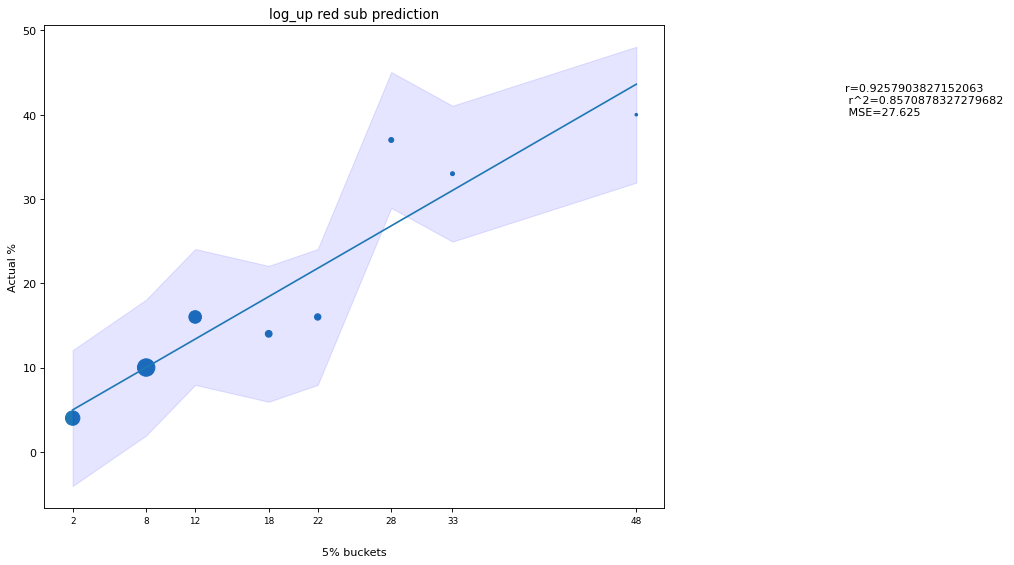

['rf_no']
rf_no
0% to 5%: 0% of 1 observations
5% to 10%: 0% of 5 observations
10% to 15%: 7% of 149 observations
15% to 20%: 14% of 205 observations
20% to 25%: 12% of 226 observations
25% to 30%: 17% of 58 observations
30% to 35%: 40% of 5 observations
35% to 40%: 100% of 1 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[5, 149, 205, 226, 58, 5]
[8, 12, 18, 22, 28, 33]
[0, 7, 14, 12, 17, 40]


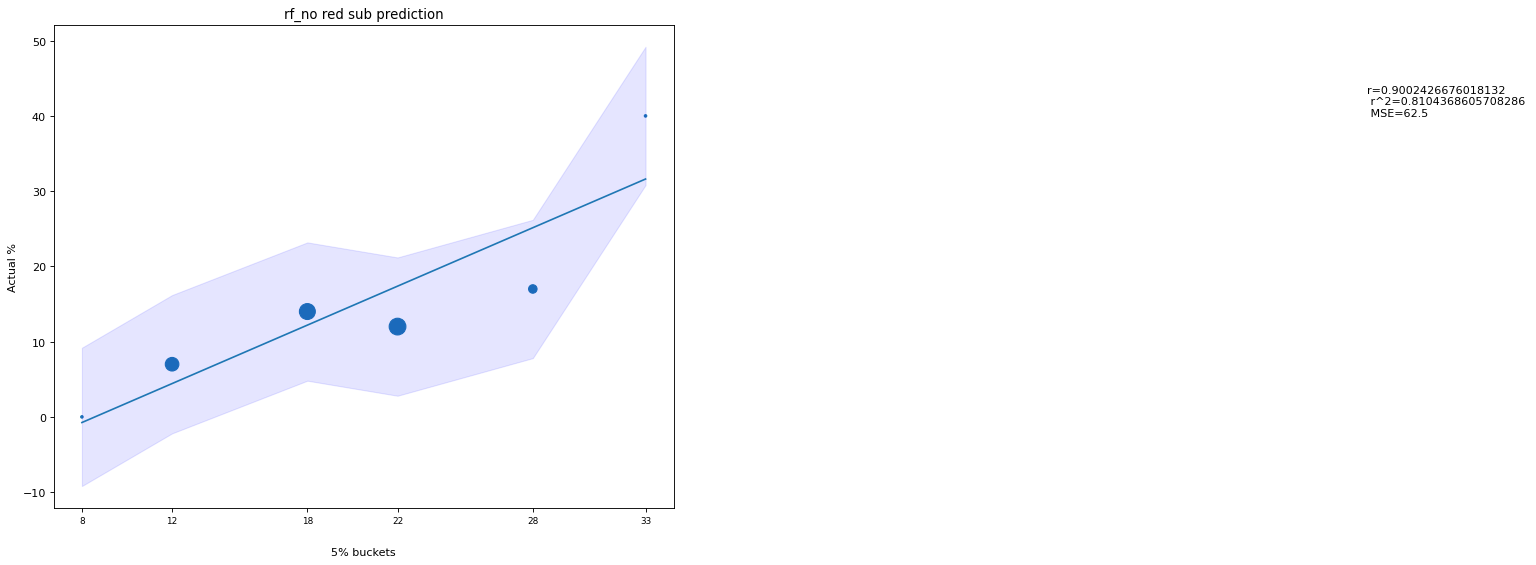

['rf_rand']
rf_rand
0% to 5%: 0% of 6 observations
5% to 10%: 16% of 69 observations
10% to 15%: 8% of 319 observations
15% to 20%: 14% of 177 observations
20% to 25%: 20% of 69 observations
25% to 30%: 11% of 9 observations
30% to 35%: 0% of 1 observations
35% to 40%: 0% of 1 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[6, 69, 319, 177, 69, 9]
[2, 8, 12, 18, 22, 28]
[0, 16, 8, 14, 20, 11]


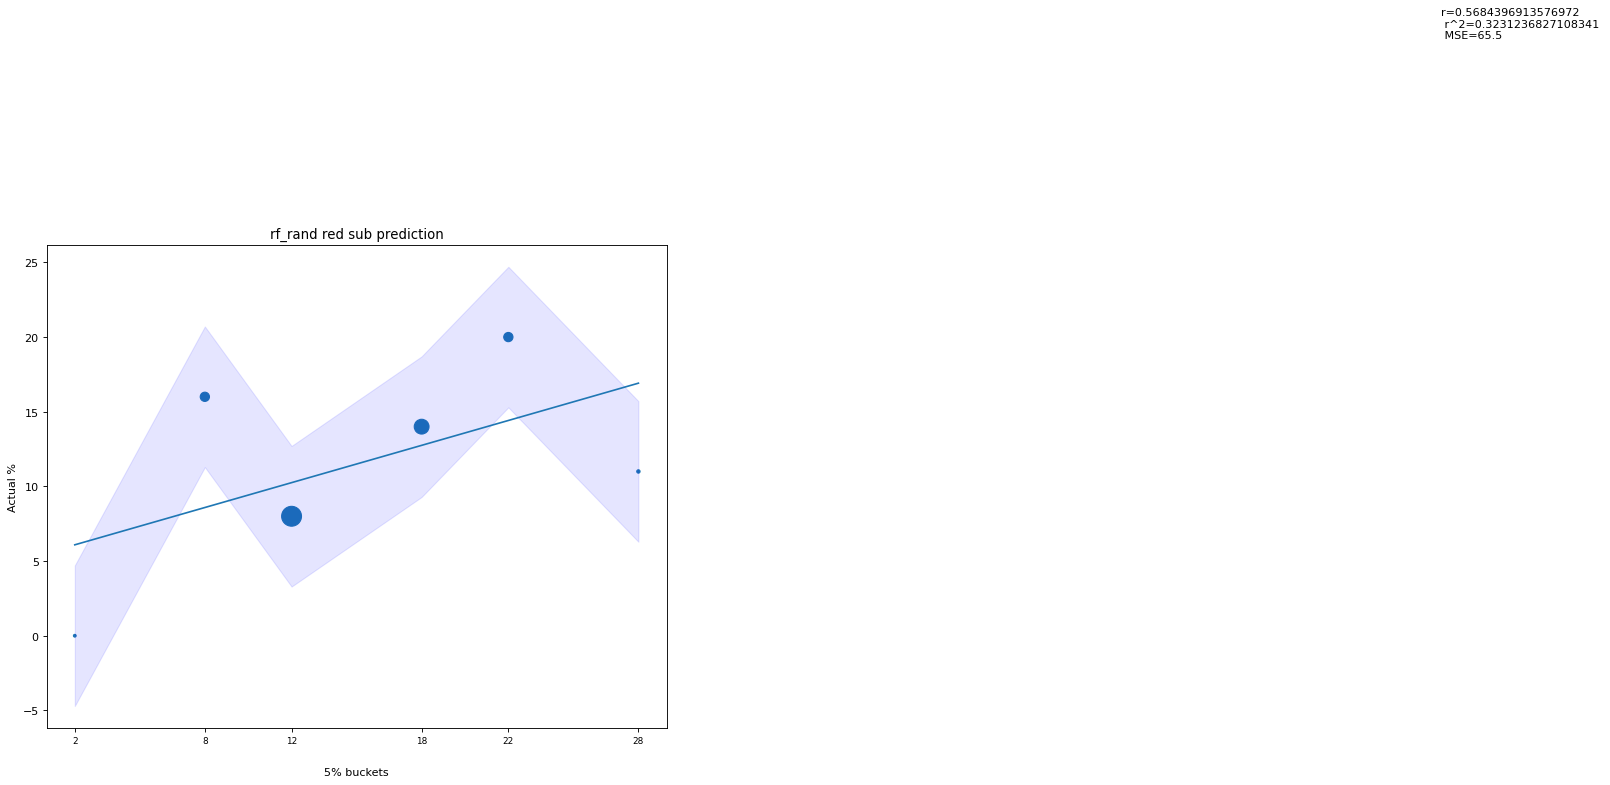

['rf_up']
rf_up
0% to 5%: 0% of 1 observations
5% to 10%: 0% of 15 observations
10% to 15%: 10% of 224 observations
15% to 20%: 14% of 237 observations
20% to 25%: 15% of 141 observations
25% to 30%: 6% of 32 observations
30% to 35%: 50% of 2 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[15, 224, 237, 141, 32]
[8, 12, 18, 22, 28]
[0, 10, 14, 15, 6]


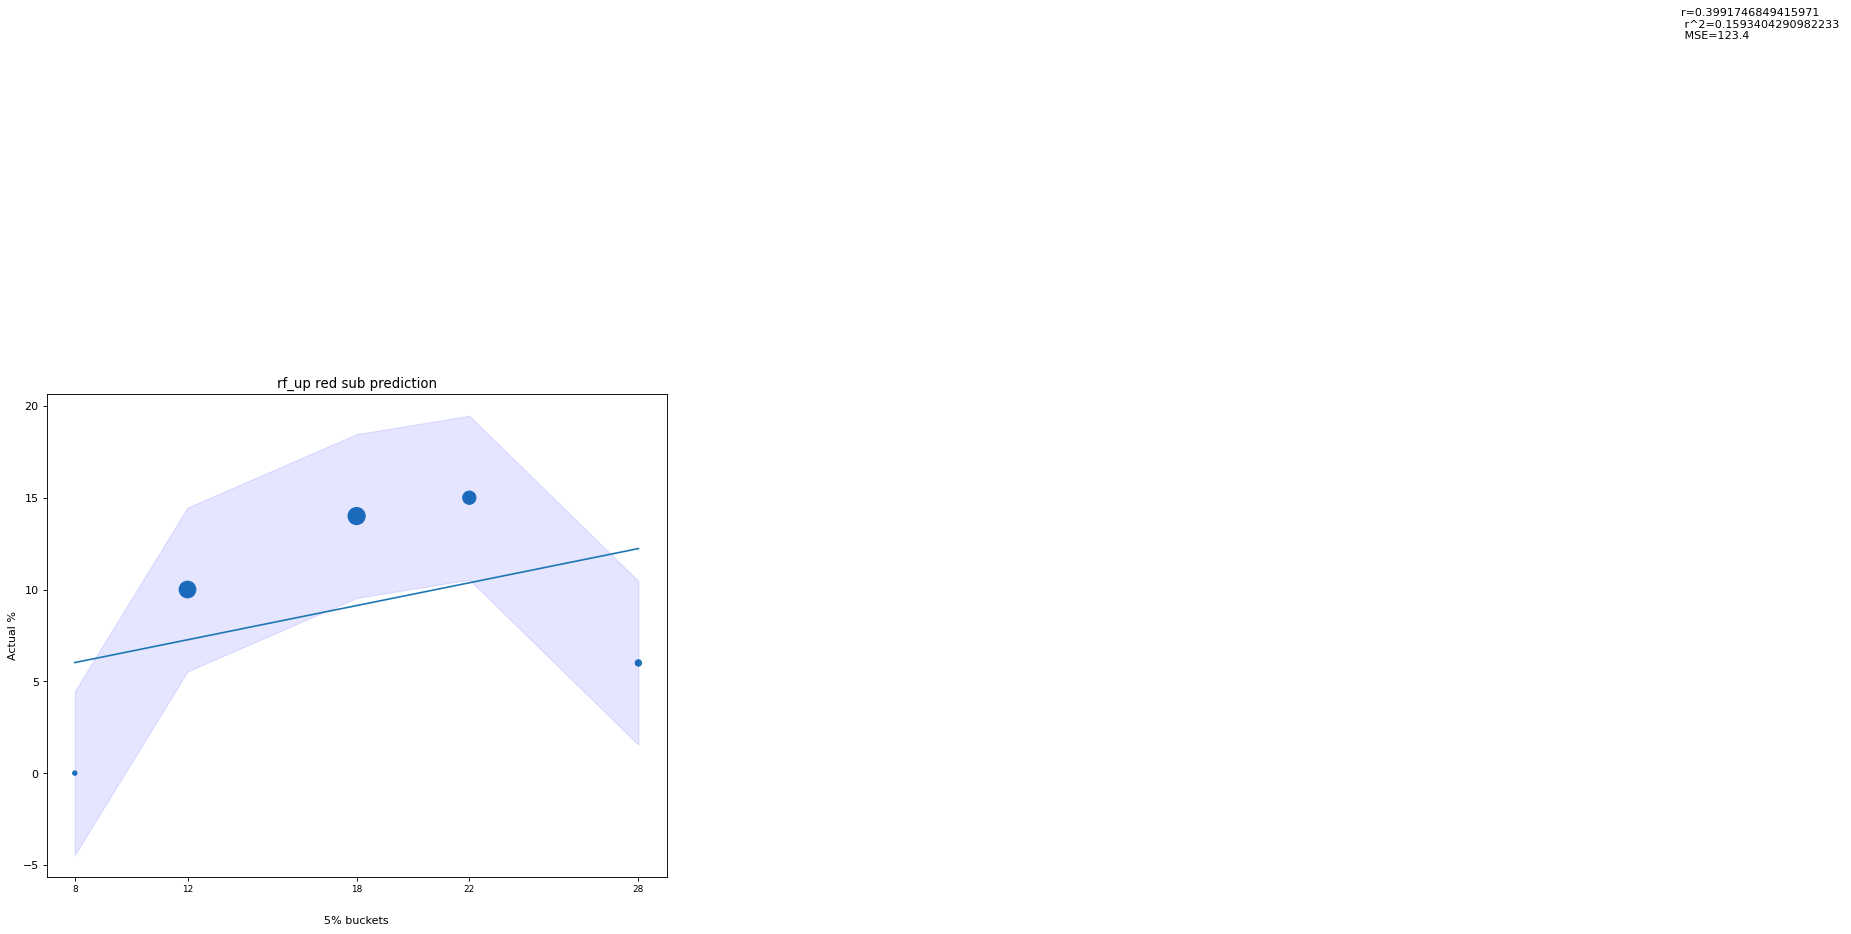

['mlp_no']
mlp_no
0% to 5%: 6% of 245 observations
5% to 10%: 12% of 141 observations
10% to 15%: 19% of 78 observations
15% to 20%: 16% of 37 observations
20% to 25%: 10% of 31 observations
25% to 30%: 11% of 27 observations
30% to 35%: 46% of 13 observations
35% to 40%: 40% of 10 observations
40% to 45%: 10% of 10 observations
45% to 50%: 14% of 14 observations
50% to 55%: 0% of 16 observations
55% to 60%: 10% of 10 observations
60% to 65%: 20% of 5 observations
65% to 70%: 0% of 5 observations
70% to 75%: 67% of 3 observations
75% to 80%: 50% of 2 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 1 observations
90% to 95%: 67% of 3 observations
95% to 100%: 0% of 0 observations
[245, 141, 78, 37, 31, 27, 13, 10, 10, 14, 16, 10, 5, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68]
[6, 12, 19, 16, 10, 11, 46, 40, 10, 14, 0, 10, 20, 0]


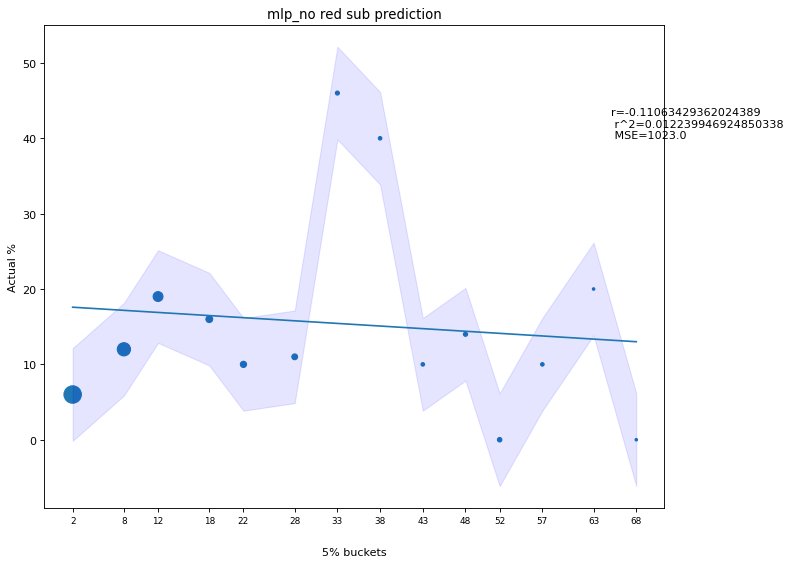

['mlp_rand']
mlp_rand
0% to 5%: 7% of 321 observations
5% to 10%: 16% of 148 observations
10% to 15%: 9% of 69 observations
15% to 20%: 18% of 28 observations
20% to 25%: 22% of 18 observations
25% to 30%: 28% of 17 observations
30% to 35%: 8% of 12 observations
35% to 40%: 40% of 5 observations
40% to 45%: 38% of 8 observations
45% to 50%: 50% of 2 observations
50% to 55%: 20% of 5 observations
55% to 60%: 20% of 5 observations
60% to 65%: 0% of 2 observations
65% to 70%: 50% of 2 observations
70% to 75%: 0% of 3 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 1 observations
90% to 95%: 50% of 2 observations
95% to 100%: 0% of 0 observations
[321, 148, 69, 28, 18, 17, 12, 5, 8, 5, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 52, 57]
[7, 16, 9, 18, 22, 28, 8, 40, 38, 20, 20]


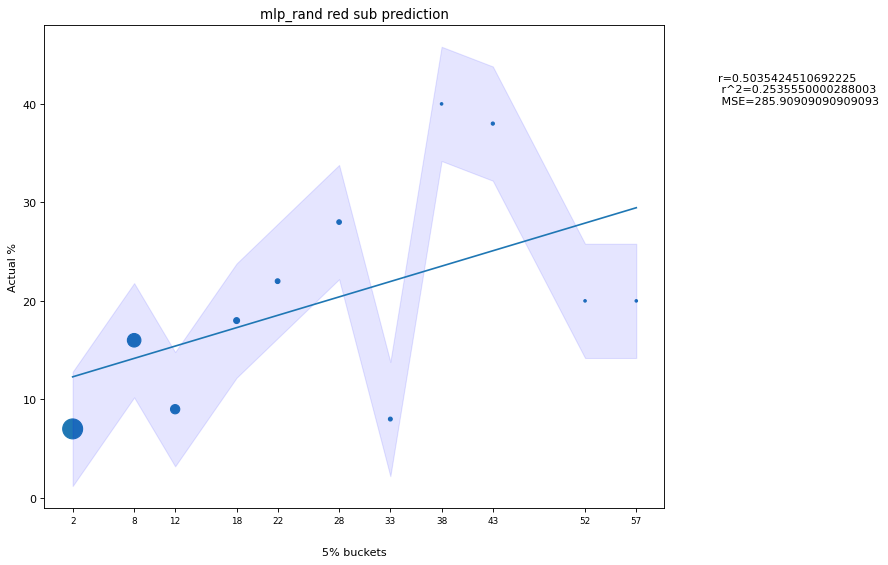

['mlp_up']
mlp_up
0% to 5%: 7% of 289 observations
5% to 10%: 13% of 127 observations
10% to 15%: 15% of 78 observations
15% to 20%: 20% of 25 observations
20% to 25%: 13% of 30 observations
25% to 30%: 23% of 22 observations
30% to 35%: 25% of 16 observations
35% to 40%: 0% of 10 observations
40% to 45%: 33% of 9 observations
45% to 50%: 36% of 11 observations
50% to 55%: 20% of 5 observations
55% to 60%: 17% of 6 observations
60% to 65%: 28% of 7 observations
65% to 70%: 0% of 4 observations
70% to 75%: 0% of 1 observations
75% to 80%: 25% of 4 observations
80% to 85%: 25% of 4 observations
85% to 90%: 0% of 1 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[289, 127, 78, 25, 30, 22, 16, 10, 9, 11, 5, 6, 7]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63]
[7, 13, 15, 20, 13, 23, 25, 0, 33, 36, 20, 17, 28]


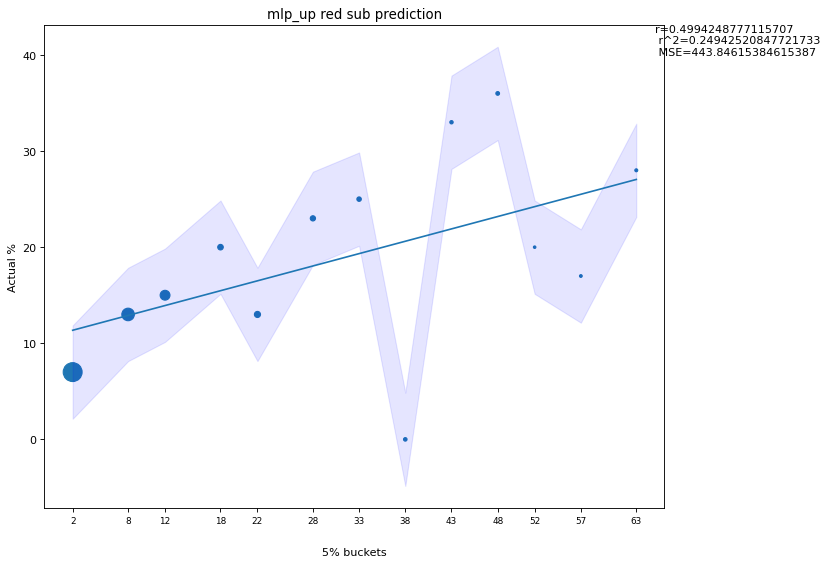

['nn_no']
nn_no
0% to 5%: 5% of 158 observations
5% to 10%: 8% of 180 observations
10% to 15%: 15% of 133 observations
15% to 20%: 21% of 47 observations
20% to 25%: 18% of 38 observations
25% to 30%: 17% of 36 observations
30% to 35%: 12% of 16 observations
35% to 40%: 21% of 14 observations
40% to 45%: 22% of 9 observations
45% to 50%: 75% of 4 observations
50% to 55%: 0% of 3 observations
55% to 60%: 0% of 2 observations
60% to 65%: 50% of 2 observations
65% to 70%: 0% of 2 observations
70% to 75%: 100% of 2 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[158, 180, 133, 47, 38, 36, 16, 14, 9]
[2, 8, 12, 18, 22, 28, 33, 38, 43]
[5, 8, 15, 21, 18, 17, 12, 21, 22]


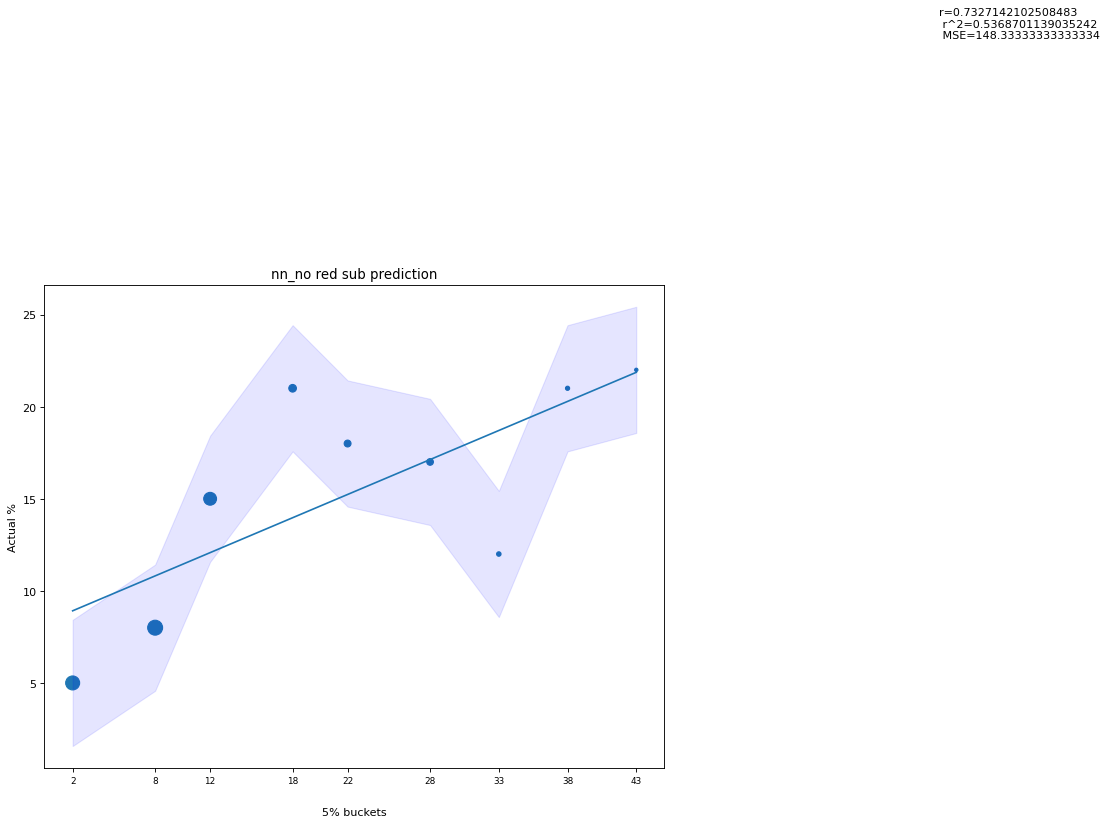

['nn_rand']
nn_rand
0% to 5%: 5% of 202 observations
5% to 10%: 11% of 211 observations
10% to 15%: 14% of 123 observations
15% to 20%: 13% of 38 observations
20% to 25%: 24% of 25 observations
25% to 30%: 38% of 26 observations
30% to 35%: 20% of 10 observations
35% to 40%: 20% of 5 observations
40% to 45%: 25% of 4 observations
45% to 50%: 33% of 3 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 1 observations
70% to 75%: 0% of 0 observations
75% to 80%: 33% of 3 observations
80% to 85%: 0% of 0 observations
85% to 90%: 100% of 1 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[202, 211, 123, 38, 25, 26, 10, 5]
[2, 8, 12, 18, 22, 28, 33, 38]
[5, 11, 14, 13, 24, 38, 20, 20]


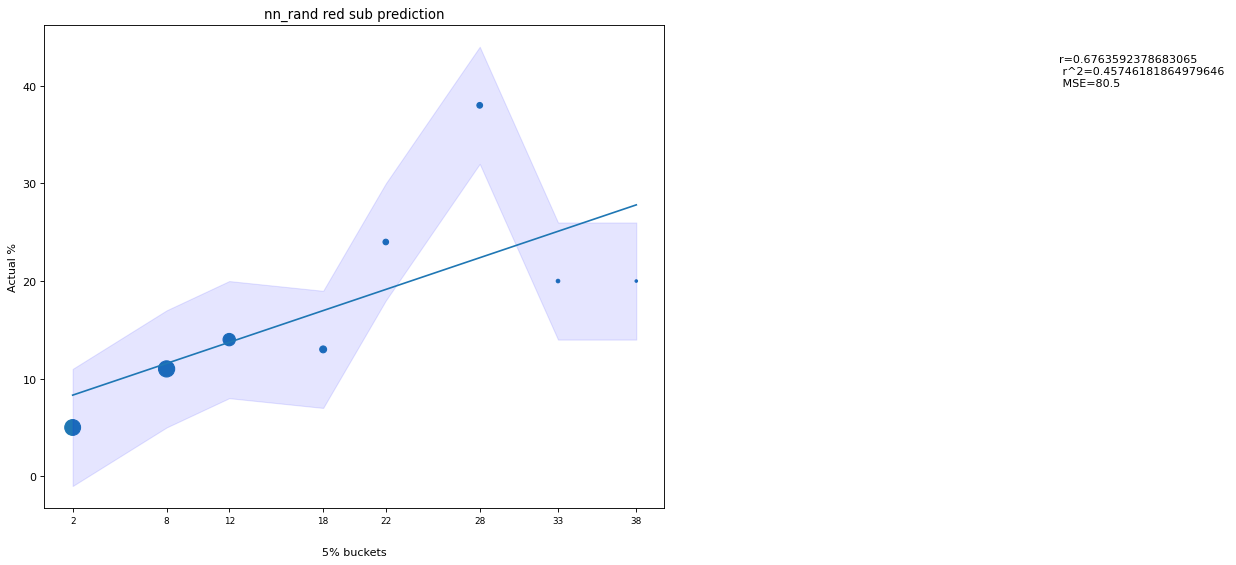

['nn_up']
nn_up
0% to 5%: 8% of 210 observations
5% to 10%: 7% of 185 observations
10% to 15%: 15% of 98 observations
15% to 20%: 25% of 55 observations
20% to 25%: 18% of 39 observations
25% to 30%: 13% of 23 observations
30% to 35%: 27% of 15 observations
35% to 40%: 0% of 3 observations
40% to 45%: 33% of 9 observations
45% to 50%: 33% of 3 observations
50% to 55%: 33% of 3 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 2 observations
65% to 70%: 0% of 1 observations
70% to 75%: 33% of 3 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[210, 185, 98, 55, 39, 23, 15, 9]
[2, 8, 12, 18, 22, 28, 33, 43]
[8, 7, 15, 25, 18, 13, 27, 33]


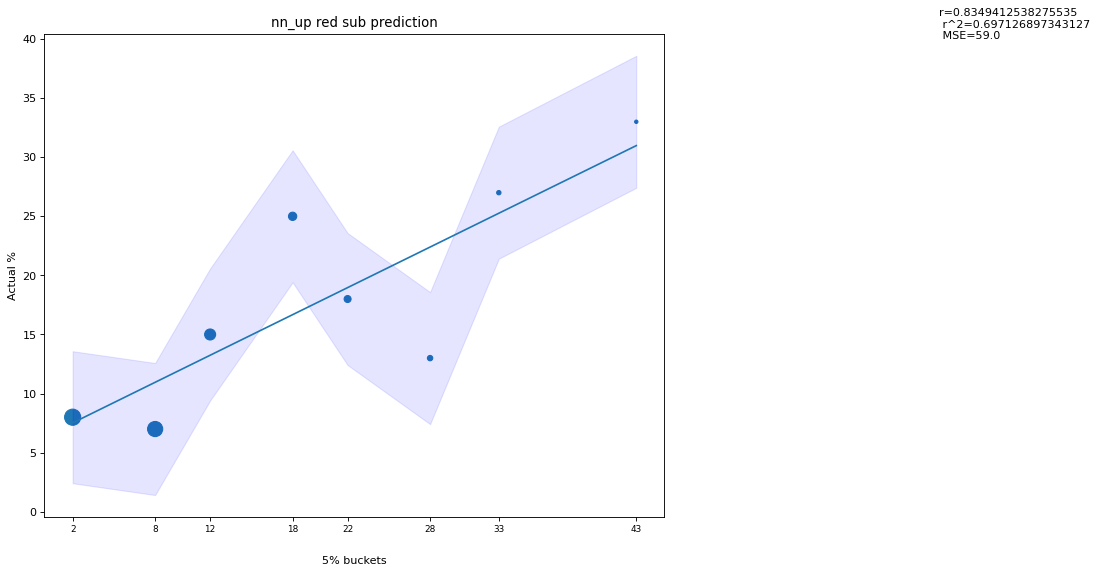

['mix_no']
mix_no
0% to 5%: 3% of 33 observations
5% to 10%: 6% of 223 observations
10% to 15%: 11% of 208 observations
15% to 20%: 20% of 60 observations
20% to 25%: 19% of 54 observations
25% to 30%: 27% of 44 observations
30% to 35%: 11% of 9 observations
35% to 40%: 40% of 10 observations
40% to 45%: 33% of 3 observations
45% to 50%: 20% of 5 observations
50% to 55%: 0% of 1 observations
55% to 60%: 0% of 1 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[33, 223, 208, 60, 54, 44, 9, 10, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 48]
[3, 6, 11, 20, 19, 27, 11, 40, 20]


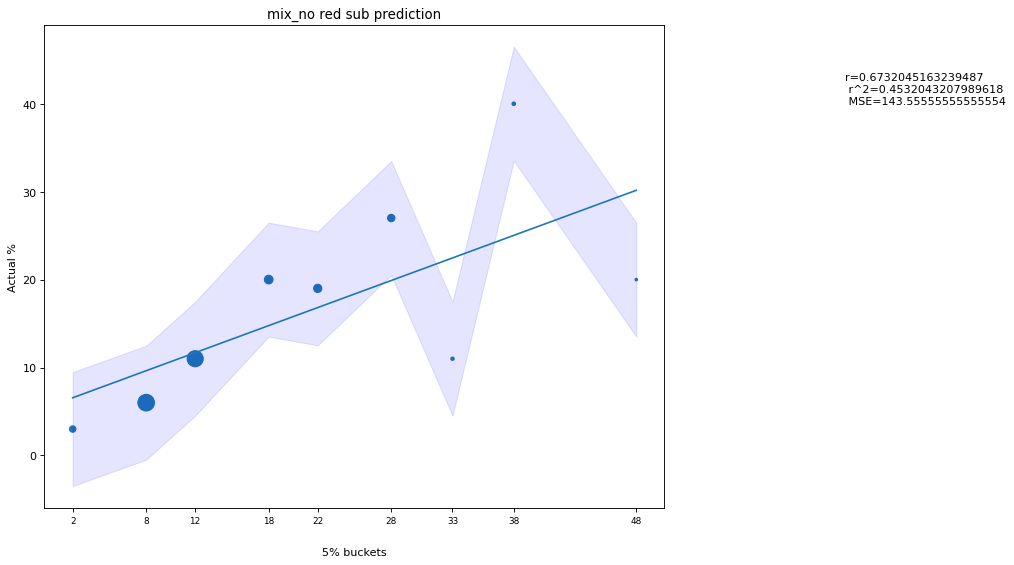

['mix_rand']
mix_rand
0% to 5%: 5% of 94 observations
5% to 10%: 8% of 310 observations
10% to 15%: 16% of 150 observations
15% to 20%: 17% of 46 observations
20% to 25%: 32% of 19 observations
25% to 30%: 33% of 18 observations
30% to 35%: 33% of 6 observations
35% to 40%: 50% of 2 observations
40% to 45%: 0% of 3 observations
45% to 50%: 50% of 2 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 1 observations
65% to 70%: 0% of 1 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[94, 310, 150, 46, 19, 18, 6]
[2, 8, 12, 18, 22, 28, 33]
[5, 8, 16, 17, 32, 33, 33]


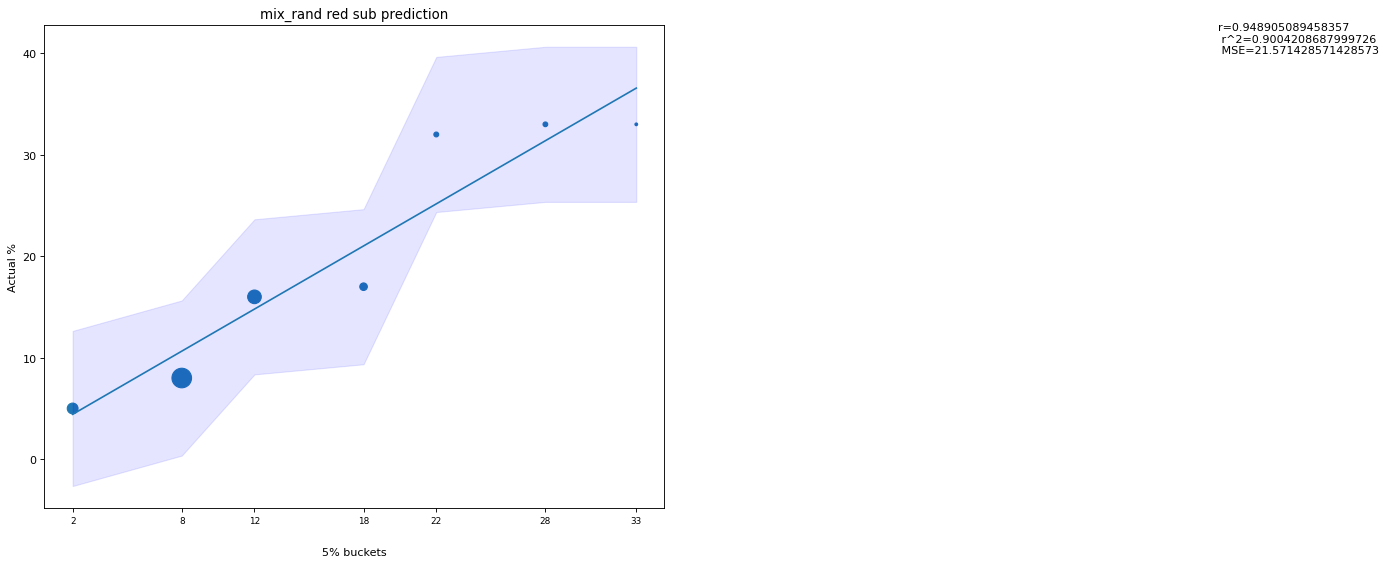

['mix_up']
mix_up
0% to 5%: 6% of 35 observations
5% to 10%: 5% of 229 observations
10% to 15%: 12% of 227 observations
15% to 20%: 17% of 80 observations
20% to 25%: 28% of 49 observations
25% to 30%: 39% of 18 observations
30% to 35%: 25% of 4 observations
35% to 40%: 0% of 2 observations
40% to 45%: 20% of 5 observations
45% to 50%: 0% of 1 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[35, 229, 227, 80, 49, 18, 5]
[2, 8, 12, 18, 22, 28, 43]
[6, 5, 12, 17, 28, 39, 20]


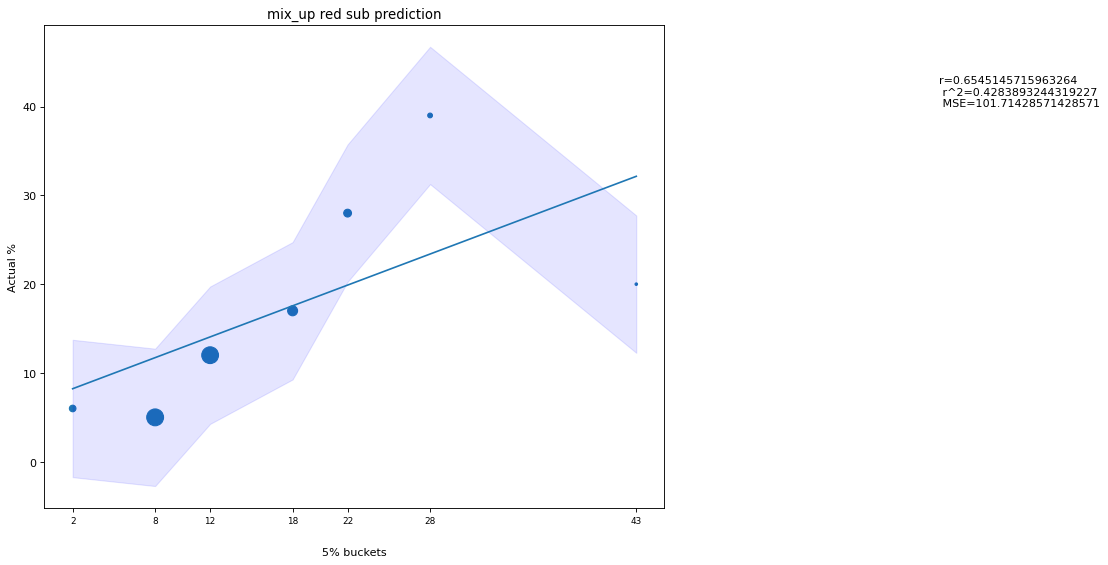

['combined']
combined
0% to 5%: 4% of 26 observations
5% to 10%: 6% of 279 observations
10% to 15%: 12% of 202 observations
15% to 20%: 19% of 64 observations
20% to 25%: 30% of 47 observations
25% to 30%: 31% of 16 observations
30% to 35%: 17% of 6 observations
35% to 40%: 50% of 2 observations
40% to 45%: 25% of 4 observations
45% to 50%: 50% of 2 observations
50% to 55%: 0% of 1 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[26, 279, 202, 64, 47, 16, 6]
[2, 8, 12, 18, 22, 28, 33]
[4, 6, 12, 19, 30, 31, 17]


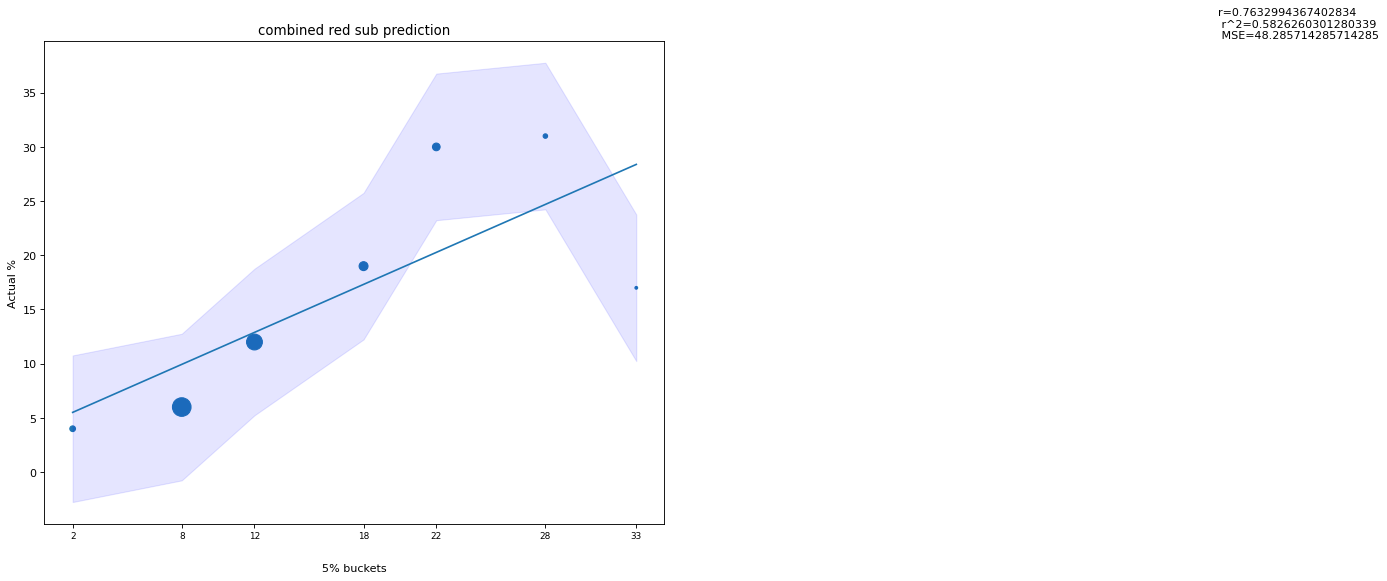

In [79]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
    print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["red_sub_pct"] >= x]
        point_to_point = point_up[point_up["red_sub_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "red - Submission"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

    print(observations)
    print(half_points)
    print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
    plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} red sub prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [80]:
red_sub_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

red_sub_df = pd.DataFrame(red_sub_dict)
red_sub_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.789474   0.623269     43.285714
1     knn_rand  0.891035   0.793943     34.666667
2       knn_up  0.841528   0.708169     33.714286
3       log_no  0.793213   0.629187     90.555556
4     log_rand  0.935588   0.875325     16.285714
5       log_up  0.925790   0.857088     27.625000
6        rf_no  0.900243   0.810437     62.500000
7      rf_rand  0.568440   0.323124     65.500000
8        rf_up  0.399175   0.159340    123.400000
9       mlp_no -0.110634   0.012240   1023.000000
10    mlp_rand  0.503542   0.253555    285.909091
11      mlp_up  0.499425   0.249425    443.846154
12       nn_no  0.732714   0.536870    148.333333
13     nn_rand  0.676359   0.457462     80.500000
14       nn_up  0.834941   0.697127     59.000000
15      mix_no  0.673205   0.453204    143.555556
16    mix_rand  0.948905   0.900421     21.571429
17      mix_up  0.654515   0.428389    101.714286
18    combined  0.763299   0.582626     48.285714

['knn_no']
knn_no
0% to 5%: 22% of 18 observations
5% to 10%: 23% of 47 observations
10% to 15%: 16% of 172 observations
15% to 20%: 17% of 124 observations
20% to 25%: 16% of 112 observations
25% to 30%: 21% of 72 observations
30% to 35%: 26% of 50 observations
35% to 40%: 35% of 26 observations
40% to 45%: 42% of 19 observations
45% to 50%: 33% of 9 observations
50% to 55%: 0% of 1 observations
55% to 60%: 0% of 2 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[18, 47, 172, 124, 112, 72, 50, 26, 19, 9]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48]
[22, 23, 16, 17, 16, 21, 26, 35, 42, 33]


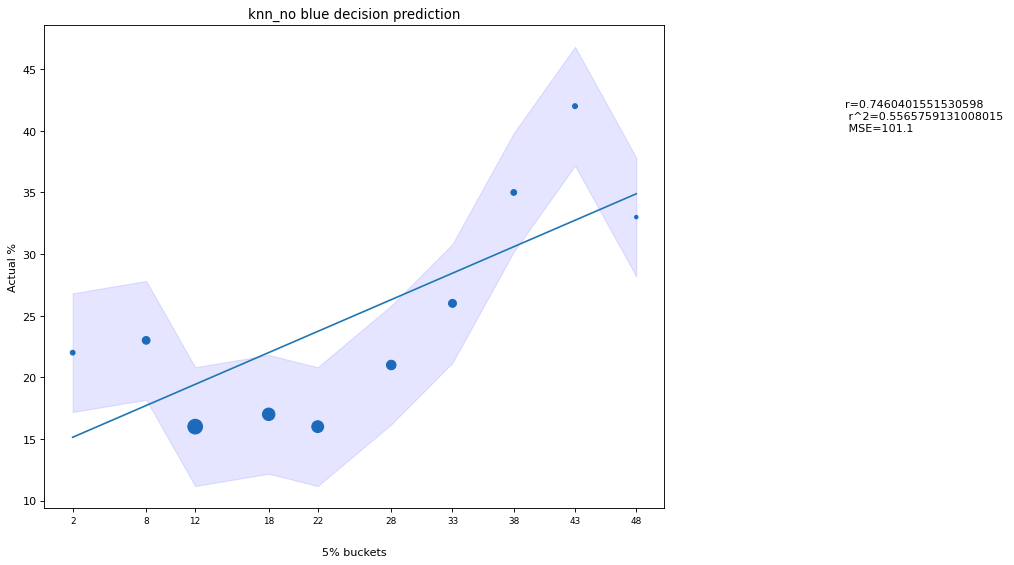

['knn_rand']
knn_rand
0% to 5%: 33% of 3 observations
5% to 10%: 13% of 15 observations
10% to 15%: 17% of 103 observations
15% to 20%: 19% of 94 observations
20% to 25%: 19% of 117 observations
25% to 30%: 19% of 98 observations
30% to 35%: 21% of 87 observations
35% to 40%: 19% of 73 observations
40% to 45%: 14% of 28 observations
45% to 50%: 40% of 20 observations
50% to 55%: 40% of 10 observations
55% to 60%: 0% of 2 observations
60% to 65%: 100% of 2 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[15, 103, 94, 117, 98, 87, 73, 28, 20, 10]
[8, 12, 18, 22, 28, 33, 38, 43, 48, 52]
[13, 17, 19, 19, 19, 21, 19, 14, 40, 40]


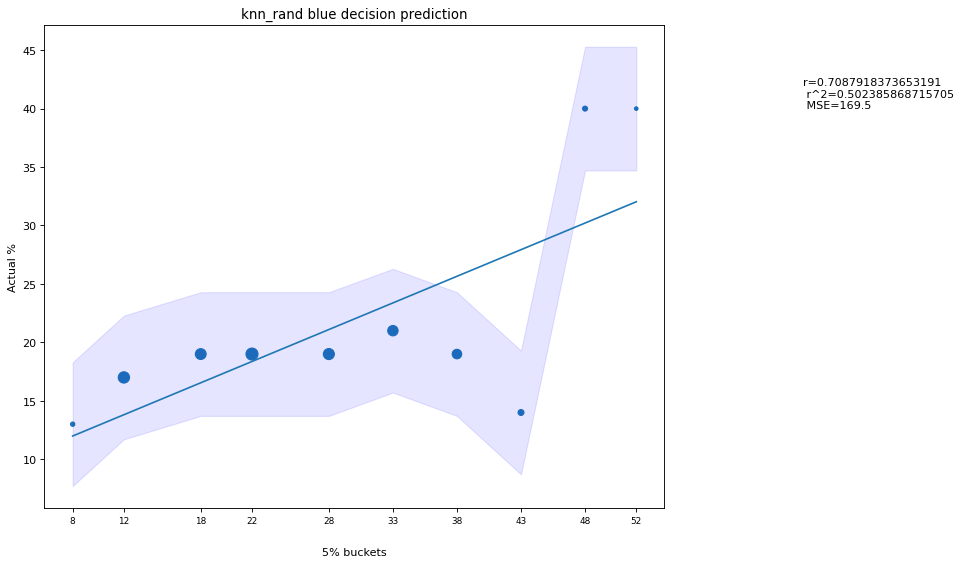

['knn_up']
knn_up
0% to 5%: 17% of 53 observations
5% to 10%: 17% of 36 observations
10% to 15%: 12% of 56 observations
15% to 20%: 18% of 67 observations
20% to 25%: 17% of 87 observations
25% to 30%: 16% of 61 observations
30% to 35%: 20% of 71 observations
35% to 40%: 15% of 55 observations
40% to 45%: 27% of 44 observations
45% to 50%: 28% of 45 observations
50% to 55%: 31% of 29 observations
55% to 60%: 38% of 21 observations
60% to 65%: 36% of 11 observations
65% to 70%: 12% of 8 observations
70% to 75%: 20% of 5 observations
75% to 80%: 33% of 3 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[53, 36, 56, 67, 87, 61, 71, 55, 44, 45, 29, 21, 11, 8, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73]
[17, 17, 12, 18, 17, 16, 20, 15, 27, 28, 31, 38, 36, 12, 20]


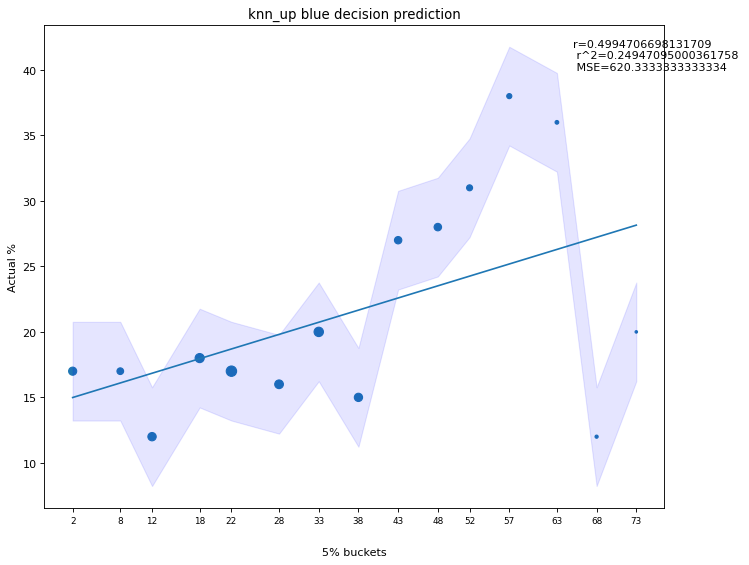

['log_no']
log_no
0% to 5%: 12% of 58 observations
5% to 10%: 13% of 129 observations
10% to 15%: 18% of 160 observations
15% to 20%: 23% of 84 observations
20% to 25%: 21% of 81 observations
25% to 30%: 25% of 52 observations
30% to 35%: 22% of 27 observations
35% to 40%: 21% of 14 observations
40% to 45%: 44% of 16 observations
45% to 50%: 50% of 8 observations
50% to 55%: 25% of 4 observations
55% to 60%: 0% of 0 observations
60% to 65%: 100% of 2 observations
65% to 70%: 100% of 2 observations
70% to 75%: 0% of 2 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[58, 129, 160, 84, 81, 52, 27, 14, 16, 8]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48]
[12, 13, 18, 23, 21, 25, 22, 21, 44, 50]


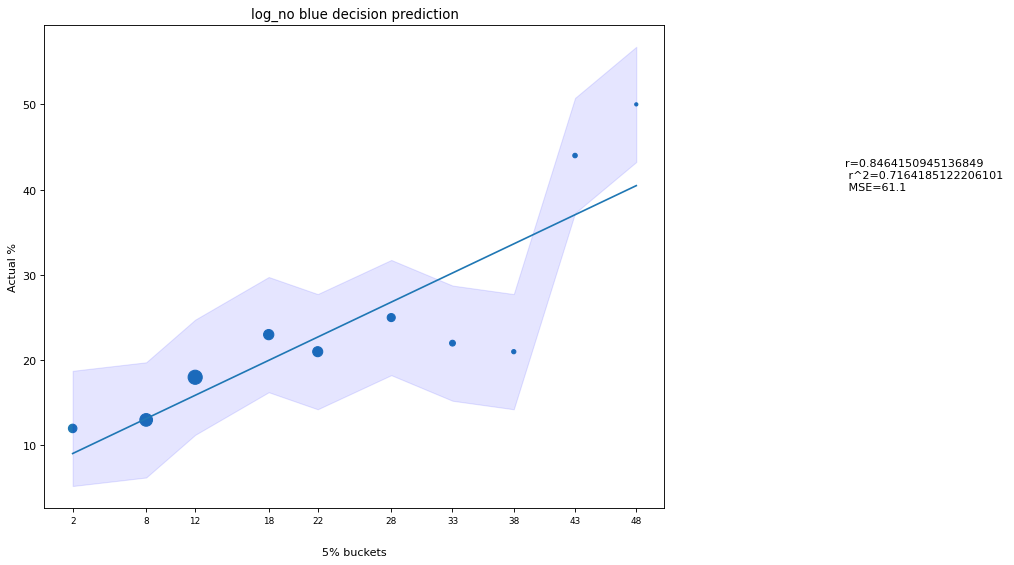

['log_rand']
log_rand
0% to 5%: 0% of 8 observations
5% to 10%: 18% of 49 observations
10% to 15%: 15% of 116 observations
15% to 20%: 11% of 93 observations
20% to 25%: 20% of 128 observations
25% to 30%: 20% of 96 observations
30% to 35%: 21% of 52 observations
35% to 40%: 28% of 38 observations
40% to 45%: 45% of 29 observations
45% to 50%: 37% of 19 observations
50% to 55%: 0% of 1 observations
55% to 60%: 50% of 2 observations
60% to 65%: 50% of 2 observations
65% to 70%: 100% of 1 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[8, 49, 116, 93, 128, 96, 52, 38, 29, 19]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48]
[0, 18, 15, 11, 20, 20, 21, 28, 45, 37]


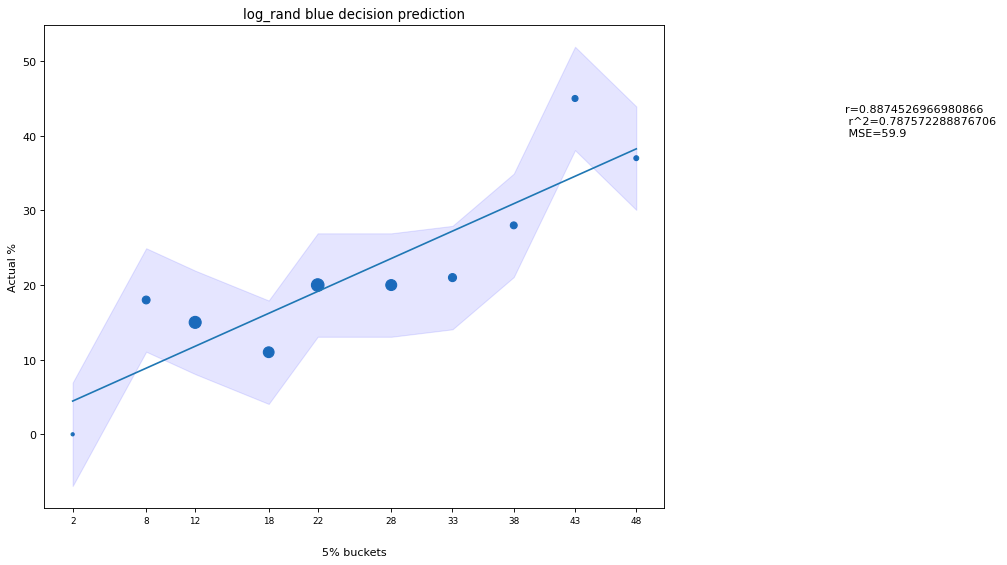

['log_up']
log_up
0% to 5%: 16% of 32 observations
5% to 10%: 13% of 63 observations
10% to 15%: 17% of 112 observations
15% to 20%: 14% of 73 observations
20% to 25%: 19% of 106 observations
25% to 30%: 14% of 72 observations
30% to 35%: 32% of 53 observations
35% to 40%: 31% of 35 observations
40% to 45%: 19% of 31 observations
45% to 50%: 12% of 24 observations
50% to 55%: 27% of 15 observations
55% to 60%: 50% of 12 observations
60% to 65%: 40% of 5 observations
65% to 70%: 75% of 4 observations
70% to 75%: 100% of 2 observations
75% to 80%: 100% of 1 observations
80% to 85%: 0% of 1 observations
85% to 90%: 0% of 1 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[32, 63, 112, 73, 106, 72, 53, 35, 31, 24, 15, 12, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63]
[16, 13, 17, 14, 19, 14, 32, 31, 19, 12, 27, 50, 40]


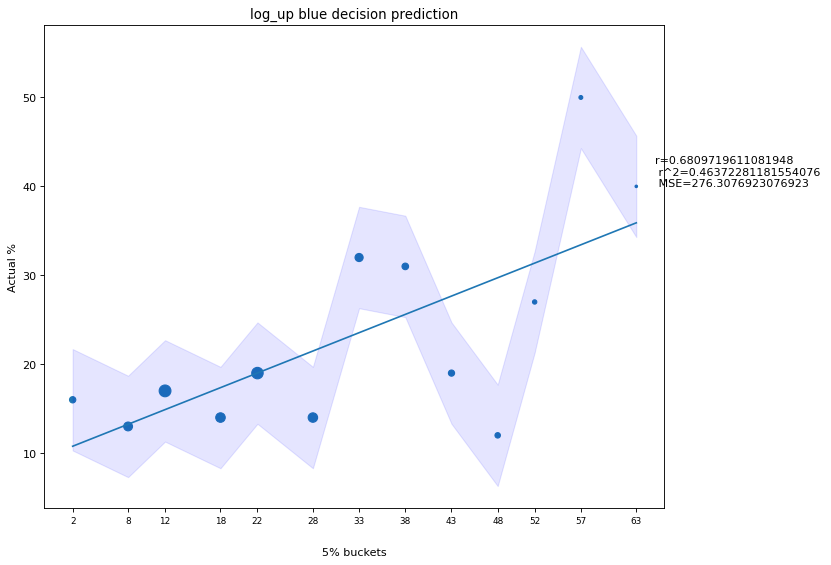

['rf_no']
rf_no
0% to 5%: 0% of 0 observations
5% to 10%: 28% of 7 observations
10% to 15%: 20% of 107 observations
15% to 20%: 17% of 183 observations
20% to 25%: 21% of 233 observations
25% to 30%: 21% of 102 observations
30% to 35%: 33% of 12 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[7, 107, 183, 233, 102, 12]
[8, 12, 18, 22, 28, 33]
[28, 20, 17, 21, 21, 33]


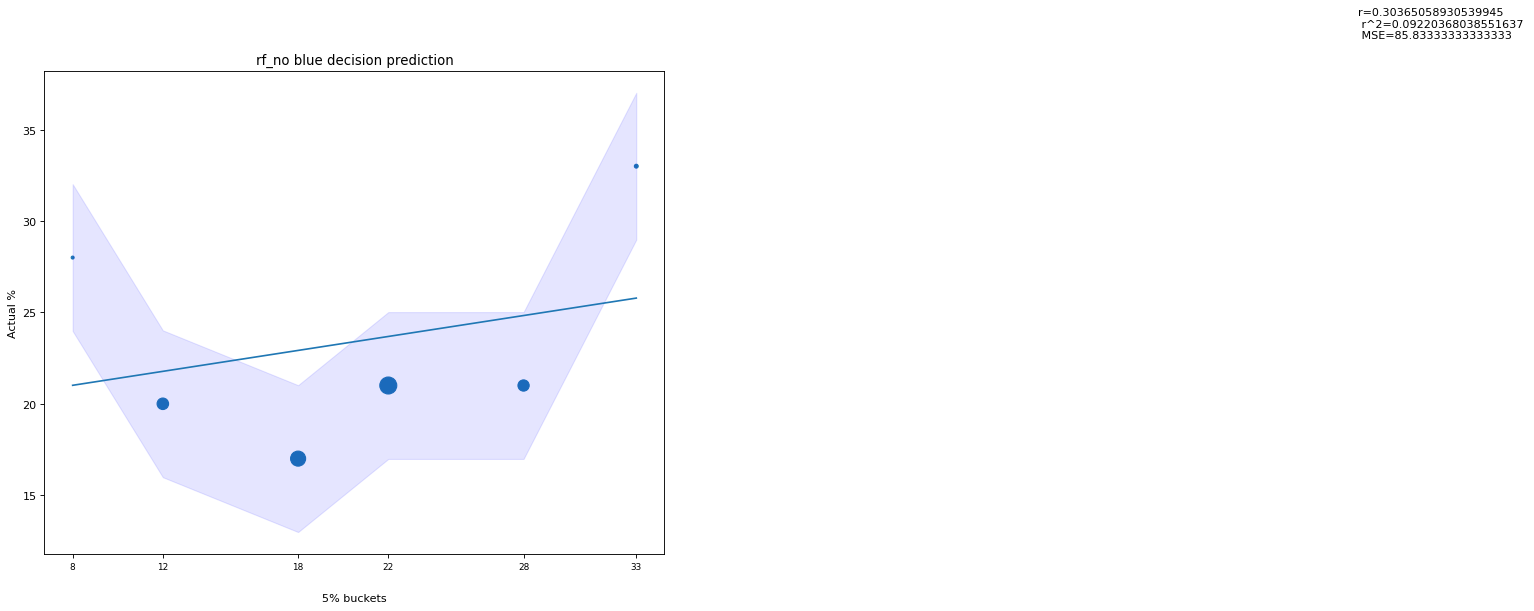

['rf_rand']
rf_rand
0% to 5%: 0% of 0 observations
5% to 10%: 40% of 5 observations
10% to 15%: 21% of 67 observations
15% to 20%: 22% of 125 observations
20% to 25%: 20% of 231 observations
25% to 30%: 18% of 152 observations
30% to 35%: 12% of 41 observations
35% to 40%: 28% of 7 observations
40% to 45%: 25% of 4 observations
45% to 50%: 0% of 1 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[5, 67, 125, 231, 152, 41, 7]
[8, 12, 18, 22, 28, 33, 38]
[40, 21, 22, 20, 18, 12, 28]


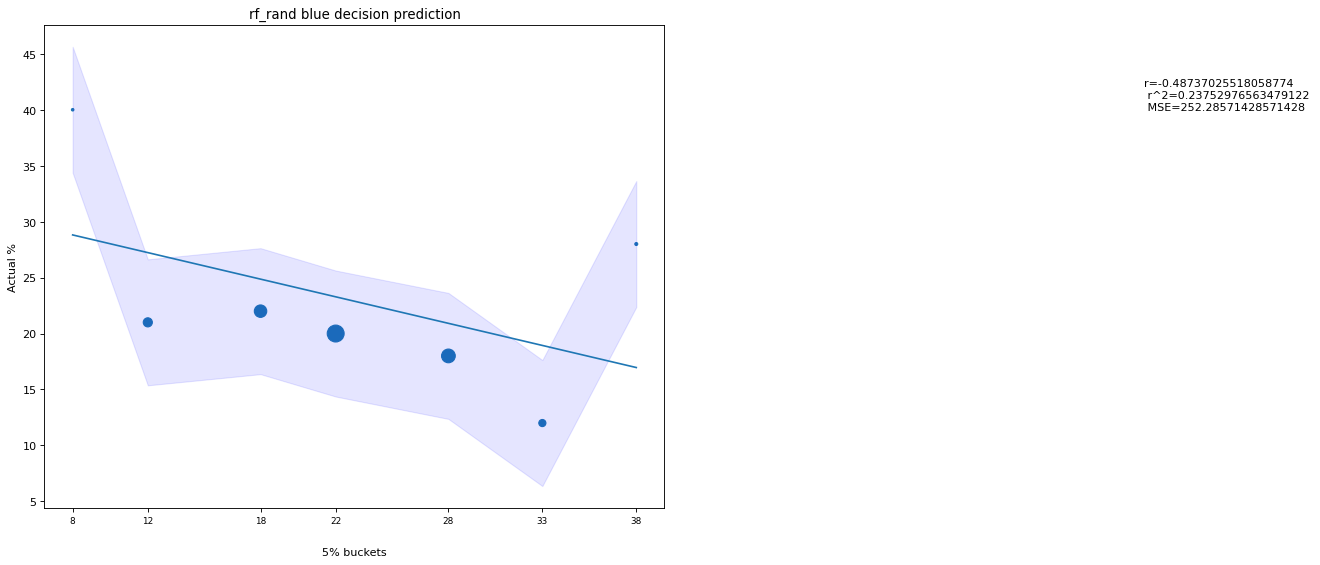

['rf_up']
rf_up
0% to 5%: 0% of 0 observations
5% to 10%: 50% of 2 observations
10% to 15%: 13% of 79 observations
15% to 20%: 21% of 169 observations
20% to 25%: 24% of 225 observations
25% to 30%: 17% of 139 observations
30% to 35%: 21% of 19 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[79, 169, 225, 139, 19]
[12, 18, 22, 28, 33]
[13, 21, 24, 17, 21]


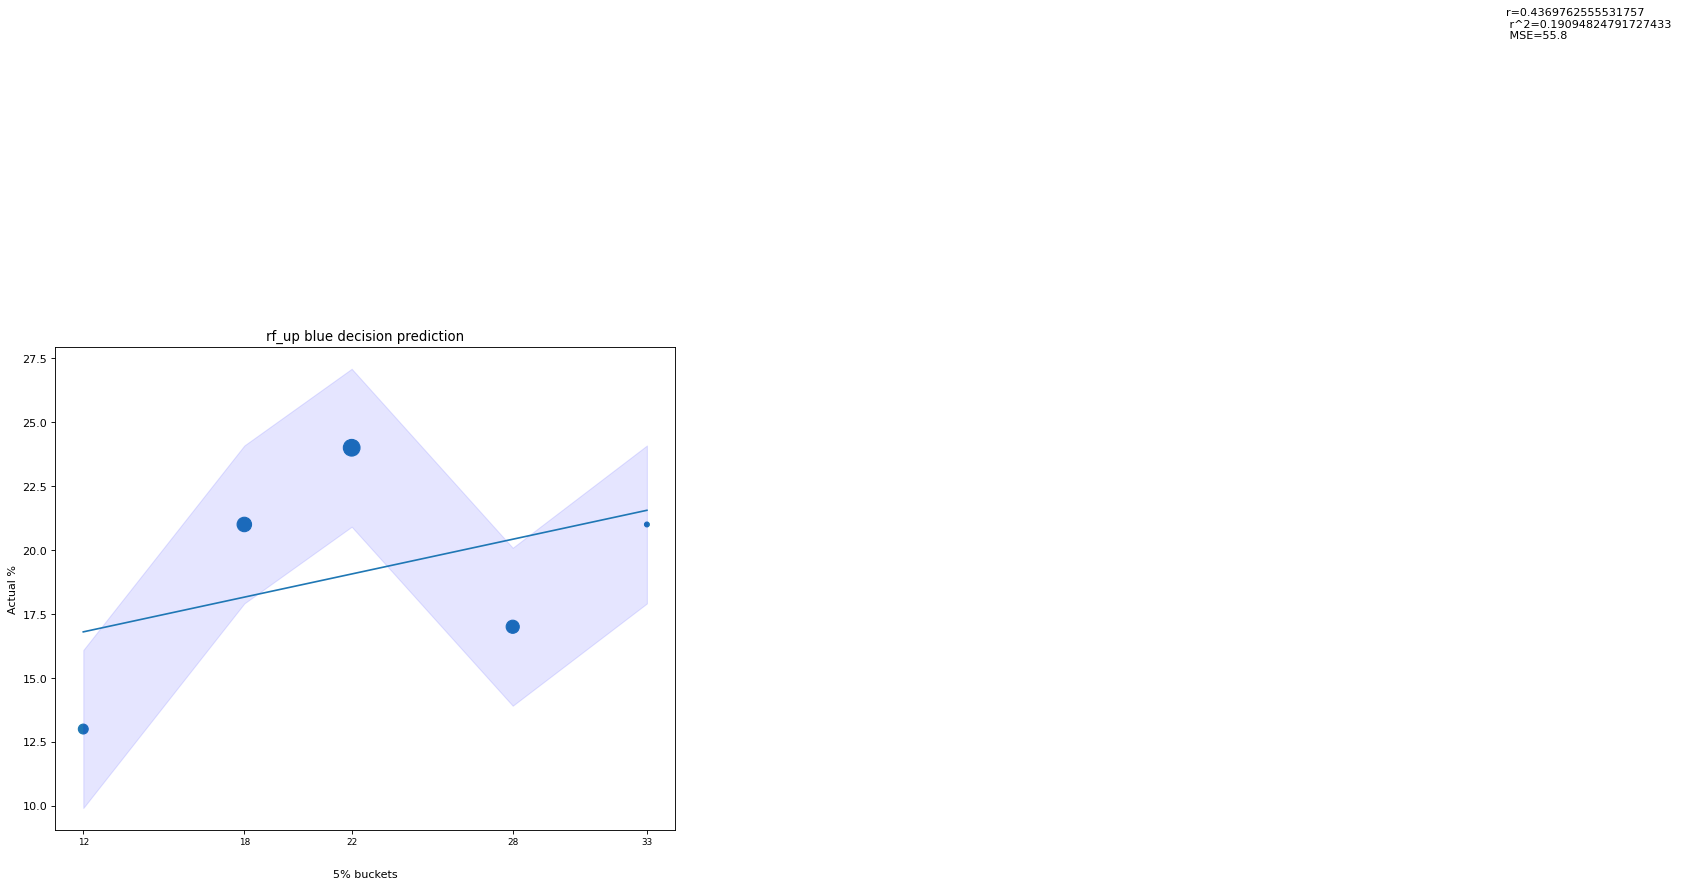

['mlp_no']
mlp_no
0% to 5%: 14% of 165 observations
5% to 10%: 14% of 123 observations
10% to 15%: 16% of 104 observations
15% to 20%: 20% of 35 observations
20% to 25%: 24% of 55 observations
25% to 30%: 20% of 35 observations
30% to 35%: 39% of 23 observations
35% to 40%: 24% of 17 observations
40% to 45%: 30% of 23 observations
45% to 50%: 30% of 10 observations
50% to 55%: 14% of 14 observations
55% to 60%: 39% of 18 observations
60% to 65%: 50% of 8 observations
65% to 70%: 60% of 5 observations
70% to 75%: 50% of 4 observations
75% to 80%: 40% of 5 observations
80% to 85%: 33% of 3 observations
85% to 90%: 100% of 1 observations
90% to 95%: 100% of 1 observations
95% to 100%: 0% of 0 observations
[165, 123, 104, 35, 55, 35, 23, 17, 23, 10, 14, 18, 8, 5, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 78]
[14, 14, 16, 20, 24, 20, 39, 24, 30, 30, 14, 39, 50, 60, 40]


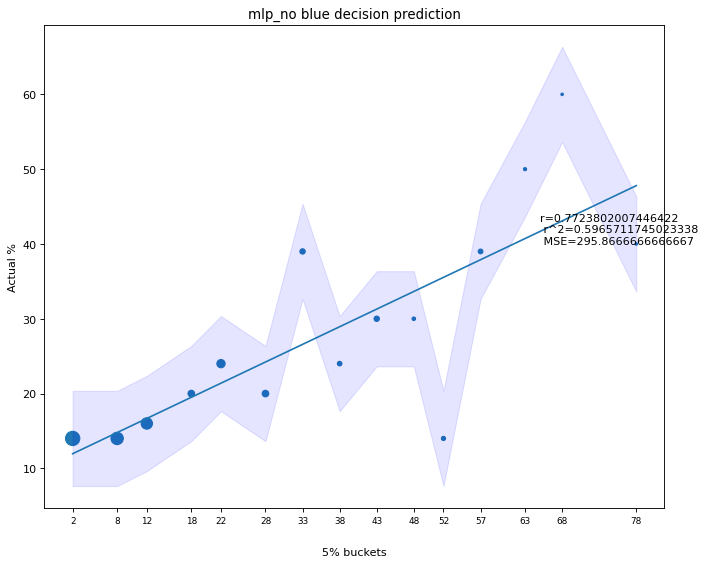

['mlp_rand']
mlp_rand
0% to 5%: 18% of 90 observations
5% to 10%: 13% of 117 observations
10% to 15%: 16% of 104 observations
15% to 20%: 28% of 41 observations
20% to 25%: 22% of 59 observations
25% to 30%: 14% of 57 observations
30% to 35%: 12% of 32 observations
35% to 40%: 25% of 24 observations
40% to 45%: 30% of 27 observations
45% to 50%: 22% of 23 observations
50% to 55%: 46% of 13 observations
55% to 60%: 25% of 20 observations
60% to 65%: 38% of 16 observations
65% to 70%: 0% of 6 observations
70% to 75%: 42% of 12 observations
75% to 80%: 17% of 6 observations
80% to 85%: 67% of 3 observations
85% to 90%: 0% of 1 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[90, 117, 104, 41, 59, 57, 32, 24, 27, 23, 13, 20, 16, 6, 12, 6]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78]
[18, 13, 16, 28, 22, 14, 12, 25, 30, 22, 46, 25, 38, 0, 42, 17]


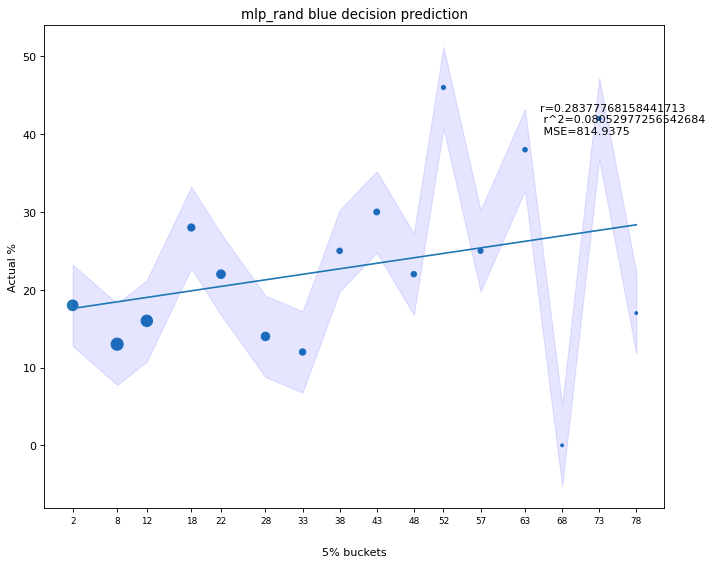

['mlp_up']
mlp_up
0% to 5%: 17% of 224 observations
5% to 10%: 20% of 92 observations
10% to 15%: 28% of 58 observations
15% to 20%: 10% of 31 observations
20% to 25%: 18% of 45 observations
25% to 30%: 21% of 29 observations
30% to 35%: 5% of 21 observations
35% to 40%: 24% of 21 observations
40% to 45%: 25% of 20 observations
45% to 50%: 0% of 12 observations
50% to 55%: 14% of 14 observations
55% to 60%: 38% of 16 observations
60% to 65%: 27% of 11 observations
65% to 70%: 33% of 12 observations
70% to 75%: 12% of 8 observations
75% to 80%: 11% of 9 observations
80% to 85%: 11% of 9 observations
85% to 90%: 60% of 10 observations
90% to 95%: 50% of 12 observations
95% to 100%: 0% of 1 observations
[224, 92, 58, 31, 45, 29, 21, 21, 20, 12, 14, 16, 11, 12, 8, 9, 9, 10, 12]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 78, 82, 88, 92]
[17, 20, 28, 10, 18, 21, 5, 24, 25, 0, 14, 38, 27, 33, 12, 11, 11, 60, 50]


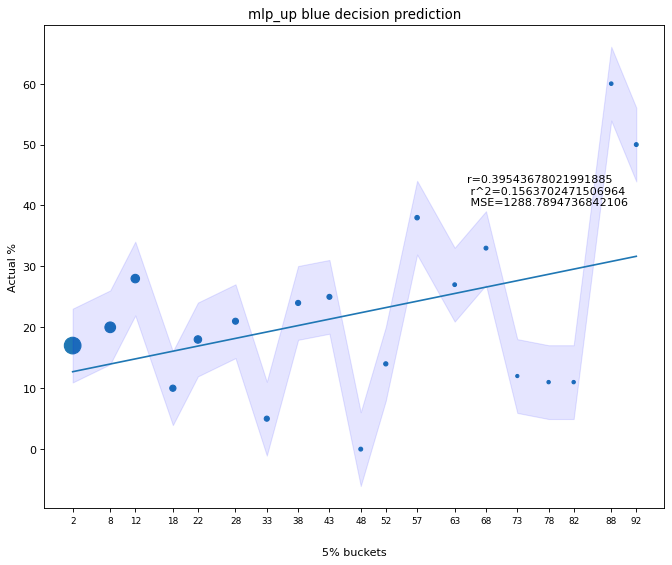

['nn_no']
nn_no
0% to 5%: 12% of 81 observations
5% to 10%: 15% of 157 observations
10% to 15%: 20% of 137 observations
15% to 20%: 16% of 73 observations
20% to 25%: 17% of 52 observations
25% to 30%: 20% of 49 observations
30% to 35%: 42% of 26 observations
35% to 40%: 36% of 25 observations
40% to 45%: 32% of 19 observations
45% to 50%: 33% of 9 observations
50% to 55%: 0% of 3 observations
55% to 60%: 80% of 5 observations
60% to 65%: 67% of 6 observations
65% to 70%: 0% of 1 observations
70% to 75%: 0% of 1 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[81, 157, 137, 73, 52, 49, 26, 25, 19, 9, 5, 6]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 57, 63]
[12, 15, 20, 16, 17, 20, 42, 36, 32, 33, 80, 67]


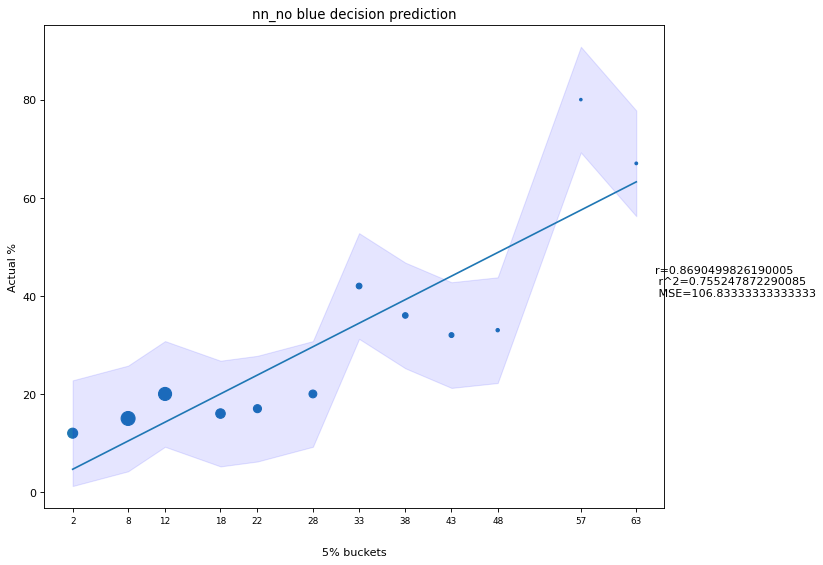

['nn_rand']
nn_rand
0% to 5%: 12% of 16 observations
5% to 10%: 15% of 68 observations
10% to 15%: 12% of 119 observations
15% to 20%: 19% of 99 observations
20% to 25%: 19% of 102 observations
25% to 30%: 19% of 83 observations
30% to 35%: 16% of 55 observations
35% to 40%: 35% of 31 observations
40% to 45%: 31% of 32 observations
45% to 50%: 56% of 14 observations
50% to 55%: 62% of 8 observations
55% to 60%: 25% of 4 observations
60% to 65%: 0% of 1 observations
65% to 70%: 50% of 2 observations
70% to 75%: 0% of 0 observations
75% to 80%: 100% of 1 observations
80% to 85%: 100% of 1 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[16, 68, 119, 99, 102, 83, 55, 31, 32, 14, 8]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52]
[12, 15, 12, 19, 19, 19, 16, 35, 31, 56, 62]


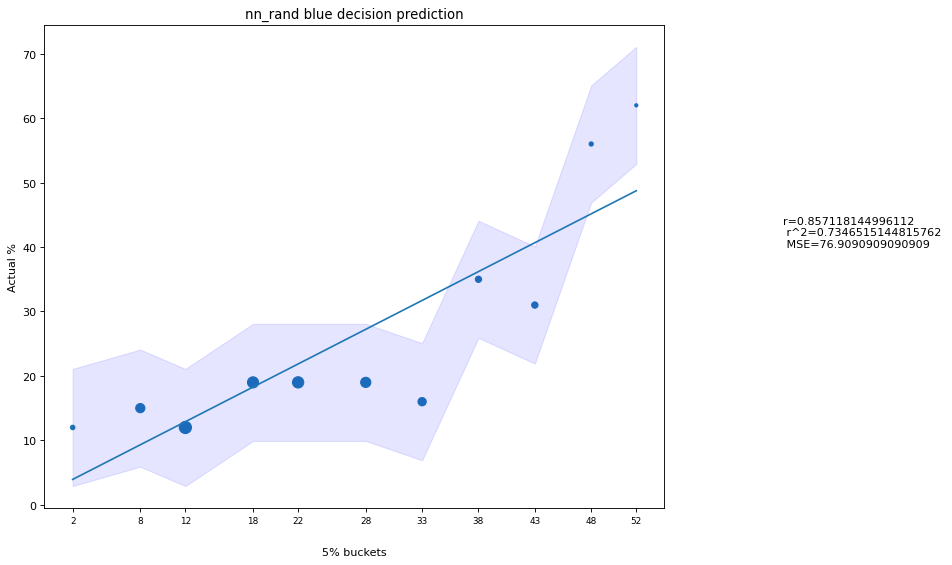

['nn_up']
nn_up
0% to 5%: 14% of 105 observations
5% to 10%: 18% of 113 observations
10% to 15%: 15% of 103 observations
15% to 20%: 20% of 54 observations
20% to 25%: 23% of 57 observations
25% to 30%: 25% of 51 observations
30% to 35%: 27% of 45 observations
35% to 40%: 19% of 16 observations
40% to 45%: 11% of 19 observations
45% to 50%: 39% of 18 observations
50% to 55%: 20% of 15 observations
55% to 60%: 28% of 14 observations
60% to 65%: 30% of 10 observations
65% to 70%: 15% of 13 observations
70% to 75%: 40% of 5 observations
75% to 80%: 25% of 4 observations
80% to 85%: 60% of 5 observations
85% to 90%: 0% of 2 observations
90% to 95%: 67% of 3 observations
95% to 100%: 0% of 1 observations
[105, 113, 103, 54, 57, 51, 45, 16, 19, 18, 15, 14, 10, 13, 5, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 82]
[14, 18, 15, 20, 23, 25, 27, 19, 11, 39, 20, 28, 30, 15, 40, 60]


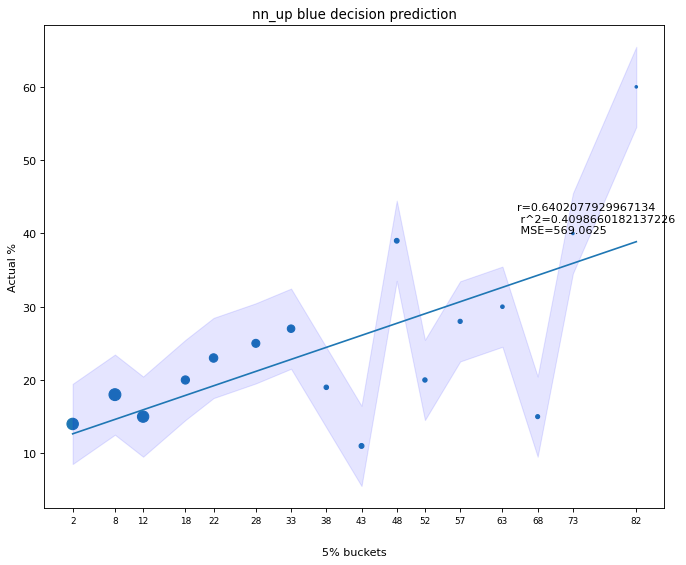

['mix_no']
mix_no
0% to 5%: 12% of 8 observations
5% to 10%: 15% of 89 observations
10% to 15%: 15% of 201 observations
15% to 20%: 17% of 121 observations
20% to 25%: 21% of 98 observations
25% to 30%: 32% of 71 observations
30% to 35%: 31% of 32 observations
35% to 40%: 25% of 12 observations
40% to 45%: 43% of 7 observations
45% to 50%: 100% of 1 observations
50% to 55%: 67% of 3 observations
55% to 60%: 0% of 1 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[8, 89, 201, 121, 98, 71, 32, 12, 7]
[2, 8, 12, 18, 22, 28, 33, 38, 43]
[12, 15, 15, 17, 21, 32, 31, 25, 43]


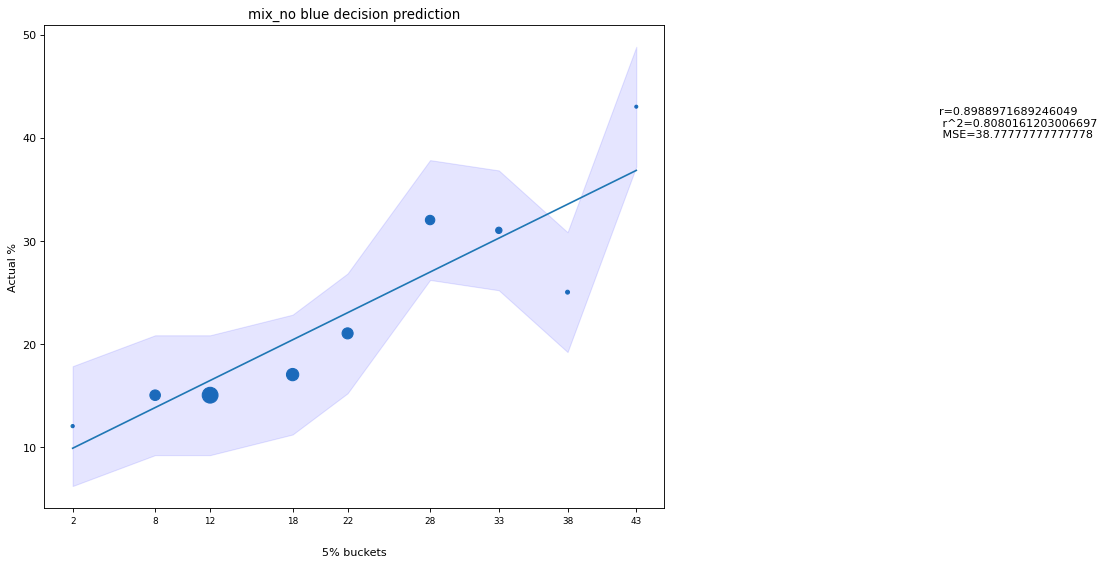

['mix_rand']
mix_rand
0% to 5%: 0% of 0 observations
5% to 10%: 5% of 19 observations
10% to 15%: 16% of 119 observations
15% to 20%: 13% of 110 observations
20% to 25%: 20% of 138 observations
25% to 30%: 17% of 103 observations
30% to 35%: 32% of 82 observations
35% to 40%: 32% of 34 observations
40% to 45%: 39% of 23 observations
45% to 50%: 25% of 4 observations
50% to 55%: 0% of 1 observations
55% to 60%: 100% of 1 observations
60% to 65%: 100% of 1 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[19, 119, 110, 138, 103, 82, 34, 23]
[8, 12, 18, 22, 28, 33, 38, 43]
[5, 16, 13, 20, 17, 32, 32, 39]


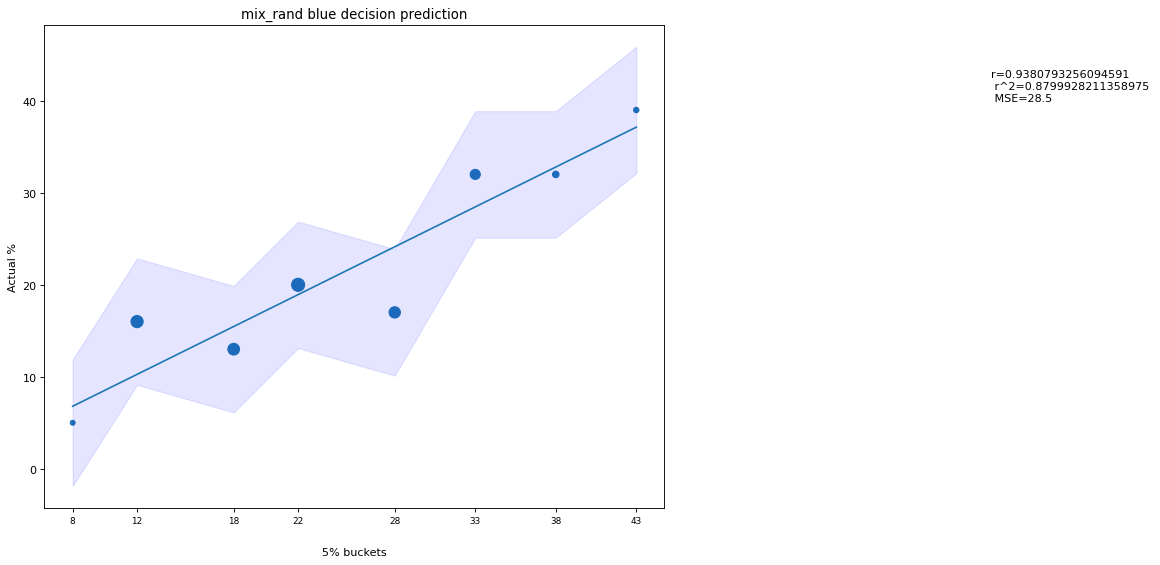

['mix_up']
mix_up
0% to 5%: 33% of 3 observations
5% to 10%: 24% of 50 observations
10% to 15%: 10% of 160 observations
15% to 20%: 19% of 126 observations
20% to 25%: 13% of 100 observations
25% to 30%: 28% of 101 observations
30% to 35%: 24% of 50 observations
35% to 40%: 38% of 24 observations
40% to 45%: 38% of 13 observations
45% to 50%: 50% of 8 observations
50% to 55%: 100% of 2 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[50, 160, 126, 100, 101, 50, 24, 13, 8]
[8, 12, 18, 22, 28, 33, 38, 43, 48]
[24, 10, 19, 13, 28, 24, 38, 38, 50]


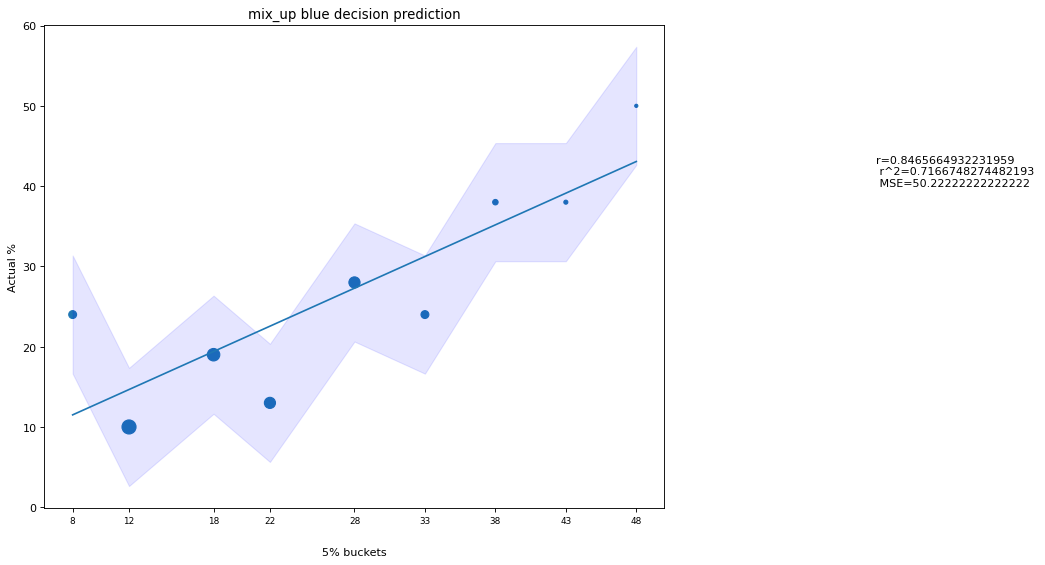

['combined']
combined
0% to 5%: 0% of 0 observations
5% to 10%: 16% of 25 observations
10% to 15%: 15% of 142 observations
15% to 20%: 12% of 133 observations
20% to 25%: 19% of 145 observations
25% to 30%: 19% of 99 observations
30% to 35%: 21% of 42 observations
35% to 40%: 50% of 32 observations
40% to 45%: 44% of 16 observations
45% to 50%: 33% of 3 observations
50% to 55%: 50% of 2 observations
55% to 60%: 100% of 1 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[25, 142, 133, 145, 99, 42, 32, 16]
[8, 12, 18, 22, 28, 33, 38, 43]
[16, 15, 12, 19, 19, 21, 50, 44]


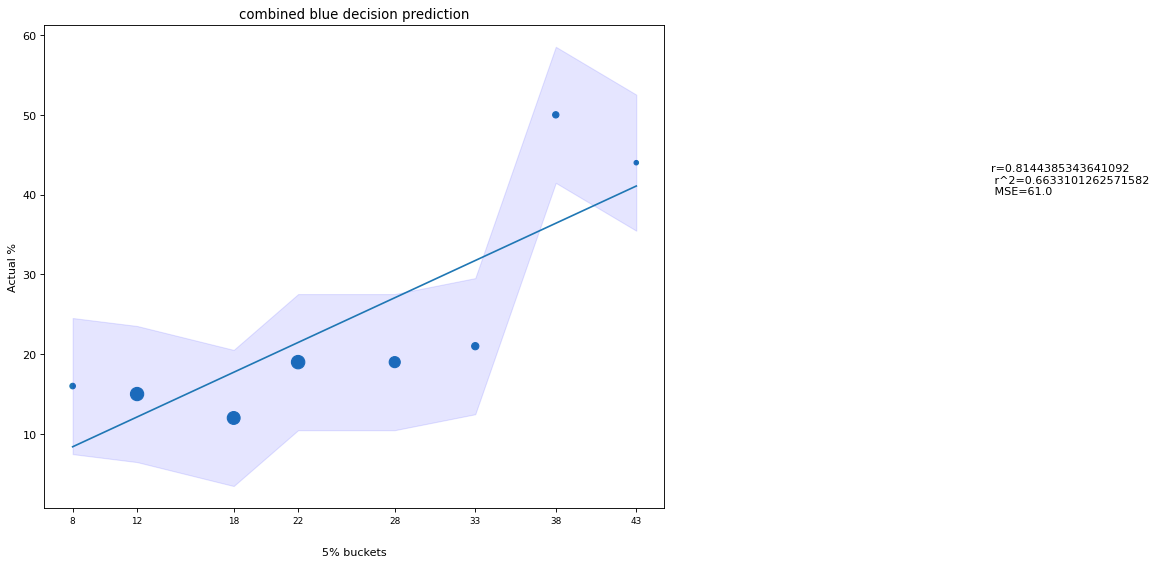

In [81]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
    print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["blue_dec_pct"] >= x]
        point_to_point = point_up[point_up["blue_dec_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - Decision"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

    print(observations)
    print(half_points)
    print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
    plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} blue decision prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [82]:
blue_dec_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

blue_dec_df = pd.DataFrame(blue_dec_dict)
blue_dec_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.746040   0.556576    101.100000
1     knn_rand  0.708792   0.502386    169.500000
2       knn_up  0.499471   0.249471    620.333333
3       log_no  0.846415   0.716419     61.100000
4     log_rand  0.887453   0.787572     59.900000
5       log_up  0.680972   0.463723    276.307692
6        rf_no  0.303651   0.092204     85.833333
7      rf_rand -0.487370   0.237530    252.285714
8        rf_up  0.436976   0.190948     55.800000
9       mlp_no  0.772380   0.596571    295.866667
10    mlp_rand  0.283778   0.080530    814.937500
11      mlp_up  0.395437   0.156370   1288.789474
12       nn_no  0.869050   0.755248    106.833333
13     nn_rand  0.857118   0.734652     76.909091
14       nn_up  0.640208   0.409866    569.062500
15      mix_no  0.898897   0.808016     38.777778
16    mix_rand  0.938079   0.879993     28.500000
17      mix_up  0.846566   0.716675     50.222222
18    combined  0.814439   0.663310     61.000000

['knn_no']
knn_no
0% to 5%: 4% of 55 observations
5% to 10%: 9% of 115 observations
10% to 15%: 12% of 295 observations
15% to 20%: 22% of 93 observations
20% to 25%: 31% of 55 observations
25% to 30%: 27% of 26 observations
30% to 35%: 11% of 9 observations
35% to 40%: 25% of 4 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[55, 115, 295, 93, 55, 26, 9]
[2, 8, 12, 18, 22, 28, 33]
[4, 9, 12, 22, 31, 27, 11]


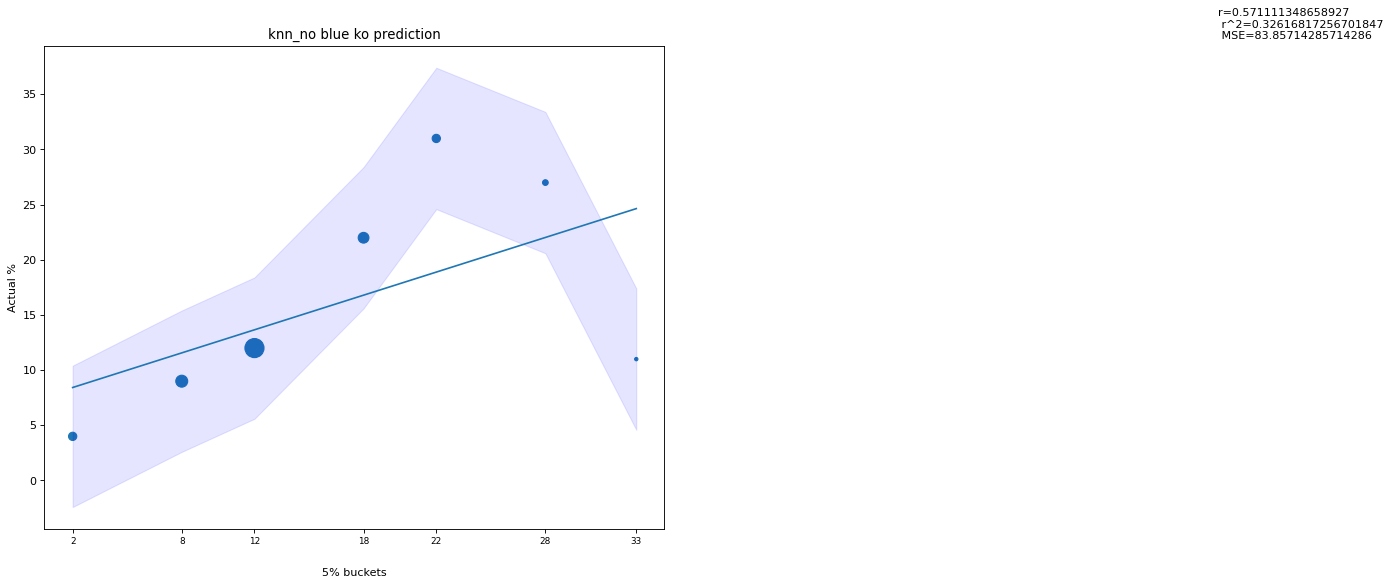

['knn_rand']
knn_rand
0% to 5%: 6% of 31 observations
5% to 10%: 8% of 98 observations
10% to 15%: 13% of 263 observations
15% to 20%: 14% of 98 observations
20% to 25%: 20% of 83 observations
25% to 30%: 21% of 48 observations
30% to 35%: 11% of 18 observations
35% to 40%: 38% of 8 observations
40% to 45%: 33% of 3 observations
45% to 50%: 100% of 1 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 1 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[31, 98, 263, 98, 83, 48, 18, 8]
[2, 8, 12, 18, 22, 28, 33, 38]
[6, 8, 13, 14, 20, 21, 11, 38]


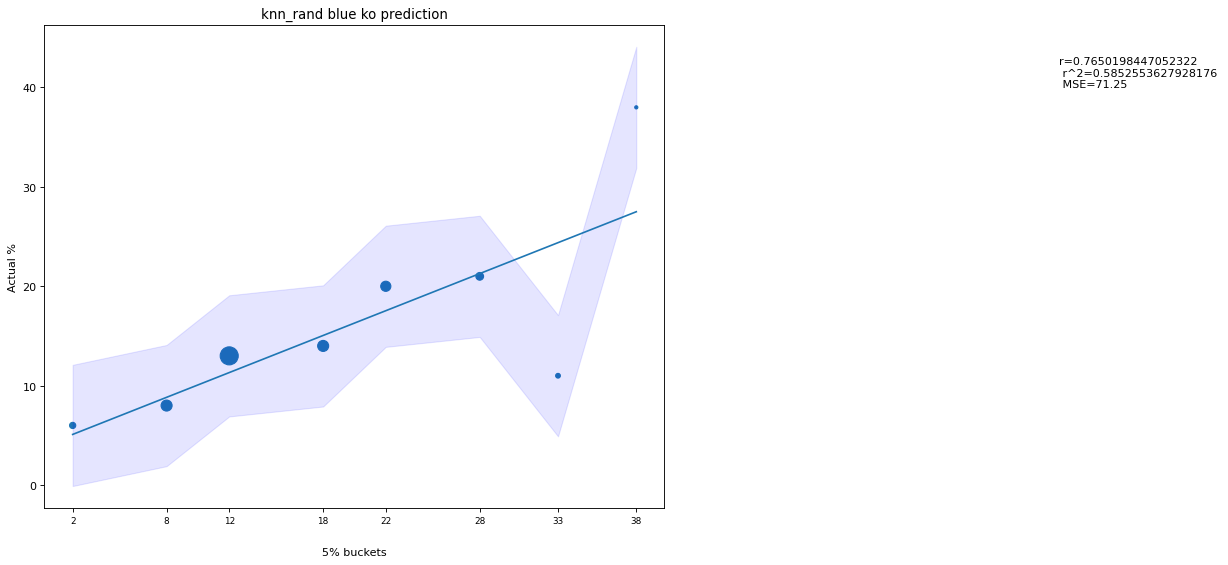

['knn_up']
knn_up
0% to 5%: 7% of 138 observations
5% to 10%: 14% of 58 observations
10% to 15%: 10% of 87 observations
15% to 20%: 6% of 81 observations
20% to 25%: 19% of 80 observations
25% to 30%: 19% of 68 observations
30% to 35%: 28% of 42 observations
35% to 40%: 11% of 37 observations
40% to 45%: 22% of 23 observations
45% to 50%: 26% of 19 observations
50% to 55%: 33% of 12 observations
55% to 60%: 40% of 5 observations
60% to 65%: 100% of 2 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[138, 58, 87, 81, 80, 68, 42, 37, 23, 19, 12, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57]
[7, 14, 10, 6, 19, 19, 28, 11, 22, 26, 33, 40]


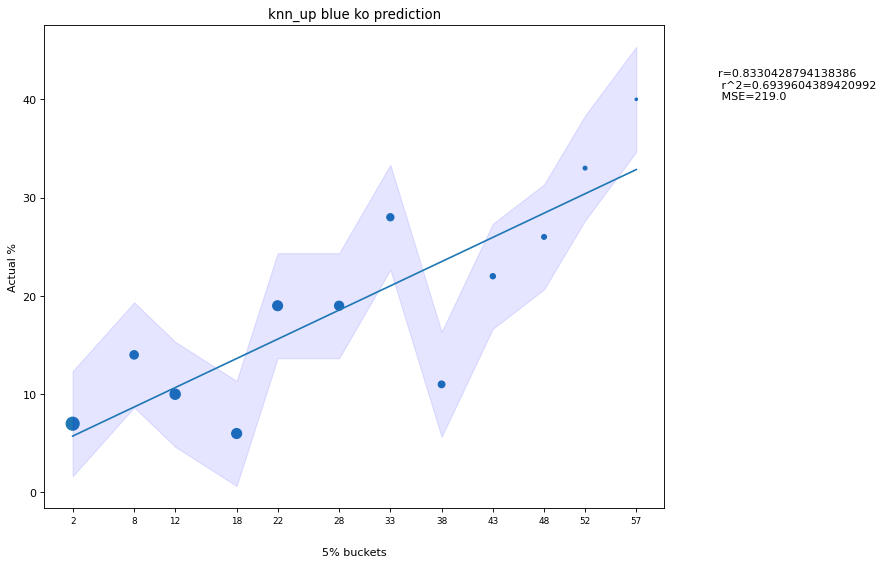

['log_no']
log_no
0% to 5%: 3% of 119 observations
5% to 10%: 12% of 204 observations
10% to 15%: 17% of 148 observations
15% to 20%: 18% of 61 observations
20% to 25%: 28% of 49 observations
25% to 30%: 17% of 35 observations
30% to 35%: 18% of 11 observations
35% to 40%: 20% of 5 observations
40% to 45%: 0% of 2 observations
45% to 50%: 25% of 4 observations
50% to 55%: 60% of 5 observations
55% to 60%: 0% of 2 observations
60% to 65%: 0% of 1 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[119, 204, 148, 61, 49, 35, 11, 5, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 52]
[3, 12, 17, 18, 28, 17, 18, 20, 60]


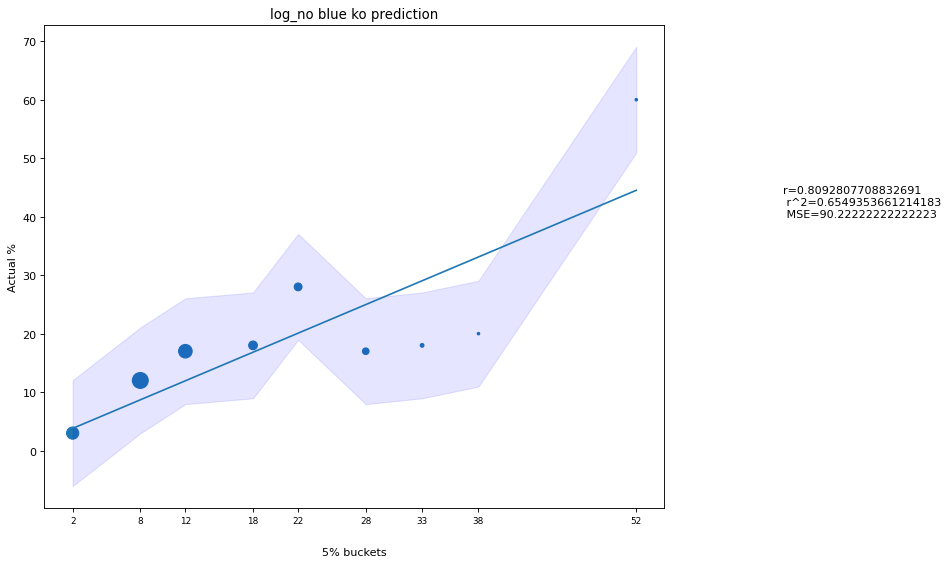

['log_rand']
log_rand
0% to 5%: 3% of 39 observations
5% to 10%: 4% of 140 observations
10% to 15%: 11% of 173 observations
15% to 20%: 22% of 97 observations
20% to 25%: 18% of 68 observations
25% to 30%: 13% of 53 observations
30% to 35%: 36% of 28 observations
35% to 40%: 28% of 14 observations
40% to 45%: 31% of 13 observations
45% to 50%: 18% of 11 observations
50% to 55%: 50% of 2 observations
55% to 60%: 40% of 5 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 100% of 1 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[39, 140, 173, 97, 68, 53, 28, 14, 13, 11, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 57]
[3, 4, 11, 22, 18, 13, 36, 28, 31, 18, 40]


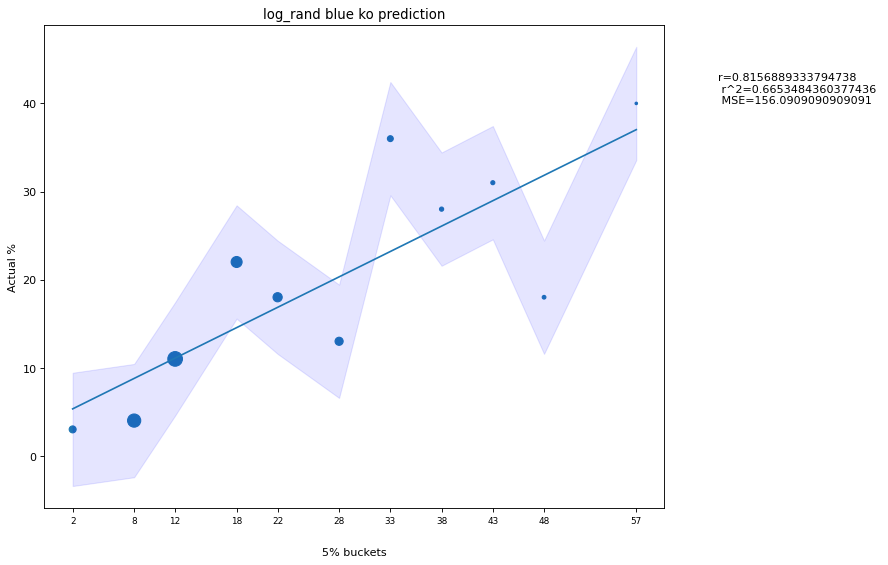

['log_up']
log_up
0% to 5%: 3% of 79 observations
5% to 10%: 9% of 150 observations
10% to 15%: 15% of 118 observations
15% to 20%: 22% of 82 observations
20% to 25%: 13% of 70 observations
25% to 30%: 15% of 46 observations
30% to 35%: 19% of 37 observations
35% to 40%: 30% of 23 observations
40% to 45%: 30% of 10 observations
45% to 50%: 17% of 6 observations
50% to 55%: 0% of 6 observations
55% to 60%: 33% of 6 observations
60% to 65%: 20% of 5 observations
65% to 70%: 0% of 1 observations
70% to 75%: 100% of 2 observations
75% to 80%: 100% of 1 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[79, 150, 118, 82, 70, 46, 37, 23, 10, 6, 6, 6, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63]
[3, 9, 15, 22, 13, 15, 19, 30, 30, 17, 0, 33, 20]


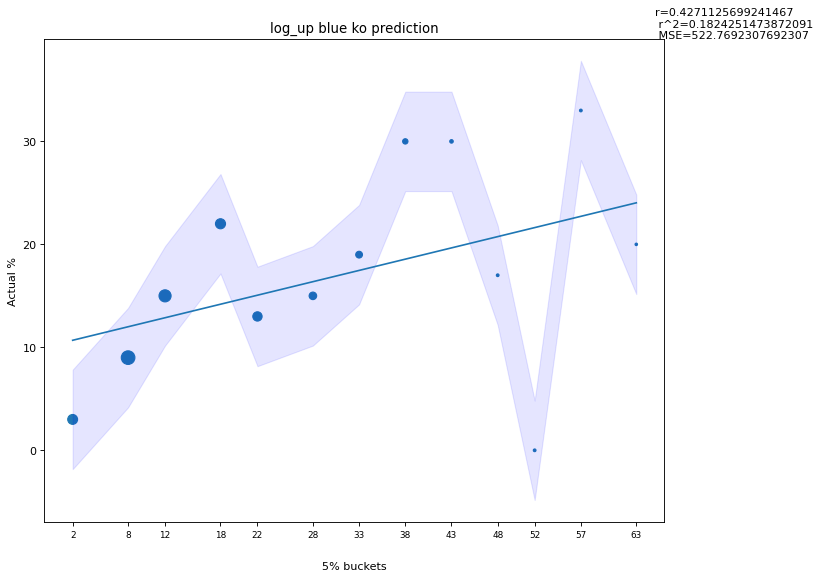

['rf_no']
rf_no
0% to 5%: 14% of 85 observations
5% to 10%: 14% of 369 observations
10% to 15%: 14% of 176 observations
15% to 20%: 14% of 21 observations
20% to 25%: 0% of 0 observations
25% to 30%: 0% of 0 observations
30% to 35%: 0% of 1 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[85, 369, 176, 21]
[2, 8, 12, 18]
[14, 14, 14, 14]


C:\Users\audri\anaconda3\envs\stats\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\audri\anaconda3\envs\stats\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


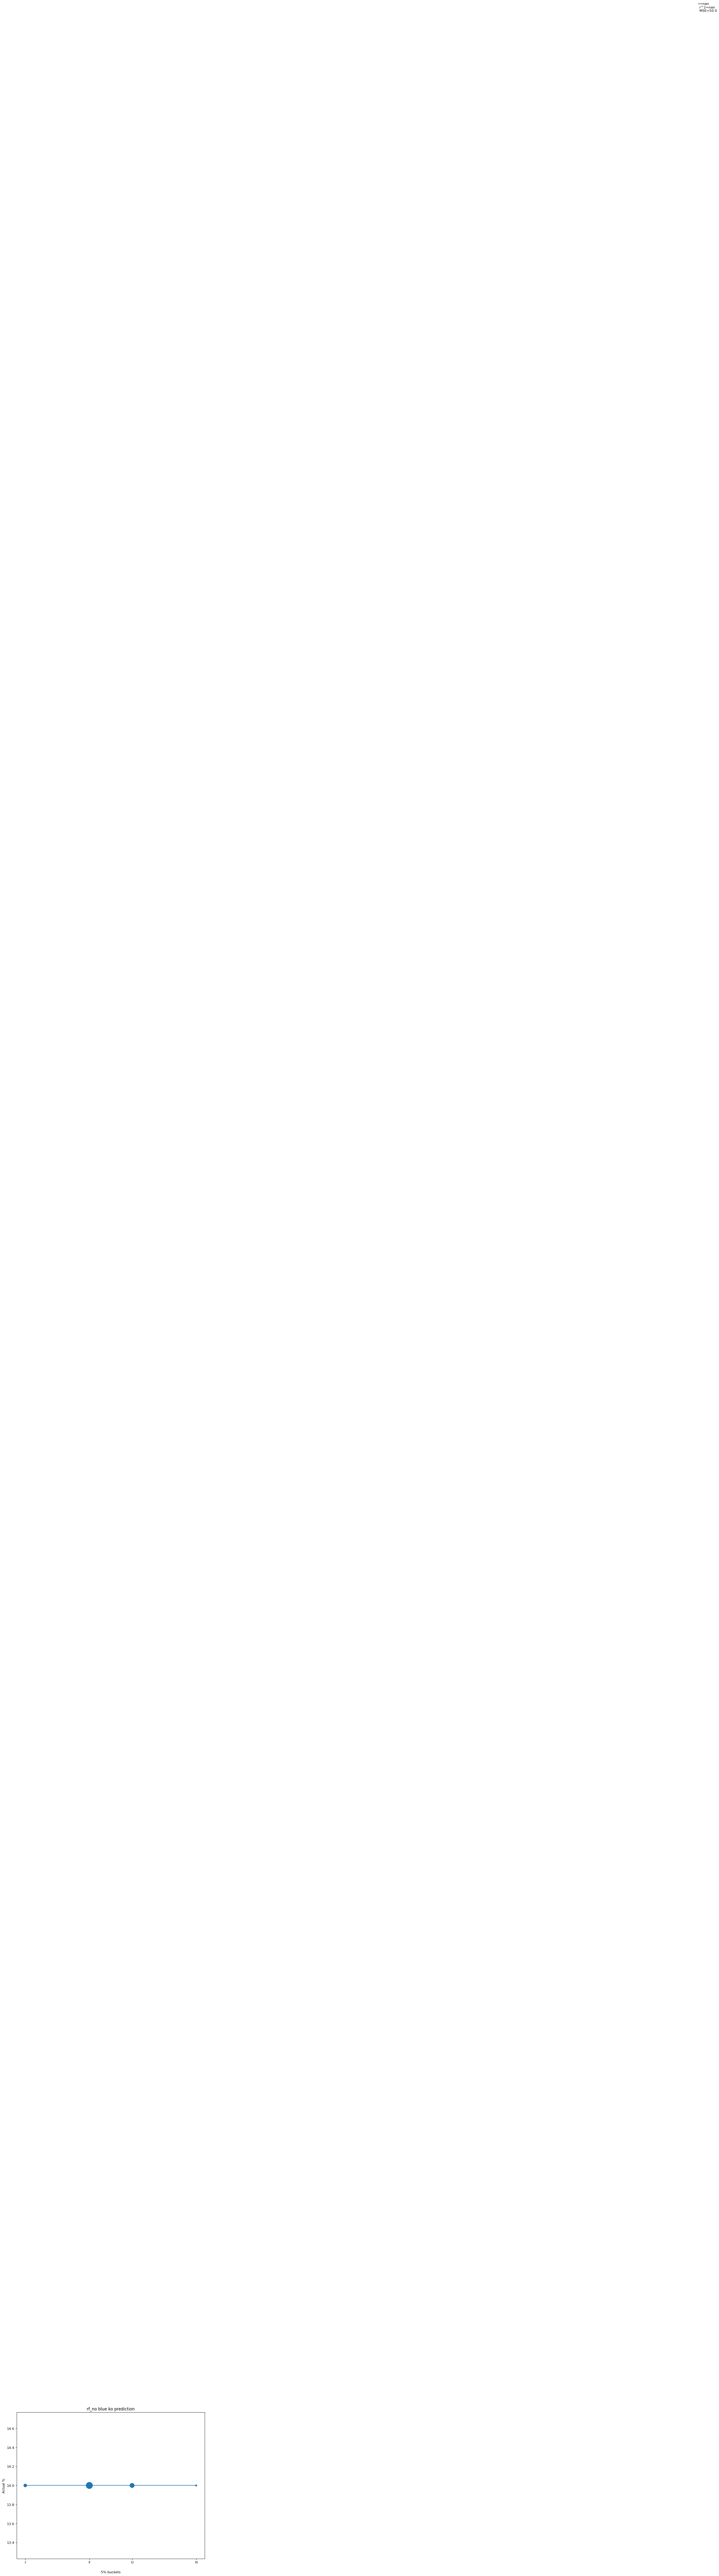

['rf_rand']
rf_rand
0% to 5%: 0% of 12 observations
5% to 10%: 10% of 165 observations
10% to 15%: 17% of 337 observations
15% to 20%: 14% of 111 observations
20% to 25%: 8% of 24 observations
25% to 30%: 0% of 2 observations
30% to 35%: 0% of 1 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[12, 165, 337, 111, 24]
[2, 8, 12, 18, 22]
[0, 10, 17, 14, 8]


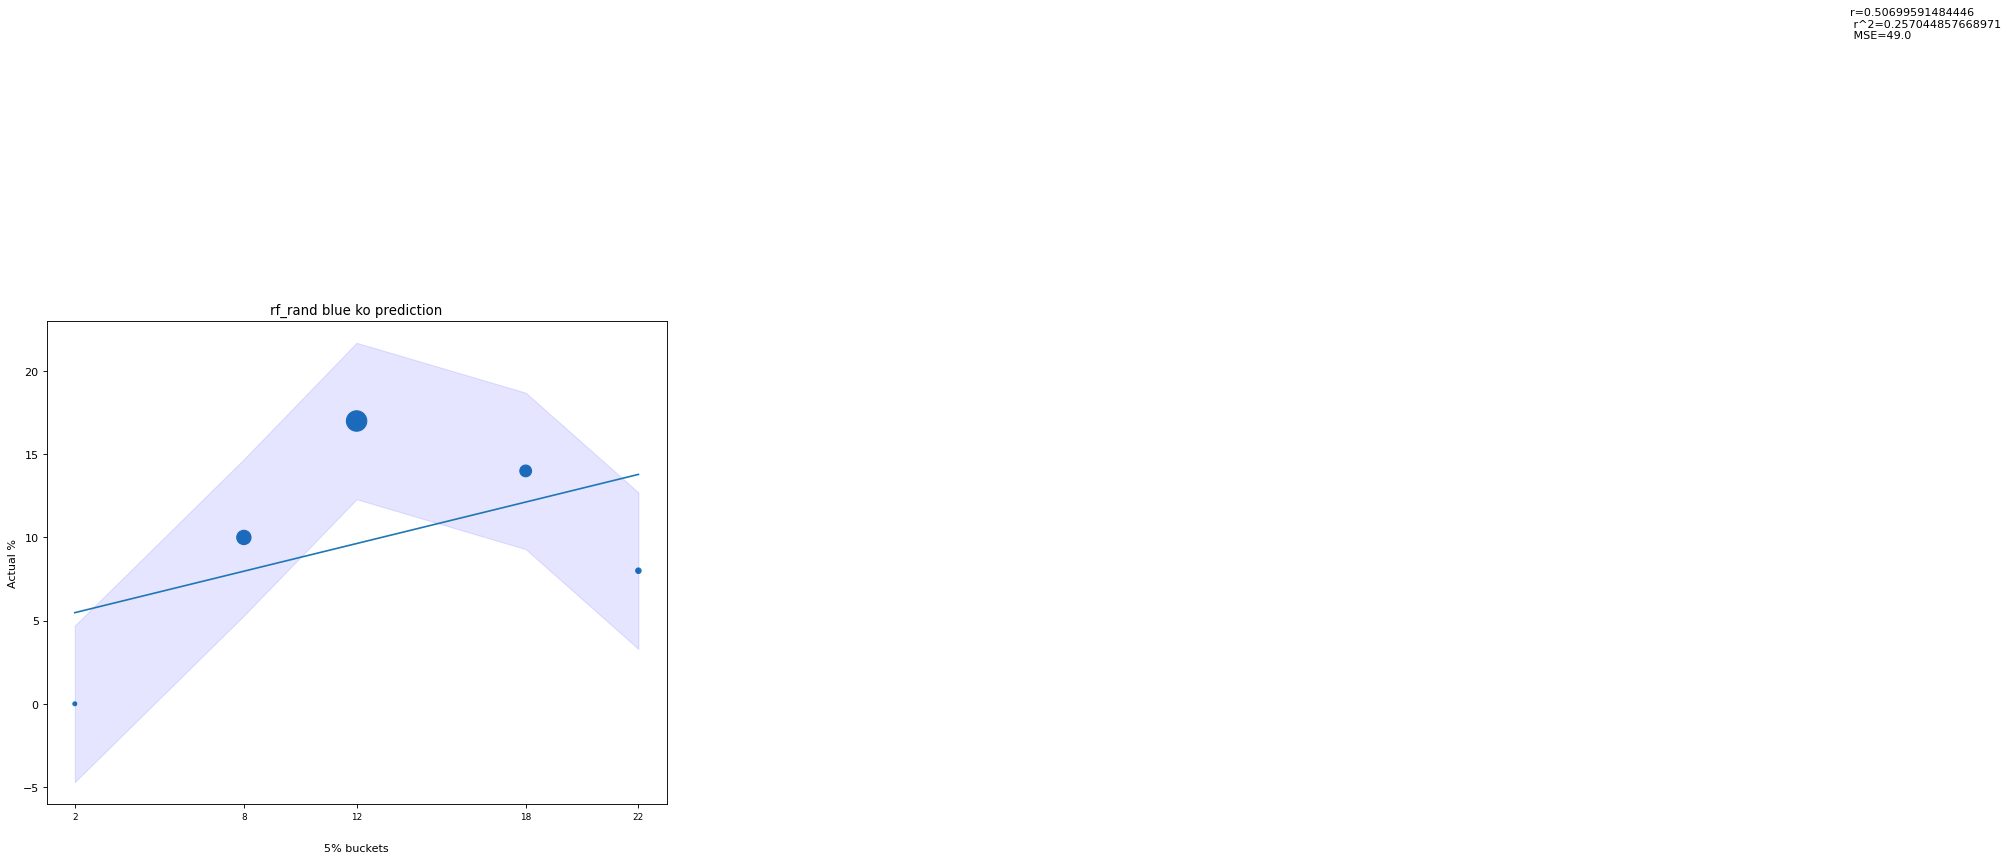

['rf_up']
rf_up
0% to 5%: 6% of 32 observations
5% to 10%: 14% of 312 observations
10% to 15%: 14% of 264 observations
15% to 20%: 18% of 34 observations
20% to 25%: 33% of 9 observations
25% to 30%: 0% of 1 observations
30% to 35%: 0% of 0 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[32, 312, 264, 34, 9]
[2, 8, 12, 18, 22]
[6, 14, 14, 18, 33]


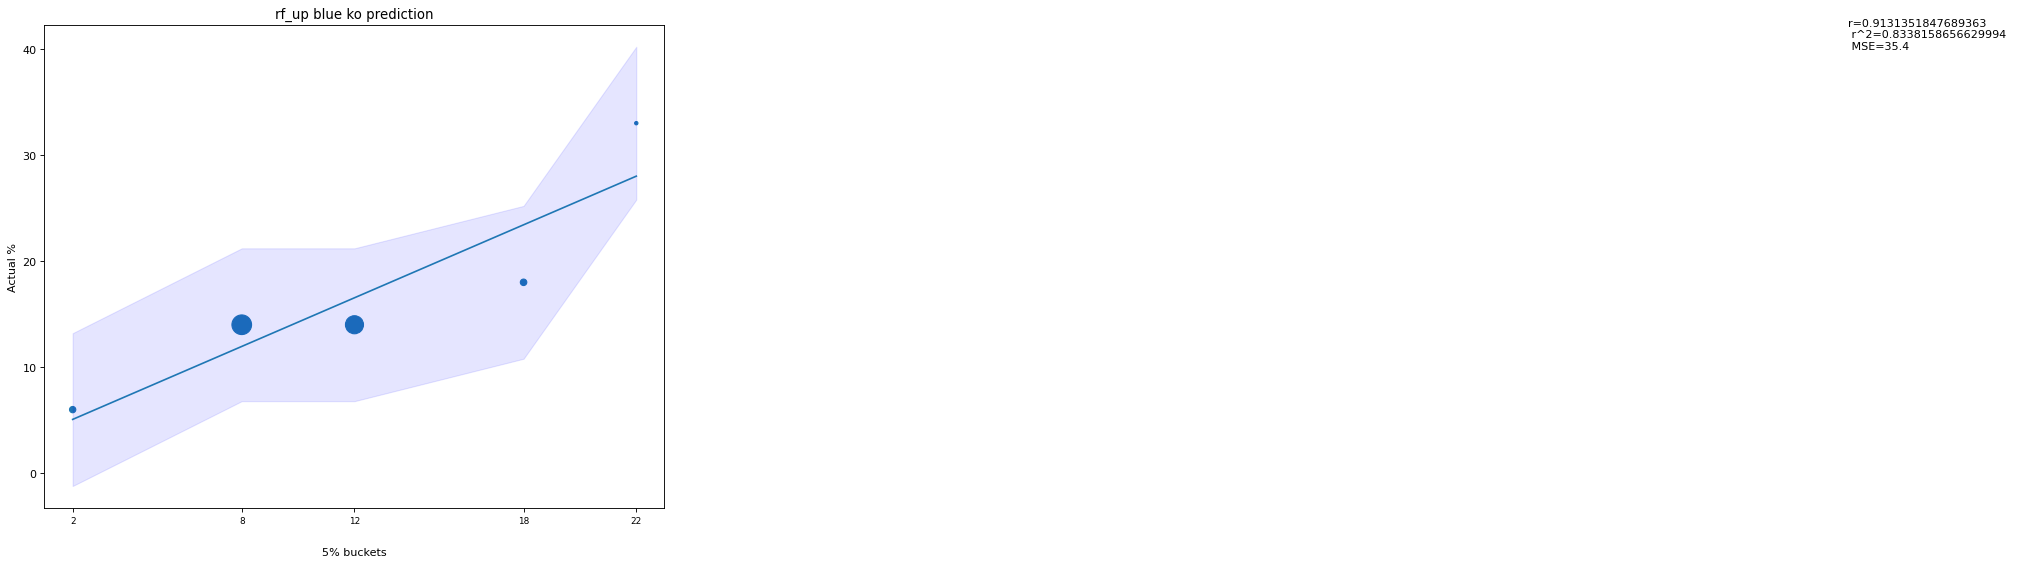

['mlp_no']
mlp_no
0% to 5%: 9% of 255 observations
5% to 10%: 16% of 146 observations
10% to 15%: 21% of 76 observations
15% to 20%: 16% of 43 observations
20% to 25%: 12% of 48 observations
25% to 30%: 11% of 19 observations
30% to 35%: 7% of 14 observations
35% to 40%: 22% of 9 observations
40% to 45%: 33% of 15 observations
45% to 50%: 28% of 7 observations
50% to 55%: 17% of 6 observations
55% to 60%: 33% of 3 observations
60% to 65%: 50% of 4 observations
65% to 70%: 0% of 2 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 50% of 2 observations
85% to 90%: 0% of 1 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[255, 146, 76, 43, 48, 19, 14, 9, 15, 7, 6]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52]
[9, 16, 21, 16, 12, 11, 7, 22, 33, 28, 17]


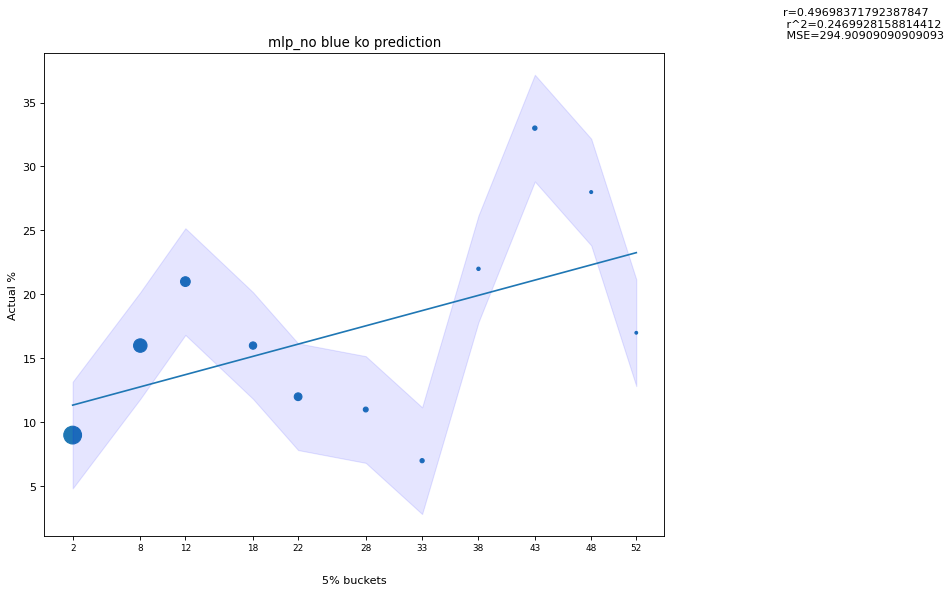

['mlp_rand']
mlp_rand
0% to 5%: 7% of 160 observations
5% to 10%: 8% of 138 observations
10% to 15%: 12% of 95 observations
15% to 20%: 15% of 46 observations
20% to 25%: 27% of 51 observations
25% to 30%: 20% of 40 observations
30% to 35%: 20% of 30 observations
35% to 40%: 15% of 20 observations
40% to 45%: 40% of 10 observations
45% to 50%: 38% of 13 observations
50% to 55%: 18% of 11 observations
55% to 60%: 25% of 4 observations
60% to 65%: 22% of 9 observations
65% to 70%: 30% of 10 observations
70% to 75%: 67% of 3 observations
75% to 80%: 0% of 5 observations
80% to 85%: 33% of 3 observations
85% to 90%: 33% of 3 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[160, 138, 95, 46, 51, 40, 30, 20, 10, 13, 11, 9, 10, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 63, 68, 78]
[7, 8, 12, 15, 27, 20, 20, 15, 40, 38, 18, 22, 30, 0]


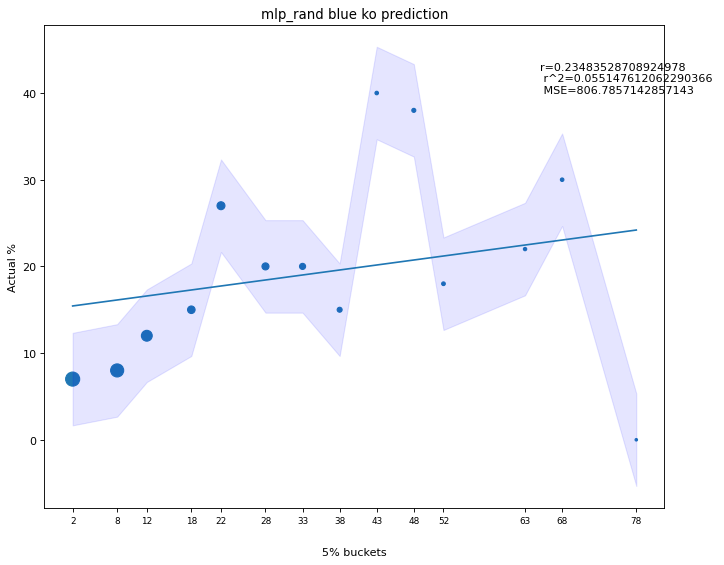

['mlp_up']
mlp_up
0% to 5%: 9% of 335 observations
5% to 10%: 22% of 85 observations
10% to 15%: 16% of 43 observations
15% to 20%: 22% of 32 observations
20% to 25%: 14% of 35 observations
25% to 30%: 13% of 23 observations
30% to 35%: 28% of 17 observations
35% to 40%: 23% of 13 observations
40% to 45%: 22% of 9 observations
45% to 50%: 33% of 12 observations
50% to 55%: 10% of 10 observations
55% to 60%: 25% of 8 observations
60% to 65%: 0% of 8 observations
65% to 70%: 14% of 7 observations
70% to 75%: 20% of 5 observations
75% to 80%: 0% of 3 observations
80% to 85%: 0% of 4 observations
85% to 90%: 20% of 5 observations
90% to 95%: 0% of 3 observations
95% to 100%: 100% of 1 observations
[335, 85, 43, 32, 35, 23, 17, 13, 9, 12, 10, 8, 8, 7, 5, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63, 68, 73, 88]
[9, 22, 16, 22, 14, 13, 28, 23, 22, 33, 10, 25, 0, 14, 20, 20]


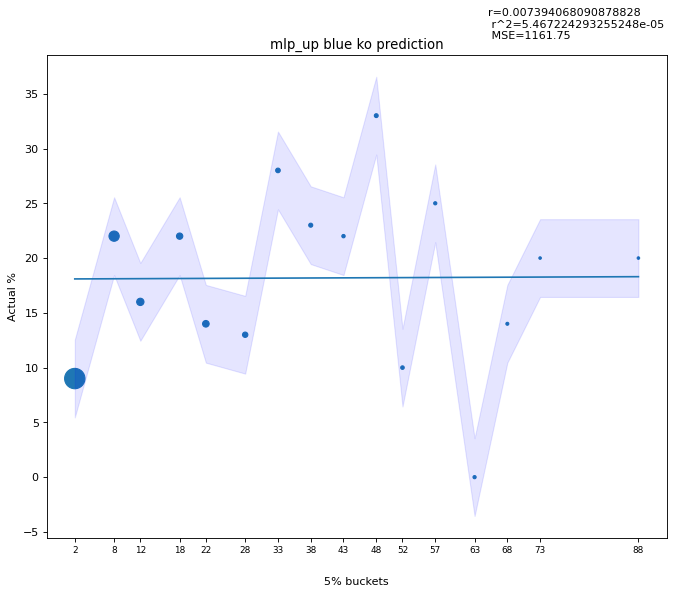

['nn_no']
nn_no
0% to 5%: 4% of 147 observations
5% to 10%: 10% of 181 observations
10% to 15%: 15% of 144 observations
15% to 20%: 21% of 56 observations
20% to 25%: 23% of 48 observations
25% to 30%: 30% of 33 observations
30% to 35%: 33% of 15 observations
35% to 40%: 50% of 8 observations
40% to 45%: 28% of 7 observations
45% to 50%: 0% of 1 observations
50% to 55%: 25% of 4 observations
55% to 60%: 33% of 3 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[147, 181, 144, 56, 48, 33, 15, 8, 7]
[2, 8, 12, 18, 22, 28, 33, 38, 43]
[4, 10, 15, 21, 23, 30, 33, 50, 28]


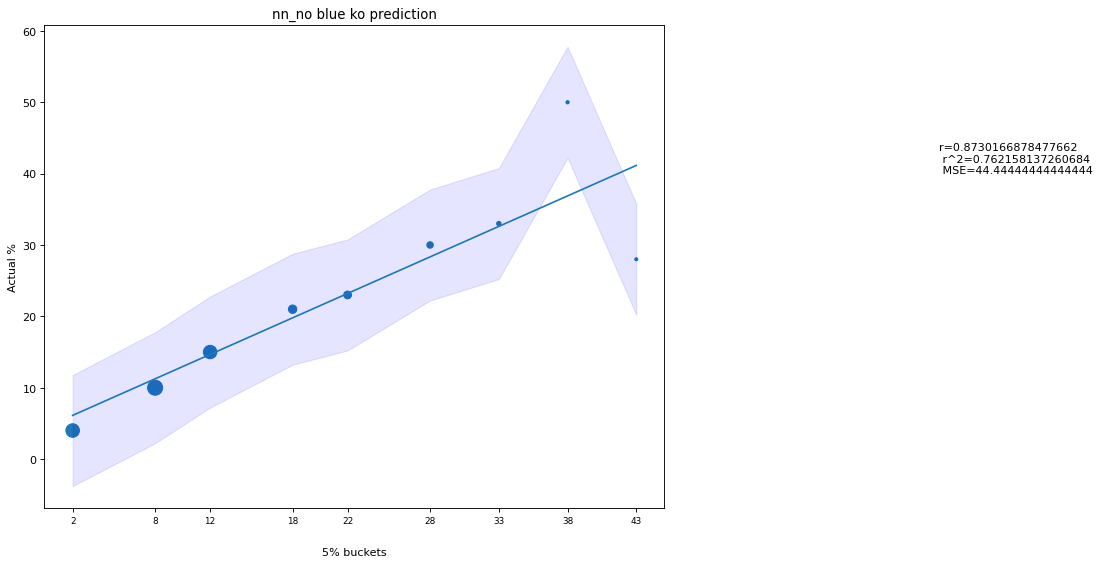

['nn_rand']
nn_rand
0% to 5%: 5% of 64 observations
5% to 10%: 6% of 154 observations
10% to 15%: 6% of 145 observations
15% to 20%: 22% of 65 observations
20% to 25%: 21% of 66 observations
25% to 30%: 23% of 60 observations
30% to 35%: 17% of 29 observations
35% to 40%: 31% of 16 observations
40% to 45%: 43% of 21 observations
45% to 50%: 25% of 8 observations
50% to 55%: 44% of 9 observations
55% to 60%: 25% of 4 observations
60% to 65%: 100% of 2 observations
65% to 70%: 100% of 1 observations
70% to 75%: 0% of 1 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[64, 154, 145, 65, 66, 60, 29, 16, 21, 8, 9]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52]
[5, 6, 6, 22, 21, 23, 17, 31, 43, 25, 44]


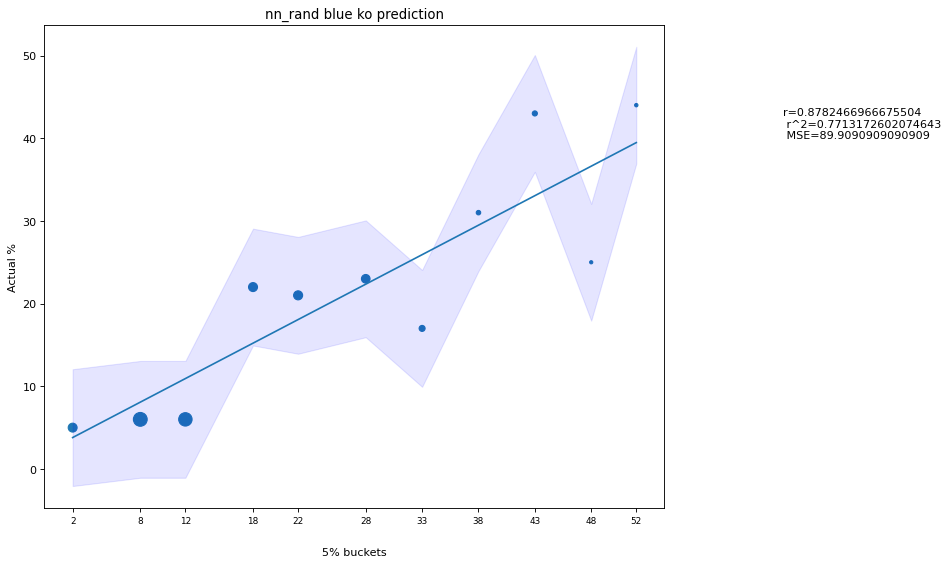

['nn_up']
nn_up
0% to 5%: 6% of 198 observations
5% to 10%: 16% of 142 observations
10% to 15%: 13% of 89 observations
15% to 20%: 21% of 33 observations
20% to 25%: 22% of 50 observations
25% to 30%: 10% of 29 observations
30% to 35%: 27% of 26 observations
35% to 40%: 21% of 14 observations
40% to 45%: 16% of 19 observations
45% to 50%: 9% of 11 observations
50% to 55%: 30% of 10 observations
55% to 60%: 55% of 11 observations
60% to 65%: 20% of 5 observations
65% to 70%: 0% of 4 observations
70% to 75%: 25% of 4 observations
75% to 80%: 50% of 2 observations
80% to 85%: 0% of 1 observations
85% to 90%: 0% of 1 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[198, 142, 89, 33, 50, 29, 26, 14, 19, 11, 10, 11, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 43, 48, 52, 57, 63]
[6, 16, 13, 21, 22, 10, 27, 21, 16, 9, 30, 55, 20]


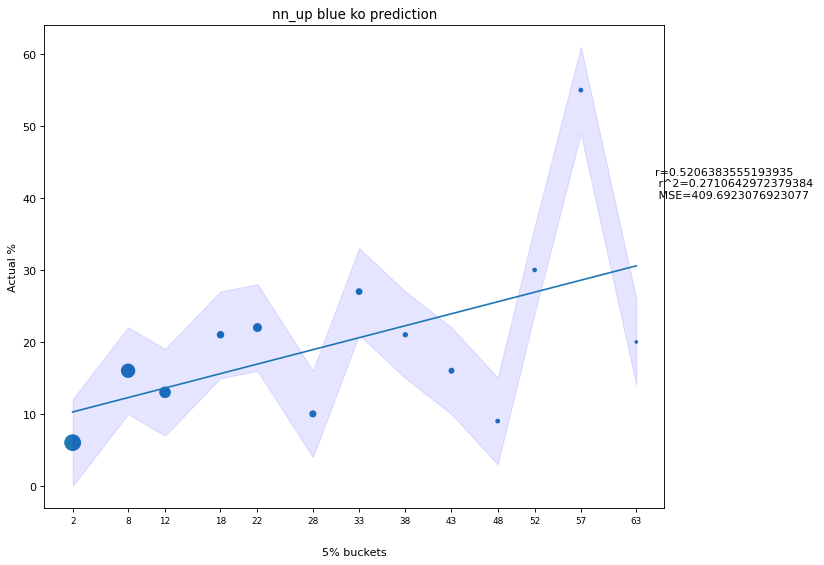

['mix_no']
mix_no
0% to 5%: 3% of 39 observations
5% to 10%: 8% of 213 observations
10% to 15%: 14% of 217 observations
15% to 20%: 25% of 92 observations
20% to 25%: 23% of 53 observations
25% to 30%: 17% of 23 observations
30% to 35%: 62% of 8 observations
35% to 40%: 25% of 4 observations
40% to 45%: 0% of 2 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[39, 213, 217, 92, 53, 23, 8]
[2, 8, 12, 18, 22, 28, 33]
[3, 8, 14, 25, 23, 17, 62]


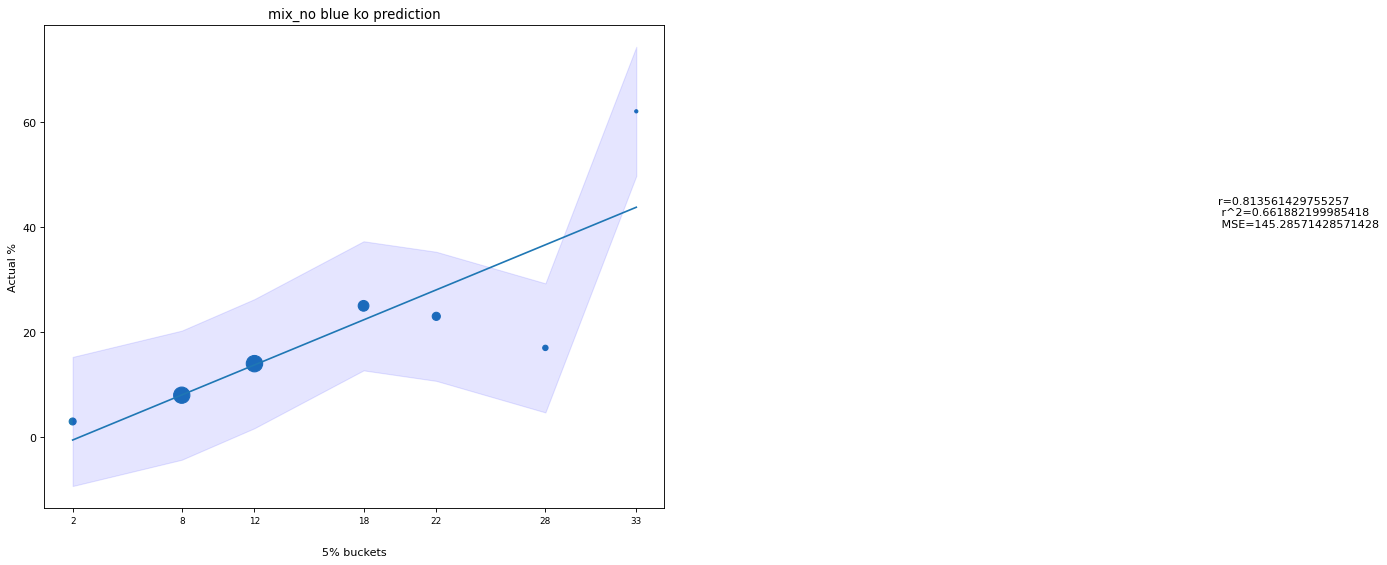

['mix_rand']
mix_rand
0% to 5%: 0% of 13 observations
5% to 10%: 4% of 125 observations
10% to 15%: 9% of 201 observations
15% to 20%: 16% of 116 observations
20% to 25%: 23% of 73 observations
25% to 30%: 25% of 53 observations
30% to 35%: 23% of 35 observations
35% to 40%: 38% of 21 observations
40% to 45%: 25% of 4 observations
45% to 50%: 0% of 0 observations
50% to 55%: 100% of 1 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[13, 125, 201, 116, 73, 53, 35, 21]
[2, 8, 12, 18, 22, 28, 33, 38]
[0, 4, 9, 16, 23, 25, 23, 38]


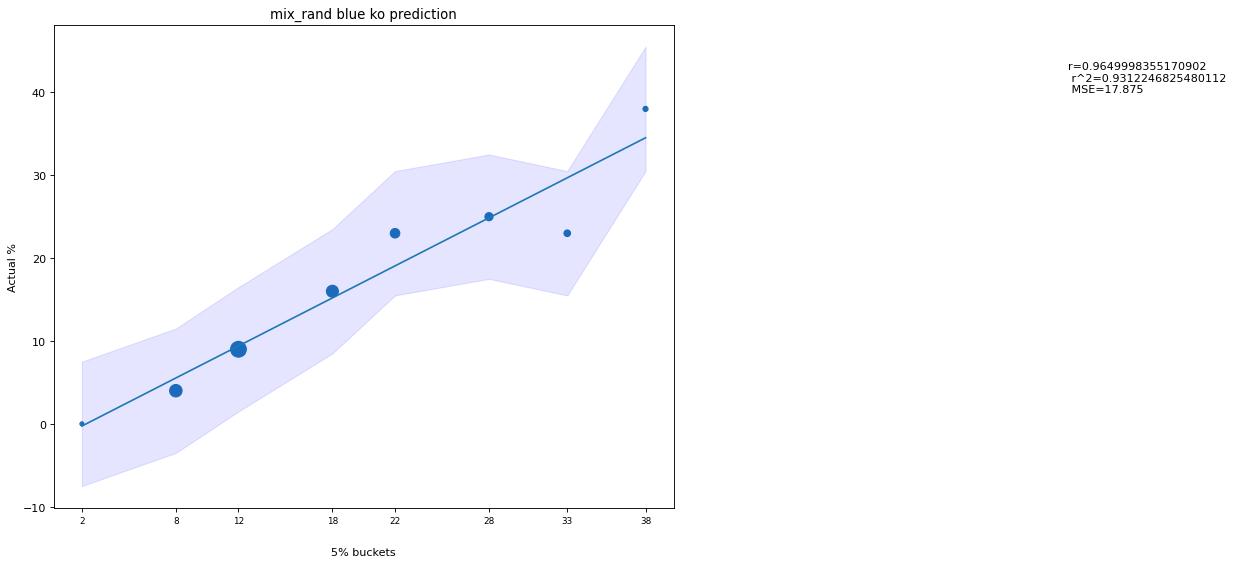

['mix_up']
mix_up
0% to 5%: 0% of 21 observations
5% to 10%: 6% of 158 observations
10% to 15%: 13% of 211 observations
15% to 20%: 17% of 107 observations
20% to 25%: 24% of 85 observations
25% to 30%: 24% of 37 observations
30% to 35%: 38% of 16 observations
35% to 40%: 25% of 8 observations
40% to 45%: 33% of 3 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[21, 158, 211, 107, 85, 37, 16, 8]
[2, 8, 12, 18, 22, 28, 33, 38]
[0, 6, 13, 17, 24, 24, 38, 25]


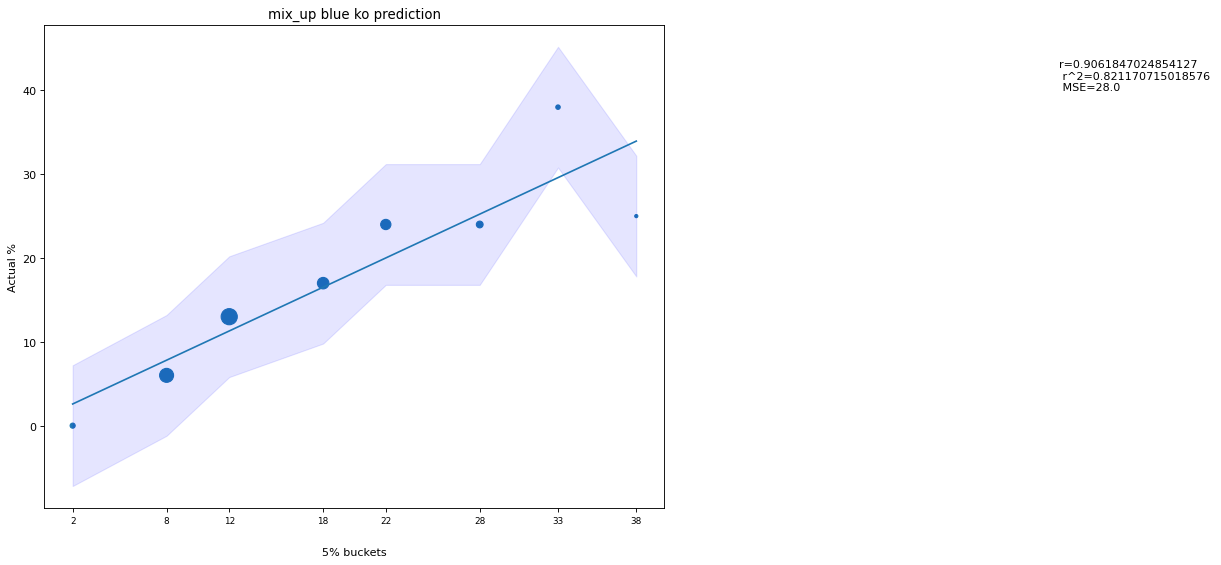

['combined']
combined
0% to 5%: 0% of 18 observations
5% to 10%: 4% of 178 observations
10% to 15%: 15% of 224 observations
15% to 20%: 15% of 106 observations
20% to 25%: 27% of 67 observations
25% to 30%: 36% of 33 observations
30% to 35%: 40% of 10 observations
35% to 40%: 40% of 5 observations
40% to 45%: 33% of 3 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[18, 178, 224, 106, 67, 33, 10, 5]
[2, 8, 12, 18, 22, 28, 33, 38]
[0, 4, 15, 15, 27, 36, 40, 40]


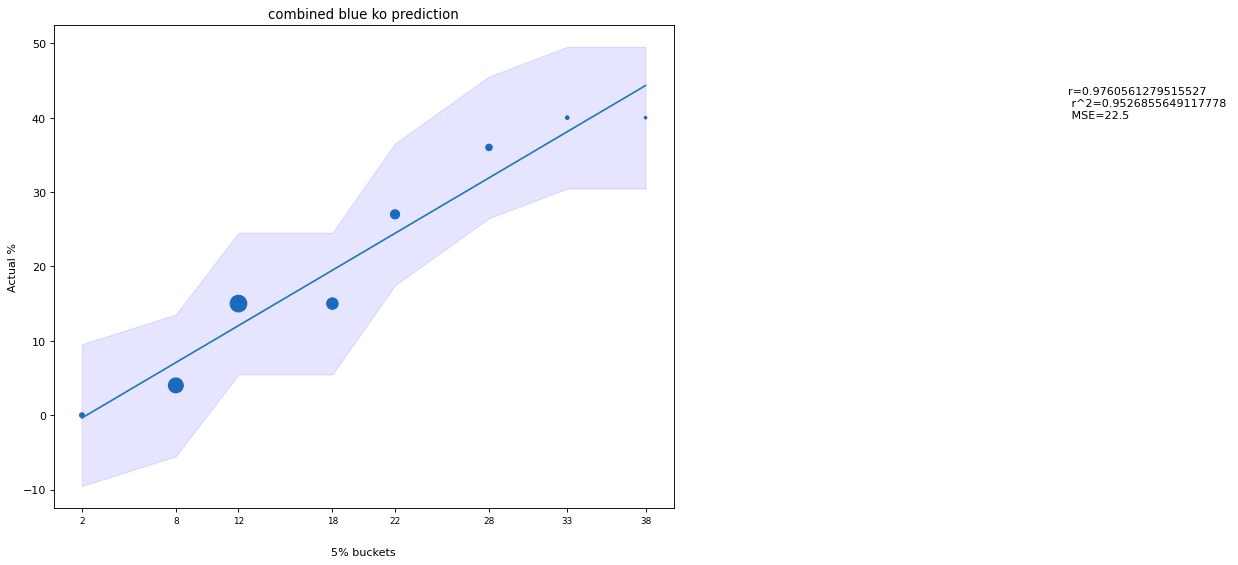

In [83]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
    print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["blue_ko_pct"] >= x]
        point_to_point = point_up[point_up["blue_ko_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - KO/TKO"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

    print(observations)
    print(half_points)
    print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
    plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} blue ko prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [84]:
blue_ko_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

blue_ko_df = pd.DataFrame(blue_ko_dict)
blue_ko_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.571111   0.326168     83.857143
1     knn_rand  0.765020   0.585255     71.250000
2       knn_up  0.833043   0.693960    219.000000
3       log_no  0.809281   0.654935     90.222222
4     log_rand  0.815689   0.665348    156.090909
5       log_up  0.427113   0.182425    522.769231
6        rf_no       NaN        NaN     50.000000
7      rf_rand  0.506996   0.257045     49.000000
8        rf_up  0.913135   0.833816     35.400000
9       mlp_no  0.496984   0.246993    294.909091
10    mlp_rand  0.234835   0.055148    806.785714
11      mlp_up  0.007394   0.000055   1161.750000
12       nn_no  0.873017   0.762158     44.444444
13     nn_rand  0.878247   0.771317     89.909091
14       nn_up  0.520638   0.271064    409.692308
15      mix_no  0.813561   0.661882    145.285714
16    mix_rand  0.965000   0.931225     17.875000
17      mix_up  0.906185   0.821171     28.000000
18    combined  0.976056   0.952686     22.500000

['knn_no']
knn_no
0% to 5%: 7% of 184 observations
5% to 10%: 8% of 236 observations
10% to 15%: 9% of 202 observations
15% to 20%: 24% of 25 observations
20% to 25%: 0% of 4 observations
25% to 30%: 0% of 1 observations
30% to 35%: 0% of 0 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[184, 236, 202, 25]
[2, 8, 12, 18]
[7, 8, 9, 24]


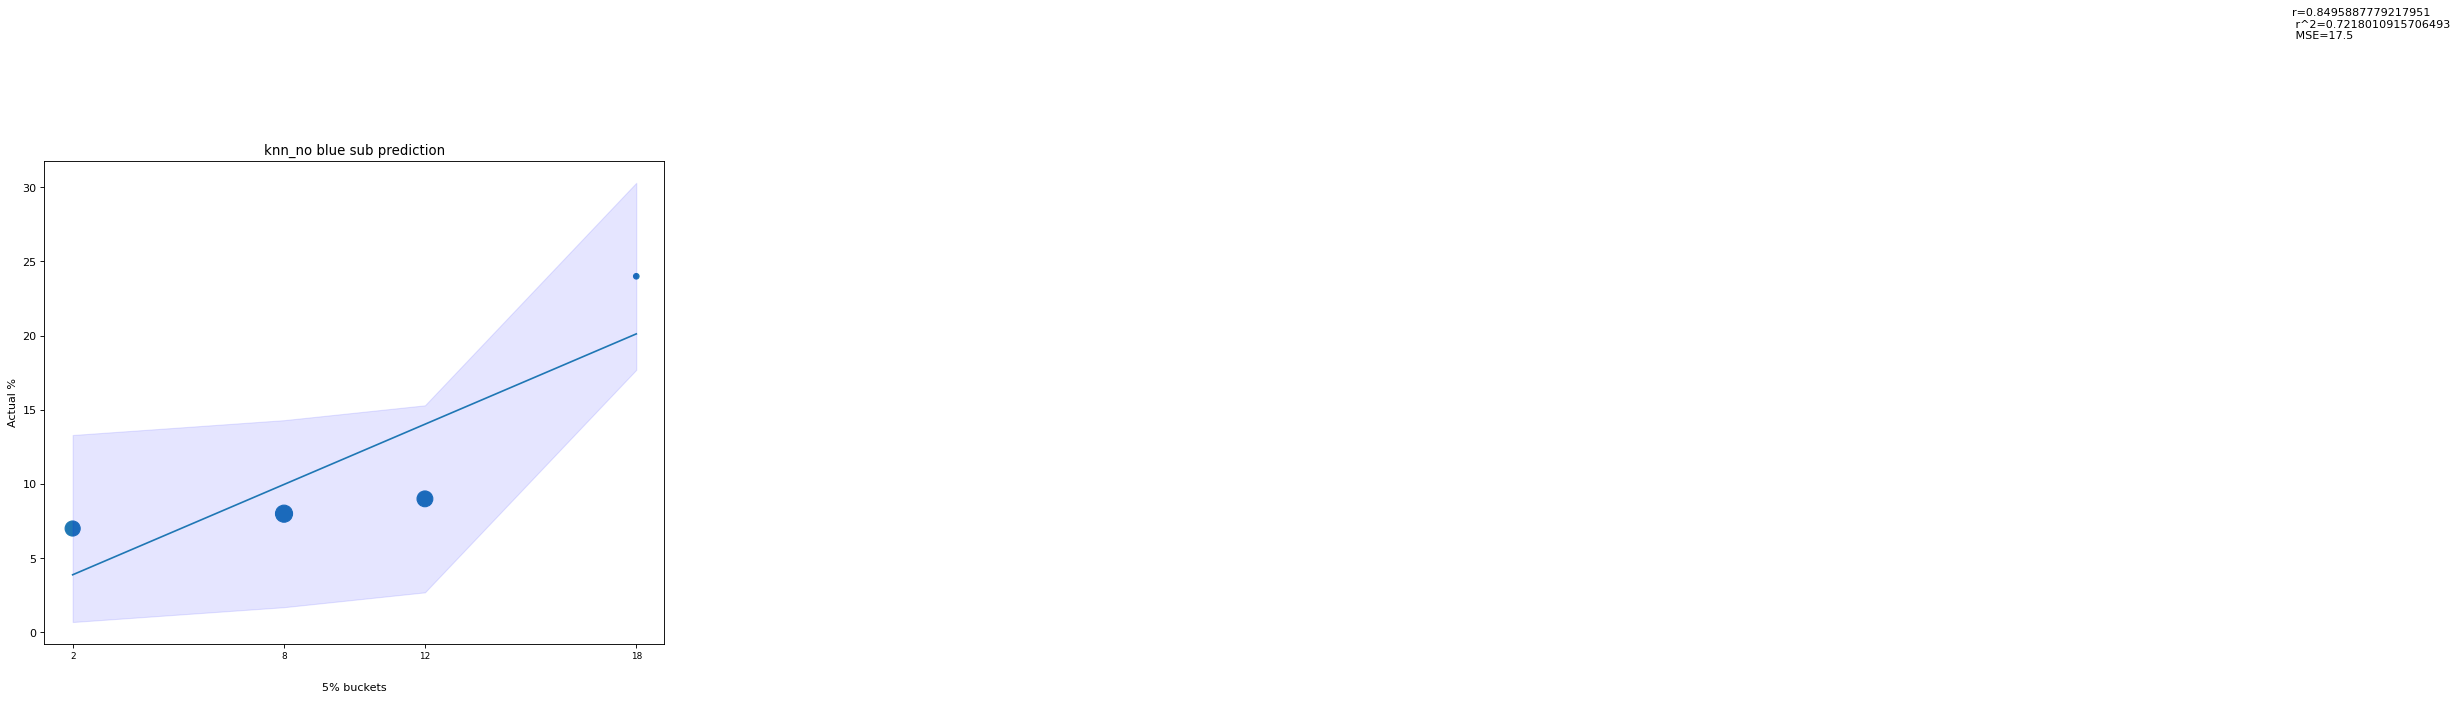

['knn_rand']
knn_rand
0% to 5%: 7% of 135 observations
5% to 10%: 9% of 190 observations
10% to 15%: 8% of 259 observations
15% to 20%: 14% of 36 observations
20% to 25%: 15% of 20 observations
25% to 30%: 10% of 10 observations
30% to 35%: 0% of 0 observations
35% to 40%: 0% of 2 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[135, 190, 259, 36, 20, 10]
[2, 8, 12, 18, 22, 28]
[7, 9, 8, 14, 15, 10]


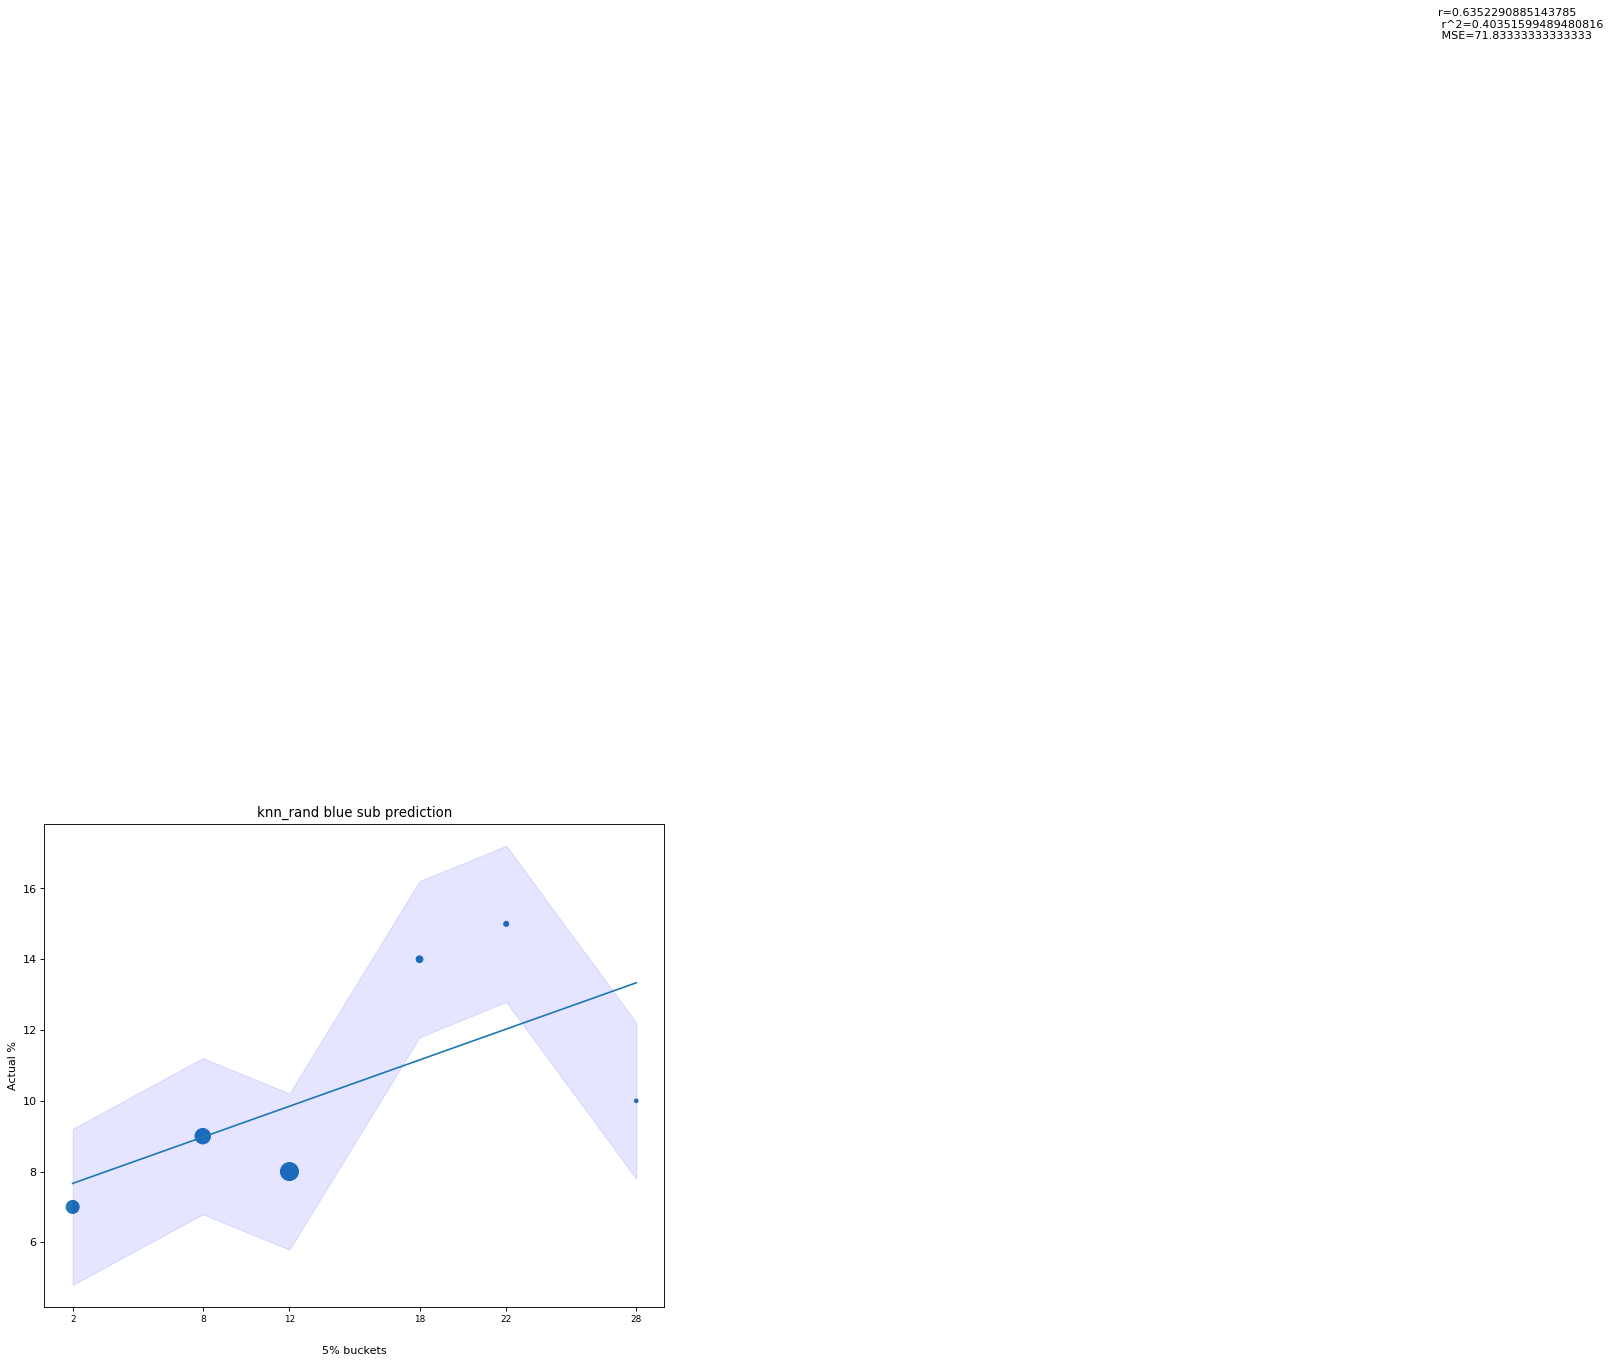

['knn_up']
knn_up
0% to 5%: 6% of 315 observations
5% to 10%: 8% of 78 observations
10% to 15%: 8% of 86 observations
15% to 20%: 13% of 68 observations
20% to 25%: 18% of 38 observations
25% to 30%: 6% of 36 observations
30% to 35%: 12% of 17 observations
35% to 40%: 40% of 5 observations
40% to 45%: 50% of 4 observations
45% to 50%: 0% of 3 observations
50% to 55%: 0% of 2 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[315, 78, 86, 68, 38, 36, 17, 5]
[2, 8, 12, 18, 22, 28, 33, 38]
[6, 8, 8, 13, 18, 6, 12, 40]


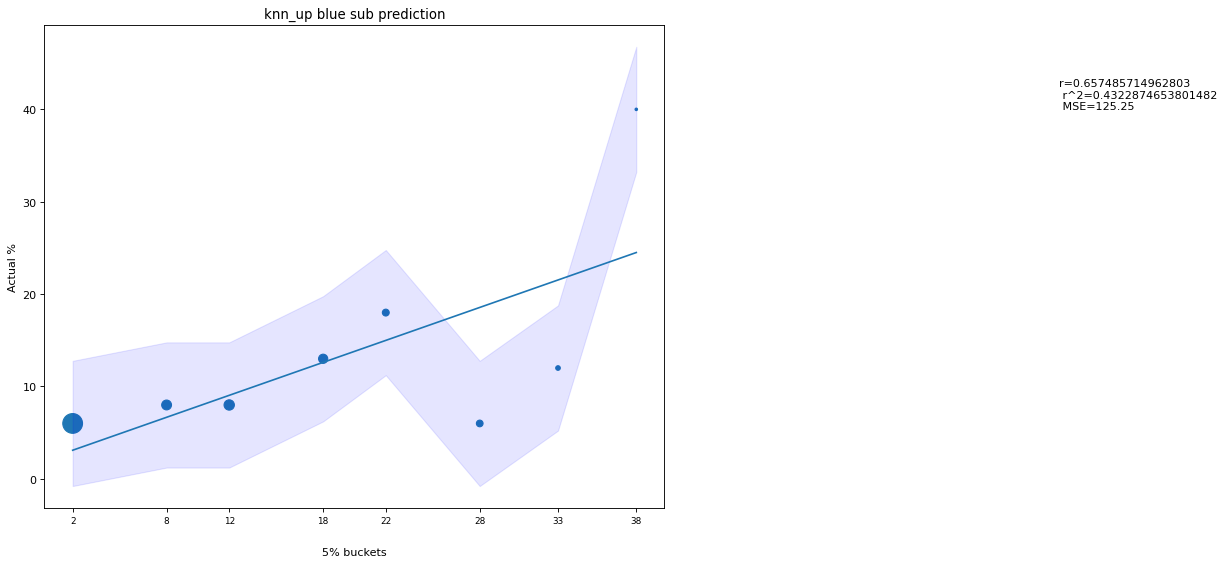

['log_no']
log_no
0% to 5%: 5% of 344 observations
5% to 10%: 9% of 187 observations
10% to 15%: 13% of 83 observations
15% to 20%: 39% of 18 observations
20% to 25%: 38% of 8 observations
25% to 30%: 20% of 5 observations
30% to 35%: 0% of 2 observations
35% to 40%: 0% of 1 observations
40% to 45%: 0% of 1 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 1 observations
55% to 60%: 50% of 2 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[344, 187, 83, 18, 8, 5]
[2, 8, 12, 18, 22, 28]
[5, 9, 13, 39, 38, 20]


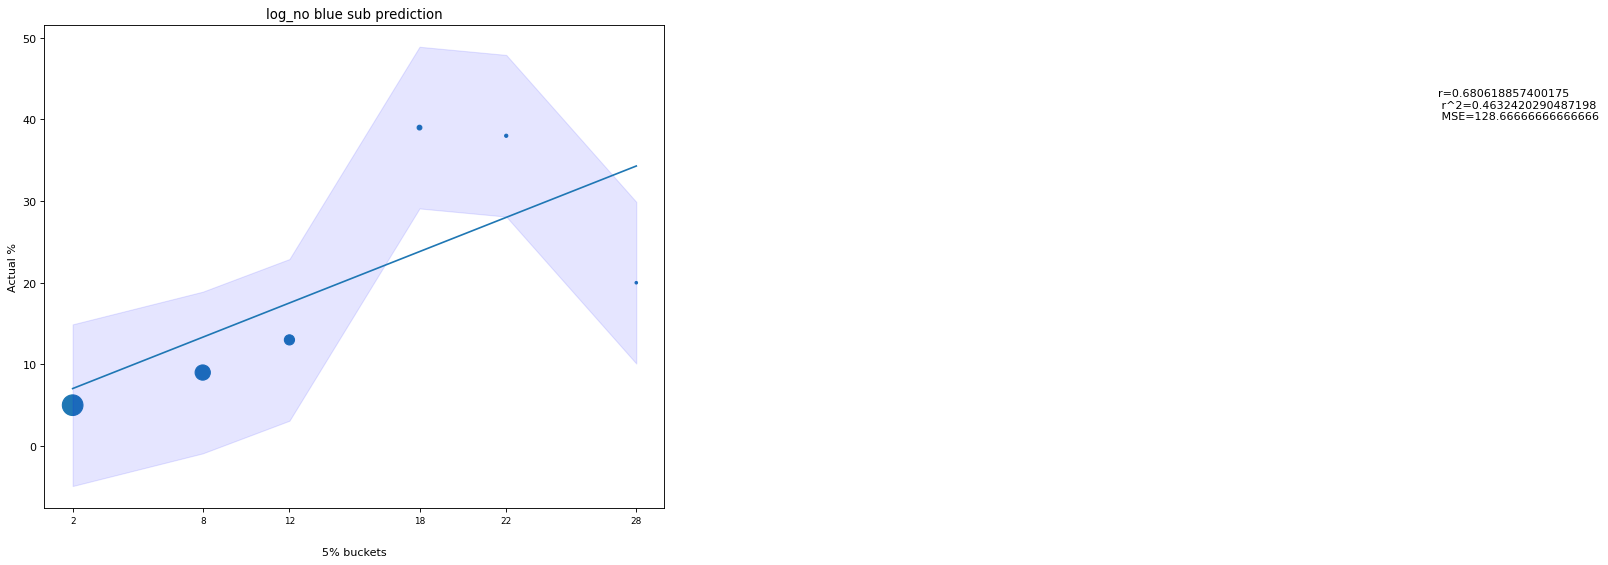

['log_rand']
log_rand
0% to 5%: 7% of 175 observations
5% to 10%: 5% of 237 observations
10% to 15%: 9% of 126 observations
15% to 20%: 13% of 46 observations
20% to 25%: 15% of 27 observations
25% to 30%: 16% of 19 observations
30% to 35%: 25% of 12 observations
35% to 40%: 0% of 2 observations
40% to 45%: 67% of 3 observations
45% to 50%: 0% of 1 observations
50% to 55%: 0% of 0 observations
55% to 60%: 50% of 2 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[175, 237, 126, 46, 27, 19, 12]
[2, 8, 12, 18, 22, 28, 33]
[7, 5, 9, 13, 15, 16, 25]


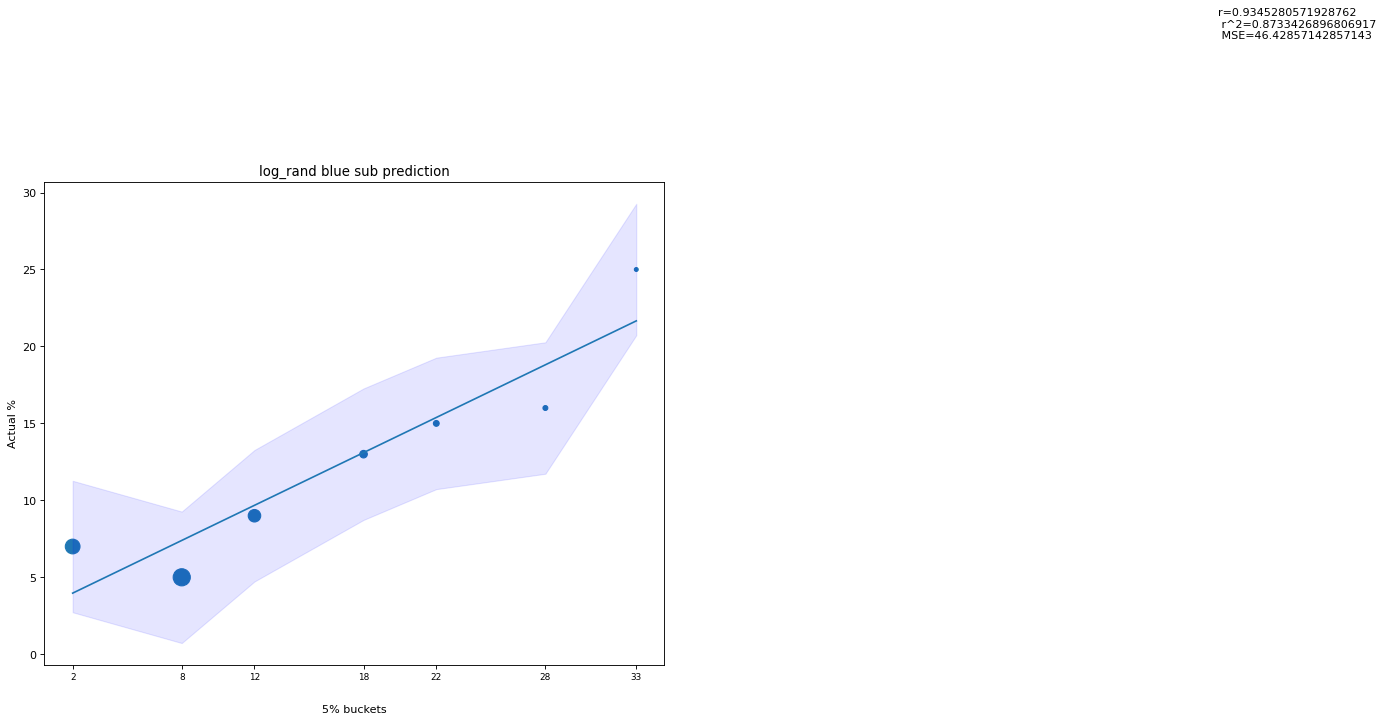

['log_up']
log_up
0% to 5%: 5% of 260 observations
5% to 10%: 6% of 174 observations
10% to 15%: 12% of 121 observations
15% to 20%: 12% of 34 observations
20% to 25%: 22% of 32 observations
25% to 30%: 40% of 10 observations
30% to 35%: 25% of 8 observations
35% to 40%: 25% of 4 observations
40% to 45%: 0% of 2 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 1 observations
60% to 65%: 0% of 2 observations
65% to 70%: 0% of 1 observations
70% to 75%: 0% of 1 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 1 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[260, 174, 121, 34, 32, 10, 8]
[2, 8, 12, 18, 22, 28, 33]
[5, 6, 12, 12, 22, 40, 25]


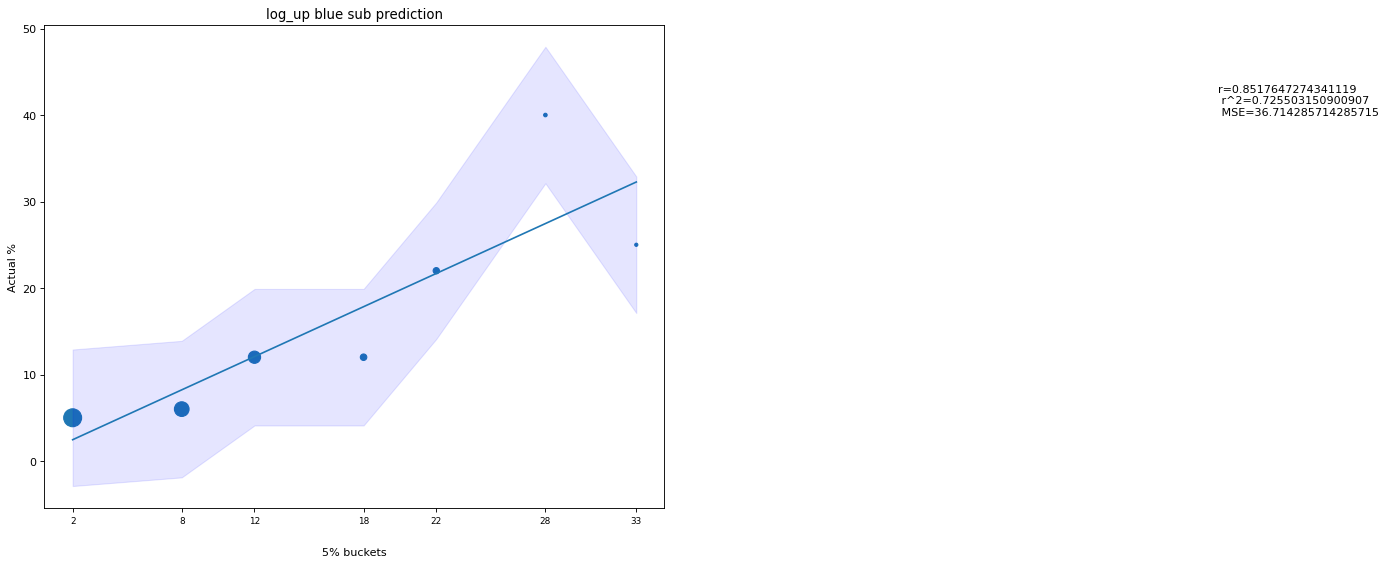

['rf_no']
rf_no
0% to 5%: 8% of 37 observations
5% to 10%: 8% of 333 observations
10% to 15%: 10% of 269 observations
15% to 20%: 0% of 11 observations
20% to 25%: 0% of 2 observations
25% to 30%: 0% of 0 observations
30% to 35%: 0% of 0 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[37, 333, 269, 11]
[2, 8, 12, 18]
[8, 8, 10, 0]


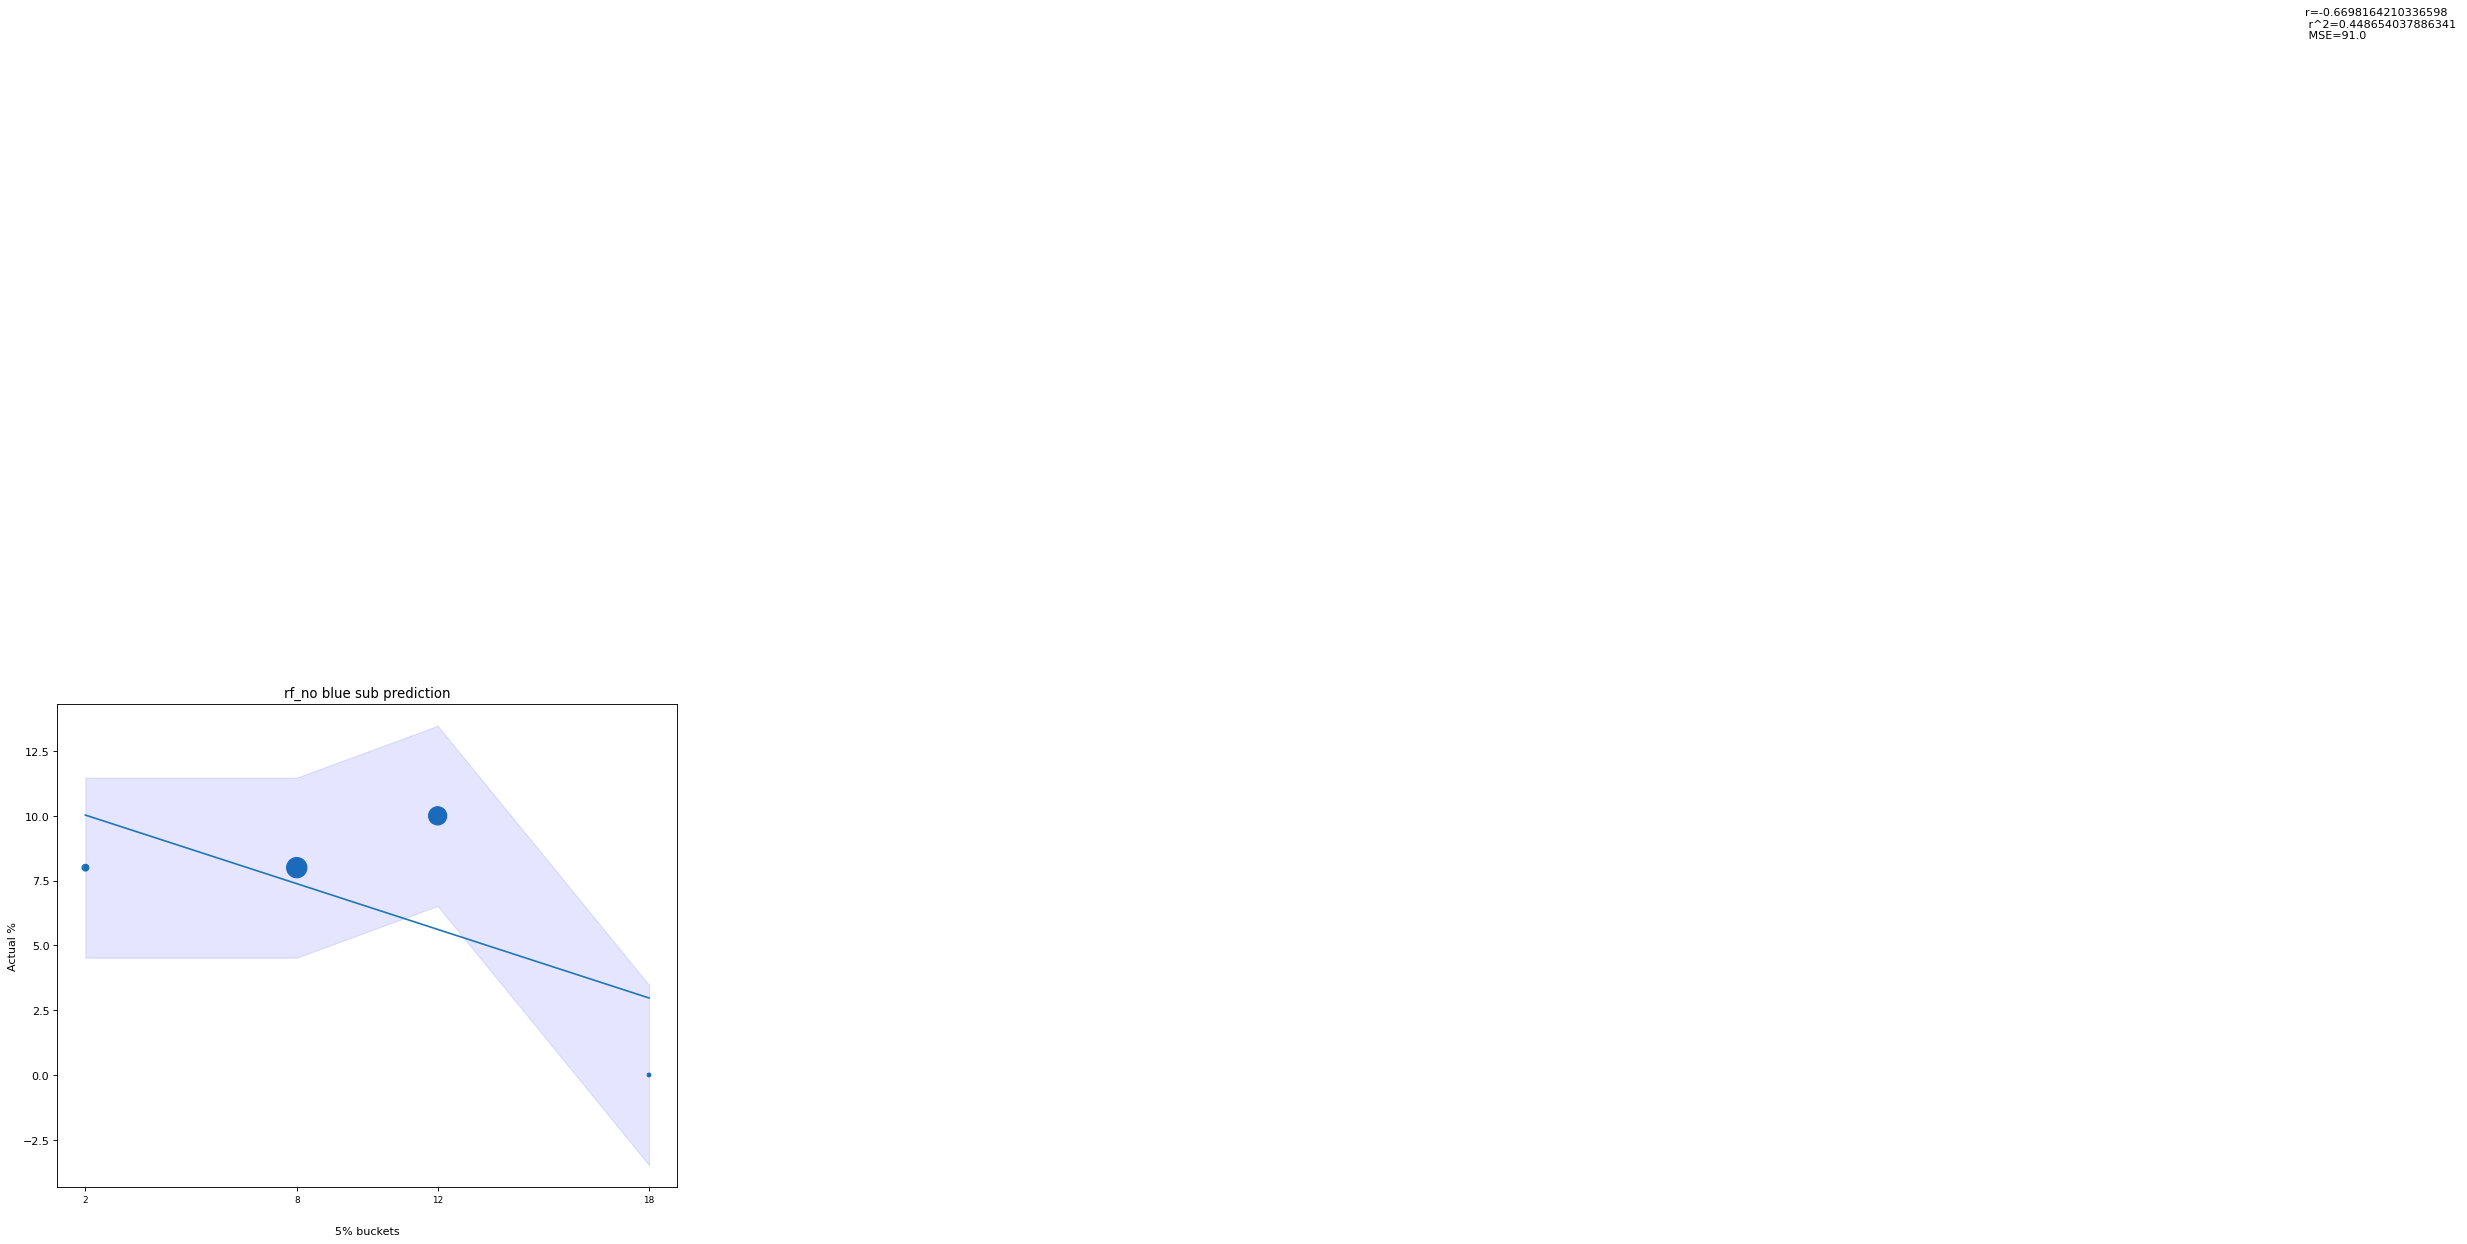

['rf_rand']
rf_rand
0% to 5%: 20% of 5 observations
5% to 10%: 10% of 69 observations
10% to 15%: 6% of 303 observations
15% to 20%: 9% of 183 observations
20% to 25%: 12% of 80 observations
25% to 30%: 20% of 10 observations
30% to 35%: 0% of 1 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[5, 69, 303, 183, 80, 10]
[2, 8, 12, 18, 22, 28]
[20, 10, 6, 9, 12, 20]


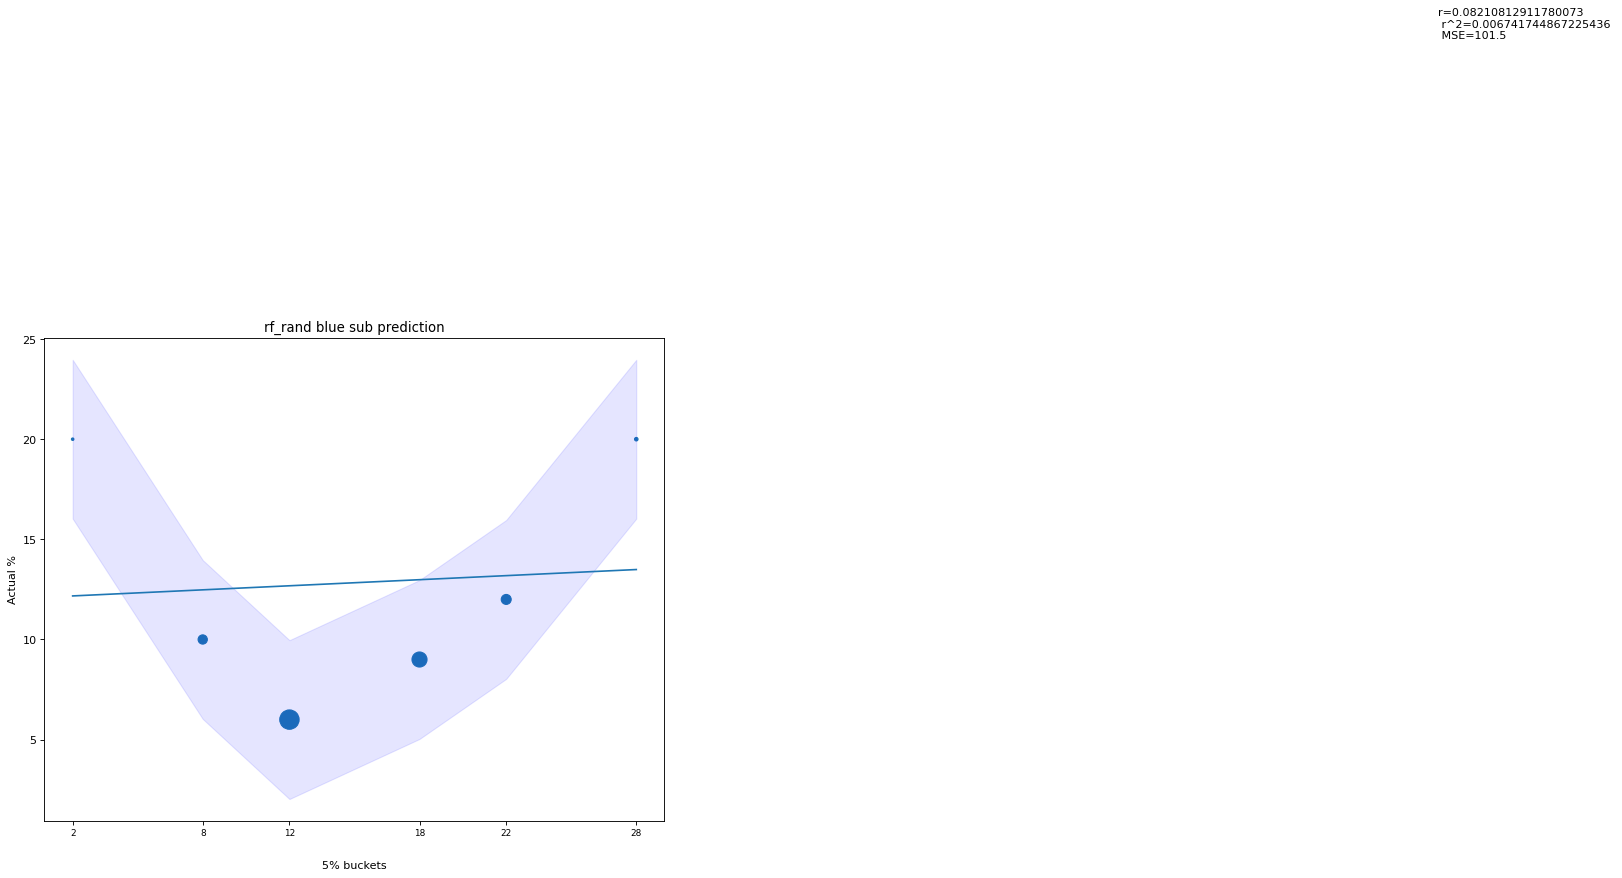

['rf_up']
rf_up
0% to 5%: 4% of 27 observations
5% to 10%: 8% of 252 observations
10% to 15%: 7% of 304 observations
15% to 20%: 18% of 56 observations
20% to 25%: 15% of 13 observations
25% to 30%: 0% of 0 observations
30% to 35%: 0% of 0 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[27, 252, 304, 56, 13]
[2, 8, 12, 18, 22]
[4, 8, 7, 18, 15]


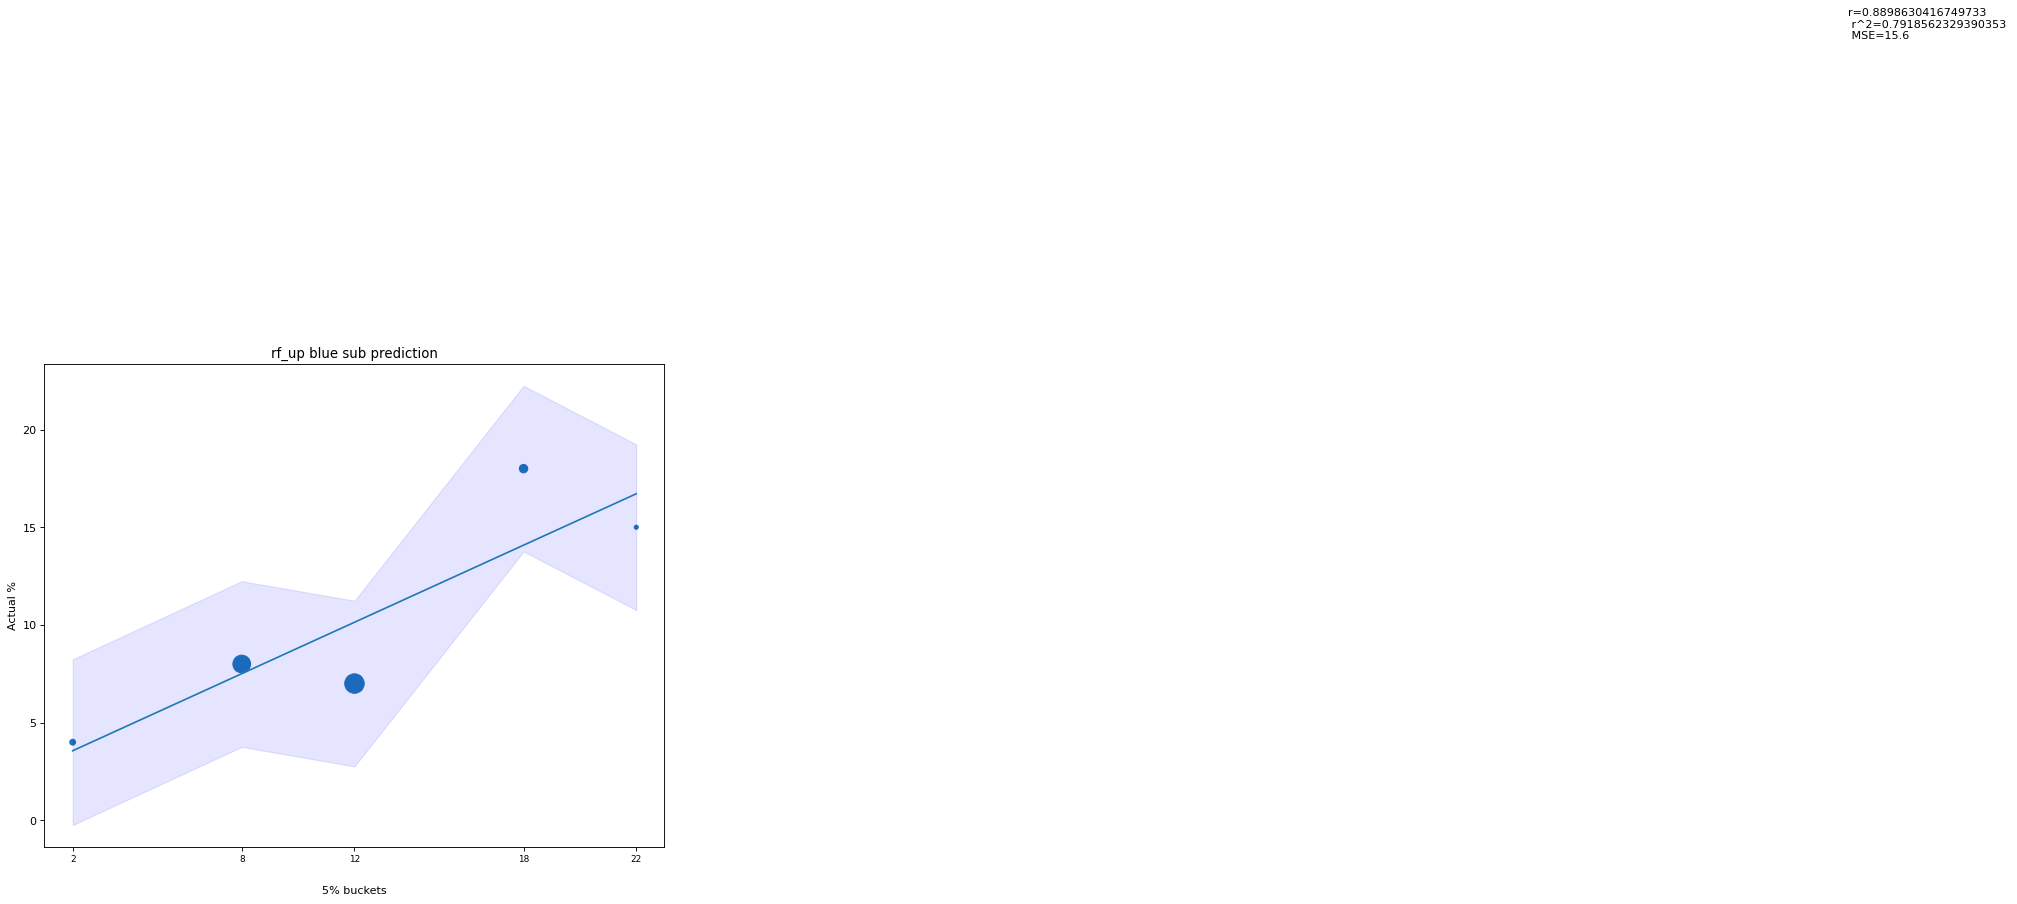

['mlp_no']
mlp_no
0% to 5%: 6% of 427 observations
5% to 10%: 13% of 102 observations
10% to 15%: 6% of 54 observations
15% to 20%: 23% of 26 observations
20% to 25%: 21% of 14 observations
25% to 30%: 11% of 9 observations
30% to 35%: 0% of 7 observations
35% to 40%: 100% of 2 observations
40% to 45%: 0% of 3 observations
45% to 50%: 0% of 2 observations
50% to 55%: 50% of 2 observations
55% to 60%: 0% of 1 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 2 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[427, 102, 54, 26, 14, 9, 7]
[2, 8, 12, 18, 22, 28, 33]
[6, 13, 6, 23, 21, 11, 0]


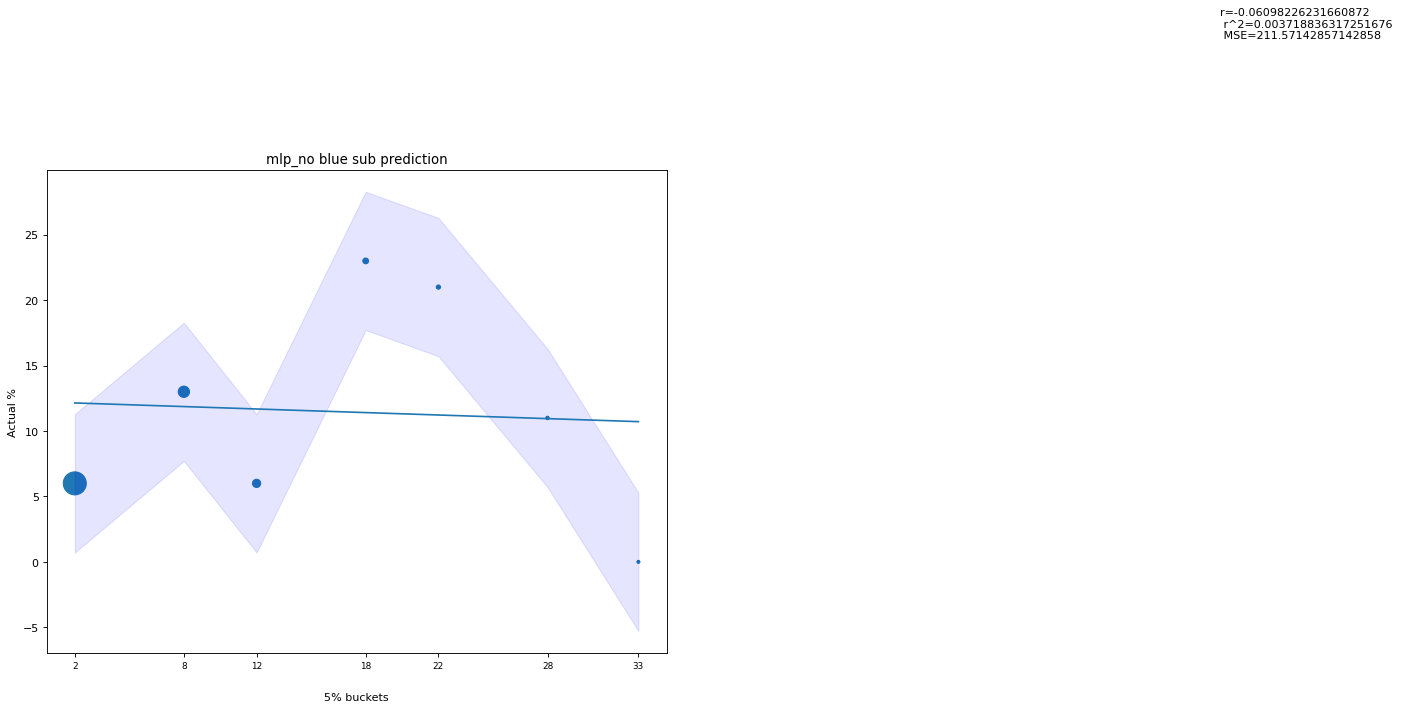

['mlp_rand']
mlp_rand
0% to 5%: 7% of 326 observations
5% to 10%: 6% of 127 observations
10% to 15%: 7% of 68 observations
15% to 20%: 24% of 29 observations
20% to 25%: 12% of 25 observations
25% to 30%: 11% of 19 observations
30% to 35%: 20% of 15 observations
35% to 40%: 25% of 4 observations
40% to 45%: 9% of 11 observations
45% to 50%: 12% of 8 observations
50% to 55%: 25% of 4 observations
55% to 60%: 25% of 4 observations
60% to 65%: 20% of 5 observations
65% to 70%: 0% of 3 observations
70% to 75%: 100% of 1 observations
75% to 80%: 0% of 1 observations
80% to 85%: 0% of 1 observations
85% to 90%: 0% of 1 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[326, 127, 68, 29, 25, 19, 15, 11, 8, 5]
[2, 8, 12, 18, 22, 28, 33, 43, 48, 63]
[7, 6, 7, 24, 12, 11, 20, 9, 12, 20]


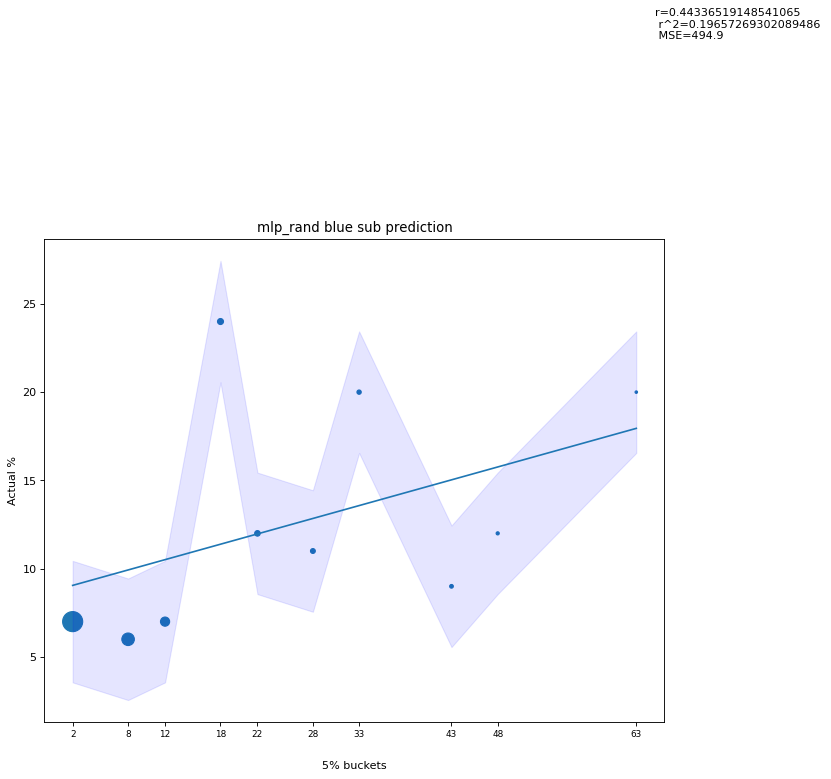

['mlp_up']
mlp_up
0% to 5%: 6% of 457 observations
5% to 10%: 7% of 76 observations
10% to 15%: 23% of 40 observations
15% to 20%: 7% of 15 observations
20% to 25%: 6% of 16 observations
25% to 30%: 20% of 5 observations
30% to 35%: 20% of 10 observations
35% to 40%: 25% of 4 observations
40% to 45%: 40% of 5 observations
45% to 50%: 0% of 3 observations
50% to 55%: 0% of 1 observations
55% to 60%: 33% of 3 observations
60% to 65%: 0% of 2 observations
65% to 70%: 40% of 5 observations
70% to 75%: 0% of 2 observations
75% to 80%: 0% of 1 observations
80% to 85%: 50% of 4 observations
85% to 90%: 100% of 1 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[457, 76, 40, 15, 16, 5, 10, 5, 5]
[2, 8, 12, 18, 22, 28, 33, 43, 68]
[6, 7, 23, 7, 6, 20, 20, 40, 40]


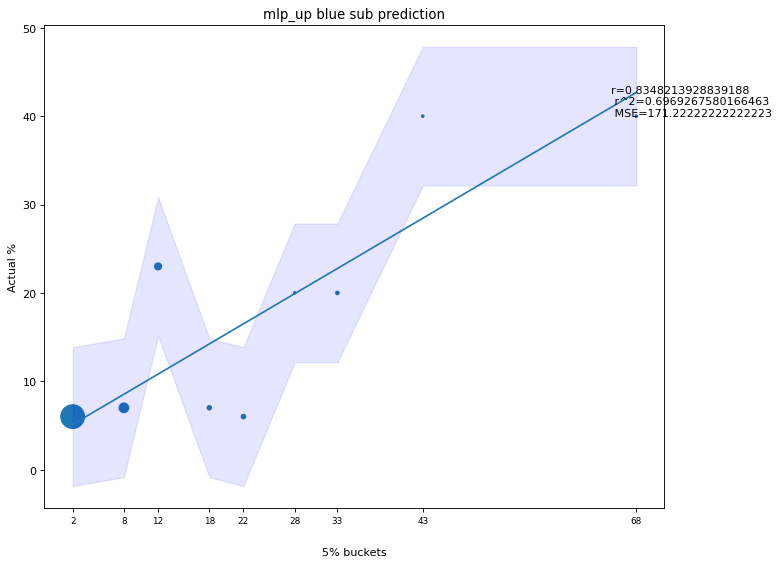

['nn_no']
nn_no
0% to 5%: 7% of 342 observations
5% to 10%: 5% of 189 observations
10% to 15%: 19% of 77 observations
15% to 20%: 14% of 21 observations
20% to 25%: 30% of 10 observations
25% to 30%: 0% of 4 observations
30% to 35%: 50% of 4 observations
35% to 40%: 50% of 2 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 1 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[342, 189, 77, 21, 10]
[2, 8, 12, 18, 22]
[7, 5, 19, 14, 30]


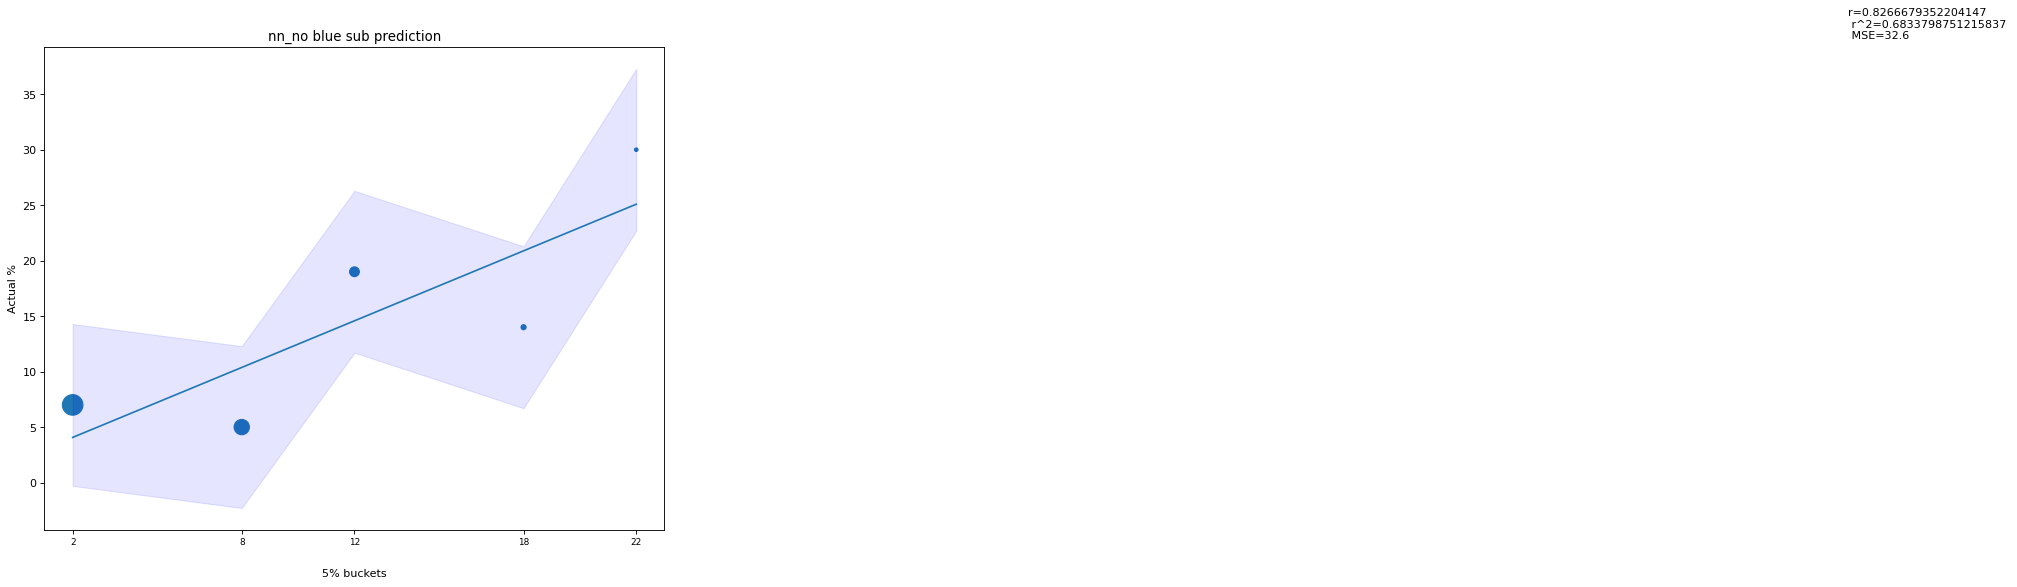

['nn_rand']
nn_rand
0% to 5%: 6% of 220 observations
5% to 10%: 8% of 213 observations
10% to 15%: 11% of 99 observations
15% to 20%: 4% of 48 observations
20% to 25%: 15% of 33 observations
25% to 30%: 17% of 18 observations
30% to 35%: 25% of 8 observations
35% to 40%: 20% of 5 observations
40% to 45%: 0% of 2 observations
45% to 50%: 33% of 3 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 1 observations
75% to 80%: 0% of 1 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[220, 213, 99, 48, 33, 18, 8, 5]
[2, 8, 12, 18, 22, 28, 33, 38]
[6, 8, 11, 4, 15, 17, 25, 20]


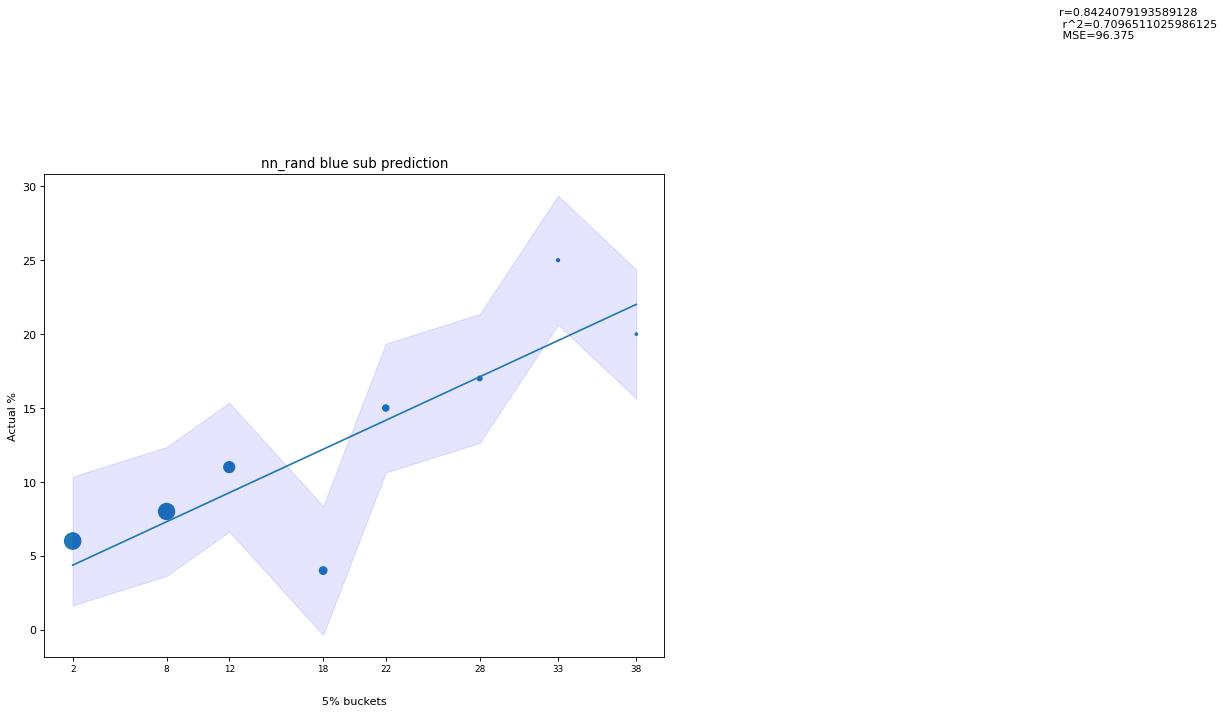

['nn_up']
nn_up
0% to 5%: 5% of 370 observations
5% to 10%: 9% of 129 observations
10% to 15%: 16% of 49 observations
15% to 20%: 16% of 25 observations
20% to 25%: 26% of 19 observations
25% to 30%: 22% of 18 observations
30% to 35%: 8% of 12 observations
35% to 40%: 14% of 7 observations
40% to 45%: 25% of 4 observations
45% to 50%: 0% of 5 observations
50% to 55%: 0% of 4 observations
55% to 60%: 25% of 4 observations
60% to 65%: 0% of 2 observations
65% to 70%: 33% of 3 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[370, 129, 49, 25, 19, 18, 12, 7, 5]
[2, 8, 12, 18, 22, 28, 33, 38, 48]
[5, 9, 16, 16, 26, 22, 8, 14, 0]


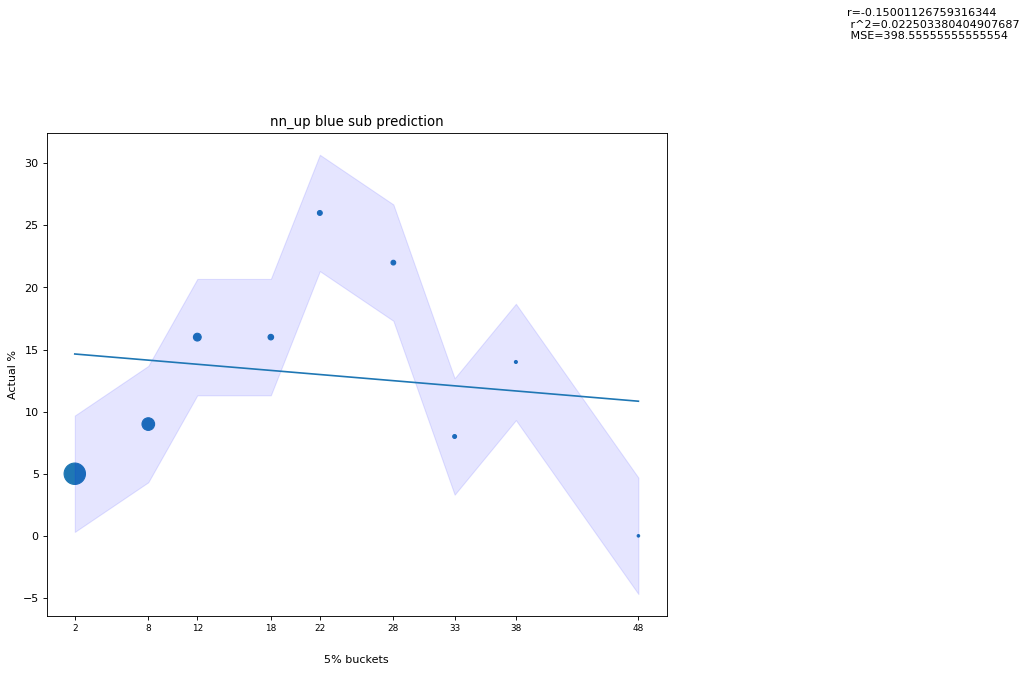

['mix_no']
mix_no
0% to 5%: 6% of 251 observations
5% to 10%: 7% of 300 observations
10% to 15%: 21% of 75 observations
15% to 20%: 25% of 12 observations
20% to 25%: 0% of 9 observations
25% to 30%: 33% of 3 observations
30% to 35%: 0% of 0 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 2 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[251, 300, 75, 12, 9]
[2, 8, 12, 18, 22]
[6, 7, 21, 25, 0]


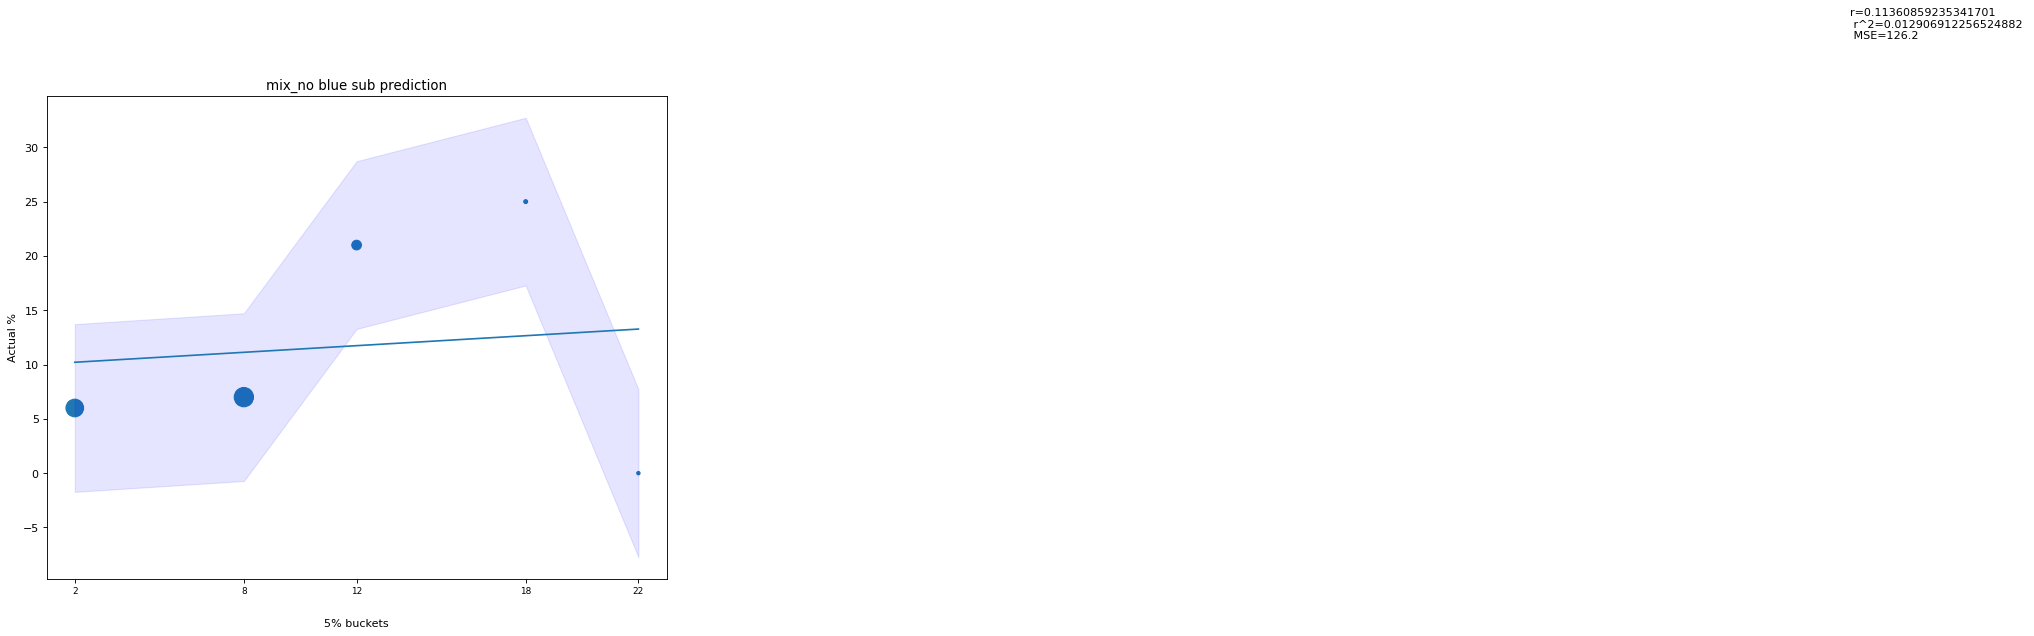

['mix_rand']
mix_rand
0% to 5%: 7% of 90 observations
5% to 10%: 5% of 306 observations
10% to 15%: 9% of 149 observations
15% to 20%: 18% of 50 observations
20% to 25%: 16% of 32 observations
25% to 30%: 28% of 14 observations
30% to 35%: 0% of 3 observations
35% to 40%: 28% of 7 observations
40% to 45%: 0% of 1 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[90, 306, 149, 50, 32, 14, 7]
[2, 8, 12, 18, 22, 28, 38]
[7, 5, 9, 18, 16, 28, 28]


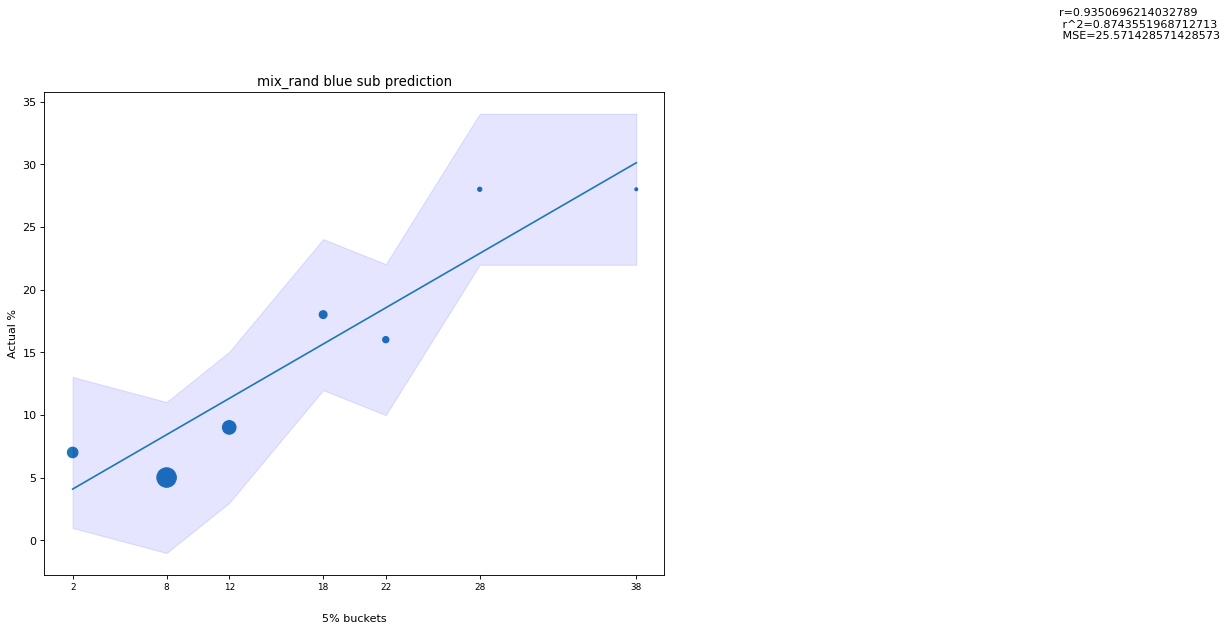

['mix_up']
mix_up
0% to 5%: 5% of 177 observations
5% to 10%: 8% of 308 observations
10% to 15%: 13% of 124 observations
15% to 20%: 11% of 27 observations
20% to 25%: 17% of 6 observations
25% to 30%: 43% of 7 observations
30% to 35%: 0% of 3 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[177, 308, 124, 27, 6, 7]
[2, 8, 12, 18, 22, 28]
[5, 8, 13, 11, 17, 43]


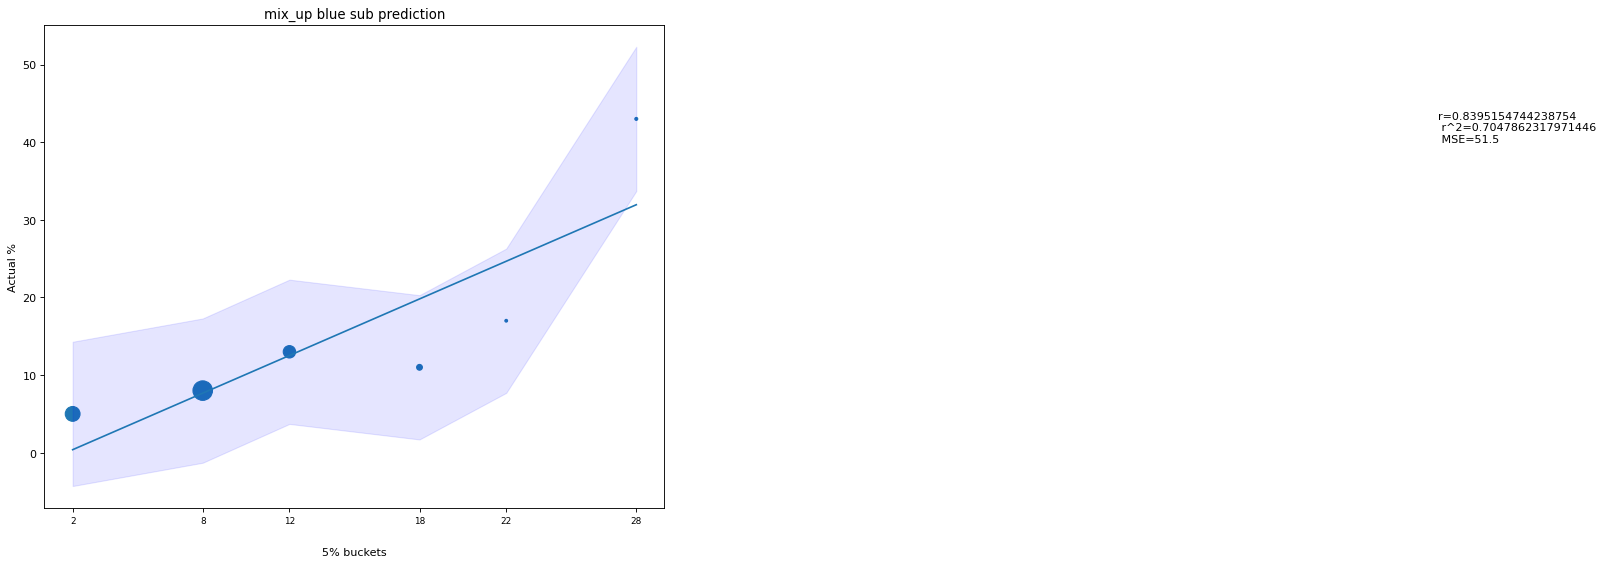

['combined']
combined
0% to 5%: 7% of 109 observations
5% to 10%: 5% of 360 observations
10% to 15%: 10% of 127 observations
15% to 20%: 28% of 29 observations
20% to 25%: 28% of 14 observations
25% to 30%: 44% of 9 observations
30% to 35%: 0% of 3 observations
35% to 40%: 0% of 0 observations
40% to 45%: 0% of 0 observations
45% to 50%: 0% of 0 observations
50% to 55%: 0% of 0 observations
55% to 60%: 0% of 0 observations
60% to 65%: 0% of 0 observations
65% to 70%: 0% of 0 observations
70% to 75%: 0% of 0 observations
75% to 80%: 0% of 0 observations
80% to 85%: 0% of 0 observations
85% to 90%: 0% of 0 observations
90% to 95%: 0% of 0 observations
95% to 100%: 0% of 0 observations
[109, 360, 127, 29, 14, 9]
[2, 8, 12, 18, 22, 28]
[7, 5, 10, 28, 28, 44]


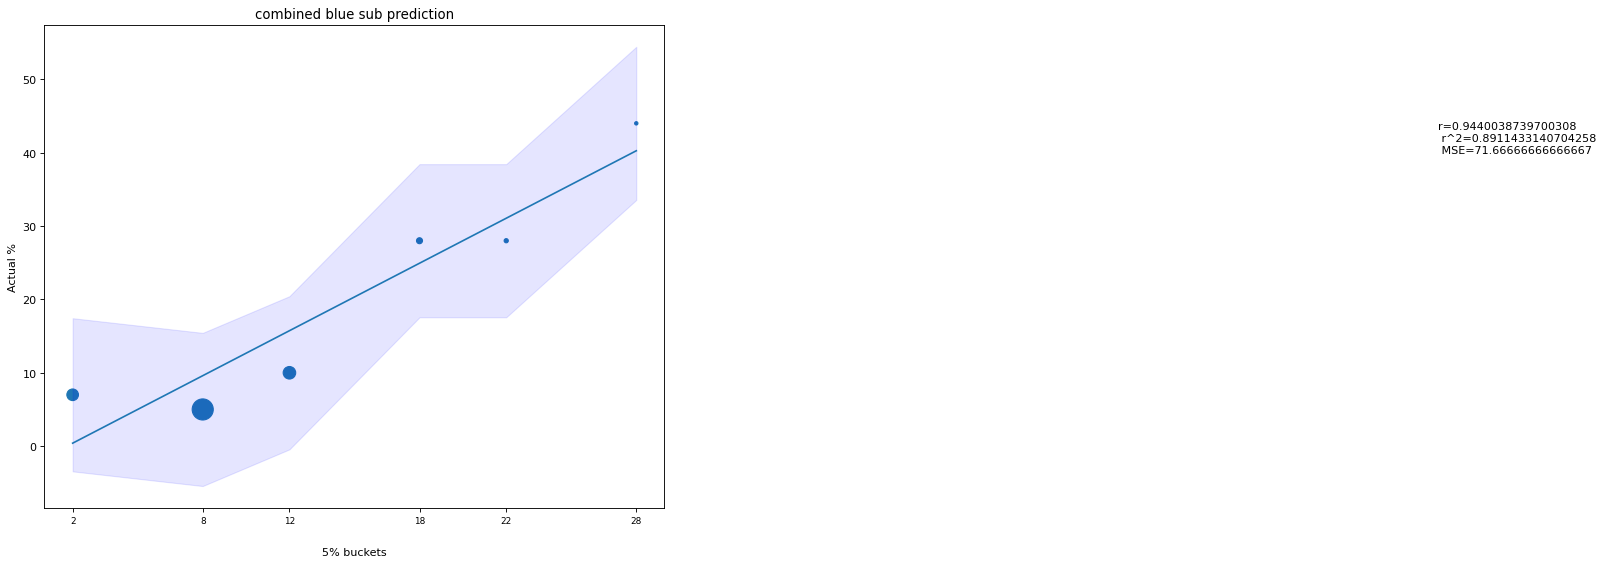

In [85]:
model_combo = []
r = []
r_squared = []
m_squared = []

for clean_perm in clean_perm_list:
    print(clean_perm)
#     perm_list = list(raw_perm)
#     print(perm_list)
    perm_df = model_results_df[model_results_df["model_v"].isin(clean_perm)]
    
    perm_str = ""
    for n in range(len(clean_perm)):
#         print(perm_list[n])
        if n > 0:
            perm_str += " + " + clean_perm[n] 
            
        else:
            perm_str += clean_perm[n]
    
    print(perm_str)
        
    model_combo.append(perm_str)
    
    
    win_range_pred = []
    actual_win_pct = []
    observations = []
    half_points = []
    for x in np.arange(0, 1, bucket):
        win_range = f"{int(round(x, 2)*100)}% to {int(round(x+bucket, 2)*100)}%"
        point_up = perm_df[perm_df["blue_sub_pct"] >= x]
        point_to_point = point_up[point_up["blue_sub_pct"] < x+bucket]
        half_point = int(round(x+(bucket/divider),2) * 100)

        if len(point_to_point) > 0:
            win_pct = int(round(len(point_to_point[point_to_point["actual_method"] == "blue - Submission"]) / len(point_to_point), 2) * 100)
        else:
            win_pct = 0

        win_range_pred.append(win_range)
        actual_win_pct.append(win_pct)
        observations.append(len(point_to_point))
        half_points.append(half_point)


        print(f"{win_range}: {win_pct}% of {len(point_to_point)} observations")
        
    empties = [i for i, j in enumerate(observations) if j < min_obs]    
    for i in sorted(empties, reverse=True):
        del observations[i]
        del half_points[i]
        del actual_win_pct[i]

    print(observations)
    print(half_points)
    print(actual_win_pct)
    
    x = half_points
    # print(x)
    y = actual_win_pct
    # print(y)
    s = observations
    figure(figsize=(10, 8), dpi=80)
    plt.scatter(x, y, s=s)
    b, m = polyfit(x, y, 1)
    # print(b)
    # print(m)
    line = m*np.array(x)+b
    plt.plot(x, line, label=f"y={m}x+{b}")

    ci = 1.81 * np.std(y)/np.sqrt(len(x))
    plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    mse = mean_squared_error(y,x)
    pearsons_coefficient = np.corrcoef(x, y)
    r_score = pearsons_coefficient[0][1]
    r_square = r_score*r_score
    plt.text(65, 40, f"r={r_score} \n r^2={r_square} \n MSE={mse}", fontsize=10)
    plt.xticks(x, fontsize=8)
    plt.xlabel(f"{int(bucket*100)}% buckets", labelpad=20)
    plt.ylabel("Actual %")
    plt.title(f"{perm_str} blue sub prediction")
    plt.show()

    r.append(r_score)
    r_squared.append(r_square)
    m_squared.append(mse)

In [86]:
blue_sub_dict = {"model_combo" : model_combo,
                "r_score" : r,
               "r_squared" : r_squared,
               "mean_squared" : m_squared}

blue_sub_df = pd.DataFrame(blue_sub_dict)
blue_sub_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.849589   0.721801     17.500000
1     knn_rand  0.635229   0.403516     71.833333
2       knn_up  0.657486   0.432287    125.250000
3       log_no  0.680619   0.463242    128.666667
4     log_rand  0.934528   0.873343     46.428571
5       log_up  0.851765   0.725503     36.714286
6        rf_no -0.669816   0.448654     91.000000
7      rf_rand  0.082108   0.006742    101.500000
8        rf_up  0.889863   0.791856     15.600000
9       mlp_no -0.060982   0.003719    211.571429
10    mlp_rand  0.443365   0.196573    494.900000
11      mlp_up  0.834821   0.696927    171.222222
12       nn_no  0.826668   0.683380     32.600000
13     nn_rand  0.842408   0.709651     96.375000
14       nn_up -0.150011   0.022503    398.555556
15      mix_no  0.113609   0.012907    126.200000
16    mix_rand  0.935070   0.874355     25.571429
17      mix_up  0.839515   0.704786     51.500000
18    combined  0.944004   0.891143     71.666667

In [87]:
concat_frames = [red_win_df, blue_win_df, red_dec_df, red_ko_df, red_sub_df, blue_dec_df, blue_ko_df, blue_sub_df]
concat_df = pd.concat(concat_frames)
concat_df

model_combo   r_score  r_squared  mean_squared
0       knn_no  0.631521   0.398819    235.384615
1     knn_rand  0.531794   0.282805    246.416667
2       knn_up  0.672046   0.451646    406.733333
3       log_no  0.811276   0.658169    153.428571
4     log_rand  0.945151   0.893310     82.800000
..         ...       ...        ...           ...
14       nn_up -0.150011   0.022503    398.555556
15      mix_no  0.113609   0.012907    126.200000
16    mix_rand  0.935070   0.874355     25.571429
17      mix_up  0.839515   0.704786     51.500000
18    combined  0.944004   0.891143     71.666667

[152 rows x 4 columns]

In [93]:
concat_mean = concat_df.groupby(["model_combo"]).mean().sort_values(by="mean_squared")
concat_mean

r_score  r_squared  mean_squared
model_combo                                   
mix_rand     0.898457   0.810313     60.915427
combined     0.836008   0.723731     64.262067
log_rand     0.876036   0.782158     82.865422
mix_up       0.799374   0.653567     95.320662
mix_no       0.693891   0.549605    107.187798
rf_rand      0.319078   0.259275    122.097173
nn_rand      0.812067   0.672921    125.244758
log_no       0.758813   0.583417    130.371762
knn_rand     0.591703   0.437677    149.442235
knn_no       0.656403   0.443727    149.530517
nn_no        0.787652   0.636643    162.475719
rf_up        0.187927   0.333892    163.605357
rf_no       -0.210269   0.344551    176.180952
log_up       0.742277   0.592395    205.244673
knn_up       0.598035   0.386851    305.475223
nn_up        0.539459   0.402981    343.824544
mlp_no       0.454216   0.323254    487.863711
mlp_rand     0.538044   0.333958    520.780417
mlp_up       0.492411   0.293481    718.460530